# Data Understanding

## Settings

In [2]:
########################################################################################################################
# Imports & Settings
########################################################################################################################

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import time
import pycountry

In [3]:
# allow display of all rows (with scrollbar)
pd.set_option("display.max_rows", 10) #pd.set_option("display.max_rows", None)

# determine whether to use calculated language flags or recompute them
recompute_lg_flg = False

In [51]:
########################################################################################################################
# Global Variables
########################################################################################################################

# change working dir to access tempData folder
if os.getcwd().endswith('Data Understanding'):
    os.chdir('..')
    print(f'went one level up --> current workdir: {os.getcwd()}')

# source data file paths
transactions_path = 'tempData/sourceData/transactions.csv'
evaluation_path = 'tempData/sourceData/evaluation.csv'
items_path = 'tempData/sourceData/items.csv'
subject_cats_0_path = 'tempData/sourceData/subject_cats_0.csv'

# pre-processed data file paths (incl. language flags)
items_path_pp = 'tempData/processedData/items_pp.csv'

# seaborn color palette
palette_blue = "Blues_d"
dark_blue = "#011f4b"
middle_blue = "#005b96"
light_blue = "#b3cde0"

In [5]:
########################################################################################################################
# Functions
########################################################################################################################

def clean_alt_list(list_):
    list_ = list_.replace(', ', ',')
    list_ = list_.replace(',', ',')
    list_ = list_.replace('[', '')
    list_ = list_.replace(']', '')
    return list_

## Data load & initial pre-processing

In [53]:
########################################################################################################################
# Load Data & Print first summary statistics
########################################################################################################################

# Load the dmc source data
# - clicks/baskets/order over a period of 3M
# - rows: one transaction for single item
transactions_df = pd.read_csv(transactions_path, delimiter='|', sep='.', encoding='utf-8')
# - list of product ids (subset of products from items_df) to be used for prediction
evaluation_df = pd.read_csv(evaluation_path, sep='.', encoding='utf-8')
items_df = pd.read_csv(items_path, delimiter='|', sep='.', encoding='utf-8')

# load category lookup table (manually created)
subject_cats_0 = pd.read_csv(subject_cats_0_path, delimiter=';', encoding='utf-8')

# Load pre-processed df (incl. language flags)
items_df_pp = pd.read_csv(items_path_pp, delimiter=',', encoding='utf-8')

# Print description of dfs

# Get shape of dfs
print(f'shape transactions_df: {transactions_df.shape}')
#print(f'shape evaluation_df: {evaluation_df.shape}')
print(f'shape items_df: {items_df.shape}\n')

# Get col names + datatype
print(f'cols transactions_df: \n{transactions_df.dtypes}\n')
#print(f'cols evaluation_df: \n{evaluation_df.dtypes}\n')
print(f'cols items_df: \n{items_df.dtypes}\n')

# Get description of dfs
print(f'desc transactions_df: \n{transactions_df.describe()}\n')
#print(f'desc evaluation_df: \n{evaluation_df.describe()}\n')
print(f'desc items_df: \n{items_df.describe()}\n')

# Get cnt of unique sessions / items
print(f'cnt unqiue sessions: {transactions_df["sessionID"].nunique()}') #271,983
print(f'cnt unqiue items: {transactions_df["itemID"].nunique()}') #24,909

shape transactions_df: (365143, 5)
shape items_df: (78030, 6)

cols transactions_df: 
sessionID    int64
itemID       int64
click        int64
basket       int64
order        int64
dtype: object

cols items_df: 
itemID         int64
title         object
author        object
publisher     object
main topic    object
subtopics     object
dtype: object

desc transactions_df: 
           sessionID         itemID          click         basket  \
count  365143.000000  365143.000000  365143.000000  365143.000000   
mean   139586.939175   40051.292307       1.233180       0.141202   
std     80795.207871   22493.347334       1.069996       1.107574   
min         0.000000       1.000000       0.000000       0.000000   
25%     69459.500000   20713.000000       1.000000       0.000000   
50%    139608.000000   40692.000000       1.000000       0.000000   
75%    209750.500000   58916.000000       1.000000       0.000000   
max    279354.000000   79066.000000     118.000000     293.000000   

  

In [7]:
########################################################################################################################
# Preprocessing for further inspection
########################################################################################################################

# extract list of base cols 
initial_cols= list(items_df.columns)

# normalization: author col
items_df.loc[items_df['author'] == 'ohne Autor', 'author'] = None

# add col: get len of mt string
items_df['mt_len'] = items_df['main topic'].str.len()

# add col: get first element (top level category) of mt string
items_df['mt_0'] = items_df['main topic'].str[0]

# adjust subtopics: set to None if subtopics list is empty
items_df['subtopics_str'] = items_df['subtopics'].astype(str).apply(clean_alt_list)
items_df.loc[items_df['subtopics_str'].apply(len) ==0, 'subtopics_str'] = None

# add col: get click / basket / order flag
transactions_df['click_flg'] = np.where(transactions_df['click'] > 0, 1, 0)
transactions_df['basket_flg'] = np.where(transactions_df['basket'] > 0, 1, 0)
transactions_df['order_flg'] = np.where(transactions_df['order'] > 0, 1, 0)

In [8]:
# show dfs after initial pre-processing
print(f'items_df after first pre-processing:')
display(items_df.head(2))

print(f'transactions_df after first pre-processing:')
display(transactions_df.head(2))

items_df after first pre-processing:


itemID                           title              author  \
0   21310  Princess Poppy: The Big Mix Up  Janey Louise Jones   
1   73018  Einfach zeichnen! Step by Step       Wiebke Krabbe   

                            publisher main topic  \
0  Penguin Random House Children's UK        YFB   
1              Schwager und Steinlein        AGZ   

                       subtopics  mt_len mt_0                subtopics_str  
0                          [5AH]     3.0    Y                          5AH  
1  [5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]     3.0    A  5AJ,AGZ,WFA,YBG,YBL,YNA,YPA

transactions_df after first pre-processing:


sessionID  itemID  click  basket  order  click_flg  basket_flg  order_flg
0          0   21310      1       0      0          1           0          0
1          1   73018      1       0      0          1           0          0

## Overview statistics per relation / attribute

### items

#### author

# books per author:


book_cnt   frac[%]
NaN                                  3240  4.152249
Garcia Santiago                      1479  1.895425
Shelley Admont, Kidkiddos Books       228  0.292195
James Manning                         180  0.230681
Jules Verne                           178  0.228117
Idries Shah                           168  0.215302
Enid Blyton                           158  0.202486
Erin Hunter                           158  0.202486
R. L. Stine                           138  0.176855
Terry Pratchett                       115  0.147379

summary statistics of books per author:


book_cnt       frac[%]
count  35970.000000  35970.000000
mean       2.169308      0.002780
std       19.311689      0.024749
min        1.000000      0.001282
25%        1.000000      0.001282
50%        1.000000      0.001282
75%        2.000000      0.002563
max     3240.000000      4.152249

distribution of books per author:


book_cnt  author_cnt  author_cnt.cum    frac[%]  frac.cum[%]
0         1       25849           25849  71.862663    71.862663
1         2        4858           30707  13.505699    85.368363
2         3        1855           32562   5.157075    90.525438
3         4        1043           33605   2.899639    93.425076
4         5         564           34169   1.567973    94.993050
5         6         372           34541   1.034195    96.027245
6         7         261           34802   0.725605    96.752850
7         8         187           34989   0.519878    97.272727
8         9         145           35134   0.403114    97.675841
9        10         103           35237   0.286350    97.962191

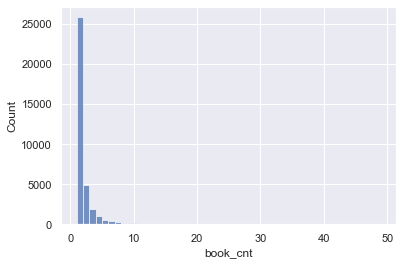

In [9]:
# count of books per author
books_per_author = pd.DataFrame.from_dict(Counter(items_df.loc[:,'author']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False)
books_per_author['frac[%]'] = books_per_author['book_cnt'] * 100 / books_per_author['book_cnt'].sum()

print(f'# books per author:')
display(books_per_author.head(10))

print(f'summary statistics of books per author:')
display(books_per_author.describe())

# distribution of cnt af books among authors
books_per_author_cnts = pd.DataFrame(books_per_author['book_cnt'].value_counts().reset_index()).rename(columns={'index': 'book_cnt', 
                                                                                                                'book_cnt': 'author_cnt'})
books_per_author_cnts['author_cnt.cum'] = books_per_author_cnts['author_cnt'].cumsum()
books_per_author_cnts['frac[%]'] = books_per_author_cnts['author_cnt'] * 100 / books_per_author_cnts['author_cnt'].sum()
books_per_author_cnts['frac.cum[%]'] = books_per_author_cnts['frac[%]'].cumsum()

print(f'distribution of books per author:')
display(books_per_author_cnts.head(10))
sns.set_theme()
sns.histplot(books_per_author[books_per_author['book_cnt']<50]['book_cnt'], binwidth=1)
plt.show()

#### publisher

# books per publisher:


book_cnt   frac[%]
Books on Demand                         3759  4.817378
LIGHTNING SOURCE INC                    2355  3.018070
Lulu.com                                1717  2.200436
Xlibris                                 1576  2.019736
Fichas de preescolar                    1499  1.921056
iUniverse                               1414  1.812124
epubli                                  1183  1.516084
INDEPENDENTLY PUBLISHED                 1061  1.359733
AuthorHouse                             1001  1.282840
Penguin Random House Children's UK       859  1.100859

summary statistics of books per publisher:


book_cnt      frac[%]
count  7073.000000  7073.000000
mean     11.032094     0.014138
std      77.953138     0.099901
min       1.000000     0.001282
25%       1.000000     0.001282
50%       1.000000     0.001282
75%       4.000000     0.005126
max    3759.000000     4.817378

distribution of books per publisher:


book_cnt  publisher_cnt  publisher_cnt.cum    frac[%]  frac.cum[%]
0         1           3646               3646  51.548141    51.548141
1         2           1042               4688  14.732080    66.280221
2         3            514               5202   7.267072    73.547293
3         4            317               5519   4.481832    78.029125
4         5            228               5747   3.223526    81.252651
5         6            165               5912   2.332815    83.585466
6         7            115               6027   1.625901    85.211367
7         8             85               6112   1.201753    86.413120
8         9             79               6191   1.116924    87.530044
9        10             66               6257   0.933126    88.463170

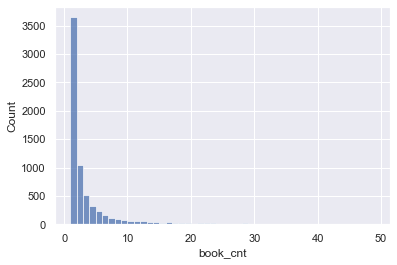

In [10]:
# count of books per publisher
books_per_publisher = pd.DataFrame.from_dict(Counter(items_df.loc[:,'publisher']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False)
books_per_publisher['frac[%]'] = books_per_publisher['book_cnt'] * 100 / books_per_publisher['book_cnt'].sum()

print(f'# books per publisher:')
display(books_per_publisher.head(10))

print(f'summary statistics of books per publisher:')
display(books_per_publisher.describe())

# distribution of cnt af books among publishers
books_per_publisher_cnts = pd.DataFrame(books_per_publisher['book_cnt'].value_counts().reset_index()).rename(columns={'index': 'book_cnt', 
                                                                                                                'book_cnt': 'publisher_cnt'})
books_per_publisher_cnts['publisher_cnt.cum'] = books_per_publisher_cnts['publisher_cnt'].cumsum()
books_per_publisher_cnts['frac[%]'] = books_per_publisher_cnts['publisher_cnt'] * 100 / books_per_publisher_cnts['publisher_cnt'].sum()
books_per_publisher_cnts['frac.cum[%]'] = books_per_publisher_cnts['frac[%]'].cumsum()

print(f'distribution of books per publisher:')
display(books_per_publisher_cnts.head(10))
sns.set_theme()
sns.histplot(books_per_publisher[books_per_publisher['book_cnt']<50]['book_cnt'], binwidth=1)
plt.show()

#### main topics

str len main topics:


mt_len
count  77772.000000
mean       2.994355
std        0.746807
min        1.000000
25%        3.000000
50%        3.000000
75%        3.000000
max       10.000000

top 5 high level cats:


Notation  book_cnt    frac[%]                            Category heading
0        Y     48416  62.047930         Children’s, Teenage and Educational
1        F     26534  34.004870                   Fiction and Related items
2        X       934   1.196976       Graphic novels, Comic books, Cartoons
3        W       651   0.834295              Lifestyle, Hobbies and Leisure
4        D       409   0.524157  Biography, Literature and Literary studies

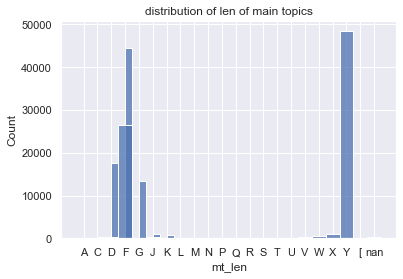

In [11]:
# get depth of main topic tree
print(f'str len main topics:')
display(pd.DataFrame(items_df["mt_len"].describe()))
mt_len_hist = sns.histplot(items_df['mt_len']).set_title(f'distribution of len of main topics')

# count of books per main topic (=mt) combo
books_per_mt = pd.DataFrame.from_dict(Counter(items_df.loc[:,'main topic']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False)
books_per_mt['frac[%]'] = books_per_mt['book_cnt'] * 100 / books_per_mt['book_cnt'].sum()

# plot mt_0 distribution
sns.set_theme()
sns.histplot(items_df['mt_0'].astype(str).sort_values())

# count of books per first element of mt
books_per_mt_0 = pd.DataFrame.from_dict(Counter(items_df.loc[:,'mt_0']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False).reset_index()
books_per_mt_0 = books_per_mt_0.rename(columns={'index': 'Notation'})
books_per_mt_0['frac[%]'] = books_per_mt_0['book_cnt'] * 100 / books_per_mt_0['book_cnt'].sum()

# join with category heading
books_per_mt_0 = books_per_mt_0.merge(subject_cats_0, on='Notation', how='left')
print(f'top 5 high level cats:')
display(books_per_mt_0.head(5))

### transactions

#### sessionid

In [12]:
# get cnt of items per sessionid
items_per_session = transactions_df[['sessionID', 'itemID']].groupby('sessionID')['itemID'].count().reset_index().\
    sort_values(by='itemID', ascending=False).rename(columns={'itemID': 'item_cnt'})
items_per_session['frac[%]'] = items_per_session['item_cnt'] * 100 / items_per_session['item_cnt'].sum()

print(f'items per session:')
display(items_per_session.head(10))

print(f'items per session summary stats:')
display(items_per_session.describe())

items per session:


sessionID  item_cnt   frac[%]
28539       29304       213  0.058333
92723       95250       157  0.042997
7175         7394       144  0.039437
212895     218629       141  0.038615
14895       15327       129  0.035329
127012     130436       101  0.027660
115103     118198       100  0.027387
18866       19393        99  0.027113
219703     225605        90  0.024648
225620     231696        87  0.023826

items per session summary stats:


sessionID       item_cnt        frac[%]
count  271983.000000  271983.000000  271983.000000
mean   139662.956556       1.342521       0.000368
std     80627.925780       1.642545       0.000450
min         0.000000       1.000000       0.000274
25%     69842.500000       1.000000       0.000274
50%    139660.000000       1.000000       0.000274
75%    209480.500000       1.000000       0.000274
max    279354.000000     213.000000       0.058333

#### click

In [13]:
# get cnt of clicks per item
clicks_per_item = transactions_df[['itemID', 'click']].groupby('itemID')['click'].sum().reset_index().\
    sort_values(by='click', ascending=False).rename(columns={'click': 'click_cnt'})
clicks_per_item['frac[%]'] = clicks_per_item['click_cnt'] * 100 / clicks_per_item['click_cnt'].sum()

print(f'clicks per item:')
display(clicks_per_item.head(10))

print(f'clicks per item summary stats:')
display(clicks_per_item.describe())

clicks per item:


itemID  click_cnt   frac[%]
18397   58522       3229  0.717098
3316    10666       2218  0.492575
13830   44220       2204  0.489466
20875   66247       2194  0.487245
12733   40692       2020  0.448603
21822   69185       1818  0.403743
14744   46998       1749  0.388419
14780   47120       1695  0.376427
11928   38123       1497  0.332455
19603   62341       1430  0.317575

clicks per item summary stats:


itemID     click_cnt       frac[%]
count  24909.000000  24909.000000  24909.000000
mean   39644.924967     18.077281      0.004015
std    22806.593806     69.372510      0.015406
min        1.000000      0.000000      0.000000
25%    19879.000000      1.000000      0.000222
50%    39748.000000      3.000000      0.000666
75%    59472.000000     11.000000      0.002443
max    79066.000000   3229.000000      0.717098

#### basket vs order
- basket: items that were added to basekt but not necessarily bought
- order: items that where finally bought

In [14]:
# get cnt of orders per session
orders_per_session = transactions_df[['sessionID', 'order_flg']].groupby('sessionID')['order_flg'].sum().reset_index().\
    sort_values(by='order_flg', ascending=False).rename(columns={'order_flg': 'order_cnt'})
orders_per_session['frac[%]'] = orders_per_session['order_cnt'] * 100 / orders_per_session['order_cnt'].sum()

print(f'distinct orders per session (binary, w/o qty):')
display(orders_per_session.head(10))

print(f'distinct orders per session summary stats:')
display(orders_per_session.describe())

# get cnt of orders per item
orders_per_item = transactions_df[['itemID', 'order_flg']].groupby('itemID')['order_flg'].sum().reset_index().\
    sort_values(by='order_flg', ascending=False).rename(columns={'order_flg': 'order_cnt'})
orders_per_item['frac[%]'] = orders_per_item['order_cnt'] * 100 / orders_per_item['order_cnt'].sum()

print(f'distinct orders per item (binary, w/o qty):')
display(orders_per_item.head(10))

print(f'distinct orders per item summary stats:')
display(orders_per_item.describe())

# get frac of items that were added to basket but not bought
items_per_basket_order = transactions_df[['itemID',
                                          'basket_flg',
                                          'order_flg']].groupby(['basket_flg',
                                                                 'order_flg'])['itemID'].count().reset_index().rename(columns={'itemID': 'item_cnt'})
items_per_basket_order['frac[%]'] = items_per_basket_order['item_cnt'] * 100 / items_per_basket_order['item_cnt'].sum()
print(f'basket to order conversion:')
display(items_per_basket_order)

distinct orders per session (binary, w/o qty):


sessionID  order_cnt   frac[%]
128318     131769         21  0.124216
174897     179587         13  0.076896
5875         6058         11  0.065066
204066     209560         11  0.065066
201701     207134         10  0.059151
238647     245082          9  0.053236
176778     181533          9  0.053236
161664     166006          9  0.053236
266225     273431          9  0.053236
270074     277398          9  0.053236

distinct orders per session summary stats:


sessionID      order_cnt        frac[%]
count  271983.000000  271983.000000  271983.000000
mean   139662.956556       0.062158       0.000368
std     80627.925780       0.327497       0.001937
min         0.000000       0.000000       0.000000
25%     69842.500000       0.000000       0.000000
50%    139660.000000       0.000000       0.000000
75%    209480.500000       0.000000       0.000000
max    279354.000000      21.000000       0.124216

distinct orders per item (binary, w/o qty):


itemID  order_cnt   frac[%]
22006   69803        121  0.715722
14780   47120        121  0.715722
16865   53695        117  0.692062
14321   45799         93  0.550101
17354   55215         82  0.485035
23444   74398         82  0.485035
4263    13711         77  0.455460
6069    19379         75  0.443629
7415    23654         72  0.425884
24768   78643         71  0.419969

distinct orders per item summary stats:


itemID     order_cnt       frac[%]
count  24909.000000  24909.000000  24909.000000
mean   39644.924967      0.678711      0.004015
std    22806.593806      3.189329      0.018865
min        1.000000      0.000000      0.000000
25%    19879.000000      0.000000      0.000000
50%    39748.000000      0.000000      0.000000
75%    59472.000000      0.000000      0.000000
max    79066.000000    121.000000      0.715722

basket to order conversion:


basket_flg  order_flg  item_cnt    frac[%]
0           0          0    307776  84.289169
1           0          1     12379   3.390179
2           1          0     40461  11.080864
3           1          1      4527   1.239788

## Anomaly Detection

### Missing Values
- 9 items w/o publisher: 
    - could be anything, cannot be imputed
    - not such a crucial information to be missing
    - thus: no handling 
- 3240 items w/o author:
    - correct author might not be uniquely determinable or there might not even be a senseful author
    - thus: no handling
- 258 items w/o main topic:
    - at least subtopic is given
    - only 32 of these also have the author missing
- 36,904 items w/o subtopic:
    - in all of the cases, a main topic is given 
    - thus: still enough information available

In [15]:
# get cnt of missing values per column
missing_values = pd.DataFrame(items_df.isnull().sum()).rename(columns={0: 'cnt'})
missing_values['frac[%]'] = missing_values['cnt'] * 100 / len(items_df)
print(f'null values per column:')
display(missing_values.transpose())

# get cnt of combined null values: sum null values per row and cnt rows with #null > 1
print(f'\n# rows with null values in more than one col: {(items_df[initial_cols + ["subtopics_str"]].isnull().sum(axis=1) > 1).sum()}')
print(f'\ndistribution of null values over cols (1=null, 0=not null):')
display(pd.DataFrame((items_df[initial_cols + ['subtopics_str']].isnull() * 1).value_counts().reset_index()))

null values per column:


itemID  title       author  publisher  main topic  subtopics  \
cnt         0.0    0.0  3241.000000   9.000000  258.000000   1.000000   
frac[%]     0.0    0.0     4.153531   0.011534    0.330642   0.001282   

             mt_len        mt_0  subtopics_str  
cnt      258.000000  258.000000    36904.00000  
frac[%]    0.330642    0.330642       47.29463


# rows with null values in more than one col: 901

distribution of null values over cols (1=null, 0=not null):


itemID  title  author  publisher  main topic  subtopics  subtopics_str  \
0       0      0       0          0           0          0              0   
1       0      0       0          0           0          0              1   
2       0      0       1          0           0          0              0   
3       0      0       1          0           0          0              1   
4       0      0       0          0           1          0              0   
5       0      0       1          0           1          0              0   
6       0      0       0          1           0          0              1   
7       0      0       0          0           0          1              0   

       0  
0  38518  
1  36035  
2   2349  
3    860  
4    226  
5     32  
6      9  
7      1

#### Missing publisher

In [16]:
# check all items with missing publisher
print('all items with missing publisher:')
display(items_df[items_df['publisher'].isnull()])

# check whether there might be other entries with publisher given
missing_publisher_title = items_df[items_df['publisher'].isnull()]['title']
print(f'books with same title that appear twice: {(items_df[items_df["title"].isin(missing_publisher_title)].groupby("title")["itemID"].count() > 1).sum()}\n')

# inspect sample with missing publisher 
# > missing publisher is most likely to be 'TEKTIME' > however: could also be different
print('entries for title "Back to Earth" with missing publisher for some editions:')
display(items_df[items_df['title'].str.contains('Back to Earth')])
print('entries for author "Danilo Clementoni" with missing publisher for some items:')
display(items_df[items_df['author'] == 'Danilo Clementoni'])

all items with missing publisher:


itemID                                              title  \
11346   44964  Back to Earth (Greek Edition): The Adventures ...   
62613   26648  Intersection with Nibiru (Slovak Edition): The...   
62614   65060  Back to Earth (Japanese Edition): The Adventur...   
62616   45452  Back to Earth (Romanian Edition): The Adventur...   
62622   53966  Kryqëzimi Me Nibirun: Aventurat E Azakisit Dhe...   
62624   66096                                     Le Immortalità   
62626   59119                                    Rikthim Në Tokë   
62627   41902                                   Mordestwa Obcych   
62628   58383                  Scavenger Hunt (Romanian Edition)   

                  author publisher main topic subtopics  mt_len mt_0  \
11346  Danilo Clementoni       NaN         FM        []     2.0    F   
62613  Danilo Clementoni       NaN         FM        []     2.0    F   
62614  Danilo Clementoni       NaN         FL        []     2.0    F   
62616  Danilo Clementoni       NaN         FM        []     2.0    F   
62622  Danilo Clementoni       NaN         FM        []     2.0    F   
62624   Guido Pagliarino       NaN         FL        []     2.0    F   
62626  Danilo Clementoni       NaN         FM        []     2.0    F   
62627     Stephen Goldin       NaN         FL        []     2.0    F   
62628     Stephen Goldin       NaN        FLS        []     3.0    F   

      subtopics_str  
11346          None  
62613          None  
62614          None  
62616          None  
62622          None  
62624          None  
62626          None  
62627          None  
62628          None

books with same title that appear twice: 0

entries for title "Back to Earth" with missing publisher for some editions:


itemID                                              title  \
11346   44964  Back to Earth (Greek Edition): The Adventures ...   
29664   69547  2012...the Year Jesus (Yeshua) Finally Came Ba...   
62611   21218  Back to Earth (Bulgarian Edition): The Adventu...   
62614   65060  Back to Earth (Japanese Edition): The Adventur...   
62616   45452  Back to Earth (Romanian Edition): The Adventur...   
62618   74918  Back to Earth (Arabic Edition): The Adventures...   
62619    3817  Back to Earth (Thai Edition): The Adventures o...   

                     author            publisher main topic subtopics  mt_len  \
11346     Danilo Clementoni                  NaN         FM        []     2.0   
29664  Dante P. Chelossi Jr  Trafford Publishing         FM        []     2.0   
62611     Danilo Clementoni              TEKTIME         FM        []     2.0   
62614     Danilo Clementoni                  NaN         FL        []     2.0   
62616     Danilo Clementoni                  NaN         FM        []     2.0   
62618     Danilo Clementoni              TEKTIME         FM        []     2.0   
62619     Danilo Clementoni              TEKTIME         FM        []     2.0   

      mt_0 subtopics_str  
11346    F          None  
29664    F          None  
62611    F          None  
62614    F          None  
62616    F          None  
62618    F          None  
62619    F          None

entries for author "Danilo Clementoni" with missing publisher for some items:


itemID                                              title  \
11346   44964  Back to Earth (Greek Edition): The Adventures ...   
57715   69275  A Intersecção com Nibiru: As Aventuras de Azak...   
60302    3086         O Escritor: As Aventuras de Azakis e Petri   
60864   63872         O Regresso: As aventuras de Azakis e Petri   
61578   34589   De Volta à Terra: As aventuras de Azakis e Petri   
...       ...                                                ...   
62619    3817  Back to Earth (Thai Edition): The Adventures o...   
62622   53966  Kryqëzimi Me Nibirun: Aventurat E Azakisit Dhe...   
62626   59119                                    Rikthim Në Tokë   
66926    7051  Interseção com Nibiru: As aventuras de Azakis ...   
69371   60107                                   De Volta à Terra   

                  author             publisher main topic subtopics  mt_len  \
11346  Danilo Clementoni                   NaN         FM        []     2.0   
57715  Danilo Clementoni  LIGHTNING SOURCE INC         FM        []     2.0   
60302  Danilo Clementoni  LIGHTNING SOURCE INC         FM        []     2.0   
60864  Danilo Clementoni  LIGHTNING SOURCE INC         FM        []     2.0   
61578  Danilo Clementoni               TEKTIME         FM        []     2.0   
...                  ...                   ...        ...       ...     ...   
62619  Danilo Clementoni               TEKTIME         FM        []     2.0   
62622  Danilo Clementoni                   NaN         FM        []     2.0   
62626  Danilo Clementoni                   NaN         FM        []     2.0   
66926  Danilo Clementoni               TEKTIME         FM        []     2.0   
69371  Danilo Clementoni               Tektime         FJ      [FM]     2.0   

      mt_0 subtopics_str  
11346    F          None  
57715    F          None  
60302    F          None  
60864    F          None  
61578    F          None  
...    ...           ...  
62619    F          None  
62622    F          None  
62626    F          None  
66926    F          None  
69371    F            FM  

[16 rows x 9 columns]

#### Missing author
- __problem__: 
    - there is a lot of items with very generalistic titles like 'Dinosaurier' or 'Die Weihnachtsgeschichte' that do not allow to uniquely determine the correct author
    - there might not even be a unique author, like for 'Freundebuch - Einhorn-Paradies - Meine Freunde' or 'Kritzkratz-Spaß Glitzer'
    - there might be the same item but several different authors, like for 'Goldilocks and the Three Bears'
    
- __approach__: 
    - try to not impute author, use other attributes instead, e.g. topic or publisher

In [17]:
# check all items with missing author
print('first 10 items with missing author:')
display(items_df[items_df['author'].isnull()].head(10))

# check whether there might be other entries with author given
missing_author_title = items_df[items_df['author'].isnull()]['title']
missing_author_cnt_dups = pd.DataFrame(items_df[items_df["title"].isin(missing_author_title)].groupby("title")["itemID"].count())
print(f'\nbooks with same title that appear twice (see df below): {(missing_author_cnt_dups["itemID"] > 1).sum()}')

# check whether author can be retried
missing_author_dups = missing_author_cnt_dups[missing_author_cnt_dups["itemID"] > 1].reset_index()['title']
display(items_df[items_df['title'].isin(missing_author_dups)].sort_values(by='title'))


first 10 items with missing author:


itemID                                           title author  \
3    40250              Meine Kindergarten-Freunde (Pirat)    NaN   
6    31436                             Meine Sticker-Tiere    NaN   
10   73124  Freundebuch - Einhorn-Paradies - Meine Freunde    NaN   
28   63166                   Fingerstempel-Spaß Kunterbunt    NaN   
29   44220                        Fingerstempel-Spaß Tiere    NaN   
32   55796     Freundebuch - Handlettering - Meine Freunde    NaN   
65   63299                         Endlich große Schwester    NaN   
67   62464                  Trötsch Mein erstes Ausmalbuch    NaN   
76   31293             Meine Kindergarten-Freunde (Pferde)    NaN   
79   38013     League of Legends. Die Reiche von Runeterra    NaN   

              publisher main topic                       subtopics  mt_len  \
3      Ars Edition GmbH         YB            [5AC,5AD,YBG,YBL,YF]     2.0   
6      Ars Edition GmbH        YBG                  [5AD,YBG,YBLL]     3.0   
10         Coppenrath F        YZG           [5JA,YBG,YBL,YFH,YZS]     3.0   
28     Ars Edition GmbH       YBLD                  [5AD,YBG,YBLD]     4.0   
29     Ars Edition GmbH        YBG             [5AD,YBG,YBLD,YBLL]     3.0   
32         Coppenrath F        YBG           [5JA,WFU,YBG,YBL,YZS]     3.0   
65             dabelino       YBGC                  [WZG,YBGC,YZG]     4.0   
67  Trötsch Verlag GmbH        YBL                            [YB]     3.0   
76     Ars Edition GmbH        YBG  [5AC,5JA,YBG,YBL,YXHB,YZG,YZS]     3.0   
79             Knaur HC        FBA         [FBA,FM,FYV,FZ,SXE,3MR]     3.0   

   mt_0                 subtopics_str  
3     Y            5AC,5AD,YBG,YBL,YF  
6     Y                  5AD,YBG,YBLL  
10    Y           5JA,YBG,YBL,YFH,YZS  
28    Y                  5AD,YBG,YBLD  
29    Y             5AD,YBG,YBLD,YBLL  
32    Y           5JA,WFU,YBG,YBL,YZS  
65    Y                  WZG,YBGC,YZG  
67    Y                            YB  
76    Y  5AC,5JA,YBG,YBL,YXHB,YZG,YZS  
79    F         FBA,FM,FYV,FZ,SXE,3MR


books with same title that appear twice (see df below): 102


itemID                         title  \
31712   45320  20,000 Leagues Under the Sea   
12398   42351  20,000 Leagues Under the Sea   
47359   11526  20,000 Leagues Under the Sea   
15654   41895  20,000 Leagues Under the Sea   
53016   73438     A Midsummer Night's Dream   
...       ...                           ...   
42351   52034           Zukunftsgeschichten   
47551    5692           Zukunftsgeschichten   
39182   51158           Zukunftsgeschichten   
7620    68380           Zwischen den Welten   
45202    5421           Zwischen den Welten   

                                                  author  \
31712                                                NaN   
12398                                        Jules Verne   
47359                        Judith Conaway, Jules Verne   
15654                                        Jules Verne   
53016                                                NaN   
...                                                  ...   
42351  Michael Quant, Alexandra Kirschbaum, Brian T. ...   
47551                                                NaN   
39182                                                NaN   
7620                                                 NaN   
45202                                     Charlotte Camp   

                     publisher main topic subtopics  mt_len mt_0 subtopics_str  
31712           READZONE BOOKS        YFA     [YFG]     3.0    Y           YFG  
12398             Echo Library         FL        []     2.0    F          None  
47359             RANDOM HOUSE        YFA     [YFH]     3.0    Y           YFH  
15654        Illustrated Books         FJ      [FL]     2.0    F            FL  
53016  SWEET CHERRY PUBLISHING        YFA        []     3.0    Y          None  
...                        ...        ...       ...     ...  ...           ...  
42351          Books on Demand        FLP     [FYB]     3.0    F           FYB  
47551          Books on Demand        FLP        []     3.0    F          None  
39182          Books on Demand        FLP        []     3.0    F          None  
7620           Books on Demand        FKW        []     3.0    F          None  
45202          Books on Demand         FM        []     2.0    F          None  

[343 rows x 9 columns]

#### Missing topic

In [18]:
# check whether there are items with no topic at all
print(f'cnt of items with both, main topic and subtopic == null: {((items_df["subtopics_str"].isnull()) & (items_df["main topic"].isnull())).sum()}')

cnt of items with both, main topic and subtopic == null: 0


##### main

In [19]:
# check all items with missing topic
print('first 10 items with missing topic:')
display(items_df[items_df['main topic'].isnull()].head(10))

# check whether there might be other entries with topic given
missing_topic_title = items_df[items_df['main topic'].isnull()]['title']
missing_topic_cnt_dups = pd.DataFrame(items_df[items_df["title"].isin(missing_topic_title)].groupby("title")["itemID"].count())
print(f'\nbooks with same title that appear twice (see df below): {(missing_topic_cnt_dups["itemID"] > 1).sum()}')

# check whether topic can be retried
missing_topic_dups = missing_topic_cnt_dups[missing_topic_cnt_dups["itemID"] > 1].reset_index()['title']
display(items_df[items_df['title'].isin(missing_topic_dups)].sort_values(by='title'))

# check cnt of items with main topic and subtopic missing


first 10 items with missing topic:


itemID                                        title  \
182     6798                                    Kernstaub   
211    67006             Mein erstes Feuerwehr-Bastelbuch   
536    38541                 Näh mit! Die Kindernähschule   
647    25076    Star Trek - New Frontier: Mehr als Götter   
1236   27457                      Retreat: Stirb lachend!   
1241   22309                               Retreat: Alamo   
1902   17345                  Meine Schulfreunde, blau; .   
1991   35025  Von Kröt, P.I. in Das Quaken der Nachtigall   
2394   38536                       Basar der bösen Träume   
2684   78826                                      Q-World   

                                          author              publisher  \
182                               Marie Graßhoff     Drachenmond Verlag   
211                                          NaN    Coppenrath, Münster   
536                                 Ina Andresen      Frech Verlag GmbH   
647                                  Peter David             Cross Cult   
1236  Joe McKinney, Craig DiLouie, Steven Knight                Luzifer   
1241                               Craig DiLouie                Luzifer   
1902                                         NaN           Loewe Verlag   
1991                        Katharina Fiona Bode  Art Skript Phantastik   
2394                                Stephen King                  Heyne   
2684                           Charles H. Barnes        Books on Demand   

     main topic                                          subtopics  mt_len  \
182         NaN                                               [FM]     NaN   
211         NaN                                              [5AC]     NaN   
536         NaN                                              [5AH]     NaN   
647         NaN                                          [FLS,FLU]     NaN   
1236        NaN                                     [1KBB,FKM,FLQ]     NaN   
1241        NaN                                     [1KBB,FKM,FLQ]     NaN   
1902        NaN  [5AG,5JA,5JB,5LB,4CD,CBV,DNC,DND,JNLA,SKL,WDH,...     NaN   
1991        NaN                                          [FFK,FMK]     NaN   
2394        NaN                                        [FH,FK,FKM]     NaN   
2684        NaN                                              [5AQ]     NaN   

     mt_0                                      subtopics_str  
182   NaN                                                 FM  
211   NaN                                                5AC  
536   NaN                                                5AH  
647   NaN                                            FLS,FLU  
1236  NaN                                       1KBB,FKM,FLQ  
1241  NaN                                       1KBB,FKM,FLQ  
1902  NaN  5AG,5JA,5JB,5LB,4CD,CBV,DNC,DND,JNLA,SKL,WDH,W...  
1991  NaN                                            FFK,FMK  
2394  NaN                                          FH,FK,FKM  
2684  NaN                                                5AQ


books with same title that appear twice (see df below): 14


itemID                           title            author  \
38246   78898           Das Netzwerk der Feen    Marten Steppat   
21176   75223           Das Netzwerk der Feen    Marten Steppat   
30847   59968  Die dunklen Gassen des Himmels      Tad Williams   
10251   67790  Die dunklen Gassen des Himmels      Tad Williams   
64281   44390                Eleha - Aufbruch     Sonja Girisch   
...       ...                             ...               ...   
2792      468           Von der Erde zum Mond       Jules Verne   
37151   23828           Von der Erde zum Mond       Jules Verne   
23181   49379           Von der Erde zum Mond       Jules Verne   
24418   35370               Xerubian - Band 3  Andreas Hagemann   
21229   34370               Xerubian - Band 3  Andreas Hagemann   

                publisher main topic      subtopics  mt_len mt_0 subtopics_str  
38246     Books on Demand        NaN           [FM]     NaN  NaN            FM  
21176     Books on Demand        FLC             []     3.0    F          None  
30847         Klett-Cotta        NaN          [FYT]     NaN  NaN           FYT  
10251  Klett-Cotta Verlag        FMK  [FMK,FMX,FYT]     3.0    F   FMK,FMX,FYT  
64281     Books on Demand        NaN          [FRM]     NaN  NaN           FRM  
...                   ...        ...            ...     ...  ...           ...  
2792   Diogenes Verlag AG        FBC           [FL]     3.0    F            FL  
37151           Hofenberg        FKW             []     3.0    F          None  
23181           Hofenberg        FKW             []     3.0    F          None  
24418             Nova MD        NaN      [FMB,FMK]     NaN  NaN       FMB,FMK  
21229             NOVA MD        FMB      [FMB,FMK]     3.0    F       FMB,FMK  

[38 rows x 9 columns]

##### sub
- no scalable solution for imputing subtopics
- out of the 36,904 missing subtopics, only 2,668 items appear multiple times
    - out of these, only 1,574 actually have a duplicate with a subtopic given

In [20]:
# check all items with missing topic
print('first 10 items with missing topic:')
display(items_df[items_df['subtopics_str'].isnull()])

# check whether there might be other entries with topic given
missing_topic_title = items_df[items_df['subtopics_str'].isnull()]['title']
missing_topic_cnt_dups = pd.DataFrame(items_df[items_df["title"].isin(missing_topic_title)].groupby("title")["itemID"].count())
print(f'\nbooks with same title that appear twice (see df below): {(missing_topic_cnt_dups["itemID"] > 1).sum()}')

# check whether topic can be retried
missing_topic_dups = missing_topic_cnt_dups[(missing_topic_cnt_dups["itemID"] > 1)].reset_index()['title']
display(items_df[(items_df['title'].isin(missing_topic_dups)) & (~items_df['subtopics_str'].isnull())].sort_values(by='title'))

first 10 items with missing topic:


itemID                                              title  \
24      44815                                              Covet   
31      64544                    Spiele-Klassiker Gummitwist-Set   
39      42285                                 Die Dunkelmagierin   
40      41198                  The Invisible Life of Addie LaRue   
41      43845                                         Small Gods   
...       ...                                                ...   
78023   43284  Elliot Stone and the Mystery of the Backyard T...   
78024   22071                                The Dragon of Prali   
78026   68688                                        Demon Games   
78027   57291                            Lori and the Lion's Den   
78029   68789                                  The Light Voyager   

                        author                  publisher main topic  \
24                 Tracy Wolff              ENTANGLED PUB       YFHR   
31                Birgit Fuchs         moses. Verlag GmbH        YBL   
39              Arthur Philipp  Blanvalet Taschenbuchverl        FMB   
40                V. E. Schwab              Macmillan USA         FM   
41             Terry Pratchett     Orion Publishing Group         FM   
...                        ...                        ...        ...   
78023              L. P. Chase           INFINITY PUB.COM       YFCF   
78024      Davidson L. Haworth                  iUniverse        YFH   
78026  A. Witt Timothy a. Witt                  iUniverse        FMB   
78027              A. M. Glass                    Xlibris        YFU   
78029    Orlando Mardi Orlando        Trafford Publishing         FL   

      subtopics  mt_len mt_0 subtopics_str  
24           []     4.0    Y          None  
31           []     3.0    Y          None  
39           []     3.0    F          None  
40           []     2.0    F          None  
41           []     2.0    F          None  
...         ...     ...  ...           ...  
78023        []     4.0    Y          None  
78024        []     3.0    Y          None  
78026        []     3.0    F          None  
78027        []     3.0    Y          None  
78029        []     2.0    F          None  

[36904 rows x 9 columns]


books with same title that appear twice (see df below): 2668


itemID                            title  \
3660    62329                             1984   
15654   41895     20,000 Leagues Under the Sea   
31712   45320     20,000 Leagues Under the Sea   
47359   11526     20,000 Leagues Under the Sea   
32299   16017  A Bad Spell for the Worst Witch   
...       ...                              ...   
42351   52034              Zukunftsgeschichten   
54672   39302                      Zwei Welten   
44767   43404         Zwischen Sucht und Liebe   
24038   38634                        aM-Sphere   
65260   60438                        aM-Sphere   

                                                  author  \
3660                                       George Orwell   
15654                                        Jules Verne   
31712                                                NaN   
47359                        Judith Conaway, Jules Verne   
32299                                        Jill Murphy   
...                                                  ...   
42351  Michael Quant, Alexandra Kirschbaum, Brian T. ...   
54672                                 Michael G. Spitzer   
44767                                        Tamara Ross   
24038                                      Stefan Künzli   
65260                                      Stefan Künzli   

                      publisher main topic                 subtopics  mt_len  \
3660   Ullstein Taschenbuchvlg.        FBC  [FBC,FDB,FL,FXP,FXS,FYT]     3.0   
15654         Illustrated Books         FJ                      [FL]     2.0   
31712            READZONE BOOKS        YFA                     [YFG]     3.0   
47359              RANDOM HOUSE        YFA                     [YFH]     3.0   
32299          CANDLEWICK BOOKS        YFJ                     [YFH]     3.0   
...                         ...        ...                       ...     ...   
42351           Books on Demand        FLP                     [FYB]     3.0   
54672             Hybrid Verlag        FBA             [FMM,FMR,FMX]     3.0   
44767           Books on Demand        FMR                     [5JA]     3.0   
24038           Books on Demand        FLC                     [5AN]     3.0   
65260           Books on Demand        FLP                     [5AL]     3.0   

      mt_0           subtopics_str  
3660     F  FBC,FDB,FL,FXP,FXS,FYT  
15654    F                      FL  
31712    Y                     YFG  
47359    Y                     YFH  
32299    Y                     YFH  
...    ...                     ...  
42351    F                     FYB  
54672    F             FMM,FMR,FMX  
44767    F                     5JA  
24038    F                     5AN  
65260    F                     5AL  

[1574 rows x 9 columns]

### Duplicates

__To keep in mind:__
1. other relevant attributes are not given, e.g.:
    - actual __language__ might not be that of title
    - __publication date__ might differ between itemIDs (=Neuauflage)
    - title might not be complete (e.g. __subtitle__ missing)
        - e.g. '[Ära der Lichtwächter](https://www.amazon.com/s?k=%C3%84ra+der+Lichtw%C3%A4chter&ref=nb_sb_noss)' from 'Klaus Pfrommer' (itemID = (40200,18242)) is collection with differing subtitles "Die Täuschung", "Das Vermächtnis", "Die Unschuld" 
    - thus: itemID would be unique identifier for actually different items
2. __transactions__ might help to differentiate between items and __rank their relevance__

#### duplicate entries per column

In [21]:
# cnt column-wise duplication
sc_cnt = 1
for col in initial_cols:
    print(f'cnt of duplicate {col}: {(items_df[col].value_counts() > 1).sum()}')
    
# inspect title duplicates
title_cnts = (items_df["title"].value_counts().reset_index())
title_dups_lst = title_cnts[title_cnts["title"]>1]["index"]
items_df[(items_df["title"].isin(title_dups_lst))].sort_values(by="title")

cnt of duplicate itemID: 0
cnt of duplicate title: 4193
cnt of duplicate author: 10120
cnt of duplicate publisher: 3426
cnt of duplicate main topic: 478
cnt of duplicate subtopics: 2599


itemID                                              title  \
33470   44003  (Heli-)opolis - Der verhängnisvolle Plan des W...   
34511   12623  (Heli-)opolis - Der verhängnisvolle Plan des W...   
30784   69287                                           13 Kings   
55425   55553                                           13 Kings   
7605    46714                                      19 Love Songs   
...       ...                                                ...   
7000    70797                                                Äon   
53131   40200                               Ära der Lichtwächter   
46735   18242                               Ära der Lichtwächter   
52956    6755                                              Éveil   
52926    1078                                              Éveil   

                   author             publisher main topic  \
33470     Michael Häusler       Books on Demand         FM   
34511     Michael Häusler       Books on Demand         FL   
30784         V. S. Nesby               Xlibris         FL   
55425            Vs Nesby            Xlibris US         FL   
7605       David Levithan   Random House LCC US       YNMD   
...                   ...                   ...        ...   
7000   Andreas Brandhorst                 Heyne        FHQ   
53131      Klaus Pfrommer  swb media publishing        FMR   
46735      Klaus Pfrommer  swb media publishing        FMB   
52956        Aurora Clerc       Books on Demand        FMB   
52926        Aurora Clerc       Books on Demand        FMB   

                       subtopics  mt_len mt_0            subtopics_str  
33470                         []     2.0    F                     None  
34511                         []     2.0    F                     None  
30784                         []     2.0    F                     None  
55425                         []     2.0    F                     None  
7605   [5HC,5PS,5PT,YFB,YFM,YFU]     4.0    Y  5HC,5PS,5PT,YFB,YFM,YFU  
...                          ...     ...  ...                      ...  
7000                      [1DST]     3.0    F                     1DST  
53131              [FMR,FMT,FMX]     3.0    F              FMR,FMT,FMX  
46735              [FMB,FMR,FMX]     3.0    F              FMB,FMR,FMX  
52956          [5AX,FMH,FT,3KLF]     3.0    F          5AX,FMH,FT,3KLF  
52926               [5AX,FMH,FT]     3.0    F               5AX,FMH,FT  

[10095 rows x 9 columns]

#### everything identical except of single column
- only cases for duplicated items with same attributes but different itemID

In [22]:
col_list = initial_cols #['itemID'] 
for col in col_list:
    
    # check all cols except of current one
    col_list_lim = [c for c in items_df.columns if c != col]
    #print(f'{col}: {col_list_lim}')

    # compute duplicate cnt
    dup = pd.DataFrame(items_df.groupby(col_list_lim)[col].count().reset_index())
    print(f'everything identical except of {col} = {(dup[col] > 1).sum()}')
    #display(dup[dup[col] > 1].sort_values(by=col))
    #display(dup.sort_values(by=col))

everything identical except of itemID = 464
everything identical except of title = 0
everything identical except of author = 0
everything identical except of publisher = 0
everything identical except of main topic = 0
everything identical except of subtopics = 0


In [23]:
# deep dive: everything identical except of ID
print(f'sample entry for sc1: everything identical except of itemID')
display(items_df[items_df['title']=='Reisestipendien'])

sample entry for sc1: everything identical except of itemID


itemID            title       author             publisher main topic  \
12018   25968  Reisestipendien  Jules Verne  TP Verone Publishing         FB   
12019   54272  Reisestipendien  Jules Verne  TP Verone Publishing         FB   
20674   24825  Reisestipendien  Jules Verne  TP Verone Publishing         FB   
37047   66946  Reisestipendien  Jules Verne  TP Verone Publishing         FB   
37083   66613  Reisestipendien  Jules Verne  TP Verone Publishing         FB   
41933   42587  Reisestipendien  Jules Verne  TP Verone Publishing         FB   
41934   23102  Reisestipendien  Jules Verne  TP Verone Publishing         FB   
43322   58013  Reisestipendien  Jules Verne  TP Verone Publishing         FB   

      subtopics  mt_len mt_0 subtopics_str  
12018        []     2.0    F          None  
12019        []     2.0    F          None  
20674        []     2.0    F          None  
37047        []     2.0    F          None  
37083        []     2.0    F          None  
41933        []     2.0    F          None  
41934        []     2.0    F          None  
43322        []     2.0    F          None

### [DEV] String normalization 

__Applied:__
1. conversion to lowercase, e.g. publisher = 'TEKTIME' or 'Tektime' to 'tektime'
2. removal of leading special characters, e.g. ",william shakespeare" 
3. conversion of unicode characters (ä,ö,ü)

__No fix yet:__
1. author = 'V. S. Nesby' and 'Vs Nesby' -> approach: no test for equality but similarity / remove dots?
2. weird entries
    - author: der Authhhhor
    - diverse Autoren, Autoren
3. unicode characters like (à,é,è,°o)

In [24]:
# generate copy of original df
items_df_cl = items_df.copy()
display(items_df_cl.head(10))

itemID                                      title              author  \
0   21310             Princess Poppy: The Big Mix Up  Janey Louise Jones   
1   73018             Einfach zeichnen! Step by Step       Wiebke Krabbe   
2   19194                                Red Queen 1    Victoria Aveyard   
3   40250         Meine Kindergarten-Freunde (Pirat)                 NaN   
4   46107  Mein großes Schablonen-Buch - Wilde Tiere   Elizabeth Golding   
5   34217                               Ewig geliebt          J. R. Ward   
6   31436                        Meine Sticker-Tiere                 NaN   
7   14576         Unsterblich 01 - Tor der Dämmerung        Julie Kagawa   
8   17731             Unsterblich 02 - Tor der Nacht        Julie Kagawa   
9   58723        Pedro und die Bettler von Cartagena       Ursula Hasler   

                            publisher main topic  \
0  Penguin Random House Children's UK        YFB   
1              Schwager und Steinlein        AGZ   
2              Orion Publishing Group        YFH   
3                    Ars Edition GmbH         YB   
4             Edition Michael Fischer       WFTM   
5                   Heyne Taschenbuch        FMR   
6                    Ars Edition GmbH        YBG   
7                   Heyne Taschenbuch        YFE   
8                   Heyne Taschenbuch        YFH   
9             dtv Verlagsgesellschaft        YFB   

                       subtopics  mt_len mt_0                subtopics_str  
0                          [5AH]     3.0    Y                          5AH  
1  [5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]     3.0    A  5AJ,AGZ,WFA,YBG,YBL,YNA,YPA  
2                      [5AP,FBA]     3.0    Y                      5AP,FBA  
3           [5AC,5AD,YBG,YBL,YF]     2.0    Y           5AC,5AD,YBG,YBL,YF  
4   [WD,WFTM,YBG,YBL,YBLD,YBLN1]     4.0    W   WD,WFTM,YBG,YBL,YBLD,YBLN1  
5    [1KBB-US-NAK,FMX,FRX,3MRBF]     3.0    F    1KBB-US-NAK,FMX,FRX,3MRBF  
6                 [5AD,YBG,YBLL]     3.0    Y                 5AD,YBG,YBLL  
7               [5AQ,FM,YFE,YFH]     3.0    Y               5AQ,FM,YFE,YFH  
8               [5AQ,FM,YFE,YFH]     3.0    Y               5AQ,FM,YFE,YFH  
9                    [5AM,1KLSC]     3.0    Y                    5AM,1KLSC

In [25]:
# remove leading non-alphanumerics, e.g. ",william shakespeare"
print(f'cnt of authors with leading non-alphanumerics (before normalization): {items_df_cl["author"].str.startswith(",").sum()}')
items_df_cl["author_cl"] = items_df_cl["author"].astype(str).apply(lambda x: re.sub(r'^\W+', r'', x))
print(f'cnt of authors with leading non-alphanumerics (after normalization): {items_df_cl["author_cl"].str.startswith(",").sum()}')

cnt of authors with leading non-alphanumerics (before normalization): 30
cnt of authors with leading non-alphanumerics (after normalization): 0


In [26]:
# removal of other special characters: ®

In [27]:
# insert dot after single characters
items_df_cl["author_cl"] = items_df_cl["author_cl"].astype(str).apply(lambda x: re.sub(r'([A-Z])\.?(?![a-z])\s*', r'\g<1>. ', x))
print(f'inserted dot after single capital letters')

inserted dot after single capital letters


In [28]:
# convert all strings to lowercase
items_df_cl = items_df_cl.applymap(lambda s:s.lower() if type(s) == str else s)
#display(items_df_cl.head(10))

In [29]:
# convert umlaute
chars = {'ö':'oe','ä':'ae','ü':'ue'} # usw.
for char in chars:
    items_df_cl["author_cl"] = items_df_cl["author_cl"].apply(lambda s: s.replace(char, chars[char]) if type(s) == str else s)
    
# test sample after normalization
items_df_cl[items_df_cl["author_cl"].str.contains('schlueter')].head(10)

itemID                                              title  \
111     62556                      level 4. die stadt der kinder   
1618    51754                        fußball und noch viel mehr!   
2851     7348     fußball und ...: fußball und sonst gar nichts!   
9317    51846                                          level 4.2   
9318    64978                              der ring der gedanken   
11248   51886                   level 4.3 - der staat der kinder   
14691   54884                                 level 4 - kid city   
16724   53976         fußball-haie: die straßenkicker legen los!   
23607   13825  fußball und ...: niklas' ganze fußballwelt (dr...   
76111   61160                              startschuss fünf asse   

                               author                publisher main topic  \
111                  andreas schlüter  dtv verlagsgesellschaft       yfcf   
1618   andreas schlüter, irene margil      carlsen verlag gmbh        yfb   
2851   andreas schlüter, irene margil      carlsen verlag gmbh        yfr   
9317                 andreas schlüter  dtv verlagsgesellschaft       yfcf   
9318                 andreas schlüter  dtv verlagsgesellschaft       yfcf   
11248                andreas schlüter  dtv verlagsgesellschaft       yfcf   
14691                andreas schlüter        arena verlag gmbh       yfcf   
16724  andreas schlüter, irene margil              fischer kjb        yfm   
23607  andreas schlüter, irene margil      carlsen verlag gmbh        yfr   
76111  andreas schlüter, irene margil  dtv verlagsgesellschaft       yfcf   

                subtopics  mt_len mt_0     subtopics_str  \
111    [5al,5am,yfg,yxhb]     4.0    y  5al,5am,yfg,yxhb   
1618        [5aj,yfb,yfr]     3.0    y       5aj,yfb,yfr   
2851    [5aj,yfb,yfq,yfr]     3.0    y   5aj,yfb,yfq,yfr   
9317       [5am,yfg,yxhb]     4.0    y      5am,yfg,yxhb   
9318            [5am,yfg]     4.0    y           5am,yfg   
11248      [5am,yfcf,yfg]     4.0    y      5am,yfcf,yfg   
14691               [5al]     4.0    y               5al   
16724   [5aj,5jb,yfm,yfr]     3.0    y   5aj,5jb,yfm,yfr   
23607   [5aj,yfb,yfq,yfr]     3.0    y   5aj,yfb,yfq,yfr   
76111           [5ak,yfr]     4.0    y           5ak,yfr   

                             author_cl  
111                  andreas schlueter  
1618   andreas schlueter, irene margil  
2851   andreas schlueter, irene margil  
9317                 andreas schlueter  
9318                 andreas schlueter  
11248                andreas schlueter  
14691                andreas schlueter  
16724  andreas schlueter, irene margil  
23607  andreas schlueter, irene margil  
76111  andreas schlueter, irene margil

In [30]:
# test effect of normalization

# inspect overall df
items_df_cl[~items_df_cl['author'].isna()].sort_values(by='author').head(100)[['itemID','title', 'author','author_cl']]

# check items affected by normalization
author_cl_unique_author = items_df_cl.groupby("author_cl")["author"].nunique()
print(f'cnt of authors that could be matched due to normalization: {(author_cl_unique_author > 1).sum()}')
items_df_cl[items_df_cl['author_cl'].isin(author_cl_unique_author[author_cl_unique_author > 1].reset_index()['author_cl'])].sort_values(by='author_cl')

cnt of authors that could be matched due to normalization: 210


itemID                                              title  \
16157   73481           sternenschweif. zauberhafter schulanfang   
42562   30689              ''2046 (back to 2046,chinese edition)   
43533   12760                       the song from somewhere else   
16105   33254  fizzlebert stump and the great supermarket sho...   
28719   47129  fizzlebert stump: the boy who ran away from th...   
...       ...                                                ...   
49231   61337                                             hamlet   
25163   21607                                            macbeth   
25159   38946                                          king lear   
16408   30906                            midsummer night's dream   
20089   75550                romeo and juliet: the graphic novel   

                     author                       publisher main topic  \
16157                   / /                  franckh-kosmos        ybl   
42562                    ''  1 plus publishing & consulting        dnt   
43533          a.f. harrold       bloomsbury publishing plc        yfb   
16105          a.f. harrold       bloomsbury publishing plc        yfc   
28719         a. f. harrold                      bloomsbury        yfq   
...                     ...                             ...        ...   
49231   william shakespeare                        campfire       xadc   
25163   william shakespeare                 akasha classics        yfa   
25159   william shakespeare                 akasha classics        yfa   
16408  ,william shakespeare                  capstone press       xadc   
20089   william shakespeare         campfire graphic novels        yfa   

           subtopics  mt_len mt_0 subtopics_str            author_cl  
16157          [yfh]     3.0    y           yfh                       
42562           [fl]     3.0    d            fl                       
43533          [yfh]     3.0    y           yfh        a. f. harrold  
16105  [5ah,yfn,yfq]     3.0    y   5ah,yfn,yfq        a. f. harrold  
28719             []     3.0    y          None        a. f. harrold  
...              ...     ...  ...           ...                  ...  
49231           [yf]     4.0    x            yf  william shakespeare  
25163             []     3.0    y          None  william shakespeare  
25159             []     3.0    y          None  william shakespeare  
16408          [yfa]     4.0    x           yfa  william shakespeare  
20089             []     3.0    y          None  william shakespeare  

[1980 rows x 10 columns]

## Feature Engineering

### Language flag

__Idea:__
Flag Language of title in order to improve same language recommendations

__Lookup Links:__
1. [stackoverflow:](https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language) comparison of different language detection modules
2. [tds](https://towardsdatascience.com/benchmarking-language-detection-for-nlp-8250ea8b67c) performance evaluation -> recommends __fasttext__

In [31]:
# define test strings
str_en = "romeo and juliet: the graphic novel"
str_de = "sternenschweif. zauberhafter schulanfang"

# define whether to use existing flags and df 
if not recompute_lg_flg:
    items_df = items_df_pp

#### module testing

In [32]:
# module detector dict
lan_detector = {'ld': 'langdetect', 'gl': 'guess_language', 'lg': 'langid'}

##### langdetect (=title_ld)
[langdetect](https://pypi.org/project/langdetect/)
- important: use try-catch block to handle e.g. numerics, urls etc
- non-deterministic approach: remember to set seed for reproducible results

In [33]:
from langdetect import DetectorFactory, detect
from langdetect.lang_detect_exception import LangDetectException

In [34]:
# test detector on sample strings
print(detect(str_en))
print(detect(str_de))

en
de


In [35]:
if recompute_lg_flg:
    # get start time for performance evaluation
    start_time_ld = time.time() 

    # set seed for reproducability
    DetectorFactory.seed = 0 

    # option 1: pre-calculate list of languages
    title_ld = []
    for title in items_df['title']:
        try: 
            title_ld.append(detect(title))
    #         print(f'{title}: {detect(title)}')
        except LangDetectException:
            title_ld.append(None)
    #         print(f'{title}: "undefined"')

    # compute execution time
    end_time_ld = time.time()
    print(f'exection time langdetect: {end_time_ld - start_time_ld} seconds')

    items_df['title_ld'] = title_ld

    # option 2: use apply and title col
    # items_df['title_ld'] = items_df['title'].apply(lambda x: detect(x) if not x.isnumeric() else None)

exection time langdetect: 693.763393163681 seconds


cnt of items without language flag: 51


itemID   title                            author  \
124     40913  144000                Cornelia de Pablos   
582     34225    2312              Kim Stanley Robinson   
736      1841    1984                     George Orwell   
1282    14472     381                     Robin Stevens   
3660    62329    1984                     George Orwell   
3871     3361    2034  Elliot Ackerman, James Stavridis   
6224    73692    2021           Edward van der Straaten   
7458    15318    2037        Wolfgang Georg Kurt Zimmer   
10749   37784      43                 Charlie Beers III   
10944   45321    2069                         Heinz Göd   

                      publisher main topic  \
124        Dachbuch Verlag GmbH        FBA   
582           Heyne Taschenbuch        FYT   
736               Can Yayinlari         FL   
1282     Penguin Books Ltd (UK)       YFCF   
3660   Ullstein Taschenbuchvlg.        FBC   
3871             Penguin LCC US        FHP   
6224       SWB Media Publishing         FD   
7458            Books on Demand        FLQ   
10749                   Xlibris         FL   
10944                       Göd         FL   

                                               subtopics  mt_len mt_0  \
124                                        [FBA,FDB,FDK]     3.0    F   
582                                             [FL,FYT]     3.0    F   
736                                                   []     2.0    F   
1282   [5AJ,1HBE-AA-D,1HZAN,YFS,YFT,YNMC,YXG,YXHB,YXH...     4.0    Y   
3660                            [FBC,FDB,FL,FXP,FXS,FYT]     3.0    F   
3871                                 [FBA,FJM,FL,FM,FXP]     3.0    F   
6224                                               [FHP]     2.0    F   
7458                                                  []     3.0    F   
10749                                                 []     2.0    F   
10944                                                 []     2.0    F   

                                           subtopics_str title_ld  
124                                          FBA,FDB,FDK     None  
582                                               FL,FYT     None  
736                                                 None     None  
1282   5AJ,1HBE-AA-D,1HZAN,YFS,YFT,YNMC,YXG,YXHB,YXHL...     None  
3660                              FBC,FDB,FL,FXP,FXS,FYT     None  
3871                                   FBA,FJM,FL,FM,FXP     None  
6224                                                 FHP     None  
7458                                                None     None  
10749                                               None     None  
10944                                               None     None

0      1     2     3     4     5     6    7    8    9   ...   21  \
index        en     de    es    it    fr    nl    af   id   tl   pt  ...   tr   
title_ld  40241  19974  3098  1523  1262  1148  1111  891  838  807  ...  252   

           22   23   24   25   26  27  28  29  30  
index      lt   vi   hu   hr   sl  sk  sq  cs  lv  
title_ld  230  173  161  156  115  84  78  46  43  

[2 rows x 31 columns]

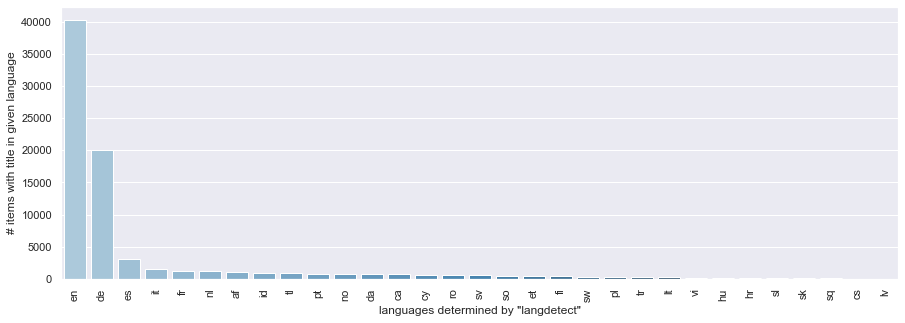

In [36]:
# inspect items w/o language specification -> only numeric !
print(f'cnt of items without language flag: {items_df["title_ld"].isnull().sum()}')
display(items_df[items_df["title_ld"].isnull()].head(10))

# inspect results
ld_vc = pd.DataFrame(items_df['title_ld'].value_counts().reset_index())
display(ld_vc.transpose())

# show barplot with # items with title in given language
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='index', y='title_ld', ax=ax, data=ld_vc, palette=palette_blue).set(
    xlabel='languages determined by "langdetect"', 
    ylabel='# items with title in given language'
)
plt.xticks(rotation=90)
plt.show()

##### guess_language (=title_gl)

- Can detect very short samples

In [37]:
from guess_language import guess_language

In [38]:
print(guess_language(str_en))
print(guess_language(str_de))

en
de


In [39]:
if recompute_lg_flg:

    # get start time for performance evaluation
    start_time_gl = time.time() 

    # detect langauge of titles 
    items_df['title_gl'] = items_df['title'].apply(lambda x: guess_language(x) if not x.isnumeric() else None)

    # set 'UNKNOWN' to None
    items_df.loc[items_df['title_gl']=='UNKNOWN','title_gl'] = None

    # compute execution time
    end_time_gl = time.time()
    print(f'exection time guess_language: {end_time_gl - start_time_gl} seconds')

exection time guess_language: 16.25499725341797 seconds


0      1     2     3     4     5     6    7    8    9   ...  39  \
index        en     de    es    af    fr    it    da   pt   ca   nb  ...  hr   
title_gl  20861  10632  2254  1351  1165  1160  1094  895  728  696  ...  41   

          40  41  42  43  44  45  46  47  48  
index     so  tr  sw  ss  zu  xh  ts  az  nr  
title_gl  40  39  35  31  23  14  13   7   7  

[2 rows x 49 columns]

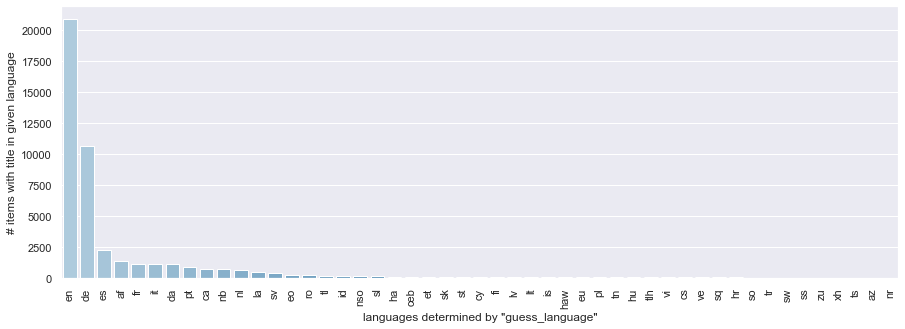

In [40]:
# inspect results
gl_vc = pd.DataFrame(items_df['title_gl'].value_counts().reset_index())
display(gl_vc.transpose())

# show barplot with # items with title in given language
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='index', y='title_gl', ax=ax, data=gl_vc, palette=palette_blue).set(
    xlabel='languages determined by "guess_language"', 
    ylabel='# items with title in given language'
)
plt.xticks(rotation=90)
plt.show()

##### textblob
Requires NLTK package, uses Google -> API blocked with "HTTP Error 429: Too Many Requests"

##### spacy
- [spacy doku](https://spacy.io/universe/project/spacy-langdetect): did not get it working

##### langid (=title_lg)

In [43]:
import langid

In [44]:
langid.classify(str_en)
langid.classify(str_de)

('de', -96.90802240371704)

In [45]:
if recompute_lg_flg:

    # get start time for performance evaluation
    start_time_lg = time.time() 

    # option 1: pre-calculate list of languages
    title_lg = []

    for title in items_df['title']:
        title_lg.append(langid.classify(title))
        print(f'{title}: {langid.classify(title)}')

    # compute execution time
    end_time_lg = time.time()
    print(f'exection time langid: {end_time_lg - start_time_lg} seconds')

    # add col to df
    items_df['title_lg'] = [t[0] for t in title_lg]

    # option 2: use apply
    # items_df['title_lg'] = items_df['title'].apply(lambda x: TextBlob(x).detect_language() if not x.isnumeric() or  else None)

Princess Poppy: The Big Mix Up: ('en', -26.728599548339844)
Einfach zeichnen! Step by Step: ('de', -89.03509426116943)
Red Queen 1: ('en', 2.2995734214782715)
Meine Kindergarten-Freunde (Pirat): ('de', -23.5087833404541)
Mein großes Schablonen-Buch - Wilde Tiere: ('de', -81.07305669784546)
Ewig geliebt: ('nl', -52.890806674957275)
Meine Sticker-Tiere: ('de', -17.901758193969727)
Unsterblich 01 - Tor der Dämmerung: ('de', -109.22954559326172)
Unsterblich 02 - Tor der Nacht: ('de', -86.40718126296997)
Pedro und die Bettler von Cartagena: ('de', -101.90167999267578)
Freundebuch - Einhorn-Paradies - Meine Freunde: ('de', -75.39771890640259)
Die Haushörerin: ('de', -64.62069988250732)
Reiter der schwarzen Sonne: ('de', -95.20795631408691)
WAS IST WAS Quiz Autos: ('sl', -4.719491481781006)
WAS IST WAS Quiz Länder der Welt: ('de', -81.16436004638672)
WAS IST WAS Quiz Fußball: ('de', -22.385029792785645)
Spring in eine Pfütze! Mein perfekter Frühling/ Mein perfekter Sommer. Wendebuch: ('de', -

Tochter der Götter - Glutnacht: ('de', -109.37839221954346)
Tochter der Götter - Schattenweg: ('de', -98.82259607315063)
Tochter der Götter - Eismagie: ('de', -96.38718318939209)
Ich und die Walter Boys: ('de', -31.99302864074707)
Die Pan-Trilogie 02: Die dunkle Prophezeiung des Pan: ('de', -144.57025623321533)
ELFENKRONE: ('en', 9.061840057373047)
Aufstieg und Fall des außerordentlichen Simon Snow: ('de', -217.16602277755737)
Die Pan-Trilogie 01. Das geheime Vermächtnis des Pan: ('de', -141.896879196167)
Harry Potter Boxed Set: The Complete Collection (Adult Paperback): ('en', -25.55742645263672)
Dreamworks Spirit Wild und Frei: Mein großes Malbuch: ('de', -59.88560914993286)
Gamechanger: ('da', 1.3013038635253906)
WAS IST WAS Quiz Pferde: ('de', -21.05688238143921)
Fae - The Sins of the Wyrde: ('en', -77.29751062393188)
Dune - Der Wüstenplanet: ('de', -58.74821710586548)
Fall; or, Dodge in Hell: ('en', 4.215847015380859)
Gregs Filmtagebuch - Endlich berühmt!: ('de', -90.9488306045532

Alle Welt: ('de', -5.590976238250732)
Der Name des Windes. Erster Tag: ('de', -61.25557231903076)
Die Furcht des Weisen. Zweiter Tag Teil 1 und 2: ('de', -133.01932334899902)
Harry Potter and the Philosopher's Stone. Gryffindor Edition: ('en', -88.98396444320679)
Biss zum Abendrot (Bella und Edward 3): ('de', -143.34385013580322)
Die Störung: ('de', -60.58691692352295)
Fun Handlettering: ('fr', 2.534085273742676)
Fühl-Stickerheft: Mein Fühl-Stickerheft - Streicheltiere: ('de', -136.92394065856934)
Sticker-Lexikon. Tierkinder: ('de', -7.586164474487305)
Mein Immer-wieder-Stickerbuch: Wir gehen einkaufen: ('de', -126.99606943130493)
Solaris: ('it', -8.101540088653564)
Plötzlich 14: ('de', -72.60812330245972)
Die Roten Schriftrollen: ('de', -47.710853576660156)
Rebel of the Sands: ('en', -43.611112117767334)
Engelsmorgen: ('de', 1.6720352172851562)
Engelslicht: ('de', -19.27151584625244)
Engelsflammen: ('de', -6.0140886306762695)
Mitmach-Malbuch für Kinder - TIERE: ('de', -72.180984497070

Das Schicksal der Zwerge: ('de', -40.795499324798584)
Die Rache der Zwerge: ('de', -42.790432929992676)
Die Zwerge: ('de', -8.805590629577637)
Die Rache der Zwerge: ('de', -42.790432929992676)
Backen mit PAW Patrol: ('de', -43.1591100692749)
A Hat Full of Sky: ('en', -9.13144588470459)
The Vampire Diaries: Stefan's Diaries #1: Origins: ('en', -37.545429706573486)
The Vampire Diaries: Stefan's Diaries #2: Bloodlust: ('en', -56.95745038986206)
Skeleton Key Graphic Novel: ('en', -3.251588821411133)
Eine Woche voller Glück, Mädchen, Farbe Rosa: ('de', -156.92477226257324)
Meine liebsten Anziehpuppen-Stickerbücher mini: ('de', -94.31925678253174)
Der Zahlenteufel: ('de', -50.83933687210083)
Der Junge auf dem Berg: ('de', -98.0949878692627)
Magnus Chase: Magnus-Chase-Schuber (3 Bände im Taschenbuch-Schuber): ('de', -125.44813871383667)
Das MARVEL Buch: ('de', -6.965281009674072)
Fantastic Beasts: The Crimes of Grindelwald - The Original Screenplay: ('en', -128.06993913650513)
Das Buch der ge

The Chronicles of Narnia 2. The Lion, the Witch and the Wardrobe: ('en', -173.60930013656616)
Hidden Worlds 2 - Die Krone des Erben: ('de', -71.83485698699951)
Fever of the Bone: ('en', -42.151885986328125)
Beneath The Sugar Sky: ('en', -30.713383197784424)
Winner Is ...Next Best Junior Chef Series, Episode 3: ('en', 9.061840057373047)
Erben der Ewigkeit: ('de', -70.6846284866333)
I Love My Dad Ich habe meinen Papa lieb: English German Bilingual Book: ('de', -85.80821752548218)
Die Schule der magischen Tiere: Endlich Pause! Das große Rätselbuch: ('de', -201.1244683265686)
Bilderrätsel. Über 150 Rätsel für Kinder ab 8 Jahren. Labyrinthe, Suchbilder, Wimmelbilder, Finde-de: ('de', -184.56237411499023)
All the Bright Places: ('en', -18.992087841033936)
Wütender Sturm (Die Farben des Blutes 4): ('de', -90.72707319259644)
Die rote Königin (Die Farben des Blutes 1): ('de', -109.23153638839722)
WOW! Das Metallic-Stickerbuch - Dinos: ('de', -32.018871784210205)
Vri Il: ('mt', -5.81447410583496

Wie man seine Eltern erzieht (Eltern 1): ('de', -94.13402700424194)
A Court of Mist and Fury: ('en', -27.652089595794678)
A Court of Thorns and Roses: ('en', -38.59543704986572)
Der Dieb von Rom: ('de', -41.59367656707764)
Der Wüstenplanet: ('de', -39.40252876281738)
Mein liebstes Oster-Puzzlebuch: ('de', -58.163214683532715)
Mein superdicker Mal- und Bastelblock. Lustiger Osterspaß: ('de', -126.48466205596924)
Der Thron der Finsternis: ('de', -46.37714242935181)
Matilda: ('et', 0.5794053077697754)
Sophiechen und der Riese: ('de', -46.06855392456055)
Charlie und die Schokoladenfabrik: ('de', -74.84666061401367)
The Lord of the Rings: ('en', -63.15556240081787)
Malen nach Zahlen ab 5 Jahren: Süße Tiere: ('de', -175.4513144493103)
Brennender Fels: ('de', -13.702650547027588)
Steinerner Himmel: ('de', -8.906273365020752)
Unterm Leichentuch: ('de', -40.01339101791382)
Malen nach Zahlen ab 7 Jahren: Im Meer: ('de', -127.98471879959106)
Kings of Chaos (3). Bleib locker, Stinktier!: ('en', -5

Neon Birds: ('en', 9.061840057373047)
The Silmarillion: ('en', -30.354563236236572)
The Tolkien Treasury: Roverandom, Farmer Giles of Ham, The Adventures of Tom Bombadil, Smith of Woot: ('en', -155.81968307495117)
Das magische Archiv (Der filmische Zauber von Phantastische Tierwesen: Grindelwalds Verbrechen): ('de', -255.45264148712158)
Eclipse: ('en', 9.061840057373047)
Mein großes Anziehpuppen-Stickerbuch: Auf dem Reiterhof und Beim Reitturnier: ('de', -182.1902666091919)
Harry Potter 1 à l'école des sorciers: ('fr', -99.93118572235107)
Rule of Wolves: ('en', -9.769436836242676)
Verstoßene des Lichts: ('de', -81.37137937545776)
Enola Holmes: The Case of the Missing Marquess - As seen on Netflix, starring Millie Bobby Brown: ('en', -139.19386959075928)
Ein Baum voller Geheimnisse: ('de', -39.596848011016846)
Der magische Lernkoffer Piraten: ('de', -56.747894287109375)
Alles über Piraten: ('de', -74.63547611236572)
Simon vs. the Homo Sapiens Agenda: ('en', -53.08387279510498)
The Great

Glitzerzauber-Malblock Einhörner: ('de', -102.37234592437744)
Malblock - Tiere im Zoo: ('de', -20.66054630279541)
Glitzer-Malblock Feen: ('eu', -11.414926767349243)
Nella Nixe: Meereszauber-Malblock: ('hu', -48.06306552886963)
Die Sockensuchmaschine: ('de', -27.53284502029419)
Momo: ('en', 9.061840057373047)
Mein erstes Buch - Die Welt: ('de', -90.77613973617554)
333 Origami - Falten und Spielen: ('de', -33.79668426513672)
Mein erstes Dino-Bastelbuch: ('de', -72.02920532226562)
The Fever Code: ('en', -5.720769882202148)
Türkisch für Anfänger 01: Meine verrückte Familie: ('de', -237.99717664718628)
Meine Kindergarten-Freunde (Einhorn): ('de', -45.98912000656128)
Daughter of Chaos (Chilling Adventures of Sabrina, Novel 2), Volume 2: ('en', -93.71347713470459)
Season of the Witch (Chilling Adventures of Sabrina: Netflix tie-in novel): ('en', -111.24275922775269)
Children of Virtue and Vengeance: ('en', -46.57954740524292)
Die schlechtesten Flachwitze der Welt: ('de', -144.29374837875366)


The Hogwarts Library Box Set: ('en', -42.63679599761963)
The Foreigner's Tale: ('en', -20.240529537200928)
The Amazing Maurice and His Educated Rodents: ('en', -42.328378677368164)
Gläsernes Schwert (Die Farben des Blutes 2): ('de', -123.59281873703003)
Amelia Bedelia Chapter Book #10: Amelia Bedelia Ties the Knot: ('en', -22.92414426803589)
Die Spur der Wölfin: ('de', -69.08271265029907)
Alphawölfin: ('vo', -23.53131127357483)
Verfluchtes Drachenherz: ('de', -50.342483043670654)
Engelslust: ('de', -8.171584129333496)
Beast Lovers: ('en', 3.044527053833008)
Was Preema nicht weiß: ('de', -37.835078716278076)
Goldilocks: ('ro', 1.0580062866210938)
Star Wars: Thrawn Ascendancy (Book II: Greater Good): ('en', -67.26304054260254)
Haus aus Salz und Tränen: ('de', -104.89172744750977)
The Lord of the Rings Boxed Set. 60th Anniversary edition: ('en', -84.6484580039978)
Kakaoherz & Listenliebe: ('de', -27.589180946350098)
The Winter Fae: ('en', -5.720769882202148)
Passwort zur Seele: ('de', -36

Pferdefreunde: Sticker: ('de', -12.777673244476318)
Witze & Denkspiele: ('eu', -37.153101205825806)
Hobbitus Ille: ('mt', -12.142104625701904)
Ein Vampir zum Vernaschen: ('de', -102.40959548950195)
Mein erstes Entdecker-Klappenbuch: Im Garten: ('de', -85.81818199157715)
The Storm Keepers' Battle: ('en', -5.720769882202148)
Die Zauberer 03: ('de', -33.56897735595703)
Der Schwur der Orks: ('de', -58.83559465408325)
Die Zauberer: ('de', -25.791804313659668)
Die Ehre der Orks: ('de', -39.98592710494995)
Die Herrschaft der Orks: ('de', -75.53517436981201)
Die Könige: ('de', -49.38699722290039)
Die Zauberer 02: ('de', -33.56897735595703)
Kampf der Könige: ('de', -63.33124113082886)
Sieg der Könige: ('de', -78.46982145309448)
Das Gesetz der Orks: ('de', -74.95432090759277)
Die Chroniken von Araluen - Die Verschwörung von Gallica: ('de', -249.55972909927368)
Das dunkle Herz des Waldes: ('de', -106.36192512512207)
Verlangen wider Willen   Erotische Geschichten: ('de', -168.3422451019287)
Traumt

Feuerwehrmann Sam: Kindergartenfreundebuch: ('de', -48.59442710876465)
Black Dagger 23. Nachtherz: ('de', -66.49515628814697)
Freundebuch - Alle meine Kindergartenfreunde - Pferdefreunde: ('de', -75.789541721344)
Meine Kindergarten-Freunde (Ponys): ('de', -33.447556495666504)
Kisses from Hell: ('en', -15.514898300170898)
Insel der blauen Delfine: ('de', -59.88681888580322)
The Star-Touched Queen: ('en', -5.720769882202148)
Der Hobbit: ('de', -16.230733394622803)
Gezähmt: ('fi', -23.227423667907715)
Der Untergang der Könige: ('de', -106.13818788528442)
Paw Patrol. Abenteuer zum Aufstecken: ('de', -97.09305953979492)
PAW Patrol Malbuch: ('en', 0.41760921478271484)
Die Geheimnisse des Nicholas Flamel 01. Der unsterbliche Alchemyst: ('de', -143.13903713226318)
LEGO® Star Wars(TM) Die Dunkle Seite: ('de', -76.58935070037842)
Die Uhr und die Zeit: ('de', -71.67584705352783)
WAS IST WAS Junior Band 29. Uhr und Zeit verstehen: ('de', -96.59453821182251)
WAS IST WAS Stickerheft Weltraum: ('de',

Top Secret 10 - Das Manöver: ('sv', -49.619688987731934)
Top Secret 09. Der Anschlag: ('de', -57.01988744735718)
Trügerisch: ('de', -33.13451814651489)
Samurai, Band 1: Der Weg des Kämpfers: ('de', -102.93518733978271)
Der Fall von Gondolin: ('de', -73.91129636764526)
Der kleine Maulwurf: Malen Stickern Gestalten: ('de', -80.71849393844604)
Drachentanz: ('de', -10.513158798217773)
FOREVER SUMMER: ('en', 9.061840057373047)
Influence: ('en', 9.061840057373047)
Mein kleines Abc-Malbuch mit Rabe Linus: ('de', -72.0021595954895)
Die Abenteuer von Aguila und Jaguar: ('de', -114.2582540512085)
Tintenwelt-Schuber: ('de', 1.3605341911315918)
Tintenherz: ('de', -13.24598741531372)
Die Mondkönigin: ('de', -42.435364723205566)
Malen und Rätseln - Übungen für die Vorschule (5+): ('de', -228.434645652771)
Meine Kindergarten-Freunde Fahrzeuge: ('de', -51.11963081359863)
Welt der Spiegel: ('de', -57.8626823425293)
Lost Dreams: ('es', 0.7331290245056152)
Fensterbuch Der kleine Maulwurf: ('de', -65.5125

Harry Potter and the Philosopher's Stone. Slytherin Edition: ('en', -86.64924335479736)
Dungeon Master's Screen - Das Verlies des wahnsinnigen Magiers: ('de', -140.0183129310608)
Spektrum: ('en', 9.061840057373047)
The Edge Chronicles 6: Midnight Over Sanctaphrax: ('en', -40.64137315750122)
Meine Kindergarten-Freunde (Feen): ('de', -23.5087833404541)
Let's play, Mom! (Greek edition): ('en', -7.2565531730651855)
Vril, the Power of the Coming Race: ('en', -63.42707347869873)
Always and Forever, Lara Jean: ('en', -28.99969482421875)
Warhammer 40.000 - Die Verlorenen Band 02: ('de', -70.8612790107727)
NACHWELT 2018: ('en', 9.061840057373047)
LEGO® Jurassic World - Rätselspaß für Dinofans: ('de', -164.34448719024658)
Die verlorene Welt: ('af', -47.617234230041504)
Die vergessene Welt: ('de', -55.75169897079468)
Die Feenkönigin Isolde: ('de', -42.435364723205566)
Duden A bis Z und 1 bis 10: ('de', -63.75404357910156)
Meine Kindergartenfreunde: ('de', -16.412896156311035)
Five Nights at Fredd

Outlines: ('en', 9.061840057373047)
Ein Vampir und Gentleman: ('de', -47.3467493057251)
Eine Vampirin auf Abwegen: ('de', -77.6504635810852)
X3: Hüter der Tore: ('de', -45.94785499572754)
Loki: Where Mischief Lies: ('de', -28.271430492401123)
Von Kröt, P.I. in Das Quaken der Nachtigall: ('de', -147.82901000976562)
Die Flattermaus: ('de', -14.72883415222168)
Der Glanz der Dunkelheit: ('de', -65.20266342163086)
GEOlino Wadenbeißer - Verzwickte Krimi-Comics zum Lesen & Mitraten Band 7: ('de', -226.25462198257446)
Der Fotograf von Auschwitz: ('de', -74.08298587799072)
Kreativ-Set Steine bemalen für Kinder (Buch + Material): ('de', -88.94761276245117)
Warrior Cats - 06/3 Vision von Schatten. Zerrissene Wolken: ('de', -102.34953498840332)
Der Drachenflüsterer: ('de', -65.93718242645264)
Die Chronik des Eisernen Druiden 07. Erschüttert: ('de', -122.88078165054321)
Chris, der größte Retter aller Zeiten: ('de', -98.80201578140259)
Die Abrichtung 2   Erotischer SM-Roman: ('de', -106.684486865997

The Absolutely True Diary of a Part-Time Indian: ('en', -84.78110790252686)
1000 Gefahren in der Schule des Schreckens: ('de', -106.3144040107727)
Die Pyramide der 1000 Gefahren: ('de', -63.43515491485596)
By Your Side: ('en', 9.061840057373047)
Der Turm der Lichter: ('de', -61.9056339263916)
Die Feuerwehr: ('de', -44.45097637176514)
Unser Baby: ('en', 1.639256477355957)
Charlie and the Chocolate Factory: ('en', -68.05394506454468)
Disney: Zauberhafte Bastelideen: ('de', -62.69753646850586)
A Little Princess: ('en', 2.0162367820739746)
Tänzerin im Schatten: ('de', -58.06399583816528)
Tödliches Spiel (Schattengänger 16): ('de', -110.0582914352417)
Geliebte Feindin: ('de', -5.676112651824951)
Schattenschwestern: ('de', -32.27411985397339)
Fesseln der Nacht: ('de', -40.780099868774414)
Beschützer der Diebe: ('de', -87.13111162185669)
Die Invasion: ('af', -19.02492618560791)
Die letzte Königin - Die Seele des Feuers: ('de', -166.33351516723633)
Elbisch für Anfänger: ('de', -135.03721904754

Die Schule der magischen Tiere: Meine Freunde (Freundebuch): ('de', -139.65330600738525)
Obsidian 1: Obsidian. Schattendunkel: ('de', -14.096478939056396)
Der kleine Maulwurf Malbuch 100 Seiten: ('de', -69.35529375076294)
Imago: ('en', 9.061840057373047)
Ready Player Two: ('en', 9.061840057373047)
LEGO Ninjago Das große Stickerbuch: ('de', -69.39586591720581)
Geweihte des Todes: ('de', -35.56600999832153)
Midnight Breed 10. Erwählte der Ewigkeit: ('de', -112.14669370651245)
Dunkles Schicksal: ('en', -4.103115558624268)
Vittorio: ('en', 2.0162367820739746)
Night Rebel 3 - Gelübde der Finsternis: ('de', -58.41386938095093)
Ein Vampir im Handgepäck: ('de', -52.673614501953125)
Vampir on the Rocks: ('en', -30.185551643371582)
Emilys Reise: ('de', -4.952554702758789)
Toradora! (Light Novel) Vol. 1: ('es', -26.631065368652344)
Leviathan erwacht: ('de', -40.87141561508179)
The Dragon Stoorworm: ('en', -5.720769882202148)
Feuerwehrmann Sam: Mein Wimmel-Suchbuch mit Feuerwehrmann Sam: ('de', -1

Fantastic Beasts and Where to Find Them: ('en', -91.50637722015381)
Im Bann der Jägerin: ('de', -48.55848789215088)
Obsidian 02: Onyx. Schattenschimmer (mit Bonusgeschichten): ('de', -142.18623113632202)
Chasing Darkness. Das Herz eines Dämons: ('de', -93.67034816741943)
Disney Raya und der letzte Drache Das offizielle Buch zum Film: ('de', -280.8765139579773)
Das Schicksal der Rose: ('de', -40.795499324798584)
Die geheimnisvolle Insel: ('af', -42.38787317276001)
Die Unsichtbaren: ('de', -30.358967304229736)
Maximum Ride 09: Forever: ('de', 2.068460464477539)
Twilight: ('en', 9.061840057373047)
Die Tänzerin am Abgrund: ('de', -93.95800638198853)
My Bullet Journal zum Ausfüllen und Gestalten: ('de', -133.66507387161255)
Mystic Highlands 5: Feenhügel: ('de', -47.40156936645508)
Gesammelte Werke 6: ('de', -52.33858680725098)
Ich, Caesar, und die Bande vom Kapitol, Live aus dem alten Rom: ('de', -192.12493753433228)
Der Kleine Prinz: Mein Malbuch: ('de', -41.31152105331421)
b.b. free: ('en

Eine Tüte grüner Wind: ('de', -54.865586280822754)
The Incredible Record Smashers: ('en', -24.7078857421875)
Sterntagebücher: ('de', -31.82833480834961)
Fingerstempeln: Tiere: ('de', -45.46798372268677)
See You in the Cosmos: ('en', -28.587233066558838)
Zu Hause redet das Gras: ('de', -55.60195589065552)
Tiger Eyes: ('da', -11.711336135864258)
Hunter Legacy - Düstere Leidenschaft: ('de', -85.17567682266235)
Namenlose Kulte: ('et', -15.99724531173706)
Chillen macht den Meister: ('de', -89.58185625076294)
Dinos - Meine Kindergarten-Freunde: ('de', -45.37378692626953)
Banshee Livie 02: Weltrettung für Fortgeschrittene: ('de', -188.5589690208435)
Mein großes "Ich kann zeichnen!"-Buch: ('de', -100.67287921905518)
Kratzle dich schlau - Erste Buchstaben: ('de', -179.3137264251709)
Simone de Beauvoir: ('fr', -55.01101875305176)
AWOL 01 - Agent Without Licence: Last, Best Hope: ('en', -17.120169639587402)
The Powerpuff Girls: Mission Impuffable: ('en', -20.239877700805664)
Chronicles of Narnia 

The Lost Puppy: ('en', -24.387800216674805)
The Chocolate Factory Ghost: ('en', -20.852417469024658)
Serafina and the Seven Stars: ('en', -50.57304239273071)
Lady Smoke: ('en', -9.247757911682129)
Dreams of Gods and Monsters: ('en', -52.35763692855835)
Good Omens: ('sv', -0.813328742980957)
WAS IST WAS Kindergarten Band 19 Im Garten: ('de', -21.377870082855225)
Aktiya: ('en', 9.061840057373047)
Schatten über Innsmouth: ('de', -70.62018013000488)
A Bear Grylls Adventure 5: The River Challenge: ('en', -26.956361293792725)
Meine kleine Tiermalschule: ('de', -40.94092082977295)
Der schwarze Mönch: ('de', -90.41813135147095)
Password: ('en', 9.061840057373047)
Warrior Cats - Special Adventure. Gelbzahns Geheimnis: ('de', -31.74300527572632)
Liliane Susewind - Ein Pinguin will hoch hinaus: ('de', -136.44319248199463)
Liliane Susewind - Schimpansen macht man nicht zum Affen: ('de', -141.3452548980713)
The City of Brass: ('en', -44.1527886390686)
Fünf Hunde im Gepäck: ('de', -54.06118059158325

Elias & Laia - Die Herrschaft der Masken: ('de', -109.75271892547607)
Kritzkratz-Spaß für Jungs: ('de', -126.88417053222656)
World of Warcraft: Wolfsherz: ('en', -59.263214111328125)
World of Warcraft - Weltenbeben: ('en', -106.30023765563965)
The Miseducation of Cameron Post: ('en', -49.170867919921875)
The Alchemists of Loom: ('en', -61.546473026275635)
Elian und Lira - Das wilde Herz der See: ('de', -117.52914714813232)
Mein Immer-wieder-Stickerbuch: Traktoren und Laster: ('de', -45.573182582855225)
Mein Immer-wieder-Stickerbuch: Bagger und Kräne: ('de', -95.80215692520142)
Legion: The Many Lives of Stephen Leeds: ('en', -63.95999193191528)
Eragon 04 - Das Erbe der Macht: ('de', -62.31370401382446)
Eragon 01. Das Vermächtnis der Drachenreiter: ('de', -125.18113708496094)
The Three-Body Problem 1: ('en', -15.206050872802734)
The Martian: ('en', -5.720769882202148)
The City in the Middle of the Night: ('en', -106.38477420806885)
Star Wars: Schatten der Königin: ('de', -93.173286437988

The Elder Scrolls Online - Volumes I & II: The Land & The Lore (Box Set): ('en', -79.66162633895874)
LUCE: ('en', 9.061840057373047)
The Discworld Atlas: ('en', -11.785380840301514)
REBEL AGENT - Fluchtpunkt New York -: ('de', -4.164000511169434)
Die Verratenen: ('de', -21.848022937774658)
Was wäre wenn: ('de', -37.95334529876709)
Running Man: ('en', 0.9259052276611328)
Der Clan der Otori 01. Das Schwert in der Stille: ('de', -119.86021184921265)
Bodyguard 03 - Der Hinterhalt: ('de', -49.138333797454834)
Wonderland: ('nl', 1.2923011779785156)
Der Scherbensammler: ('de', -34.65901756286621)
Mister Bodyguard: ('en', 9.061840057373047)
Karlchen - Mein Kindergarten-Freundebuch: ('de', -34.4379358291626)
Monument 14: Die Rettung (3): ('de', -47.446024894714355)
Der letzte Zauber: ('de', -83.26459836959839)
Der Sünder: ('de', -22.824474811553955)
Tommy Mütze: ('de', -37.25165510177612)
Der Sprachabschneider: ('de', -42.47533130645752)
Hör mal: Die Jahreszeiten: ('de', -144.84038591384888)
St

LEGO® Ideen Lifehacks: ('ku', -24.730311632156372)
Mein großer Suchrätselspaß: ('de', -93.05270290374756)
Der Krieg: ('de', -20.820922374725342)
Zieh den Stecker! - 100 Ideen ohne Bildschirm: ('de', -101.12914371490479)
A Touch of Gold: ('en', -9.446395874023438)
Das Jungs-Buch: Der ganze Kram, den du mit 12 wissen solltest: ('de', -178.66582012176514)
City of Elements 3: ('en', -43.124518394470215)
Queen of Air and Darkness: ('en', -51.05458211898804)
Lady Midnight: ('en', 9.061840057373047)
Lord of Shadows: ('en', -24.546128273010254)
Tschipo in der Steinzeit: ('de', -101.37778663635254)
Oskar und das geheimnisvolle Volk: ('de', -85.1978325843811)
Mein Haferhorde-Freundebuch: ('de', -18.40429162979126)
Das Jahr, in dem ich lügen lernte: ('de', -127.72869348526001)
Dragonsitter Trouble: ('fi', -4.76784610748291)
Persepolis Rising: ('en', -4.7202677726745605)
Secrets in the Fire: ('en', -41.53476810455322)
Kommissar Schlotterteich: Watch out! - In London auf Verbrecherjagd: ('de', -133

Die kleine Eule: ('de', -25.516249179840088)
Marvel's SPIDER-MAN: Hostile Takeover: ('en', -6.4049506187438965)
The Chronicles of Narnia. Adult Edition: ('en', -36.86562728881836)
Dämonentage: ('sv', -26.57297658920288)
Letters from Father Christmas: ('en', -34.918832778930664)
The Tombs of Atuan: ('en', -30.0000958442688)
The Best of Michael Marshall Smith: ('en', -64.11758518218994)
The Memory Police: ('en', -11.284820079803467)
Jon's Football Team - Read it yourself with Ladybird: Level 1: ('en', -57.17303514480591)
Mein großes Anziehpuppen-Stickerbuch: Action! und Eiskunstlauf: ('de', -109.9993805885315)
Diez Perros En La Tienda: ('es', -72.9943208694458)
Endlich Vorschule! Mein Lernspielblock - Konzentrationsrätsel: ('de', -148.62825345993042)
Das Strickliesel-Buch: ('de', -13.416821479797363)
Midnight Bites - Tales of Morganville: ('en', -47.73320198059082)
Seeland. Per Anhalter zum Strudelschlund: ('de', -91.87565755844116)
Die Meisterin: ('de', -22.754008769989014)
Die Meisteri

The Girl of Ink & Stars: ('en', -18.575072288513184)
Saving Zoe: ('en', 1.946000099182129)
Drachen - Die geflügelten Bestien: ('de', -119.35129499435425)
Die Schiffe: ('de', -8.805590629577637)
Mit anderen Worten: ich: ('de', -42.58730697631836)
Mein Sommer mit Mucks: ('de', -40.04198741912842)
So fern wie nah: ('de', -51.27519083023071)
Mandala Malzauber: ('en', 9.061840057373047)
Ich sehe was ...Schatzsuche: ('en', -101.09860563278198)
Alles über Pferde und Ponys: ('de', -120.47881984710693)
Göttlich - 3 Bände im Schuber: ('de', -106.21857213973999)
memo Quiz. Fußball: ('de', -25.769780158996582)
Hard Frost: ('en', 9.061840057373047)
Nijura - Das Erbe der Elfenkrone: ('de', -75.48575639724731)
Verloren in Eis und Schnee: ('de', -69.11886262893677)
LEGO® Star Wars(TM) Lexikon der Figuren, Raumschiffe und Droiden: ('de', -122.47578382492065)
Ein Schatten wie ein Leopard: ('de', -100.8031153678894)
Eragon 02. Der Auftrag des Ältesten: ('de', -81.2915244102478)
Und wenn schon: ('de', -17

Freundschaftsbuch für allerallerbeste Freunde: ('de', -143.52923440933228)
Meine Freunde: ('de', -10.362565517425537)
Kringel, Klecks und Schnörkel - Das bunte Doodle-Buch zum Weitermalen: ('de', -168.113347530365)
A Psalm for the Wild-Built: ('en', -23.974133014678955)
To Be Taught, If Fortunate: ('en', -14.416751861572266)
Soul Mates, Band 1: Flüstern des Lichts: ('de', -75.24451065063477)
Ravensburger Buch - Sticker-Kreuzworträtsel, 2.LS grün: ('de', -104.64210748672485)
Zirkus: ('de', 0.4543418884277344)
Der Herr der Ringe - Die zwei Türme Neuausgabe 2012: ('de', -159.70532703399658)
ABC: ('en', 9.061840057373047)
Mein erstes Stickerbuch: Auf dem Bauernhof: ('de', -130.757719039917)
Detektivbüro LasseMaja. Doppelband 01: ('de', -61.80256652832031)
Fantastic Beasts and Where to Find Them. The Original Screenplay: ('en', -135.08270168304443)
The Princess Bride: ('en', -12.330088138580322)
Midnight Breed 04. Gebieterin der Dunkelheit: ('nl', -71.27911901473999)
Beasts of Abigaile Vol.

Catch My Fall: ('en', 3.4079065322875977)
Star Wars: Das Buch der Kopfgeldjäger: ('de', -118.85802221298218)
Fette Fische: ('de', -15.219319820404053)
Behind the Open Door: ('en', -27.770803451538086)
The Adventures of Dog Man 2: Unleashed: ('en', -59.62777280807495)
Simpel: ('pt', 0.9147238731384277)
Nicht mit mir!: ('de', -41.94461107254028)
Die Bestimmung - Fours Geschichte: ('de', -108.31175661087036)
Initium et finis (principio y fin): ('la', -81.38485765457153)
Mein Esel Benjamin: ('ms', -75.85116910934448)
Mein Dezemberbuch: ('de', -21.230073928833008)
Frøken Superpromp!: ('no', -32.244486808776855)
Zoom to the Moon: A Bloomsbury Young Reader: ('en', -49.517982482910156)
Merlin, der Tierfreund: ('de', -18.69951295852661)
A Court of Wings and Ruin: ('en', -47.199363708496094)
Mind Games: ('en', 4.797717094421387)
Somorra - Stadt der Lüge: ('de', -69.81907844543457)
Entkommen! - Die geheime Bibliothek: ('de', -68.3760199546814)
Pretty Little Liars 16: Vicious: ('en', -54.178271770

Dungeons & Dragons Einsteigerset: ('de', -85.2579607963562)
Glanzvolle Folienbilder. Prinzessinnen: ('de', -29.18151092529297)
Secret Protector, Band 2: Mörderische Erpressung: ('de', -113.01037120819092)
Alphas Versuchung: ('en', -13.960234642028809)
Alphas Krieg: ('en', -16.897727012634277)
When Hitler Stole Pink Rabbit: ('en', -37.50762891769409)
Gilde der Jäger 03. Engelsblut: ('de', -74.82487440109253)
Archenemies: ('de', -10.916706085205078)
Misguided Angel: ('en', -12.172283172607422)
Pandemonium: ('en', -7.550365447998047)
So I'm a Spider, So What?, Vol. 11 (light novel): ('en', -26.027512073516846)
Kreativ-Set Meine bunte Strickliesel: ('de', -15.720300197601318)
The Maze Runner 3. The Death Cure: ('en', -50.8439679145813)
Die Schattenbrücke - Jenseits der Klippe: ('de', -128.2973427772522)
Supergute Tage oder Die sonderbare Welt des Christopher Boone: ('de', -132.45179414749146)
Vorlagenmappe 3 in 1 - Folien-Fensterbilder mit dem Kreidemarker - Für Kinder. Inkl. 5 Fensterfoli

Love, Creekwood: ('en', 9.061840057373047)
Die Musik der Stille: ('de', -37.1788763999939)
Das Heer des Weißen Drachen: ('de', -95.25843095779419)
Das Erwachen des Feuers: ('de', -68.58791923522949)
Theo Boone - Unter Verdacht: ('de', -31.965111255645752)
The Watchers - Wissen kann tödlich sein: ('de', -165.78341341018677)
Das Vermächtnis des Erfinders - Timmi Tobbsons zweites Rätselabenteuer: ('de', -198.36639881134033)
Frag doch mal ... die Maus!: Baustelle: ('de', -81.44600343704224)
Little Miss Florida: ('en', 2.0162367820739746)
Mein bunter Osterblock: ('de', -2.967029571533203)
Satans Versprechen (Hell's Love 1): ('en', -73.53711748123169)
Seabean: ('en', -0.5770244598388672)
Giraffe und dann ab ins Bett!: ('de', -47.433714389801025)
Soul Song: ('en', 9.061840057373047)
Robots versus Slime Monsters: ('en', -14.136850833892822)
Princess at Heart: ('en', -9.000201225280762)
Das Geheimnis des Kartenmachers: ('de', -84.74714469909668)
The Left Hand of Darkness: ('en', -48.12931823730

LEGO® DC Superheroes - Rätselspaß für Superhelden: ('de', -178.37055110931396)
Der kleine Pirat - Mein Malbuch: ('de', -52.36837100982666)
LEGO® City - Auf dem Weg ins All: ('de', -101.5995626449585)
Das verlorene Tal: ('de', -33.37394046783447)
Zentangle für Kids Waldtiere: ('de', -87.49232864379883)
Magic Academy 1 - Das erste Jahr: ('de', -101.90608978271484)
Magic Academy - Die Prüfung: ('de', -73.62934684753418)
Queen of Nothing: ('en', -30.646207809448242)
IZARA - Das ewige Feuer: ('de', -52.26704978942871)
Die goldene Göttin - Das Schwert der Wahrheit: ('de', -139.8116970062256)
Der Ozean am Ende der Straße: ('de', -79.85498285293579)
Sanguis Corvi - Das Blut des Raben: ('de', -50.05943155288696)
Der Lotuskrieg 1: ('no', -41.46484613418579)
Der kleine Rabe Socke: Mein extradickes Schulstart-Heft: ('de', -73.2708568572998)
Der kleine Rabe Socke: Mein erstes Schuljahr: ('de', -117.25569772720337)
Der Dreizehnte Stamm: ('de', -27.879507064819336)
Die Rückkehr zur Erde: ('de', -118.

Yes, No, or Maybe? (Light Novel): ('en', 2.816892147064209)
Graveyard Shift: ('en', 0.013758659362792969)
Das Hin-und-weg-Stickerbuch. Pferde und Ponys: ('de', -68.18249940872192)
Conni Gelbe Reihe: Rechnen lernen mit Sticker-Spaß: ('de', -110.77139568328857)
The Summer I Turned Pretty: ('en', -38.746211528778076)
Le petit Nicolas: ('it', -19.74776029586792)
Babar's ABC: ('en', 2.7246785163879395)
Mehr als ein Spiel: ('de', -42.71583271026611)
The Adventures of Bottersnikes and Gumbles: ('en', -74.80915832519531)
Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 7: ('de', -31.084285736083984)
American Street: ('en', 2.220953941345215)
Die drei ???: und der Karpatenhund: ('de', -82.97491693496704)
Vicious: ('es', -9.189036846160889)
The City We Became: ('en', -17.914119720458984)
Magnus Chase 2: Der Hammer des Thor: ('de', -78.02485704421997)
Star Wars(TM) Lexikon der Raumschiffe und Fahrzeuge: ('de', -110.04775190353394)
Hex: ('en', 9.061840057373047)
Näh mit! Das große Ideenbuc

Weathering With You: ('en', -7.946361064910889)
Harry Potter Harry Potter and the Chamber of Secrets. Gryffindor Edition: ('en', -90.93602848052979)
The Irish Cinderlad: ('en', -13.988747596740723)
SCHLEICH® Horse Club - Eine gelungene Überraschung: ('de', -144.97652006149292)
Das einzig wahre Buch für Großeltern und ihre Enkel. Alles, was Kinder lieben. Spiele für drinnen un: ('de', -476.90265130996704)
Mule School: ('en', 9.061840057373047)
Das Leuchten der Magie: ('de', -85.61204195022583)
Living Forever: ('en', 1.946000099182129)
Septimus Heap 06. Darke: ('en', 9.061840057373047)
Two Can Keep a Secret: ('en', 4.065707683563232)
Tiger lernt Golf spielen: ('nb', -47.66395425796509)
Die Wikinger: ('de', -23.968239784240723)
Meine erste Bibel: ('de', -60.317320346832275)
Network Effect: A Murderbot Novel: ('en', 9.061840057373047)
The Fakeland Bestseller: ('en', -22.634883403778076)
Helden des Olymp 02: Der Sohn des Neptun: ('de', -91.01311826705933)
Vampire: Die Maskerade Wissen der B

Schwarze Zeichen: ('de', -69.66191482543945)
Rocky and His Responsible Band of Cowboys: ('en', -71.17119455337524)
What's My Color?: ('en', -9.82070779800415)
Nick and Charlie: ('en', -8.530754566192627)
Die Sklavinnen des Sexplaneten   Erotischer Roman: ('de', -95.25986099243164)
The Beginning of Everything: ('en', -41.108386516571045)
PAW Patrol: Spannende Rätsel: ('de', -55.99155282974243)
Warrior Cats Staffel 3/06. Die Macht der drei. Sonnenaufgang: ('de', -168.95566511154175)
Desire of Whimsy: ('en', -34.225120067596436)
The Complete Chronicles of Narnia. Adult Edition: ('en', -45.13643264770508)
Let's Call It a Doomsday: ('en', -29.117091178894043)
December Dreams. Ein Adventskalender: ('de', -43.35227680206299)
Sucher der Magie: Drei Fantasy Romane: ('de', -69.93062400817871)
Siri und die Eismeerpiraten: ('de', -75.67521810531616)
The First Time She Drowned: ('en', -9.404428958892822)
P.S. I Still Love You: ('sv', -8.382218837738037)
Necromunda - Der rote Kardinal: ('de', -24.32

A Master of Djinn: ('en', -21.33163595199585)
The White Giraffe Series: Dolphin Song: ('en', -12.643567562103271)
Inheritance 03. Brisingr: ('en', -6.502163887023926)
Percy Jackson and the Lightning Thief. Film Tie-In: ('en', -77.54856967926025)
Magnus Chase 1: Das Schwert des Sommers: ('de', -64.94426345825195)
HORROR & SCIENCE FICTION direkt aus Unna Königsborn: ('de', -78.76307964324951)
Star Wars(TM) Das letzte Kommando: ('de', -96.26273488998413)
Die Penderwicks im Glück (Die Penderwicks 5): ('de', -173.8061079978943)
Always and Forever, Lara Jean: ('en', -28.99969482421875)
A Drop of Night: ('en', -3.7924623489379883)
I Just Want to Do It My Way!: My Story about Staying on Task and Asking for Help: ('en', -99.6699447631836)
Schattenstürmer Die Chroniken von Siala 02: ('de', -119.97971296310425)
Schattenwanderer. Die Chroniken von Siala 01: ('de', -130.20617723464966)
Donner: ('en', 9.061840057373047)
Kaputte Suppe: ('fr', 1.2139902114868164)
The Best of H. P. Lovecraft: ('en', -3

Folge deinem Herzen: ('de', -104.14174032211304)
Gideon the Ninth: ('en', -17.587828636169434)
Teardrop - Engelsromane 01: ('en', -8.159835815429688)
Luna: ('es', 2.21458101272583)
Since You've Been Gone: ('en', -3.991884708404541)
Kasimir malt: ('fr', -7.1254425048828125)
Face the Change: ('en', -11.730781555175781)
Aus den Filmen zu Harry Potter: Geheimnisvolles Hogwarts: Magischer Kratzspaß (mit Kratzstift): ('de', -254.649169921875)
Disney Best of: Superstarker Sticker- und Malspaß: ('de', -77.20326519012451)
Mein Tier-Stickerbuch: ('de', -12.2308931350708)
Mein Mode-Stickerbuch: Hochzeitskollektion: ('de', -36.643258571624756)
Mein großes Anziehpuppen-Stickerbuch: Traumhochzeit und Brautjungfern: ('de', -131.0736026763916)
Boy: ('en', 9.061840057373047)
The Crimson Skew: ('en', -5.720769882202148)
Reisetagebuch - Reisezeit Kids - Alle meine Abenteuer: ('de', -107.5886607170105)
Trötsch Die Maus Zaubertafelbuch: ('de', -105.1187047958374)
Amy und die geheime Bibliothek: ('de', -71.

Pferde und Ponys: ('de', -44.3999719619751)
Der aus den Docks: ('de', -68.24628067016602)
Assassin's Creed Origins: Der Eid: ('de', -36.73268365859985)
Geostorm The Pioneers: ('en', -37.17447233200073)
Der Sommer, der nur uns gehörte: ('de', -123.71354722976685)
The Vampire Diaries. The Awakening and the Struggle: ('en', -131.22359085083008)
Timm Thaler oder Das verkaufte Lachen: ('de', -99.16790390014648)
Tagebuch mit Reißverschluss - Pferdefreunde: ('de', -81.42876672744751)
Magnus Chase 03 and the Ship of the Dead: ('en', -102.08944892883301)
Pixelspaß: ('de', -17.129526138305664)
Shifting Reality: ('en', -0.435089111328125)
Die Scanner: ('de', -8.805590629577637)
Postkartenset "Bernadette": ('da', -6.516719818115234)
Summerhill: ('de', 1.6009917259216309)
Goldmond: ('en', 9.061840057373047)
Die Farm: ('de', -8.805590629577637)
Dragon Mage: ('en', -8.715819358825684)
The Power of Six: ('en', -25.78777837753296)
Turtles All the Way Down: ('en', -25.857619285583496)
Father Christmas's

Geschichten von natürlichen und unnatürlichen Katastrophen: ('de', -282.7610788345337)
Die verrückte Rätsel-Weltreise: ('de', -128.74166297912598)
Der kleine Heine: Sudoku Rätsel 2: ('de', -64.85938310623169)
Pocket-Rätsel-Block: Unterwegs und Zuhause: ('de', -130.24630498886108)
Divergent 3. Allegiant: ('en', -16.443448066711426)
The Taming Of The Tights: ('en', -26.505180835723877)
The Riyria Revelations: Theft of Swords, Rise of Empire, Heir of Novron: ('en', -129.32741785049438)
Das Geheimnis des Pharaos: ('de', -64.16221284866333)
The Elsewhere Emporium: ('en', -44.40243721008301)
MULAN: Reflections: ('en', 3.6478071212768555)
Bendy and the Ink Machine: ('en', -63.62491321563721)
Red Queen 2-Book Box Set: ('en', 2.2995734214782715)
Zester Z. Zazzlezott: ('eu', -51.13303470611572)
Black Dagger 24. Königsblut: ('sv', -52.14654493331909)
Bitterblue: ('fi', -4.76784610748291)
Mein erster Zeichenkurs - Lieblingstiere: ('de', -144.30460834503174)
Meine Freunde (Ponys): ('de', -27.397225

Vulkan: Lord of Drakes: ('en', -17.226234912872314)
Das Geheimnis des Feuers: ('de', -60.33588647842407)
100 Selbermach-Ideen: ('en', -0.19649028778076172)
Star Wars: Jyn, die Rebellin: ('de', -44.11733961105347)
Kreativ-Kratzelbuch Feenzauber: ('de', -59.18294048309326)
Magische Glitzerfolien - Feenzauber: ('de', -90.45250415802002)
These Happy Golden Years: ('de', -13.956747055053711)
Malory Towers Collection 2: ('en', -7.224708080291748)
Die drei !!! 16: Total verknallt: ('de', -68.25065231323242)
Maluna Mondschein: ('de', -35.957661151885986)
Wicked: ('en', 9.061840057373047)
Jungs verstehen das nicht: ('de', -100.11941528320312)
Mortal Instruments 01. Shadowhunters. TV-Tie-In: ('es', -14.045196533203125)
Ein Lächeln sieht man auch im Dunkeln: ('de', -83.38722038269043)
The 100 02: Day 21: ('en', -5.720769882202148)
Die Spiderwick Geheimnisse - Die Rache der Kobolde: ('de', -104.43547439575195)
Die Spiderwick Geheimnisse 03 - Im Bann der Elfen: ('de', -77.51365327835083)
Spellsling

Hexe Lilli: ('en', 1.4352803230285645)
The Worshippers: ('en', -5.720769882202148)
The Adventures of Tintin. The Black Island: ('en', -57.2570686340332)
Narwhal's Otter Friend: ('en', -4.173781871795654)
Star Wars: From a Certain Point of View: ('en', -65.06002902984619)
Fulfilling Your Trust: ('en', -7.743759632110596)
Der Kuss des Dämons: ('de', -81.29717302322388)
Erstes Stickern Bauernhof: ('de', -26.16024398803711)
Peppa Pig Rätseln Stickern Basteln: ('sv', -37.08925676345825)
Peppa: Mein liebster Malspaß: ('de', -45.76399326324463)
Tiere zeichnen - Schritt-für-Schritt: ('de', -152.21172666549683)
Schritt für Schritt Zeichnen lernen. Lustige Tiere: ('de', -271.76143169403076)
Erstes Lernen. Traktor, Bagger, Laster: ('de', -45.19880151748657)
Die Krone der Sterne: ('de', -46.624924182891846)
Rat der Neun - Gegen das Schicksal: ('de', -89.88014650344849)
Palace of Blood - Die Königin: ('de', -84.74928045272827)
Die Krone der Sterne: ('de', -46.624924182891846)
Dunkler Herrscher: ('d

Rolltreppe abwärts: ('de', -37.22008562088013)
Lucky Luke Vol 77: A Cowboy In High Cotton: ('en', -24.871020317077637)
Akzeptanz #3 Southern-Reach-Trilogie: ('en', -31.112042903900146)
Autorität #2 Southern-Reach-Trilogie: ('fi', -63.59195137023926)
Mathias Sandorf: ('pt', -21.39960289001465)
Schritt für Schritt Zeichenbuch für Kinder 6- 8 (Raster zeichnen für Kinder - Autos): Dieses Buch br: ('de', -412.2741131782532)
The Penderwicks 1-4 Boxed Set: ('en', -48.029701709747314)
The Wind in the Willows: ('en', -60.405333518981934)
Hope Forever: ('en', 9.061840057373047)
Das große Hörbe-Buch (Sammelband): ('de', -80.73402690887451)
Pocket-Escape: ('es', 2.1165852546691895)
Blue Ticket: ('en', 9.061840057373047)
Das Drachenmädchen: ('de', -63.021138191223145)
The Wind in the Willows: ('en', -60.405333518981934)
Feuerstunde: ('de', -11.94837474822998)
Our Last Crusade or the Rise of a New World, Vol. 2 (light novel): ('en', -86.6833848953247)
RIVERDALE - Der Tag davor: ('de', -36.6683654785

Das Heldenbrevier der Gestade des Gottwals: ('de', -124.61831998825073)
Meisterschirmset - Schicksalsschwur & Skaldensang: ('de', -110.56475734710693)
Liebliche Prinzessin Yasmina (remastered): ('de', -47.879709243774414)
Glaube, Macht und Heldenmut - Die Gestade des Gottwals: ('de', -146.02753162384033)
Sturmgeheul & Runenzauber: ('zu', -50.86028516292572)
Heldenwerk-Archiv 4: ('nl', -13.947218418121338)
DSA5 - Das Erbe der Theaterritter - Quellenbuch: ('de', -94.1034460067749)
Die Gestade des Gottwals - Thorwal und das Gjalskerland: ('de', -128.19431924819946)
DSA5 - Aventurisches Pandämonium - Taschenbuch: ('de', -82.06397199630737)
Bann des Blutes: ('de', -13.935785293579102)
The Great Tales of Middle-Earth: Children of Húrin, Beren and Lúthien, and the Fall of Gondolin: ('en', -292.39413356781006)
Henderson's Boys 01. The Escape: ('en', -48.17802047729492)
Nero Corleone: ('es', -4.538071632385254)
Die Stunde der Ehre: ('de', -44.06786394119263)
Die Mühle: ('de', -55.56690216064453

How to Be Remy Cameron: ('en', -14.495252132415771)
Der Fünfte Elefant: ('de', -39.610583782196045)
Layla im Reich des Schneekönigs: ('de', -127.18870401382446)
The Water Horse: ('en', -5.720769882202148)
Auf einem langen Weg: ('de', -58.96164131164551)
Conni Gelbe Reihe: Mein toller Kindergarten-Koffer (Buch-Set für den Kindergarten): ('de', -184.47483825683594)
Saving Nova: ('en', 1.946000099182129)
Georgia Peaches and Other Forbidden Fruit: ('en', -63.41377401351929)
Tell Me How You Really Feel: ('en', -28.43663501739502)
The Abyss Surrounds Us: ('en', -5.720769882202148)
Journey to Jo'Burg: ('en', -6.177404880523682)
Spider-Man: Ewige Jugend: Ein Roman aus dem Marvel-Universum: ('de', -142.64486837387085)
The Witch's Vacuum Cleaner: ('en', -28.468106269836426)
Das dunkle Archiv: ('de', -47.117857933044434)
Peter Pan: ('en', 9.061840057373047)
Das tödliche Wort: ('de', -77.41802501678467)
Andromeda: ('fr', 1.0187745094299316)
Die drei ??? Kids 05: Flucht in die Zukunft (drei Frageze

Winterpferde: ('de', -4.149694919586182)
Weltentor - Science Fiction (2016): ('de', -25.42723274230957)
Red Rising 01: ('en', 9.061840057373047)
2021: ('en', 9.061840057373047)
Red Rising - Tag der Entscheidung: ('de', -70.86652517318726)
Red Rising - Asche zu Asche: ('de', -67.35357999801636)
Enceladus: ('et', 1.6098031997680664)
Mein Rätselspaß: Pferde und Ponys: ('de', -128.1801347732544)
Kratzelzauber Color Pferde (Kratzelbuch in Pferdekopfform): ('de', -119.7346682548523)
Kratzelzauber mit Kratzwerkzeug Auf dem Reiterhof: ('de', -151.22773694992065)
Mein Pony und Pferde Malbuch: ('de', -60.11129379272461)
Welt am Draht: ('de', -23.988890647888184)
Simulacron-3: ('en', -0.5802068710327148)
Science Fiction Hall of Fame. Bd.1: ('en', -21.501259803771973)
Science Fiction Hall of Fame 2: ('en', -21.501259803771973)
2086 - Sturz in die Zukunft: ('de', -83.12556552886963)
Gladiator: Son of Spartacus: ('en', -16.612201690673828)
Star Trek - Corps of Engineers: ('en', -31.360673427581787)


Reckoning of Fallen Gods: A Tale of the Coven: ('en', -79.95214700698853)
Frieden auf Erden: ('de', -57.98653507232666)
Nordblut 2: ('en', 9.061840057373047)
MAGIC: The Gathering - Ravnica: ('en', -17.35287570953369)
Fragile Remedy: ('en', 9.061840057373047)
The Greengage Summer: ('en', -22.861116886138916)
Aquarius - Herz über Kopf durch die Zeit: ('de', -194.81138372421265)
The Alloy of Law: ('en', -31.959438800811768)
Of Great and Hidden Things: ('en', -37.69967317581177)
Das Erbe des Zauberers: ('de', -67.75154542922974)
Im Lande Miramu: ('sv', -3.59487247467041)
The Merciless II The Exorcism Of Sofia Flores: ('en', -41.42996788024902)
Super Nick 04 - Packt ein, ihr Knalltüten! - Ein Comic-Roman: ('de', -130.1457724571228)
Mal lichterloh, mal wasserblau: ('de', -85.1299819946289)
Thunderhead: ('de', 1.6009917259216309)
Gebrochene Söhne - Die Söhne der Selenar & Der Zorn des Magnus: ('de', -226.33467864990234)
Mein Auto-Stickerbuch: ('de', -2.967029571533203)
ArchiTek: ('en', 9.0618

Teuflisches Begehren: ('de', -49.530651569366455)
Wilde Glut: ('nl', 0.21586275100708008)
Lions - Fährte der Lust: ('de', -83.23637819290161)
Lions - Wilde Begierde: ('nl', -29.89003610610962)
Tanz des Verlangens: ('de', -38.316914081573486)
Email ans Universum: ('en', -12.79909372329712)
Mein allererstes dickes Malbuch (Eule): ('de', -66.23066186904907)
Der Marsianer: ('de', -5.89591646194458)
Warriors: Power of Three #2: Dark River: ('en', -25.724913120269775)
Dragon Heat: ('en', 9.061840057373047)
Rätselblock ab 5 Jahre, Band 1, A5-Block: ('de', -57.80631446838379)
Auto-Tuning Stickerbuch: ('en', 9.061840057373047)
Planet Stories Super Pack #2: ('it', 2.2209625244140625)
Die Pfeffermiezen: ('de', -35.62886905670166)
Rabbit and Bear 02: The Pest in the Nest: ('en', -78.29110765457153)
Zauberpapier Malbuch Tierisch was los: ('de', -128.50769090652466)
Erstkontakt mit Violine: ('de', -30.353991985321045)
Religionen der Welt: ('da', -49.11743235588074)
The Manifesto on How to be Interes

Mein erstes Stickerbuch: Im Garten: ('de', -60.88383340835571)
Mein extradickes Stickerbuch: Sommer: ('de', -17.481324195861816)
Hot British Boyfriend: ('en', 9.061840057373047)
Star Switch: ('en', -5.136488437652588)
Compton Valance Super F.A.R.T.s versus the Master of Time: ('en', -65.25592422485352)
Zeichnen für Anfänger Schritt für Schritt (Raster zeichnen für Kinder - Wüsten): Dieses Buch bringt : ('de', -497.33434009552)
The Secret Garden: ('en', -24.142085075378418)
Star Wars The Old Republic 01: Eine unheilvolle Allianz: ('de', -125.28307819366455)
Bartimäus 01. Das Amulett von Samarkand: ('de', -73.92940664291382)
Harry Potter(TM) - Rätsel-Stickerspaß: ('de', -49.70456123352051)
E'Ti Anbesa'n E'ta Anchiwa - The Lion and the Mouse - Tigrinya Children Book: ('en', -126.80469036102295)
Exposure: ('en', 9.061840057373047)
Mein Immer-wieder-Stickerbuch: Piraten: ('de', -24.2322039604187)
Die Spione von Myers Holt - Das dreizehnte Jahr: ('de', -132.4942021369934)
Mein allererster Ma

Biete Bruder! Suche Hund!: ('de', -29.901360988616943)
Der Herr der Ringe - Anhänge und Register Neuausgabe 2012: ('de', -131.65908288955688)
Revolution, Baby! - Band 2: ('en', -8.297935962677002)
Peppa Pig Wasserzauber - einfach mit Wasser malen: ('de', -114.89045095443726)
HeXXen 1733: Hexxenzorn: ('mt', -6.144602298736572)
HeXXen 1733: Das Buch der Regeln: ('de', -56.32266616821289)
Hunger Pangs: ('de', -26.877734661102295)
The Island of Adventure: ('en', -40.74128532409668)
Das Geheimnis von Askir 01. Das Erste Horn: ('de', -125.77089309692383)
Kreuzworträtsel für coole Code-Knacker: ('de', -110.57872676849365)
WAS IST WAS Junior Band 5. Pferde und Ponys: ('de', -56.77090120315552)
Fiabe Per Bambini: ('en', -6.512354850769043)
Kimotinâniwiw Itwêwina / Stolen Words: ('cy', -75.44217252731323)
Angel Inside - Befreie mich: ('de', -21.66758441925049)
Punkt zu Punkt - Mit den Zahlen von 1 bis 100: ('de', -183.47618198394775)
The Odyssey: ('en', -5.720769882202148)
Daniel Half Human: ('f

Sei beschützt dein ganzes Leben: ('de', -178.55001831054688)
Mission Mystery - Ein Haus voller Rätsel: Gefahr um Mitternacht - Band 2: ('de', -201.86972904205322)
Thabo. Detektiv & Gentleman. Der Nashorn-Fall: ('de', -51.29311990737915)
Star Trek Shipyards: The Klingon Fleet: ('en', -29.33991575241089)
Die Hyperion-Gesänge: ('de', -73.62224769592285)
Stinkbomb & Ketchup-Face and the Badness of Badgers: ('en', -71.98791933059692)
Soya: ('en', 9.061840057373047)
ADA Lace, on the Case, Volume 1: ('en', -31.867916584014893)
World of Warcraft: Das ultimative Kompendium - erweitert und aktualisiert: ('de', -223.11706972122192)
Polly Schlottermotz: Juchee - Weihnachten im Schnee!: ('de', -128.96781873703003)
Ghostsitter: ('fi', -12.480783939361572)
Harry Potter and the Half-Blood Prince: ('en', -46.66332530975342)
Baustellenfahrzeuge: Meine Kindergartenfreunde: ('de', -71.77319478988647)
Meine Kindergartenfreunde: ('de', -16.412896156311035)
Meine Kindergartenfreunde: ('de', -16.4128961563110

The Thousand Eyes: ('en', -20.958308696746826)
Skulduggery Pleasant 01: ('en', -34.64780521392822)
Der Flughafen: ('de', -32.3253378868103)
Left to Fate. Die Ausgesetzten: ('de', -130.24666738510132)
The Midnight Gang: ('en', -5.720769882202148)
Menschenjagd: ('de', -57.52944564819336)
Paranoid Park: ('en', 9.061840057373047)
Perfect: ('en', 9.061840057373047)
Gone 01: ('en', 9.061840057373047)
Scary Stories to Tell in the Dark: ('en', -55.01535511016846)
Snuff: ('de', 3.030979633331299)
The Shadow in the North: ('en', -50.552268505096436)
Mein bunter Glitzerzauber Malblock. Einhörner + Elfen: ('de', -140.41712951660156)
Minecrafters: Treasure Hunters in Trouble: ('en', -15.894014358520508)
Verderben: ('de', -24.896044731140137)
Mit dem Rücken zur Wand. Schulausgabe: ('de', -170.05758666992188)
Australian Animal Walkabout: ('en', -8.755696773529053)
Supercoole Kreuzworträtsel: ('de', -37.79919242858887)
Benny Blu Dinosauerier: ('de', -26.535056114196777)
Wir basteln! - Malen, Ausschnei

Nachtwanderer: ('de', -57.72643280029297)
Golden Heart 2: Die Auserwählte der Königin: ('de', -160.73324871063232)
Call it magic 1: Nachtschwärmer: ('de', -134.57197427749634)
Vampirya: ('en', 9.061840057373047)
Falkenmädchen (Divinitas 1): ('de', -53.17314052581787)
Zaubermaus - Ein Katzenengel zurück auf Erden: ('de', -204.4500527381897)
Tochter des Feuers: ('de', -62.60348844528198)
Morpheus Töchter: ('de', -48.52928066253662)
Gejagte der Schatten (Seday Academy 1): ('de', -62.82627010345459)
Die Hexenjägerin - Der Zirkel der Nacht: ('de', -162.76438188552856)
Monandor: ('es', 2.0004520416259766)
Rhania - Tochter der drei Monde: ('de', -127.84648990631104)
Unantastbar - Wintergeboren: ('de', -9.132678985595703)
Jamerea: ('en', 9.061840057373047)
Dark Hill. Im Herzen der Anderswelt: ('de', -54.440277099609375)
Welten - Großdruck: ('de', -17.054454803466797)
Wir entdecken die Bienen: ('af', -67.5346360206604)
Kasimir tischlert: ('de', -63.057931900024414)
Cliffhanger: ('da', 1.3013038

RIVERDALE - Der Cheerleader-Mord: ('de', -30.52365207672119)
Der Urwald der 1000 Gefahren: ('de', -52.746793270111084)
1000 Gefahren am Katastrophentag: ('de', -37.99808883666992)
Keys of the Origin: ('en', -46.364203453063965)
2037: ('en', 9.061840057373047)
The Genius Prince's Guide to Raising a Nation Out of Debt (Hey, How About Treason?), Vol. 1 LN: ('en', -96.24793863296509)
I Survived the San Francisco Earthquake, 1906 (I Survived #5): ('en', -63.58070755004883)
The Old Die Rich: ('de', -51.08042001724243)
Harry Potter and the Deathly Hallows - Ravenclaw Edition: ('en', -69.45208168029785)
Escape Room for Family: ('en', -13.179388523101807)
Ein Augenblick für immer. Das erste Buch der Lügenwahrheit, Band 1: ('de', -240.2212815284729)
Ein Augenblick für immer. Das zweite Buch der Lügenwahrheit, Band 2: ('de', -235.09169054031372)
Die Einbahnstraße: ('de', -81.34500455856323)
Nekkiri 1 - Die Essenz der Magie: ('de', -124.45562744140625)
Auf der Suche nach der goldenen Muschel: ('de

Billy Elliot: ('en', -35.57718324661255)
Schwein gehabt, Zeus!: ('de', -44.90116786956787)
Bradley - letzte Reihe, letzter Platz: ('de', -113.82510375976562)
Out of my mind: ('en', -10.059494972229004)
Das Dschungelbuch Malbuch: ('de', -34.187296867370605)
Hazards of Time Travel: ('en', -41.73365259170532)
Der Blick in die Flasche: ('de', -60.00004196166992)
Der rote Duft des Blutes: ('de', -34.34035015106201)
Die Penderwicks zu Hause (Die Penderwicks 2): ('de', -172.18708181381226)
Natursticker: Was zwitschert im Baum? - Meine Natursticker Vögel: ('de', -126.22304821014404)
DIE DÄMONENTOCHTER: ('fi', -2.0809340476989746)
Catching Fire: ('en', 2.3382315635681152)
Catching Fire: ('en', 2.3382315635681152)
19 Love Songs: ('en', 9.061840057373047)
Area X: ('en', 9.061840057373047)
Bergwelt. magisch: ('de', -18.763168811798096)
The Illuminae Files 3. Obsidio: ('en', -31.37480878829956)
Schattenkinder 02. Unter Verrätern: ('de', -50.98335409164429)
Die Hexenholzkrone 2: ('af', -26.445359706

Internment: ('en', 9.061840057373047)
How to Hang a Witch: ('en', -35.36836290359497)
Füchse lügen nicht: ('de', -115.57489109039307)
Das Experimente-Lab für Kinder: ('de', -95.75925827026367)
MAXI Die Olchis: ('de', -15.319580078125)
Kommissar Hüpf und der verschwundene Geburtstagskuchen: ('de', -140.77502584457397)
Jakob und sein Bienenopa: ('de', -56.49246406555176)
Ich sehe was du nicht siehst - Strand: Findest du den Bikini, das Handtuch und das Eis? - Ein lustig: ('de', -383.77802896499634)
Der Marsianer: ('de', -5.89591646194458)
Total verschossen - immer Ärger mit dem Liebesgott: ('de', -111.88161706924438)
Das bist du! - Dein Babyalbum: ('de', -46.8639030456543)
Lady Midnight: ('en', 9.061840057373047)
Rubinsplitter - Funkenschlag & Tränenspur: ('de', -107.30673503875732)
Mein extradicker Von-Punkt-zu-Punkt-Block: ('de', -29.76346254348755)
Rätselblock von Punkt zu Punkt: Im Zoo: ('de', -91.251962184906)
Mein erstes buntes Malbuch (Rot): ('de', -69.92333984375)
Captain Future 

Finger-Malspaß: Unter Wasser: ('de', -61.447532653808594)
New World: ('en', 9.061840057373047)
watch: LINE: ('en', 9.061840057373047)
T.I.M.E Stories - Jagd durch die Zeit: ('de', -72.25761127471924)
Weltenkreis / Meister der Erinnerung: ('de', -112.3839602470398)
Schwarzer Adler: ('pl', -24.8216872215271)
Weltenkreis / Finnurs Suche: ('de', -51.589667320251465)
Der Zeitsprung: ('de', -49.87233543395996)
Jadeträne - Die Insignien des Kaisers: ('de', -111.52817392349243)
Kaiserkrieger 13: Flammen über Persien: ('de', -114.328453540802)
Kleine Kreativ-Werkstatt - Ganz einfach ausmalen: Tiere: ('de', -118.27175807952881)
Kritzkratz-Sticker Frühling: ('de', -47.84610986709595)
Redemption Song: ('en', 9.061840057373047)
Say Her Name: ('en', 9.061840057373047)
So I'm a Spider, So What?, Vol. 8 (light novel): ('en', -26.027512073516846)
Morgaines Erbe: ('de', -12.883655548095703)
The Philosopher's War, Volume 2: ('en', -54.701515674591064)
Rätselblock ab 6 Jahre, Band 2, A5-Block: ('de', -57.

Metro 2033: ('it', -5.0715012550354)
Glitzerzauber Malbuch. Prinzessinnen: ('de', -65.8972635269165)
Glitzerzauber Malbuch. Meerjungfrauen: ('de', -91.73362112045288)
Mein zauberhaftes Glitzermalbuch - Eulen: ('de', -92.72119092941284)
The Lies of Locke Lamora: ('en', -30.0000958442688)
Zero Repeat Forever, Volume 1: ('it', -24.354729652404785)
The Queen's Secret: ('en', -12.057931423187256)
Camp 21: ('en', 9.061840057373047)
Invetia: ('en', 9.061840057373047)
Fantastic Stories Presents the Galaxy Science Fiction Super Pack #2: ('en', -46.419593811035156)
My Evil Twin Is a Supervillain: ('en', -23.567466735839844)
Tales from the Loop - Jenseits der Zeit: ('en', -153.64894914627075)
Die Giraffe, der Peli und ich: ('de', -64.3025336265564)
Warrior Cats - Tagebuch: ('en', -23.0293927192688)
James und der Riesenpfirsich: ('de', -68.44004964828491)
Charlie und der große gläserne Fahrstuhl: ('de', -139.64126205444336)
Tierischer Rätsel-Spaß im Wald ab 4 Jahren: ('de', -154.71378755569458)
Th

HYPERVOID A.D.D. 1: ('en', 9.061840057373047)
LEGO® Absolut alles was du wissen musst: ('en', -144.56615734100342)
Looking for Alaska: ('da', -3.5732202529907227)
Die schwarze Schar: ('de', -51.28561449050903)
Was machen wir im Herbst?: ('de', -56.933507442474365)
Was kriecht und krabbelt da?: ('de', -93.03672933578491)
Quazi: ('it', 2.8792991638183594)
Das Rätsel des Pferdeamuletts - Eponas Erbe: ('de', -120.91457939147949)
House of Hollow: ('en', -9.769436836242676)
Die Weisheit des Ahmad Shah: Eine afghanische Legende: ('de', -166.07438611984253)
Warbreaker: ('en', 0.8673210144042969)
Bloody Mary: ('en', 9.061840057373047)
Leselöwen Kreuzworträtsel für Erstleser. 2. Klasse (Orange): ('de', -157.9959578514099)
Mein funkelndes Stickerbuch: Meerjungfrauen: ('de', -59.34106636047363)
Alex Rider: Secret Weapon: Seven Untold Adventures from the Life of a Teenaged Spy: ('en', -125.09159278869629)
Leihst du mir deinen Blick? Eine Freundschaft zwischen Jerusalem und Gaza: ('de', -289.3949155

Die drei !!! 18: VIP-Alarm (drei Ausrufezeichen): ('de', -93.0574722290039)
Ferdinands klitzekleine Superkräfte: ('de', -88.959716796875)
The Army Of The Lost: ('en', -45.17221117019653)
Zack's Alligator and the First Snow: ('en', -66.4774980545044)
Juni Taisen: Zodiac War: ('en', -64.57802200317383)
Meine Kindergarten-Freunde: ('de', -16.412896156311035)
Operation D3: ('en', 9.061840057373047)
How to Ditch Your Fairy: ('en', -26.92946434020996)
Voll verkackt ist halb gewonnen: ('de', -109.26387691497803)
Verlorenend: ('en', 9.061840057373047)
The Warrior of World's End: ('en', -48.93046474456787)
Skulduggery Pleasant 7 1/2 - Tanith Low: Die ruchlosen Sieben: ('de', -129.51752758026123)
The BFG: ('en', -5.720769882202148)
Rose, Interrupted: ('en', -0.6554794311523438)
The Curie Society: ('en', -32.21969223022461)
Cool bleiben, Hugo!: ('de', -30.54231834411621)
Die Nacht des T-Rex: ('de', -81.61573934555054)
Teufelsengel: ('de', -12.06239938735962)
Blutrosen: ('pt', -7.4586896896362305)

Manga: ('id', -4.8552398681640625)
Vicky Bo's Kritzel-Malbuch und Mitmach-Buch: ('de', -95.06845283508301)
Komische Vögel - Malen und Zeichnen mit Carll Cneut: ('de', -169.0849633216858)
Wie baut man Brücken aus Papier?: ('de', -103.95982265472412)
MARVEL - Superhelden-Wimmelbuch: ('nl', -15.50277042388916)
Schlau essen: ('de', -48.21308374404907)
Doug Unplugged: ('en', 9.061840057373047)
The Thief: ('en', -19.99946165084839)
The Necronomicon: ('en', -5.720769882202148)
BLISSFUL HIGH - Das Leben kann tödlich enden: ('de', -140.42437648773193)
Die Perelandra-Trilogie: ('af', -46.81232976913452)
Der Untergang der "Titanic" - Ein melodramatisches Epos: ('de', -136.5691499710083)
Julius Zebra 01: Rumble with the Romans: ('en', -94.06688356399536)
Die Welt der 1000 Abenteuer - Das Vermächtnis des Zauberers: ('de', -176.11263370513916)
Dark Illusion: ('mt', -5.814474105834961)
What If: ('en', -9.334527492523193)
Die Chroniken von Araluen 10 - Die Schwertkämpfer von Nihon-Ja: ('de', -191.6521

LEGO® 100 Ideen für eine bessere Welt: ('de', -160.81150245666504)
LEGO® - Bauen und Spielen - Fahrzeuge: ('de', -95.56074333190918)
LEGO®: Dinos Das große LEGO® Abenteuer für Dino-Fans (Lesen, Lernen, Spielen): ('de', -258.9864492416382)
Finn Family Moomintroll: ('en', -14.385638236999512)
ANOTHER DAWN II: ('en', 9.061840057373047)
Les classiques en musique - 3 nouveaux contes du Père Castor: ('fr', -248.97027921676636)
Zwischen den Welten 01 - Daughter Of Smoke And Bone: ('de', -122.41848278045654)
Firewalker: ('en', 9.061840057373047)
625 Dinge, die ein MÄDCHEN wissen muss und getan haben sollte, bevor sie zur FRAU wird: ('de', -342.80586767196655)
A King in Cobwebs: The Tales of Durand, Book Three: ('en', -55.7705512046814)
See you - im nächsten Sommer: ('de', -75.66387510299683)
Gwerryans an Planettys: The War of the Worlds in Cornish: ('en', -157.1994333267212)
Hoot: ('en', 9.061840057373047)
Meine hasenstarken Frühlingsrätsel: ('de', -96.57626104354858)
Ein Jahr ohne Juli: ('de'

Drõmar: ('et', -1.0170745849609375)
Shadow & Flame: ('en', -4.645811080932617)
Birthday: ('en', 9.061840057373047)
Wolf Children: ('en', 9.061840057373047)
DER ENIGMA-VIRUS: ('en', 9.061840057373047)
Tim und das Geheimnis von Knolle Murphy. Band 1: ('de', -115.65483713150024)
Stealing Worlds: ('en', 9.061840057373047)
Engel der Dämonen: ('sv', -54.183457374572754)
The Trials of Apollo - The Dark Prophecy: ('en', -86.70553207397461)
Max the Detective Cat: The Phantom Portrait: ('en', -71.14993810653687)
Wonderland: ('nl', 1.2923011779785156)
If I Was Your Girl: ('en', 9.061840057373047)
Coco kommt ins Krankenhaus: ('de', -62.8074688911438)
Royal: Princess. Der Tag der Entscheidung (Royal-Spin-off): ('de', -97.94613933563232)
The GFG: ('en', -5.720769882202148)
Assensus: ('de', 1.66011381149292)
Der verrückte Erfinderschuppen: ('de', -99.36386585235596)
Katzen Malbuch: ('eu', -19.95298171043396)
Der Schwur der Adlerkrieger: ('de', -79.56182956695557)
The Scorpio Races: ('en', -13.5277838

Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 4: ('de', -31.084285736083984)
Star Wars (TM) Darth Bane 3. Dynastie des Bösen: ('de', -114.30808687210083)
Prisoner of Ice and Snow: ('en', -37.397762298583984)
Der Vampir: ('de', -5.89591646194458)
Lucy Doesn't Wear Pink: ('en', 9.061840057373047)
Midnight Breed 07. Gezeichnete des Schicksals: ('de', -77.97304630279541)
Lothaire: ('ga', -12.16050100326538)
The Roman Mysteries: The Scribes from Alexandria: ('en', -78.47459554672241)
Kratzbuch. Fashion: ('eu', -10.397721529006958)
Die Welten-Trilogie, Band 3: Zerrissen zwischen den Welten: ('de', -181.3068437576294)
Die Welten-Trilogie, Band 2: Verloren zwischen den Welten: ('de', -172.9032106399536)
Sophie auf den Dächern: ('de', -93.27036046981812)
Kreuzworträtsel. Ab 8 Jahren: ('de', -66.40195035934448)
Our Chemical Hearts: ('en', 2.387363910675049)
Roboute Guilliman - Der letzte Schlachtenkönig: ('de', -191.4326982498169)
Vampire Kisses: ('fr', 2.0023293495178223)
OPERATION A

Where's My Cow?: ('en', -10.539265632629395)
Red Shift: ('en', 9.061840057373047)
Neue Papierflieger: ('de', -21.575425624847412)
Rilla of Ingleside: ('en', -19.762319087982178)
Pinocchio: ('en', 9.061840057373047)
Plötzlich Fee 04 - Frühlingsnacht: ('de', -138.2949924468994)
Sticker-Anziehpuppen - Feen und Elfen: ('de', -64.49314594268799)
Perry Rhodan 53. Die Urmutter: ('de', -31.62012529373169)
Kreativ-Set Basteln mit Naturmaterial: ('de', -27.592529773712158)
Polly Schlottermotz 1: Polly Schlottermotz: ('en', -71.62070941925049)
Kore Tomps: ('en', 2.426934242248535)
Guardians III: ('fr', 2.4734082221984863)
Perry Rhodan - Trivid: ('en', -5.6747517585754395)
The Many Worlds of Albie Bright: ('en', -53.62956523895264)
Blood Heir: ('en', 1.8338556289672852)
Mila & Adesso - Herzklopfen im Sattel: ('de', -57.116015911102295)
Vicky Bo's Sticker-Malbuch Urwald: Erstes Malen, Zeichnen und Kritzeln mit Stickern: ('de', -170.66309881210327)
The Toll: ('en', -5.720769882202148)
Captive: ('en'

BOOT small robot, BIG adventure: ('en', -2.355499267578125)
Primordial Beast: ('en', -5.352871894836426)
Stormsong: ('en', 9.061840057373047)
Skulduggery Pleasant 08. Die Rückkehr der Toten Männer: ('de', -202.61703062057495)
Die Töchter von Ilian: ('de', -116.88345336914062)
Death Deluxe Edition: ('fr', 2.622488021850586)
Another D for Deedee: ('en', -14.51389741897583)
Mein großes buntes Bastelbuch - Feuerwehr: ('de', -87.81939554214478)
Basteln mit Schablonen: ('de', -35.39823055267334)
Hide*Out: ('en', 9.061840057373047)
The Giant's Causeway: ('en', -26.330082416534424)
The Rise of Magicks: ('en', -50.31820297241211)
Mr Popper's Penguins: ('en', -24.153820514678955)
Fantastic Stories Presents the Weird Tales Super Pack #2: ('en', -62.27878141403198)
Der Hund kommt in die Schule: ('de', -94.34093999862671)
Aristotle and Dante Discover the Secrets of the Universe: ('en', -141.4012417793274)
Warrior: ('en', 0.8673210144042969)
Star Trek - Voyager 5: Projekt Full Circle: ('sv', -30.420

Eine wunderbare Geschichte von einem Dackel und einem Pelikan: Wie eine neue Freundschaft entstand (: ('de', -389.0850305557251)
Die letzte Zukunft oder Tränen der Galaxie: ('de', -153.9870047569275)
Die wundersame Weltreise des Jonathan Blum: ('de', -105.90695428848267)
Mein Sticker-Atlas Unsere Welt: ('de', -29.982179164886475)
Dein Lächeln an diesen verdammten Tagen: ('de', -95.48094940185547)
Liebe ist was für Idioten. Wie mich.: ('de', -172.92389011383057)
Girl Online on Tour: ('en', 3.2779784202575684)
Glamour Girl: ('en', 9.061840057373047)
Das verrückte Leben der Jessie Jefferson: ('de', -147.53141260147095)
Kreativ-Set Turbo-Papierflieger mit Propeller: ('de', -59.79343318939209)
Samurai, Band 3: Der Weg des Drachen: ('de', -77.19029808044434)
The Arcana Chronicles: Poison Princess; Endless Knight; Dead of Winter: ('en', -75.02881622314453)
King of the Dogs, Queen of the Cats: ('en', -92.1601710319519)
Untitled Aaronovitch 1 of 4: ('en', -38.54887533187866)
WH40K Wrath & Glory

Varjak Paw: ('mt', -5.455559253692627)
Mein allererstes superdickes Malbuch: ('af', -75.0651307106018)
Fire and Hemlock: ('en', -16.580399990081787)
Destiny Grimoire Anthology, Volume III: War Machines: ('fr', -58.14722776412964)
The Haven 02: Revolution: ('en', -23.29342555999756)
Die Klänge der Magie: ('de', -104.34647560119629)
The Ice Monster: ('en', -14.324978828430176)
Wir basteln einen Klorollen-Zoo. Das Bastelbuch mit 40 lustigen Tieren aus Klorollen: Gorilla, Kroko: ('de', -227.18109035491943)
Heldenhafte Rittergeschichten Band 2: Im ewigen Eis: ('de', -187.61127090454102)
Shadow and Bone.Netflix Tie-In: ('en', -33.29503107070923)
The Halloween Tree: ('en', -12.483036518096924)
Elfenchronik: ('de', -14.814048290252686)
Elfenchronik: ('de', -14.814048290252686)
Chroniken einer Reise 1: ('de', -77.42152452468872)
Der kleine Rabe Socke: Mein extradicker Schulstart-Block: ('de', -73.2708568572998)
Achtung, fertig, Baustelle!: ('de', -62.57418203353882)
ON:OFF: ('en', 9.06184005737

LernSpielZwerge, Kindergartenblock - Erster Zahlenspaß: ('de', -67.32826948165894)
Stories on My Street: ('en', -9.390458106994629)
Noah Could Never: ('en', -26.39985418319702)
The Black Company 4 - Schattenspiel: ('en', -18.375393867492676)
Echt durchgeknallt!: ('de', -49.35603618621826)
Disney Cars 3: Meine Freunde: ('de', -21.64220952987671)
Kritzkratz-Spaß für Mädchen: ('de', -152.65705156326294)
An Eagle in the Snow: ('en', -31.410017490386963)
Meine ersten Freunde (Tierfotos): ('de', -73.92570781707764)
Harmony The Crystal Series Book Three: ('en', -29.070380687713623)
Roverandom: ('en', 9.061840057373047)
Blackpink - Die K-Pop-Queens: ('de', -25.870532035827637)
Der Lehrling des Feldschers II: ('de', -60.78964185714722)
Ich kann lesen!: Die besten Schülerwitze: ('de', -149.51941347122192)
Daisy Weal and the Monster: ('en', -57.871925830841064)
Steppenwind und Adlerflügel: ('de', -51.5895676612854)
There Were Two Pirates: ('en', -2.705554962158203)
The Naughtiest Unicorn at Sport

Sky Song: ('cs', 0.5241193771362305)
Weltengänger: ('sv', -51.13802623748779)
Davids Versprechen: ('de', -25.21561861038208)
Bunte Klorollen Tiere: ('de', -28.650721549987793)
Spirit Animals, Band 3: Das Böse erhebt sich: ('de', -100.28118515014648)
Unwind: ('en', 9.061840057373047)
Perry Rhodan 145. Ordobans Erbe: ('en', -32.06420850753784)
Cruel Crown: ('en', 9.061840057373047)
Star Wars Battlefront II: Inferno Squad: ('en', -41.25173997879028)
Two Dark Reigns: ('en', 9.061840057373047)
I Have Lost My Way: ('es', -16.071213245391846)
Just One Day: ('en', 1.97153902053833)
Kunstvolle Pflanzen - Malbuch für Kinder. 6-12 Jahre: ('de', -151.1619791984558)
Mach 10! Astronauten, Sterne, Laserschwert - Ab 8 Jahren: ('de', -86.42159843444824)
The Land of Stories: Beyond the Kingdoms: ('en', -77.57392883300781)
The Land of Stories 03: A Grimm Warning: ('en', -67.42503356933594)
Mondschatten: ('de', -9.870161533355713)
Planet Dragos: ('en', 9.061840057373047)
Die Macht der Hexe: ('de', -49.408

Aventurische Magie 2: ('de', -44.176114559173584)
The Inheriting: ('en', -5.720769882202148)
Die Mission: ('de', -8.805590629577637)
Das Imperium: ('de', -16.34813356399536)
Meridian Princess 2: ('en', 2.452521800994873)
Picknick am Wegesrand: ('de', -26.439321041107178)
Zeichenspaß auf Karopapier: ('de', -123.76350736618042)
Feuerwehrmann Sam: Mein Mal- und Stickerspaß: ('de', -86.46674108505249)
The Dog Who Lost His Bark: ('en', -51.48452663421631)
All American boys: ('en', -3.1180295944213867)
The Beast Warrior: ('en', -28.543607711791992)
Der kleine Heine: Wörterrätsel 2: ('de', -103.37613677978516)
To the Edge of the World: ('en', -62.03396415710449)
Top Secret 05. Die Sekte: ('de', -41.62167978286743)
Giants - Sie sind erwacht: ('de', -69.30723810195923)
The Book of Storms: ('en', -18.575072288513184)
Samantha Spinner and the Super-Secret Plans: ('en', -75.20872497558594)
Spinnenfunke: ('de', 1.166966438293457)
Crack'd Pot Trail: ('en', 9.061840057373047)
Josh & Kirby: ('en', 9.0

The Stars Beneath Our Feet: ('en', -34.21900653839111)
Die Chaosschwestern starten durch: ('de', -85.03064918518066)
Ink Exchange: ('en', 9.061840057373047)
Unleashed: ('en', -12.64939832687378)
Lego City: Fight This Fire!: ('en', -41.406349182128906)
Little Red Hen: ('en', 2.0162367820739746)
Pippi Langstrumpf - Kunterbunter Spielspaß in Taka-Tuka-Land: ('de', -100.71617364883423)
Hilda and the Ghost Ship: ('en', -50.65583848953247)
Seppis Tagebuch 2 - Lauter Deppen: ('de', -10.221930027008057)
His Hidden Wife: ('de', -3.784167766571045)
Star Wars(TM) - Die Sith-Lords: ('de', -50.956854820251465)
Ich, Elias: ('es', -5.057877063751221)
Die Flaschenpost: ('de', -38.83971691131592)
Die Avatar Trilogie: ('de', -35.86704063415527)
The Windvale Sprites: ('en', -22.968408584594727)
Der Stein in der Mauer: ('de', -52.05376958847046)
Es ist Zeit für dein Bad, Lou! - É hora do banho, Lou!: ('de', -273.1425380706787)
Geheimnisvolle Sticker-Welt: Tiere im Dschungel: ('de', -63.54813766479492)
The

Split: ('en', 9.061840057373047)
Emil and Karl: ('en', -8.530754566192627)
Aru Shah and the End of Time: ('en', -87.6077561378479)
Swordheart: ('en', 9.061840057373047)
No Es Tu Culpa, Koko Oso: It's Not Your Fault, Koko Bear: ('es', -35.8409857749939)
The Amazing Story of Adolphus Tips: ('en', -54.14812755584717)
Der zweite Krieg der Welten: ('de', -105.6268162727356)
Fahrenheit 451: ('de', -32.96927452087402)
Trötsch Feuerwehr Puzzlebuch: ('de', -115.04327917098999)
Kunterbunte Ausmal-Fensterbilder - Feen: ('de', -31.693786144256592)
Middle Ground: ('en', 9.061840057373047)
Ein Monster kommt selten allein: ('de', -82.49348449707031)
Leo Lausemaus - Kindergarten-Malblock: ('de', -16.557964324951172)
Leo Lausemaus - Lieblingsbilder zum Ausmalen: ('de', -62.82654523849487)
War Storm: ('en', 0.8673210144042969)
Fantastic Female Adventurers: ('en', -23.5759859085083)
Perfect Twin - Der Aufbruch: ('de', -26.274470329284668)
Gladiatorin - Verrat oder Triumph: ('de', -39.56135892868042)
My S

Lustige Figuren schnitzen aus Balsaholz. 17 einfache Schnitzanleitungen. Für Kinder ab 8 Jahren: ('de', -357.6998734474182)
Marunia: ('de', 2.473343849182129)
Sudoku: ('en', 9.061840057373047)
Das Schwein kam mit der Post: ('de', -78.7712721824646)
Tuesday's Child: ('en', 2.7246785163879395)
Schmiedefeuer: ('de', -7.267282485961914)
My Little Pony Friendship Is Magic Volume 5: ('en', -47.6194634437561)
Kinderspiele für drinnen und draußen: ('de', -168.3736457824707)
The Vanishing of Katharina Linden: ('en', -31.019661903381348)
Der Räuber Hotzenplotz. Malspaß in der Räuberhöhle (Ausmalen, weitermalen, selber malen): ('de', -230.8013777732849)
The Conference of the Birds: ('en', -61.990222454071045)
The First Empire - Rebellion: ('en', -30.59090805053711)
Meine Kindergarten-Freunde (Einhörner): ('de', -69.30450391769409)
This Adventure Ends: ('en', -15.299193382263184)
Mein erstes Bauernhofbuch. Mit vielen fantastischen Stickern: ('de', -168.2906575202942)
Fingerstempeln: Weihnachten: (

Kreuzworträtsel: Rätselspaß für Kinder (grün): ('de', -183.28382444381714)
Die drei ??? Kids 04. Chaos vor der Kamera (drei Fragezeichen): ('de', -205.42295837402344)
Ilium: ('it', -9.858016967773438)
Die Brücke der Gezeiten 2: ('de', -99.25271034240723)
Die Brücke der Gezeiten 5: ('de', -99.25271034240723)
Die wilden Hamster 01. Krümel auf großer Tour: ('de', -141.98303127288818)
Das kleine und das noch kleinere Gespenst: ('de', -128.0474977493286)
Shockwave: ('en', 9.061840057373047)
Die Chroniken von Terra Lunae: ('de', -91.09062099456787)
Cyberworld 5.0: ('en', -5.202549457550049)
Lovely Vicious: ('es', -18.638030529022217)
Modernes Training mit dem langen Schwert: ('de', -94.30176305770874)
The Lighthouse Mystery: ('en', -19.84755516052246)
Die drei ??? Kids und du 1: Seeschlangen-Spuk: ('de', -131.8995132446289)
Shadow Keeper: ('en', -4.645811080932617)
Geniales Design: ('es', -14.811907291412354)
SCP Foundation: Iris Through the Looking-Glass (Light Novel) Vol. 1: ('en', -78.567

Athletic Shorts: Six Short Stories: ('en', -5.72440242767334)
Ashes to Ashes: ('en', -6.432895660400391)
Teleporters: ('en', -6.727535247802734)
Dankbarkeitstagebuch für Kinder: Täglich nur 5 Minuten (dankbarkeitsbuch für kinder): ('de', -301.88314294815063)
The 4 Horsemen of the Apocalypse....& Tess: ('en', -64.814950466156)
Sea Witch: ('en', 9.061840057373047)
Hops & Holly: Mein möhrenstarkes Mitmachbuch: ('de', -80.44001817703247)
Entdecker: ('en', 9.061840057373047)
Spellslinger 01: ('da', -18.088054180145264)
Zaubermalbuch - Hase (rot): ('cs', -14.792964935302734)
Underworld Chronicles - Gejagt: ('en', -22.00983428955078)
GO! - Die Ökodiktatur: ('de', -23.617403984069824)
Lockwood & Co.02. Der Wispernde Schädel: ('de', -37.386306285858154)
Das Spiel der Wächter: ('de', -85.46987390518188)
Spellslinger 2: Shadowblack: ('da', -27.781898021697998)
The Children of Noisy Village: ('en', -58.39346265792847)
Smurfs Village Behind the Wall #2: ('en', -64.3904242515564)
Hexenseele: ('en', 

Dunkles Spiel im Elderreich: ('de', -60.44406604766846)
Maikäfer, flieg!: ('fi', -23.042358875274658)
Federn über London 1: ('de', -66.22416257858276)
Im Schatten der Hexen. Das Kartenset zum Legen: ('de', -146.76937770843506)
Kate Gallagher and the Hornshurst Talisman: ('en', -62.29277563095093)
Mein Buch von Sankt Martin: ('de', -55.78285026550293)
Sturm der Magie: ('de', -30.44233274459839)
Julius Zebra - Boxen mit den Briten: ('de', -94.2056097984314)
Tales of Tricks and Treats: ('en', -58.6760892868042)
Smashed: ('en', 9.061840057373047)
In zwei Welten - Der verlorene Elf: ('de', -98.4250054359436)
Meine Taufe - Eintragalbum: ('de', -55.08585500717163)
Entfesselte Göttin: ('hu', -33.712045669555664)
Magisches Spiel: ('de', -17.20939064025879)
Die Fälle der Shifter Cops: ('de', -97.49661588668823)
Wédora - Staub und Blut: ('fr', -66.97165632247925)
Neon Genesis Evangelion: ANIMA (Light Novel) Vol. 4: ('en', -49.13123559951782)
Die Legende von Richard und Kahlan 04: ('de', -127.9709

Omega: ('hu', 1.068565845489502)
Mein magisches KratzelAusmalBuch (Elfe): ('de', -74.89749813079834)
Die Dunkelheit: ('de', -42.8698148727417)
Fighting Fantasy: Island of the Lizard King: ('en', -94.74527215957642)
The Journey: ('en', -5.720769882202148)
Mehr Schwarz als Lila: ('de', -45.049519062042236)
Vlad: ('en', 9.061840057373047)
Winnie-the-Pooh in Russian A Translation of A. A. Milne's Winnie-the-Pooh into Russian: ('en', -58.63267469406128)
Penny Pepper ermittelt: ('de', -62.09710502624512)
Pocket-Escape: ('es', 2.1165852546691895)
Mit dem Biest verpartnert: ('de', -29.04393434524536)
Ratburger: ('en', 9.061840057373047)
Sweet Dreams, My Love (Greek Book for Kids): ('en', 3.6767330169677734)
Trolls: ('en', 9.061840057373047)
Aventurisches Kompendium 2: ('de', -22.112013816833496)
Jungle Doctor Goes West: ('de', 3.8100576400756836)
Wo wächst der Pfeffer?: ('de', -59.77782583236694)
Machine: A White Space Novel: ('en', 2.139042377471924)
Mein superdicker Ostermalblock: ('de', -31

JACKABY - Der leichenbleiche Mann: ('de', -139.10449695587158)
The Midnight Mystery: ('en', -5.720769882202148)
The High School Life of a Fudanshi Vol. 5: ('en', -86.1508436203003)
Zwei Seiten einer Mauer: ('de', -70.9962968826294)
Gullstruck Island: ('en', 9.061840057373047)
Gated - Girl on the run: ('en', -44.17717361450195)
Masamune-Kun's Revenge Vol. 11 - After School: ('de', -34.00670671463013)
Lions 09 - Freche Bisse: ('en', -15.273333549499512)
Lions - Feuriger Instinkt: ('da', -34.52967357635498)
Atomgewicht 500: ('de', -28.03119468688965)
... und es gibt sie doch: ('de', -56.36533308029175)
Stein von Ghalad: Der Gesuchte: ('de', -94.89453077316284)
Inversion: ('en', 9.061840057373047)
Wonder: ('nl', 1.2923011779785156)
The Tyrant Baru Cormorant: ('en', -33.7714409828186)
Im Vorhof der Hölle: ('de', -91.02764558792114)
Mara, Daughter of the Nile: ('en', -66.487548828125)
Nyxa 2: Die Macht von Atlantis: ('de', -99.68437051773071)
Nyxa 3: Die Rache der Nemesis: ('de', -83.3925666

Adular (Band 1): Schutt und Asche: ('de', -45.198280334472656)
Legend 01 - Fallender Himmel: ('de', -22.801580905914307)
Die letzte Königin - Das Feuer erwacht: ('de', -167.82855653762817)
Mein Stempel-Kreativbuch: Im Garten: ('de', -26.016942501068115)
Ein Känguru wie du: ('de', -111.43236303329468)
Star: ('en', 9.061840057373047)
Dilip und der Urknall: ('de', -26.40435266494751)
Der Ratz-Fatz-x-weg 23: ('de', -48.34138250350952)
The Thunderbolt Pony: ('en', -22.65049934387207)
The Girl with Space in Her Heart: ('en', -39.068663597106934)
Fingerabdruck, Punkt und Strich - Das Mitmachbuch: ('de', -108.78636741638184)
The Stars at War II: ('en', -33.97901773452759)
My Brother and I: ('en', -26.72138500213623)
Baby Shark/Bebé Tiburón: Doo Doo Doo Doo Doo Doo/Duu Duu Duu Duu Duu Duu: ('sw', -127.683349609375)
Peppa Pig: Peppa Va a Nadar (Peppa Goes Swimming): ('ga', -29.224738121032715)
A Pinch of Magic: ('en', -27.224055290222168)
Nichts ist gut. Ohne dich.: ('de', -95.58625602722168)
Ar

Jette erst recht. Einzig echte Freunde: ('de', -148.51962900161743)
Zersplittert: ('de', -12.195754051208496)
Reise ins Innere der Stadt: ('de', -44.19867181777954)
Super Awkward: ('en', -7.464323997497559)
Satellite: ('en', 9.061840057373047)
Conspiracy of Blood and Smoke: ('en', -60.35444259643555)
Reiterhof Eulenburg 04. Mondscheingeflüster: ('de', -95.7960844039917)
The Mortal Instruments 03. City of Glass: ('en', -49.39866638183594)
The Mortal Instruments 02. City of Ashes: ('en', -49.39866638183594)
Ein Dämon zu viel: ('de', -83.73327922821045)
Kaspar, Opa und der Monsterhecht: ('de', -63.24890851974487)
Caravan: ('fr', -7.756904602050781)
Escuro: ('es', 2.1165852546691895)
The Hoboken Chicken Emergency: ('en', -44.4224853515625)
NYPhönix: ('sv', -22.5931134223938)
Achtsamkeit für Kinder: ('de', -97.40726709365845)
Flair: ('fr', 2.450483798980713)
The Paninis of Pompeii: ('en', -44.187875747680664)
Natboff! One Million Years of Stupidity: ('en', -37.78673696517944)
Im Schatten de

Year One: ('en', 9.061840057373047)
8 Sinne - Band 5 der Gefühle: ('de', -58.35590600967407)
8 SINNE - BAND 10 DER GEFÜHLE: ('et', -27.165217399597168)
Rachegöttin: ('hu', -22.730587482452393)
Xerubian Band 2: ('en', -8.405481815338135)
Adam und Lisa: ('de', -7.223240852355957)
Mein allererstes Malbuch. Tierkinder: ('de', -51.05724334716797)
American Gods: ('en', 2.220953941345215)
The Sorcerer King of Destruction and the Golem of the Barbarian Queen (Light Novel) Vol. 1: ('en', -186.31497430801392)
Paddington Classic Adventures Box Set: ('en', 3.047835350036621)
Knifflige Rätsel: ('de', -37.06443405151367)
Ghosts of Avernus: ('en', -36.31916856765747)
Der letzte Engel 02 - Der Ruf aus dem Eis: ('de', -201.33968257904053)
Vicky Bo's Malen nach Zahlen ab 5 Jahren: ('de', -141.00721788406372)
Leila Pierce: ('nn', -19.119507789611816)
Mein allererster Malblock: Bauernhof: ('de', -42.61885166168213)
Worlds Known and Unknown (hardback): ('en', -53.959993839263916)
The Bigger Person: ('en', 

Darcy Burdock: ('en', 9.061840057373047)
The Stolen Lake: ('en', -25.076939582824707)
Freak City: ('en', 9.061840057373047)
Waffenschwestern: ('de', -25.09864091873169)
Die Rache des Pan: ('de', -43.943785667419434)
Die verflixten Sieben - Mein tolles Fehler-Such-Buch: ('de', -100.23879146575928)
Die verflixten Sieben - Mein Fehler-Such-Buch - Am Meer: ('de', -94.8002061843872)
Mein Vorschul-Rätselblock: ('de', -74.79412889480591)
Chaos Walking: Book 1 The Knife of Never Letting Go: ('en', -55.91241455078125)
Heir of Lies: ('en', -32.40278339385986)
Howl's Moving Castle: ('en', -4.3911614418029785)
May Day: ('en', 9.061840057373047)
A Thousand Perfect Notes: ('en', -6.175698757171631)
Das kalte Reich des Silbers: ('de', -87.29425287246704)
The Lost Magician: ('en', -56.76862859725952)
Tiere - Mein Fingerabdruck Stempelbuch: ('de', -52.009191036224365)
Shadow Flight: ('en', -4.645811080932617)
The Queen Of The Geraticaian Empire: ('en', -33.26744747161865)
The Secret Deep: ('en', -15.46

Pongo und die Elfenverschwörung: ('de', -146.50526905059814)
Elfenmal 2: Befreite der Dunkelheit: ('de', -104.99530696868896)
Elfenmal 1: Gezeichnete der Schatten: ('de', -101.03308486938477)
Mücke, Maus und Maulwurf: ('de', -100.11299467086792)
Diana, Herself: ('en', 9.061840057373047)
Papiertier - Safari: ('de', -22.65407657623291)
I Am Traitor: ('fr', -5.4084882736206055)
Four Dead Queens: ('nl', 0.21509981155395508)
Mein Schwungübungen Kritzkratz-Buch: ('de', -93.21202278137207)
Kreativ-Kratzelbuch: Fahrzeuge: ('de', -54.79053592681885)
Kritzkratz-Spaß Glitzer: ('de', -84.83675861358643)
Kreativ-Kratzelbuch: Tierkinder: ('de', -43.17612838745117)
Trötsch Kritzelspaß "Kunterbunt": ('de', -136.94043493270874)
Bunte Rahmen Kratzelzauber für die Allerkleinsten: Lieblingstiere: ('de', -221.38510131835938)
Venom in the Veins: ('en', -52.24445962905884)
Sharpest Sting: ('en', 9.061840057373047)
The 13-Storey Treehouse: ('en', -12.225868225097656)
The Crow House: ('en', -12.108527660369873

Str8ts für Kinder: ('de', -65.4054946899414)
Haunted Hearts: ('en', -17.883339881896973)
Die höchst wundersame Reise zum Ende der Welt: ('de', -187.39135932922363)
X2: Nopileos: ('en', 9.061840057373047)
Das Dorf der Frauen: ('de', -45.94131898880005)
Bone Soup: ('en', 9.061840057373047)
Tom Gates 12: Toms geniales Meisterwerk (Familie, Freunde und andere fluffige Viecher): ('de', -188.66559505462646)
Top of the Key: ('en', -34.93917989730835)
Silberjunge: ('de', -32.71344614028931)
Sherlock, Lupin, and Me: ('en', -14.994349002838135)
The Girl Who Came Out of the Woods: ('en', -70.37241697311401)
Super-Bruno: ('en', -8.761213302612305)
1637: No Peace Beyond the Line, Volume 29: ('en', -36.267029762268066)
Millie an der Nordsee: ('de', -50.07625865936279)
Winnie-the-Pooh in Armenian A Translation of A. A. Milne's Winnie-the-Pooh into Armenian: ('en', -68.8768630027771)
Japanische Geistergeschichten: ('de', -112.64480113983154)
Elfen am Brodtener Ufer: ('de', -42.08267831802368)
Verflixt

Last Exit: ('en', 9.061840057373047)
Valor 01. Die Verschwörung im Königreich: ('de', -216.0493516921997)
The Magic Tree House 17. Tonight on the Titanic: ('en', -78.38746404647827)
The Hobbit. Film Tie-in Collectors Edition: ('en', -36.47385501861572)
Krieg der Klone: ('de', -48.80744409561157)
DUST - Schlachtfeld Erde: ('de', -60.99180793762207)
Love in the Time of the Dead: ('en', -72.04000186920166)
Star Wars: Leia: ('en', -35.22042369842529)
Plague: ('en', 9.061840057373047)
Mein kleiner Ponyhof: Allererstes Sticker-Malbuch: ('de', -82.56863832473755)
Half Wild: ('en', 9.061840057373047)
Martyn Pig: ('cy', 0.340451717376709)
Azrael / Azrael. Die Wiederkehr: ('de', -103.86193609237671)
Maybe a Mermaid: ('en', -1.9519238471984863)
Meet Cute: ('en', 9.061840057373047)
Meine Milchzahngeschichten: ('de', -88.717444896698)
Die Magie der Namen: ('de', -54.84147310256958)
Der Zeitgeist: ('de', -55.2444167137146)
Front Lines: ('en', 9.061840057373047)
The Secret Garden: ('en', -24.1420850

Mein Kindergarten Rätsel-Spaß: ('de', -63.339664936065674)
Mein allererster Rätselspaß: ('de', -74.09096622467041)
Das Tor des Verderbens: ('de', -78.48480653762817)
To Clear Away the Shadows, Volume 13: ('en', -34.57350301742554)
When Jackals Storm the Walls: ('en', -41.264639377593994)
Wipe-Clean Dot-to-Dot: ('en', 9.061840057373047)
The Haunted Mask (Classic Goosebumps #4): ('en', -65.69631767272949)
Revenge of the Lawn Gnomes (Classic Goosebumps #19), Volume 19: ('en', -80.62646532058716)
Things from the Flood - Regelwerk: ('en', -87.36656522750854)
Penny and Her Doll: ('en', -31.088714599609375)
The Land of Roar: ('en', -40.74128532409668)
Mutantenblut: ('eu', -17.212008953094482)
Julius Zebra - Ärger mit den Ägyptern: ('de', -96.57582712173462)
A Sky Painted Gold: ('en', -7.926929473876953)
Maze Runner Prequel: The Kill Order: ('en', -41.62454891204834)
Asche zu Asche: ('de', -67.35357999801636)
The Strange and Beautiful Sorrows of Ava Lavender: ('en', -82.47972059249878)
Four Ki

Bungo Stray Dogs, Vol. 3 (light novel): ('de', -13.51869821548462)
The Awakening: The Dragon Heart Legacy, Book 1: ('en', -50.36391735076904)
Bottom-Tier Character Tomozaki, Vol. 6 (light novel): ('de', -36.32850170135498)
Demon Road 01: ('en', 0.26970577239990234)
Warriors: The Untold Stories: ('en', -36.69253063201904)
Gesammelte Werke 01. Der kosmische Schrecken: ('de', -124.38387489318848)
Die Außenwelt: ('de', -51.78425741195679)
Lawn Boy: ('en', -7.1853485107421875)
Scout - Mein großes Vorschulbuch: ('de', -89.15504360198975)
Clouded Destiny: ('en', -12.684773445129395)
Waterfall: ('de', 0.27353572845458984)
Crossroads and the Himalayan Crystals: ('en', -79.2801160812378)
The Apocalypse of Elena Mendoza: ('en', -78.507080078125)
Dial a Ghost: ('hu', -5.162558078765869)
Nichts als überleben: ('de', -130.58365297317505)
CHECK Aufstehen Überleben Schlafengehen: ('de', -127.25190019607544)
Ruf des Mondes: ('de', -50.87324571609497)
Hyddenworld 04. Der Winter: ('de', -21.3488130569458

The Horus Heresy 24. Betrayer: ('en', -5.720769882202148)
Wo kleine Igel sind: ('de', -32.32619857788086)
Mitten im Dschungel: ('de', -59.32680368423462)
The Talk Show: ('en', -14.437482833862305)
The Spook's Secret: ('en', -20.524208545684814)
A Little Hatred: ('en', -7.424415111541748)
Radio Boy: ('es', 2.3061790466308594)
The Big Book of Phonics, Grades K - 3: ('en', -45.706024169921875)
Mein allererstes Ausmalbuch (Apfel): ('de', -48.57898235321045)
The Thief Lord: ('en', -19.99946165084839)
Dear Evan Hansen: ('nl', 3.072413921356201)
Cockroaches for Sale: ('en', 3.6767330169677734)
Superwitze für Erstleser und Buchstabenhelden: ('de', -201.44305896759033)
The Princess in Black and the Science Fair Scare: ('en', -101.50980472564697)
Miraculous: Tales of Ladybug and Cat Noir: Season Two - Love Compass: ('en', -63.2071270942688)
DARK CITY: ('en', 9.061840057373047)
Gute Nacht, mein Liebling! (German Kids Book): Goodnight, My Love! - German children's book: ('de', -56.68160963058472)


Weltengänger: ('sv', -51.13802623748779)
Die weiße Nachtigall: ('de', -88.58077955245972)
A Treason of Thorns: ('en', -22.629514694213867)
Between Shades of Gray: ('en', -40.54889678955078)
Sweet Tooth Deluxe Edition Book One: ('fr', 2.622488021850586)
Aurum: ('en', 0.07683849334716797)
The Three-Body Problem 2. The Dark Forest: ('en', -50.77849245071411)
Ich Schlafe Gern in Meinem Eigenen Bett: I Love to Sleep in My Own Bed (German Edition): ('de', -99.56644296646118)
The 91-Storey Treehouse: ('en', -12.225868225097656)
Society - Der Kreis der Zwölf: ('de', -116.63914775848389)
Es duftet nach Sommer: ('de', -77.1659026145935)
Blue Secrets 02. Das Flüstern der Wellen: ('de', -78.41293287277222)
Verloren - Die Kinder der Hexen (Verloren-Trilogie Band 1): ('de', -76.54879093170166)
Strike Dog: ('en', 9.061840057373047)
Reboot: ('en', 9.061840057373047)
Jack, der Monsterschreck, und der König der Albträume (Jack, der Monsterschreck 3): ('de', -216.1970739364624)
Im Bann der Wilden Jagd: (

Die Überlieferung der Welt: ('de', -95.58477830886841)
Salt to the Sea: ('en', -43.90681457519531)
Me and Earl and the Dying Girl: ('en', -66.35762453079224)
Tiger und Bär auf großer Tour: ('de', -123.83952379226685)
London Deep: ('en', 0.6584558486938477)
Le trône de fer. L'intégrale 02: ('fr', -109.07558155059814)
The Call of the Wild: ('en', -61.13912916183472)
Das große Ostseebuch für Kinder: ('de', -90.50571727752686)
Das neue Buch Genesis: ('de', -54.26119327545166)
Mein Vorschulblock mit Rabe Linus (3): ('de', -91.14991474151611)
Mein Rätselblock Vorschule: ('de', -84.37261915206909)
The Music of the Spheres: ('en', -62.07694101333618)
Die Chroniken von Azuhr - Der träumende Krieger: ('de', -170.35236740112305)
Die Chroniken von Azuhr - Die Weiße Königin: ('de', -172.15508127212524)
Fünf auf Crashkurs: ('de', -69.27249908447266)
Der Schlunz - Überraschung, Mama!: ('de', -43.95399618148804)
Folktales Volume 1: ('fr', -12.921044826507568)
Manitou: ('en', 9.061840057373047)
Kalloka

Die Grenzgänger Chroniken: ('de', -103.68978214263916)
Mein tolles Malbuch HAUSTIERE: ('en', -36.33445453643799)
Citadel: ('es', -0.2690563201904297)
Battle of the Beasts: Ferno vs Epos: ('en', -65.8437328338623)
Wir: ('en', 9.061840057373047)
Blutgesang: ('ca', -7.197521209716797)
The Dresden Files 16. Peace Talks: ('en', -32.20198106765747)
Mein erstes Fahrzeug-Malbuch: ('de', -74.88786029815674)
Sommer mit Opa (Spaß mit Opa 1): ('de', -102.06165218353271)
Juris der Planetenjunge: ('de', -81.66040849685669)
Mein erstes Malbuch: ('de', -54.833502769470215)
Perry Rhodan 11. Der Fall Kolumbus: ('de', -38.52557849884033)
The Book Thief: ('en', -19.99946165084839)
In meinem Kopf klangs irgendwie besser: ('de', -69.71731472015381)
Need: ('en', 9.061840057373047)
Fria-Awakening: ('nl', -5.5865044593811035)
So leben die kleinen Eichhörnchen: ('de', -157.1831111907959)
Entice: ('en', 9.061840057373047)
The Beautiful: ('en', -14.769291877746582)
Das Einhorn-Bastelbuch: ('de', -49.5801830291748

Die Sternen-Saga 1. Taurus: ('de', -37.079925537109375)
Junk: ('en', 9.061840057373047)
The Prank List: ('en', -5.720769882202148)
Ibryen: ('rw', -8.663705348968506)
Lioness: ('es', -3.5441527366638184)
De-Sexed, A Genderless World.: ('en', -14.80370044708252)
Ursula K. Le Guin: The Hainish Novels and Stories: A Library of America Boxed Set: ('en', -162.14564657211304)
Perfekt ist jetzt: ('de', -70.91176557540894)
Ren Dhark - Weg ins Weltall 92: Das Geschenk der Nogk: ('de', -109.81704521179199)
Sky Without Stars, Volume 1: ('en', -34.78843879699707)
Vagant-Trilogie 1: Vagant: ('ro', -3.916724681854248)
The Masters of Limitation: An ET's Observations on Earth: ('en', -75.75598764419556)
Mein erster Schultag - Fußball: ('de', -74.5681939125061)
The War and the Fox: ('en', -72.6874098777771)
Dork Diaries: Puppy Love: ('es', 1.3737468719482422)
Chronik der Sternenkrieger 45: Ein Planet wie Zuckerwatte: ('de', -127.15333604812622)
Formen und Gegensätze: ('de', -87.4615831375122)
Wir feiern

Pretty Little Liars 13: Crushed: ('en', -30.55708074569702)
A Kids' Guide to Building Forts: ('en', -0.0004711151123046875)
24 kurze Albträume: ('de', -40.23650312423706)
Die Brücke nach Terabithia: ('de', -118.6205358505249)
Die Reise der Scythe 3: ('de', -66.6330394744873)
Für kleine Zeichner - Fahrzeuge: ('de', -115.94869804382324)
Malen nach Farben. Elfen, Feen und Einhörner: ('de', -192.96905708312988)
Fables The Deluxe Edition Book Six: ('en', -25.914187908172607)
Blood Magic: ('en', -8.715819358825684)
Mulan Live Action Novelization: ('es', -7.84023904800415)
Reflection: ('en', 9.061840057373047)
As Old as Time: ('en', -11.004868984222412)
The Bands of Mourning: ('en', -30.0000958442688)
Shadows of Self: ('en', -31.79570960998535)
Groosham Grange: ('en', 9.061840057373047)
Der Tänzer der Klingen: ('de', -101.18542242050171)
Punkt zu Punkt (Nashorn): ('de', -52.218834400177)
DC Comics Absolut alles was du wissen musst: ('en', -125.7931776046753)
Insurgent: ('en', 9.06184005737304

Mein erster Schultag - Feen: ('de', -60.680076122283936)
86--EIGHTY-SIX, Vol. 7 (light novel): ('de', 1.2713618278503418)
Orion Lost: ('es', -7.330048084259033)
The Ice Monster: ('en', -14.324978828430176)
Wilson the Wizard: ('en', -43.73563289642334)
El Te de Tornillo del Profesor Ziper: ('es', -75.01710081100464)
The Purloining of Prince Oleomargarine: ('en', -34.84329795837402)
Wolkenkrieger - Die Amtrak-Kriege 1: ('de', -73.55487537384033)
Creiton's Sword: ('de', -20.137817859649658)
The Beauty That Remains: ('en', -23.09304141998291)
Metal Gear Solid: Book 2: ('en', 9.061840057373047)
The Last Continent: ('en', -15.209463119506836)
Das Buch von allen Dingen: ('de', -89.49487686157227)
Aventurisches Bestiarium Taschenbuch: ('de', -70.12671899795532)
Alunaria: ('es', -5.948667049407959)
Star Darlings Astra's Mixed-Up Mission: ('en', -5.844584941864014)
Eva's Treetop Festival: Branches Book (Owl Diaries #1), Volume 1: ('en', -24.04265832901001)
Darkstalker: ('en', 9.061840057373047)


Pasión: ('gl', -33.65970325469971)
Fjella: ('it', -12.175262928009033)
Der Unsichtbare: ('de', -27.44929313659668)
Schattenthron 01: ('en', -5.77189302444458)
The Last Tree: ('en', -5.720769882202148)
Marked: Warfare and Sin City: ('en', -31.376537799835205)
Fleisch. Bd.4: ('de', -14.781007289886475)
Erste Hilfe mit Globi: ('de', -34.764753341674805)
Trötsch Unser kleines Sandmännchen Schreib und wisch weg Vorschulspiele Sandmann Pappenbuch: ('de', -311.4279155731201)
Star Wars - Schleier der Täuschung: ('de', -103.02429342269897)
One Second After - Die Welt ohne Strom: ('de', -51.71692609786987)
The Eleventh Hour: ('en', -14.229231834411621)
Wie viele Level hat dein Leben?: ('de', -135.03196907043457)
Die Chance seines Lebens: ('de', -92.77975416183472)
Der Kleine Prinz: ('de', -29.934216022491455)
Da wird doch der Hund in der Pfanne verrückt!: ('de', -175.0659761428833)
Lakota Moon: ('en', 9.061840057373047)
Absolute Gewinner: ('en', -7.651176452636719)
Stormbreaker: ('fr', 1.6717324

Black Ice: ('en', 9.061840057373047)
Nixengold und Finsterblau: ('de', -40.25621700286865)
Prisoner Seven: ('sv', 0.40183591842651367)
Der Weihnachtsvampir: ('de', -46.87374687194824)
I Capture the Castle: ('en', -20.829392433166504)
The Wildings: ('en', -5.720769882202148)
Es war ein Ei: ('de', -81.89775943756104)
Schlau ticken: ('de', -28.376455307006836)
Bog Child: ('da', 2.2448887825012207)
Many Dimensions: ('en', -3.384228229522705)
Cook-A-Doodle-Doo!: ('cs', -0.20126056671142578)
Historically Inaccurate: ('en', -25.166626453399658)
The People that Time Forgot: ('en', -44.218358278274536)
Refleksjoner III: ('nb', -16.441601753234863)
The Written World: ('en', -28.457813262939453)
Winterwood: ('de', 1.5957837104797363)
Die Komtess von Haberlund: ('de', -69.40451145172119)
The Lion Kids Bible Comic: ('en', -5.720769882202148)
Tiere auf der Wiese zum Durchpausen: ('de', -152.38187837600708)
Tiere des Waldes zum Durchpausen: ('de', -117.47282886505127)
Pandora Stone - Morgen kommt vie

Kleine Bibelhelden - Fünf Brote und zwei Fische: ('de', -149.91484355926514)
Havena - Versunkene Geheimnisse: ('de', -37.57682418823242)
Cupid's Match: ('en', 2.7246785163879395)
The Darkest Star: ('en', -5.720769882202148)
ESCAPING PERIL #8 PB: ('nl', -0.2922334671020508)
Reflection City: ('en', 9.061840057373047)
Der Brand der Cheopspyramide: ('de', -39.40628957748413)
Aëlita: ('sq', -11.164290189743042)
Die Macht der Drei: ('de', -55.09410572052002)
Die Spur des Dschingis-Khan: ('de', -104.22209930419922)
Bella Sara #3: Jewel's Magic: ('it', -46.10180854797363)
The Odd Room and Others: ('en', -28.943669319152832)
Olli, das Zahnputz-Schwein: ('de', -43.82555389404297)
Mein Buch vom Heiligen Nikolaus: ('de', -92.80198192596436)
Die Weihnachtsgeschichte: ('de', -128.51141786575317)
Vampire: Becketts Tagebuch des Dschihad (V20): ('de', -73.88369560241699)
Mein buntes Such- und Malbuch: In der Stadt: ('de', -43.039042949676514)
The Cry of the Icemark (2019 reissue): ('en', -105.022411823

Oksa Pollock 01. L'inespérée: ('fr', -40.295316219329834)
Just So Stories: ('en', 1.97153902053833)
Winter's Night: ('en', 2.7246785163879395)
Kalt wie Schnee, hart wie Eisen: ('de', -113.80877685546875)
The Face on the Milk Carton: ('en', -56.44827222824097)
Mein Anziehpuppen-Stickerbuch: Partys: ('de', -38.871806621551514)
Disney Girlpower: ('da', -0.4862828254699707)
Shadow Falls - After Dark 03. Im Dunkel der Nacht: ('de', -70.63168668746948)
Persephone: ('en', 9.061840057373047)
Odd and the Frost Giants: ('en', -55.16201448440552)
Five Nights at Freddy's: Fazbear Frights 05. Bunny Call: ('en', -46.29755115509033)
Der Vampir: ('de', -5.89591646194458)
Famous Five: Five Go Off In A Caravan: ('fr', -7.756904602050781)
The Brass Queen: ('en', -5.720769882202148)
Die drei ???: Dein Fall: Das Rätsel der Smart City. Eine spannende Detektivgeschichte zum Mitraten f: ('de', -346.69525051116943)
Loewe Lernkrimis - Das geheime Versteck / Das Phantom schlägt zurück: ('de', -262.0542974472046)

Echo Boy: ('vi', -7.4063615798950195)
GEISTERTANZ: ('en', 9.061840057373047)
Mein allererster Ausmalspaß: ('de', -50.62501811981201)
Wir entdecken die Ameisen: ('de', -102.42419767379761)
Schnipp, schnipp, hurra! Mein erstes Papierschneidebuch - Im Zoo: ('de', -123.46685886383057)
Kreativ Minis Kleine Rätselwelt: ('de', -62.11494493484497)
Der große Stickerspaß: Space Robots: ('de', -73.36867141723633)
Alles ...: ('fr', 3.3006954193115234)
CHASING AFTER: ('en', 9.061840057373047)
The Soddit: Or, Let's Cash in Again: ('en', -24.29195737838745)
The Amazing Spider-Man: Green Grows the Goblin: ('en', -41.30472278594971)
Shadowmarch 04. Das Herz: ('de', -35.02668285369873)
LEGO® Ideen Tiere der Welt: ('lb', -85.61243057250977)
Leo Lausemaus - Mein großes Vorschulbuch: ('de', -97.86525297164917)
Die Tore der Geister: ('de', -64.1976146697998)
Beast Quest: Ferno the Fire Dragon: ('en', -54.74281120300293)
Der unglaubliche Lauf der Fatima Brahimi: ('de', -127.2175498008728)
Verhext: ('de', 1.6

Die Midkemia-Saga 3: ('de', -30.79826259613037)
Augentropgen: ('de', 0.853785514831543)
World of Warcraft: Teufelskreis: ('en', -84.14930438995361)
Und wenn die Mahner doch Recht hatten?: ('de', -107.32174110412598)
Emperor Pickletine Rides the Bus: ('en', -11.867518901824951)
Mein Stickerbuch: Bei den Wikingern: ('de', -55.655664920806885)
The Enhancer: ('en', -14.357683181762695)
ZUM MITTELPUNKT DER ERDE: ('en', 9.061840057373047)
Replay - Das zweite Spiel: ('de', -53.51693773269653)
Im Bann der Höllenritter: ('de', -70.04150581359863)
Echo Boy: ('vi', -7.4063615798950195)
Disney Die Eiskönigin Völlig unverfroren - Winterzauber: ('de', -169.11382246017456)
The Lives of Christopher Chant: ('en', -43.773725509643555)
Infinity Reaper: ('en', -3.131509780883789)
Say Yes Summer: ('en', 9.061840057373047)
Olympos: ('en', 9.061840057373047)
Kreativ Kids - Schablonen-Malbuch Fahrzeuge: ('de', -42.08427572250366)
Kreativ Kids - Schablonen-Malbuch Tiere: ('de', -30.640599250793457)
Zum 25 Sten

Die Rebellion von Laterre: ('de', -63.33447790145874)
Better You Than Me: ('en', 9.061840057373047)
Daughter of Darkness and Light. Schattenprophezeiung: ('en', -128.49093198776245)
Sommersprossen auf den Knien: ('de', -101.62252378463745)
Klappensoundbuch Ballettmusik: ('de', -5.816356658935547)
Charlie and the Great Glass Elevator: ('en', -66.99480962753296)
My Friend Is Sad: ('en', 4.797717094421387)
Empathie für den Teufel: ('de', -111.27037286758423)
Nevernight - Das Spiel: ('de', -6.965281009674072)
Tarean 2 - Erbe der Kristalldrachen: ('de', -70.69294786453247)
Am Rande der Schatten: ('de', -34.268107891082764)
The Palomino Pony Runs Free: ('en', -38.41152906417847)
Sofie macht Geschichten: ('de', -109.96635150909424)
Die Sternen-Saga 2. Orion: ('de', -26.34855556488037)
Emperor of the Eight Islands: ('en', -62.207475662231445)
Also sprach GOLEM: ('en', -49.34018564224243)
Das Geheimnis der Schriftrollen: ('de', -79.06852054595947)
Königin und Mutter: ('de', -39.664055824279785)

Erzählt es euren Kindern: ('de', -73.34714841842651)
Guardians - Das Vermächtnis: ('de', -53.17918157577515)
GUARDIANS - Der Verlust: ('de', -29.288045406341553)
Izzy + Tristan: ('pl', -24.338367462158203)
Der Smaragddrache: ('de', -25.262881755828857)
Mountwood School for Ghosts: ('en', -6.344435691833496)
Der Tanz: ('de', -5.89591646194458)
Paper Girls Deluxe Edition, Volume 3: ('en', -14.351976871490479)
Paper Girls Deluxe Edition Volume 1: ('en', -14.351976871490479)
Mein dicker Mal- und Übungsblock für den Kindergarten: ('de', -183.88507795333862)
Trudvang Chronicles Dämmerwanderer: ('de', -73.41244173049927)
Middle School 05: Ultimate Showdown: ('en', 9.061840057373047)
Goodbye, My Rose Garden Vol. 1: ('de', -10.258974552154541)
The Soul Stones of Faerie: ('en', -45.785030364990234)
The Tower of Babel: ('en', -25.78777837753296)
Vampire sind die beste Medizin: ('de', -73.44719076156616)
Danger Really is Everywhere: School of Danger (Danger is Everywhere 3): ('en', -192.5428180694

Der Untergang des Universums 3: ('de', -59.382493019104004)
HABA Erste Wörter: Obstgarten: ('de', -59.18709993362427)
Meine Einschulung Gästebuch & Erinnerungsalbum zum ersten Schultag Eintragbuch Geschenk zum Schulanf: ('de', -398.03588247299194)
The Lost Atholl: ('en', -24.387800216674805)
Star Wars. Wächter der Macht 09. Sieg: ('de', -117.61815118789673)
Das Reich der Sieben Städte: ('de', -116.18632793426514)
The Unicorns of Blossom Wood: Believe in Magic: ('en', -71.73531675338745)
Entseelt 2: ('et', -6.35562801361084)
Mortis, Volume 5: ('de', 1.2713618278503418)
Das Kind der Hexenkönigin: ('de', -62.98531770706177)
Zwischen Licht und Dunkelheit: ('de', -102.3806848526001)
Froschmaul - Geschichten: ('de', -82.71515655517578)
Der Kuss des Greifen - Elder Races 03: ('de', -75.74350118637085)
Harmony - Ein Pferd für immer: ('de', -112.3897876739502)
The ZebonitesÕ Stronghold: ('en', -68.0293550491333)
Black Water Sister: ('en', 9.061840057373047)
Barbarians at the Gates: ('en', -47.8

Das Spiel der Götter (3) - Im Bann der Wüste: ('de', -115.75181674957275)
Charlene The Mean Queen: ('en', -21.07892942428589)
Alice in Wonderland Graphic Novel: ('en', -25.4025616645813)
Mein erstes Malbuch (rot): ('de', -59.99654293060303)
Ottoline at Sea: ('en', 2.5878372192382812)
The Spook's Battle: ('en', -20.524208545684814)
Randgestalt: Befreiung: ('de', -13.067462921142578)
Totum Hominem: ('en', -6.427102565765381)
Spiegelblut: ('nl', -20.057894706726074)
Daughters Of Nri: ('en', -15.273822784423828)
Reise um die Erde in 80 Tagen: ('de', -91.19560050964355)
Elemente: ('en', 9.061840057373047)
Salem: ('en', 9.061840057373047)
Rosemary and Rue: ('en', -34.30157136917114)
Earth 2184: ('en', 9.061840057373047)
House of Night 11. Entfesselt: ('en', -18.132765769958496)
The Burning White: ('en', -12.643567562103271)
Chosen Ones: The New Novel from New York Times Best-Selling Author Veronica Roth: ('en', -81.57013463973999)
WAS IST WAS Kindergarten Malen Rätseln Stickern Im Kindergart

Fenster-Sticker Dinosaurier. Mit 20 Folienstickern: ('de', -42.71101903915405)
Schwarzer Sold: ('pl', -24.8216872215271)
Und plötzlich steht die Erde still!: ('de', -163.0328984260559)
Hesmats Flucht: ('en', -13.795154094696045)
Access All Awkward: ('en', -11.821120738983154)
Blua son_o en Antverpeno: ('es', -35.60442876815796)
Racing Savannah: ('mg', -9.693426847457886)
Flying Lessons & Other Stories: ('en', -43.766175270080566)
Q-World 2: ('en', 2.9972290992736816)
Fatal Rites: ('en', 9.061840057373047)
EMMITAENU, Returning the Princess of: ('en', -57.414666175842285)
Sendetechnik der Götter: ('de', -52.311017990112305)
Seele auf Zeit: ('de', -62.41137504577637)
Survivor Dogs I 05. Der Düstere See: ('de', -57.120333194732666)
BOOKii® WAS IST WAS Kindergarten Komm mit auf den Ponyhof!: ('de', -140.7599229812622)
Silens: ('en', 9.061840057373047)
Mein Wisch-und-weg-Buch: Mitmachspaß für die Vorschule: ('de', -232.80425786972046)
Fritz & Fertig - Schach-Knobel-Block. Bd.2: ('de', -54.30

A Great and Terrible Beauty: ('en', -8.530754566192627)
Das inoffizielle Escape-Buch zu Minecraft: ('de', -104.56095123291016)
Scallywags and the Troublesome Treasure: ('en', -111.84188795089722)
Unsterbliche Seele: ('de', -27.6366925239563)
Kunst-Malbuch - Coloring Book Sisi: ('de', -21.927544593811035)
Blooming Flower Rising: ('en', 9.061840057373047)
The Secret Garden. Deluxe Edition: ('de', -68.84539937973022)
MasabiEll: ('en', 9.061840057373047)
Skulduggery Pleasant 06. Death Bringer: ('en', -50.674644947052)
Rätseln und Stickern: Dinosaurier: ('de', -66.29623460769653)
Dark Skies: ('en', 9.061840057373047)
Bee Boy: Attack of the Zombees: ('en', -56.56612491607666)
Diary of an (Un)Teenager: ('en', -62.80162811279297)
Weltraumpartisanen 01. Bordbuch Delta VII: ('fi', -56.899632930755615)
Mein Sticker-Atlas Tiere der Erde: ('de', -67.67474555969238)
Die Kinder in der toten Welt: ('de', -67.03746175765991)
Der Friedenskrieg: ('no', -48.52322196960449)
Dungeon Planet: ('de', -2.353168

Royal Rabbits of London: ('en', -54.12204599380493)
Der Mond ist nicht genug: ('de', -94.12204313278198)
Ten: ('en', 9.061840057373047)
The Magician's Land: ('en', -44.43875980377197)
Little Women: ('en', 2.0162367820739746)
Dark Shadow: ('es', 3.4794187545776367)
Calla und die Farben der Zukunft: ('de', -137.0712375640869)
Theo Rio Loves the Water: ('en', -25.100781440734863)
Wait for Me: ('fr', -14.085238456726074)
Lions - Heiße Fänge: ('de', -75.4619927406311)
Noir: ('fr', 1.9423255920410156)
Stealing Light: ('en', 9.061840057373047)
Ringel, Rangel, Rosen: ('nl', -10.136148929595947)
Mein Wisch-und-weg-Vorschulspaß: Ich zähle bis 10!: ('de', -185.7210087776184)
Stichkopf und der Scheusalfinder: ('de', -30.471566677093506)
Kinderklassiker-Soundbuch - Die Abenteuer von Robin Hood: ('de', -103.62713241577148)
Kampf der vier Elemente: ('da', -39.821171045303345)
Lego(r): Fun in Lego(r) City!: ('it', -19.9317364692688)
Pathfinder: Endless Horizons: ('en', 2.452521800994873)
Pathfinder: B

The Wisdom of Blood: ('en', -18.575072288513184)
Strange the Dreamer: ('en', -11.730781555175781)
Paddington Bear and the Christmas Surprise: ('en', -57.982240200042725)
Perry Rhodan Neo 16: Callibsos Welt: ('es', -31.109692573547363)
So I'm a Spider, So What? Vol. 5 (light novel): ('en', -26.027512073516846)
Slimy Chicken Zomnibus: ('en', -13.438729763031006)
Hell Divers - Buch 3: ('en', -1.931077003479004)
Die ersten Menschen im Mond: ('de', -117.26065731048584)
Breaktime & Dance on My Grave: ('en', -20.90806245803833)
Et-Beings 3: ('de', 3.688157558441162)
Nightmares! 01: ('en', 9.061840057373047)
Marokko am See: ('de', -18.345595836639404)
The Darkest Part of the Forest: ('en', -64.30429124832153)
The Queen of the Tearling, Volume 1: ('en', -71.43798732757568)
Spectrum Force and a Sense of the Acrostic: ('en', -85.04990863800049)
Radiant: ('en', 2.274521827697754)
Gib Stoff!: ('en', 9.061840057373047)
Das erste Buch der Schwerter: ('de', -116.06383943557739)
Mein schönster Krickel-

Mein Stickerbuch: Im Puppenhaus: ('de', -32.38612413406372)
The Unreal and the Real: The Selected Short Stories of Ursula K. Le Guin: ('en', -168.16855096817017)
Wed Wabbit: ('mt', -5.94962739944458)
Storm: ('en', 9.061840057373047)
Devils Lake - Wo Licht ist, ist auch Schatten: ('de', -82.64185285568237)
Dinosaurier: ('ro', -19.219554901123047)
Geschichten aus dem Cthulhu-Mythos: ('de', -170.96323108673096)
Landscape with Invisible Hand: ('en', -19.44006061553955)
Gefährliche Begegnungen: ('de', -107.61746120452881)
Liquidator: ('fr', -2.7468442916870117)
Der große Stickerspaß: Raumschiffe: ('de', -85.25575494766235)
Mein Immer-wieder-Stickerbuch: Fußball: ('de', -31.15341806411743)
Star Wars(TM) Das Verhängnis der Jedi-Ritter 6: ('de', -143.5159068107605)
Star Wars, Das Verhängnis der Jedi-Ritter - Rückschlag: ('de', -200.04648637771606)
Star Wars, Das Verhängnis der Jedi-Ritter - Aufstieg: ('de', -164.0188446044922)
Star Wars(TM) Das Verhängnis der Jedi-Ritter 5: ('de', -143.5159068

The Adventures of Alice in Wonderland and Through the Looking Glass: ('en', -140.94554567337036)
Ich habe meinen Papa lieb: I Love My Dad - German Edition: ('de', -53.86934566497803)
LYING GAME 03 - Mein Herz ist rein: ('de', -66.27361154556274)
Ultimate Superstars: Ariana Grande: ('sv', -22.6794490814209)
My Happy Life: ('en', 9.061840057373047)
I'm the Grinch (Illumination's the Grinch): ('en', -54.94168758392334)
Master Artificer: ('en', 9.061840057373047)
Winterlight: ('en', 9.061840057373047)
Weltenhüter - Großdruck: ('de', -37.23107051849365)
Die Oase der Feen: ('de', -30.529345989227295)
MINT - Wissen gewinnt! Mein kniffliger Rechen-Rätselblock: ('de', -161.06418418884277)
What Sunny Saw in the Flames: ('en', -56.9880428314209)
Poet Anderson ...of Nightmares: ('en', -4.5757598876953125)
Blue White Red: ('en', 2.139042377471924)
Ladybird: ('en', 9.061840057373047)
Die Wilden Küken: ('de', -61.74742937088013)
The Traitor's Ruin: ('en', -47.22223901748657)
Außerhalb der Schatten: (

Falkensteinkinder: ('de', -19.14722967147827)
Wie man Schritt für Schritt zeichnet (Raster zeichnen für Kinder - Wüsten): Dieses Buch bringt Kinde: ('de', -390.1908869743347)
Malen nach Zahlen: Pferde und Ponys: ('de', -121.91130113601685)
Zoe's Rescue Zoo: The Wild Wolf Pup: ('en', -33.86601209640503)
The Saga of Seven Suns: ('en', -45.55796432495117)
Gone 03. Lies: ('en', 9.061840057373047)
Letters from Blitz: ('en', -32.62284755706787)
Owen Pendragon: ('mg', -32.071171045303345)
Finn Black - Der falsche Deal: ('de', -50.62118911743164)
Slayer: ('en', 9.061840057373047)
Niemalswelt: ('de', -18.1581711769104)
Verrückte Lücken - Total stürmische Fußballgeschichten: ('de', -258.5820279121399)
The Vine and the Cross: ('en', -55.881885051727295)
Orfeia: ('pt', -7.944589614868164)
Bücher über das Zeichnen für Kinder (Raster zeichnen für Kinder - Wüsten): Dieses Buch bringt Kinder: ('de', -401.3025379180908)
Die letzte Offensive: ('de', -60.035983085632324)
My Brother's Wife: ('en', -9.3405

Pathfinder 2 - Zeitalter dVO: Völker & Machtgruppen: ('de', -75.02391147613525)
Leman Russ, Volume 2: The Great Wolf: ('en', -20.218797206878662)
Fußball. Malen - Rätseln - Quizzen: ('de', -62.75774431228638)
Perry Rhodan 141. Feind der Kosmokraten: ('de', -53.802552223205566)
Kratzelzauber für Jungs: ('de', -104.75106430053711)
Ihr seid einfach spitze: ('de', -60.593751430511475)
Das Rabenmädchen von Norestir: ('de', -110.32687664031982)
Lüttjet Platt - Tiere: ('de', -52.24823045730591)
Cronos Cube 3: ('es', -20.006664276123047)
Girl in a Strange Land: ('en', -0.7802853584289551)
A Tale Dark and Grimm: ('en', -16.725460529327393)
Kreative Kratzkunst: Regenwald: Set mit 10 Kratzbildern, Anleitungsbuch und Holzstift: ('de', -152.95052862167358)
Der Wasser-Überraschungs-Pinsel - Noahs Arche: ('de', -48.1400671005249)
Treasure Island: ('en', -4.913336753845215)
Bevor ich sterbe: ('de', -56.20261859893799)
Tierbabys Kindergartenfreundebuch: ('de', -23.699195384979248)
Street Warriors - Ope

Schmetterlingsflügel für dich: ('de', -136.38527536392212)
Mein Anziehpuppen-Stickerbuch: Filmstars: ('de', -35.62129354476929)
DC Super Hero Girls: Wonder Woman at Super Hero High: ('it', -47.61729049682617)
Insurgent. Anniversary Edition: ('en', -13.08596658706665)
Nebador Book One: ('es', -17.010246753692627)
Mein schönstes Malbuch. Piraten. Malen für Kinder ab 5 Jahren: ('de', -203.86422681808472)
Frozen Reign: ('eu', -10.070327758789062)
Basteln mit den Olchis Mit 30 krötigen Tipps: ('de', -131.9649839401245)
Lost Girl: ('es', 0.7331290245056152)
Tom und Jerry: Lustiges Malbuch: ('de', -29.11430549621582)
Dungeon Master's Screen - Drachenraub: ('de', -48.99266004562378)
Displaced: ('en', 9.061840057373047)
The Sampo (Yesterday's Classics): ('en', -36.68933153152466)
Swafnir Vademecum: ('fr', -14.099535465240479)
School of the dead 1: Mein Leben mit Zombies und Kürbisbomben: ('de', -259.377338886261)
The Retribution of Mara Dyer: ('en', -40.9204044342041)
The Next Great Paulie Fink

Wohin du mich führst: ('de', -116.04104852676392)
The Curse of the Wendigo: ('en', -63.736485958099365)
Die Chronik der Dämonenfürsten: ('de', -101.72027254104614)
Lotta geht aufs Töpfchen: ('de', -120.43946409225464)
Friends forever - Armbänder knüpfen, knoten, flechten: ('de', -112.69631433486938)
Star Wars The Old Republic 04 - Vernichtung: ('de', -120.18356895446777)
Combattente-Der geheime Orden der Kämpfer: ('de', -126.84890842437744)
Exel: ('en', 9.061840057373047)
Schattennachbarn: ('de', -22.3982253074646)
Kelak: ('en', 9.061840057373047)
Die Geheimnisse der Eisstadt: ('de', -67.32354640960693)
Mein funkelndes Stickerbuch: Im Reich der Einhörner: ('de', -120.89510345458984)
Durch die Wüste: ('de', -62.47820234298706)
Alodia, du bist jetzt Alice!: ('de', -91.93216800689697)
My Family Is Forever: ('en', 3.6121368408203125)
KAOTATU: ('en', 9.061840057373047)
King Solomon's Mines: ('en', 2.7246785163879395)
Der steinerne Wolf - Enwor 4: ('de', -57.330079555511475)
Sons of War: ('e

Die Totenbändiger. Staffel 1: Äquinoktium. Vollmondnächte. Band 3-4: ('de', -189.83814907073975)
The Green Man's Heir: ('en', -26.048182487487793)
Nickel und Horn: Zwei Detektive mit Durchblick: ('de', -54.657665729522705)
A Kitten Called Tiger: ('de', -35.221083641052246)
n-Space: ('en', 9.061840057373047)
The Ten Thousand Doors of January: ('en', -45.23763465881348)
Mein erstes Bildwörter-Stickerbuch - Natur: ('de', -114.74362468719482)
Mein großer Tieratlas: ('de', -39.850056171417236)
The First Document: ('en', -5.720769882202148)
Hummelbi 03 - Das Einhorn im Elfenwald: ('de', -81.58236646652222)
Liliane Susewind - Das Mitmachbuch: ('de', -55.59079027175903)
Theos Reise: ('de', -21.459370613098145)
Hatchet: ('nl', 2.2486319541931152)
Die Wassertropfenreise: ('de', -35.863630294799805)
DER SOHN DES PIRATENKAPITÄNS: ('fi', -1.5532832145690918)
Schwinn Black Phantom: ('de', -5.5881853103637695)
Witch Wars: ('de', -13.050506591796875)
Explorers on Witch Mountain: ('en', -15.04439163208

The Power of Six: ('en', -25.78777837753296)
Peppa: Mein wutziges Fanbuch: ('de', -51.516860485076904)
Ventura Saga: The Loneliness of Distant Beings: ('en', -56.99418640136719)
The Fire Stallion: ('en', -30.43645477294922)
Tomten rettet Weihnachten: ('de', -80.02642011642456)
Carthy Family Secret Book 1 of 4 Part 2: Information and Stories: ('en', -36.581724643707275)
Girl, Missing: ('en', 9.061840057373047)
Heartstone: ('en', -7.635056972503662)
Die dicke Helena: ('de', -42.39071607589722)
Julinda und die magische Eiche: ('de', -108.0764274597168)
Je ne t'aime pas, Paulus: ('fr', -15.807690620422363)
Das Geheimnis von Askir 05. Die Feuerinseln: ('de', -127.23082304000854)
Die Klinge des Waldes: ('de', -66.87705183029175)
ConCrafter - Neue Minecraft-Facts und Commands: ('de', -37.74552869796753)
The Maker Maze #1: How To Test a Friendship: ('en', -17.104660034179688)
The Magnificent Makers #2: Brain Trouble: ('en', -23.49842929840088)
Sturmmelodie: ('de', -6.39911413192749)
Der Dreikl

House of War: Dinorah: ('en', -36.29658603668213)
House of War: Sascha: ('en', -43.569894790649414)
OPERATION ANTARKTIKA: ('en', 9.061840057373047)
Cosmiton: ('en', 9.061840057373047)
Everlasting: ('en', 0.3048439025878906)
Tom und Jerry: Katz-und-Maus-Rätselspaß: ('de', -74.67063093185425)
Perry Rhodan 36. Die Zeitpolizei: ('de', -57.94589948654175)
William Shakespeares Star Wars - Das Imperium schlägt zurück: ('de', -198.9586296081543)
A Dream of the Ways of God?: ('en', -59.218505859375)
Zwillingsmond: ('da', -7.974072456359863)
Trapped in a Video Game: ('en', -19.23982858657837)
Schreibtraining für alle Schulschriften: ('de', -109.4346055984497)
Ab heute gehe ich in die Schule!: ('de', -111.6987714767456)
The World Of Fay: ('en', -11.785380840301514)
ANGELS: ('en', 9.061840057373047)
The Man In The High Castle: ('en', -33.711519718170166)
Mal mit mir, Papa! Vicky Bo's Malbuch: ('de', -43.830113887786865)
How to Change Your Parents into Superstars: ('en', -55.559861183166504)
Mein g

Disney A Wicked Collection: ('da', -0.4862828254699707)
Star Trek - Die Welten von Deep Space Nine 1: ('de', -81.95346927642822)
Oh, My Son, My Son: ('en', 9.061840057373047)
Queen of Us All: ('en', -17.012433528900146)
Die Geschichte vom Heiligen Nikolaus: ('de', -162.9582977294922)
Bauernhoftiere: ('de', -32.37224102020264)
The Rape Nest: ('en', -5.720769882202148)
Specials: ('en', 9.061840057373047)
Echo: ('en', 9.061840057373047)
Ich muss schreien und habe keinen Mund: ('de', -94.64726877212524)
Zack Files 16: Evil Queen Tut and the Great Ant Pyramids: ('en', -83.56642389297485)
Hesperiden: ('en', 9.061840057373047)
Harper and the Circus of Dreams: ('en', -82.31574440002441)
The Inner Land: ('en', -5.720769882202148)
Odd One Out: ('en', 9.061840057373047)
BattleTech, Waffengefährten: ('de', -44.53960466384888)
Soulless: ('en', 9.061840057373047)
Key Out of Time: ('en', -10.059494972229004)
Erbe der sieben Inseln: ('de', -60.99930715560913)
Das Dampfbein schwingen: ('de', -69.467832

Reset: ('de', 0.2692680358886719)
Against the Odds: ('en', -11.852244853973389)
This Book Is Not Good for You: ('en', -34.46164560317993)
Plum Rains: ('de', 2.068460464477539)
The History of the Hobbit: ('en', -78.2655520439148)
Es ist was faul: ('en', -58.82702159881592)
The Emerald Atlas:The Books of Beginning 1: ('en', -59.216206550598145)
LEGO® Star Wars(TM) Mein großer galaktischer Rätselspaß: ('de', -178.9760298728943)
Ostwind: Das neue große Rätselbuch: ('de', -83.81805419921875)
The Worshippers by Damon Knight, Science Fiction, Fantasy, Adventure: ('en', -33.20494985580444)
Die brennende Stadt - Enwor 2: ('de', -46.90576791763306)
Das tote Land - Enwor 3: ('en', -37.57652807235718)
Das Experiment: ('de', -29.151031017303467)
Es ist schwer, ein Gott zu sein: ('de', -124.22144985198975)
2121: ('en', 9.061840057373047)
Ascendance of a Bookworm: ('en', -60.04007625579834)
Flammenwüste - Das Geheimnis der goldenen Stadt: ('de', -137.58405113220215)
Göttin der Nacht: ('de', -86.42728

Among us Gewinner Guide (AT): ('en', 0.5691547393798828)
Mehr ungewöhnliche Ideen für wilde Mädchen: ('de', -215.395525932312)
Chibi zeichnen lernen: ('de', -75.99357080459595)
Für kleine Maler: ('de', -49.90047025680542)
Midnight Jewel: ('en', 9.061840057373047)
A Heart in a Body in the World: ('en', -39.272945404052734)
Das Talannar: ('de', -6.965281009674072)
Tavith (Band 1): Wenn Himmel und Hölle sich lieben: ('de', -156.3014793395996)
The Marvels of the Healer & the Calm of the Healer: ('en', -145.66038942337036)
Sternenschweif 22. Im Land der Einhörner: ('de', -106.18918323516846)
Midnight Amethyst: ('en', 9.061840057373047)
Ein Mensch unter Mikroben: ('de', -59.980923652648926)
Red Rising 1: ('en', 9.061840057373047)
Kruento - Der Krieger: ('de', -62.94851303100586)
Das Geheimnis der Großen Schwerter 03. Die Nornenkönigin: ('de', -163.6173906326294)
Awake in the Night Land: ('en', -29.430984020233154)
Erlösung: ('de', -38.07257843017578)
Horus Heresy - Garro: ('en', 9.0618400573

Lord of Chaos: Book Six of 'the Wheel of Time': ('en', -76.97298669815063)
The Unpredictability of Being Human: ('en', -77.6093602180481)
Look into my eyes: ('it', -1.9453282356262207)
Fangs Vampire Spy Book 6: Mission: Lullaby: ('it', -24.578287601470947)
Harry Potter 02 e la camera dei segreti: ('it', -85.67977571487427)
Die Verleugnung: ('de', -44.77736854553223)
Scherben der Ahnen: ('de', -46.89325284957886)
Gravity Zero: ('en', -12.053678512573242)
Pferde Malbuch: ('nl', -11.360814094543457)
The Watchers: ('en', -5.720769882202148)
The Return of Zita the Spacegirl: ('en', -48.73463249206543)
Boardwalk Bust, Volume 3: ('en', -16.637743949890137)
Midnight Thief: ('en', -5.216851711273193)
Song of Destiny: ('en', -3.7924623489379883)
Poppy Pym and the Beastly Blizzard: ('en', -123.92879247665405)
Let Me Hear a Rhyme: ('en', 4.065707683563232)
Allegedly: ('en', -6.705403804779053)
Witchy Travel Tales 3: The Golden Bunny of the Lake District: ('en', -126.72149085998535)
Hair in All the

Bündnis der Wacht: ('de', -59.369140625)
The City of Secret Rivers: ('en', -53.89975309371948)
Larissas unerwartete Reise: ('de', -104.05783271789551)
Die Bergwerke zu Falun: ('de', -76.58711242675781)
Given to the Sea: ('en', -27.34950876235962)
RunaMania: ('es', -6.376673221588135)
Spiel & Spaß Suchbilder: ('de', -40.71913385391235)
Assemblers of Infinity: ('en', -24.70960283279419)
THE LEGEND OF FOO FOO AND THE GOLDEN MONKS IMPERIAL VERSION English/Spanish: ('en', -7.030604362487793)
Trötsch Der kleine Maulwurf Mein erstes Gucklochbuch Pappenbuch: ('de', -195.80339813232422)
Outcasts: ('en', 9.061840057373047)
Sagt der Trainer zum Schiri: ('de', -73.16836833953857)
Beasts and Beauty: ('en', -38.06471538543701)
Feuer 04 - Verhängnisvolle Liebe: ('de', -70.65206813812256)
Das Geheimnis der Großen Schwerter 4. Der Engelsturm: ('de', -137.49867868423462)
Short Stories to Dazzle: ('en', -41.44672632217407)
Das Adventskalender-Abenteuer mit 1000 Gefahren in einem Escape Room aus purem Eis

Nightwish: ('en', 9.061840057373047)
Doughnuts Under a Crescent Moon Vol. 1: ('en', -58.25215482711792)
The Mist Keeper's Apprentice: ('en', -31.315751552581787)
Warriors: Power of Three 03: Outcast: ('en', -25.724913120269775)
Pferdefreunde: Ausmalspaß: ('de', -38.31747484207153)
Hole in the Sky: ('en', -22.062007427215576)
Companions - Der letzte Morgen: ('de', -99.17577791213989)
Rickshaw Girl: ('en', 0.6681070327758789)
Rebel Allies: ('de', 1.976992130279541)
Serenity War: ('en', -19.937034606933594)
Starfinder Grundregelwerk: ('da', -57.808287143707275)
Silas: ('en', 9.061840057373047)
Die Spitze des Speers: ('de', -60.01986885070801)
Die Legende von Tiger und Drache: ('de', -143.52332878112793)
Canopus - Der Kalte Krieg 1: ('de', -45.0053448677063)
Tales of a Fourth Grade Nothing: ('en', -70.30733251571655)
Last Haven - Über alle Grenzen: ('de', -54.33796834945679)
Touched 03. Die Macht der ewigen Liebe: ('de', -103.19083452224731)
Kaiserfront 1949 Band 1: Die schwarze Macht: ('d

Göttin der Dunkelheit: ('de', -85.81283664703369)
Sleepless: ('en', 9.061840057373047)
Das Café: ('ga', -27.42097520828247)
Endless: ('en', 9.061840057373047)
Die letzte Firewall: ('de', -60.035983085632324)
Äon: ('en', 9.061840057373047)
Unendlichkeit: ('de', -30.61015510559082)
Biokrieg: ('pl', -6.635524749755859)
Welten: ('de', -5.628740310668945)
Hauptgewinn: die Erde: ('de', -49.6060004234314)
Licht - Die Trilogie: ('de', -55.12060260772705)
Camouflage: ('de', -4.380757808685303)
Tool: ('en', 9.061840057373047)
Sternenschiff: ('de', -25.180341243743896)
The Chill - Sie warten auf dich: ('de', -168.16202688217163)
Die Lincoln-Maschine: ('de', -20.692674160003662)
Crux: ('fr', 2.622488021850586)
Caeron: ('en', 9.061840057373047)
Die Katze, die durch Wände geht: ('de', -175.99337100982666)
POLARLICHT: ('en', 9.061840057373047)
Dark Universe - Der Aufbruch: ('de', -26.274470329284668)
Half-Minute Horrors: ('en', 0.8415088653564453)
VIRTUES OF THE VICIOUS: ('en', 9.061840057373047)
A T

The Ship Beyond Time: ('en', -9.984892845153809)
The Boy Who Steals Houses: ('en', -36.42792510986328)
Rajani Chronicles I: ('fr', 3.3006954193115234)
Das Reich der Vampire: ('de', -57.88059329986572)
Liebesengel küssen nicht: ('de', -87.14487218856812)
Explore the Solar System: Buster Bee's Adventures: ('en', -42.98806142807007)
Lovecraft Country: ('fr', 1.3840279579162598)
Royal Assassin (the Illustrated Edition): ('en', -43.405288219451904)
A Pirates Booty: ('en', 9.061840057373047)
Blutspur: ('en', -8.456748485565186)
Le petit humain: ('fr', -25.41585636138916)
By Force Alone: ('en', -0.07689952850341797)
Mein erstes Spiel-, Mal- und Ratebuch für Mädchen: ('de', -170.43049001693726)
Mein Wasserfarben-Malbuch Bauernhof: ('de', -53.66308546066284)
Die Greifenreiterin 3: ('de', -48.71353197097778)
Life and Limb: ('en', -17.61557912826538)
Dire King: ('fr', 2.0023293495178223)
Meine Freunde - Fußball (mit Wendepailletten): ('de', -68.74895143508911)
Mrs Lather's Laundry: ('en', -19.580

The Night Away: ('en', -5.720769882202148)
Mystisches Magisches: ('de', -50.80685758590698)
Das große Preußen-Buch für Kinder: ('de', -127.40362739562988)
Those Kinds of Girls: ('en', -15.217485904693604)
The Moon and More: ('en', -32.399558544158936)
Kennst du den Tomatenfrosch?: ('nb', -78.93020009994507)
59 gute Gründe Bücher zu lieben, auch wenn du Lesen hasst!: ('de', -295.6767282485962)
Die ALB-Detektive: ('de', -25.809659957885742)
Die drei ??? Kids 48: Tanz der Skelette (drei Fragezeichen): ('de', -129.20824098587036)
Princess of Blood: Book Two of the God Fragments: ('en', -65.82782411575317)
Am Nil 2 - Die Geliebte der Sonne: ('de', -53.96092176437378)
Indigo Donut: ('pt', -13.953035354614258)
The Bromeliad: ('en', -15.390281677246094)
KATANAGATARI, 2: ('en', 9.061840057373047)
D9E - Die neunte Expansion: ('de', -46.587974548339844)
D9E - Die neunte Expansion: ('de', -46.587974548339844)
Nordland. Hamburg 2059 - Freiheit: ('de', -18.449984073638916)
The Girl from the Other Si

Das Ausschneide-Bastelbuch: ('de', -33.28148174285889)
I'd Tell You I Love You, But Then I'd Have To Kill You: ('en', -39.84799385070801)
Prince Caspian (The Chronicles of Narnia - Armenian Edition): ('en', -61.86690330505371)
Sanctuary: ('en', 9.061840057373047)
Eight Will Fall: ('en', -12.620751857757568)
Königsfall - Der Verräter: ('de', -117.58900260925293)
The Adventures of Sherlock Holmes: ('en', -40.0799994468689)
Freddy. Ein Hamster lebt gefährlich: ('de', -143.3119626045227)
Clouds over Laramie Peak: ('nl', -20.689290523529053)
Mein großes Monster-Mitmachbuch: ('de', -55.55860614776611)
Wolfi, der Musketier: ('de', -8.186006546020508)
Smurfs 3-in-1 #1: ('en', -9.881119728088379)
Nebula Rising 1: ('en', -0.9205112457275391)
The Associated Shades: ('en', -21.14214038848877)
After the Flood: ('en', -11.98388385772705)
Enchantress Returns: ('en', -6.635960102081299)
An Author's Odyssey: ('en', 2.7246785163879395)
Guardianes: ('en', 9.061840057373047)
Back to School with Mr. Men Li

Martin Paz: ('en', -0.09243392944335938)
Meister Zacharius: ('lt', -30.86349058151245)
Elvis the Squirrel: A Bloomsbury Young Reader: ('en', -57.70532560348511)
The Sisters Grimm: ('en', -5.720769882202148)
Long May She Reign: ('en', 5.378180980682373)
Der Teufel von Stockenfels: ('de', -77.12285804748535)
Das Glitzer-Prinzessinnen-Malbuch: ('de', -65.67033576965332)
Zwischenweltenzeit: ('de', -58.61933898925781)
First Farmer in Space: ('en', -11.526095867156982)
Love Bites: ('en', 9.061840057373047)
The Woods 3: ('en', -5.720769882202148)
Star Trek New Frontier 1: ('es', -16.457022190093994)
Star Trek - New Frontier 15: ('es', -16.457022190093994)
Invisible Ecologies: ('en', 9.061840057373047)
World Tribunal: ('en', -5.414967060089111)
Star Wars The Clone Wars - Raumschiffe und Fahrzeuge: ('de', -139.46079349517822)
Bartimäus 04 - Der Ring des Salomo: ('de', -61.14024829864502)
Green Eggs and Ham. 60th Birthday Edition: ('en', -35.53796720504761)
Suitors and Sabotage: ('en', -27.52585

People of Color Take Over Fantastic Stories of the Imagination: ('en', -96.39779281616211)
Jakob und die Hempels unterm Sofa: ('de', -76.554931640625)
A Wrinkle in Time: ('en', 4.215847015380859)
Girls Can't Hit: ('en', 9.061840057373047)
An English Boy in New York: ('en', -10.768753051757812)
Boys Don't Knit: ('en', 9.061840057373047)
Cue for Treason: ('en', -2.3405799865722656)
The Girl with the Lost Smile: ('en', -97.40769147872925)
Queen Teuta and the Little Prince: children's story: ('en', -73.59042739868164)
Robot Captain: ('en', 0.4699735641479492)
Straight Outta Crongton: ('fi', -5.017919063568115)
Adaku at the Homowo Festival: ('en', -36.20213317871094)
The Silver Moon: ('en', -5.720769882202148)
Disney Cars 3: Mein Glitzer-Malblock: ('eu', -38.631749391555786)
Hocus & Pocus: The Search for the Missing Dwarves: The Comic Book You Can Play: ('en', -97.12599515914917)
Being a Superhero: English Russian Bilingual Book: ('de', -52.623270988464355)
The Time-Travelling Cat and the A

Night Voices, Night Journeys: ('de', 1.2713618278503418)
Demon in My View: ('en', -4.576287269592285)
Leave Me Alone: A Tale of What Happens When You Stand Up to a Bully: ('en', -125.36081027984619)
IMMORTAL - DER UNSTERBLICHE: ('en', -0.9781303405761719)
Rasterwelt: ('de', -20.02824306488037)
Der Schwarze Mann: ('de', -35.865318775177)
Electrigirl and the Deadly Swarm: ('en', -46.548978328704834)
Ash Princess: ('en', 9.061840057373047)
Der zwölfte Gott: ('de', -69.5538821220398)
Arden's Crisis: ('en', -15.222218036651611)
Piratenlissy: ('de', 1.4433717727661133)
The Commander Chronicles: ('en', -13.540841102600098)
Super Fake Love Song: ('en', -5.898641586303711)
Undone: ('en', 9.061840057373047)
Badass: Eine Cyberpunk Hommage: ('de', -36.27352571487427)
Tales of Jews and Muslims: ('en', -67.5490608215332)
Die Geschichte des verstorbenen Mr. Elvesham: ('de', -161.20278692245483)
Lords of Deception: ('en', -15.217485904693604)
The Popularity Papers: Book Seven: The Less-Than-Hidden Sec

Hidden Pictures(r) ABC Town: ('de', 3.0428895950317383)
Cosmiton: ('en', 9.061840057373047)
Gideon Smith and the Brass Dragon: ('en', -75.79353427886963)
Better Than Perfect: ('en', 9.061840057373047)
Song for a Whale: ('en', -15.140657424926758)
A Monster Like Me: ('de', 0.9796590805053711)
Conspiracy?: ('en', 9.061840057373047)
Sleepwalker: ('en', 9.061840057373047)
Kampf um Englands Krone: Wilhelm der Eroberer: ('de', -83.2111644744873)
Endgame 1: The Calling: ('en', -20.240049839019775)
Valiant Heart: ('en', -12.71815299987793)
Dryadenhain & Dschinnenzauber (Märchenanthologie): ('de', -104.75771427154541)
My Monster Secret Vol. 16: ('en', -17.78555965423584)
A Cloak of Red: ('en', -3.7924623489379883)
Die Geschöpfe der Nacht: ('de', -120.295006275177)
Mein erstes Stickerbuch: Im Ballett: ('de', -54.833502769470215)
Fangs Vampire Spy Book 5: Project: Wolf World: ('en', -9.012472152709961)
Dragon's Oath: ('en', 2.7246785163879395)
Tick Tock Alice: ('en', 9.061840057373047)
Order of A

Die Erben von Midkemia 1 - Der Silberfalke: ('de', -115.2161693572998)
What Not to Do If You Turn Invisible: ('en', -25.173888206481934)
The Immortals: ('en', -5.720769882202148)
Die Zwergenfamilie: ('de', -8.805590629577637)
Mein großes Kunstkritzelbuch: ('de', -110.62317371368408)
Waterfall: ('de', 0.27353572845458984)
Hunting the Beast 2: Dunkelwesen: ('en', -30.640399932861328)
Liliane Susewind - Das Ausmalbuch: ('de', -30.725767135620117)
The Oracles of the Kingdom Collection 2: ('en', -68.01234483718872)
Flight of the Kharadron: ('en', -60.67400884628296)
Rosie Loves Jack: ('de', -4.039550304412842)
News from the Moon: ('en', -37.61379623413086)
A Friend in the Dark: ('en', -45.62272357940674)
Mia - Die neue Welt: ('de', -53.34429931640625)
Der Navigator: ('de', -5.89591646194458)
Israel! Freue Dich!: ('de', -20.981993675231934)
Viridis: ('en', 9.061840057373047)
All the Greys on Greene Street: ('en', -46.80074453353882)
The Japanese Twins, Illustrated Edition (Yesterday's Classi

Vampire Kisses 7: ('fr', 2.0023293495178223)
Vampire Kisses 6: ('fr', -8.901975154876709)
Stormdancer: ('en', 9.061840057373047)
Der König der Schatten: ('de', -84.91465854644775)
Strega Nona Takes a Vacation: ('ca', -42.09665632247925)
Perry Rhodan 142. Der Psi-Schlag: ('de', -36.33499813079834)
FaRK-Chronicles: ('en', 9.061840057373047)
Doctor Who: Dr. Tenth (Roger Hargreaves): ('en', -5.796591758728027)
Doctor Who: Dr. Fifth (Roger Hargreaves): ('en', -5.796591758728027)
Mirror Bound: ('en', 0.041525840759277344)
Enchanted Kingdom of Niahm: ('en', -19.57239055633545)
Boffin Boy and the Wizard of Edo: ('en', -100.00595998764038)
The Chronicles of All-Time: ('en', -36.86562728881836)
Urugan - Krieger der Elemente 1: ('da', -78.6060140132904)
La Estación de la Calle Perdido / Perdido Street Station: ('es', -208.65281558036804)
Die Clans der Wildnis: ('de', -51.33853483200073)
Frost & Payne - Die mechanischen Kinder 1: Die Jagd beginnt: ('de', -87.30607414245605)
A Huntsman Spider in My

The Weapons of Light: ('en', -36.08477020263672)
Rocky Road, Volume 5: ('en', -8.606429100036621)
Kassandras Weg: ('sv', -28.89792251586914)
The Battle for Crested Hill: ('en', -18.5549578666687)
Poesies of Elves and Fairies: ('en', -65.63175630569458)
The Amateurs 03. Last Seen: ('fr', -47.21191644668579)
Nicolas: ('it', -5.599786758422852)
The City We Became: ('en', -17.914119720458984)
Two Peas in a Pod (Whatever After #11), Volume 11: ('en', -43.025062084198)
Interference: ('en', 9.061840057373047)
The Shadow Guests: ('en', -19.428421020507812)
The Boy and the Tree: ('en', -78.37406635284424)
Antianeirai: ('en', 1.8338556289672852)
Mr Gum und die Kristalle des Unheils: ('de', -78.52084589004517)
Fighting Fantasy: Sorcery! The Shamutanti Hills: ('en', -51.45867586135864)
Christmasland: ('en', -8.622818946838379)
Pelle d'asino: ('fr', -14.453374862670898)
Old Surehand. Zweiter Band (Taschenbuch): ('de', -69.32205009460449)
Star Trek - The Fall 5: Königreiche des Friedens: ('de', -155

Wenn der Schläfer erwacht: ('de', -86.38429737091064)
I Love Winter (Greek Book for Kids): ('en', 3.6767330169677734)
Als Dämon kriegst du nie genug: ('de', -114.24147605895996)
The Hypnotist: ('en', -5.720769882202148)
Off Course by Mack Reynolds, Science Fiction, Fantasy: ('en', -18.422339916229248)
Erste Farben zum Fühlen: ('de', -136.67157793045044)
Fabula Magicae 1: Der Ruf der Bücherwelt: ('de', -140.01965856552124)
Hexenrot: ('en', 9.061840057373047)
Witch Girl: ('en', 3.4079065322875977)
A Year in the Life of a Total and Complete Genius: ('en', -102.0395565032959)
The Devil's Been Busy: ('en', -28.911274909973145)
A Series of Unfortunate Events 06. The Ersatz Elevator: ('en', -108.69297170639038)
The Lion and the Mouse/El Leon Y El Raton: ('en', -103.14871835708618)
The Rule of Thoughts: ('en', -44.95142650604248)
Traumautos: ('de', 1.243229866027832)
The Time Machine: ('en', -5.720769882202148)
Roscoe Riley Rules #1: Never Glue Your Friends to Chairs: ('en', -29.33649349212646

Secret Island: ('da', 0.7053813934326172)
Mein Endlos-Stickerspaß Feen: ('de', -43.445934772491455)
Die Navigatoren des Wüstenplaneten: ('de', -79.32167053222656)
Reign of Terror: ('en', -10.250166893005371)
The Horse and His Boy: ('en', -28.110057830810547)
Hot Day on Abbott Avenue: ('en', -12.205466747283936)
Die Gaben der Quelle Teil 6: ('de', -71.30323791503906)
The Big Book of Modern Fantasy: ('en', -36.381011962890625)
Fluch des Mantikor (remastered): ('de', -20.784478664398193)
Legenden von Asgor: ('de', -53.54293775558472)
Mr Birdsnest and the House Next Door: ('en', -50.360867977142334)
The Truth About Forever: ('en', -21.076140880584717)
After Iris: ('en', 0.7938623428344727)
No Love Allowed: ('en', 9.061840057373047)
Uncle Scrooge The Bodacious Butterfly Trail: ('en', -35.12508249282837)
Birth of the Firebringer: ('en', -59.228166580200195)
The Return of the King, Volume 3: Being Thethird Part of the Lord of the Rings: ('en', -199.1784472465515)
The Purple Prince of Oz: ('en

All Hallow's Eve (Hardback): ('en', -2.614305019378662)
The Time Travel Diaries: ('en', -23.280689239501953)
Alice's Adventures in Wonderland: ('en', -16.828538417816162)
Little Monsters: ('de', -5.540287971496582)
Malory Towers Collection 1: ('en', -7.224708080291748)
Back on Weird Street: ('en', -3.9500060081481934)
Sherlock Holmes: The Final Problem: ('en', -28.112231254577637)
Götterglaube: ('fi', -24.711024284362793)
Handbücher des Drachen: Spielleiterwillkür 2: ('de', -148.25966119766235)
Summerlost: ('en', 9.061840057373047)
The Stinger Wars: ('en', -46.488768577575684)
Jasmine's Story (Disney Aladdin): ('en', -20.838699340820312)
The Pack: ('en', -5.720769882202148)
Die Greifenreiterin 4: ('de', -48.71353197097778)
Magic Parcel: ('en', -5.488717079162598)
The Kid Who Came From Space: ('en', -26.307884693145752)
Magnet Buch Prinzessinnen: ('de', -29.31647825241089)
A World Without You: ('en', -23.184780597686768)
LEGO City - Stickerabenteuer: ('de', -48.881577014923096)
TEUFELST

Vril, the Power of the Coming Race by Edward Bulwer-Lytton, Science Fiction: ('en', -110.9496111869812)
Kindred: ('da', -5.585117340087891)
Miss Never Pleased: ('en', -11.065778732299805)
Das Reich Albalon 2: Das Herz des Königs: ('de', -154.07131433486938)
The Littlest Acorn: ('en', -12.76637315750122)
Tin: ('en', 9.061840057373047)
The Avram Davidson Science Fiction & Fantasy MEGAPACK®: ('en', -38.99574089050293)
The Last Sprite: ('en', -14.773702621459961)
Little Women and Good Wives: ('en', -23.439610481262207)
The End 3 - Zuflucht: ('de', -44.56885766983032)
Mein Album zur Erstkommunion: ('de', -71.61304569244385)
Der rote Tarkar: ('de', -16.10136651992798)
Die Bestie von Averoigne: ('de', -73.03383541107178)
Running on Fumes, Volume 2: ('en', -13.354182720184326)
Willkommen in Night Vale: ('de', -11.994929790496826)
Der lächelnde Gott: ('de', -64.53625774383545)
Spellslinger 6: Crownbreaker: ('da', -18.088054180145264)
Remote Control: ('en', 9.061840057373047)
Humans and Other St

What I Saw on the Hibiscus Airship: ('en', -67.89403247833252)
Ascension: ('en', 0.7380905151367188)
Secret Liaison: ('fr', -16.505162239074707)
1.000 tolle Schülerwitze: ('de', -69.17818689346313)
Thoriumjodid: ('en', -0.20685863494873047)
Blood & Honey: ('en', 9.061840057373047)
Störenfrieda 01. Lauter Krachgeschichten: ('de', -129.54754304885864)
William Wenton 01 and the Luridium Thief: ('en', -79.01440906524658)
City of Halves: ('en', -29.370178699493408)
Becoming the Elephants Wife 1: ('en', -47.16141939163208)
Blutfelsen: ('hu', 0.6295905113220215)
The Thornthwaite Inheritance: ('en', -13.633950233459473)
Das Flamingo-Malbuch: ('de', -6.965281009674072)
Release the Virgins: ('en', -31.858400344848633)
Bunte Rahmen Kratzelzauber Lieblingsmotive für Mädchen: ('de', -144.9435954093933)
Krieg der Welten. H. G. Wells (Illustrierte Ausgabe): ('de', -118.82196855545044)
Im Jahre des Kometen: ('de', -53.74862003326416)
H. G. Wells: Der gestohlene Bazillus und andere Geschichten: ('de', 

Troll!: ('en', 9.061840057373047)
Feather: ('en', 3.431535243988037)
Die Schule der Robinsons: ('de', -48.1104416847229)
Eine Idee des Dr. Ox: ('de', -46.79492473602295)
Peradisya: ('sv', 0.4820070266723633)
Unleashed 2: Mind Over Matter: ('en', -16.91352128982544)
Tetrastatum: ('es', -7.203801155090332)
Mortal Engines 5. Night Flights: ('es', 2.292306423187256)
City of Saints and Thieves: ('en', -84.75811290740967)
Doctor Who Monster-Edition 4: Waage der Ungerechtigkeit: ('de', -123.95323467254639)
Treffpunkt Donaustrudel: ('de', -13.647744178771973)
Dark Matter: Contagion: ('en', 9.061840057373047)
Gathering Blue: ('en', 3.431535243988037)
Messenger, Volume 3: ('de', -13.466512680053711)
Messenger: ('de', -6.327599048614502)
Specter: ('en', 9.061840057373047)
A Touch Menacing: ('de', -3.45817232131958)
God of Night: ('en', -17.226234912872314)
Dark Matter: Deception: ('en', 9.061840057373047)
El Principio de Roha: ('es', -55.090479612350464)
Der dunkle Kuss der Sterne: ('de', -78.983

Chroniken von Chaos und Ordnung: ('de', -114.55076742172241)
Mondfluch 2: ('en', 3.4079065322875977)
Meine Freundin Conni: Lieblingswitze!: ('de', -50.75645351409912)
Die Arche Noah: ('de', -28.72567129135132)
Disney Live Action Cruella Novelization: ('it', -30.866390228271484)
Die Schlangenkrieg-Saga 2: ('de', -46.59982681274414)
Skeleton Knight in Another World (Light Novel) Vol. 5: ('en', -28.53562068939209)
memo Quiz. Deutschland: ('de', -95.18980979919434)
The Exiles: ('en', -5.720769882202148)
The Fledging of Hawkwings: ('en', -35.00559043884277)
This is Our Legend: ('en', -55.1621298789978)
The Battle of the Beetles 1: Beetle Boy: ('en', -82.69225788116455)
Alle einsteigen: ('de', -70.73864555358887)
Nick Francis - Die Festung: ('de', -60.365479469299316)
Brennen soll Bosparan: ('nb', -36.309730052948)
Xerubian - Band 3: ('en', -8.405481815338135)
Rumble of the Coaster Ghost: Branches Book (Notebook of Doom #9), Volume 9: ('en', -81.52848482131958)
Das Land der Juwelen 3: ('de',

Das unsichtbare Mädchen: ('de', -108.94931411743164)
Der Indrana-Krieg - Sternenkrone: ('de', -58.607086181640625)
Mathe spielend leicht verstehen: Rechnen mit Plus und Minus: ('de', -202.5645923614502)
Kreativ Kids - Malblock Bauernhof¹: ('da', -16.942416667938232)
Mein Fenstersticker-Buch Weihnachten: ('de', -75.76316833496094)
Mandala-Lichterzauber - Feen: ('de', -52.83671045303345)
Malen mit Transparentpapier: Meine magische Feenwelt: ('de', -79.5250825881958)
Body Blow: ('en', 9.061840057373047)
Nightflyers - Die Dunkelheit zwischen den Sternen: ('de', -165.84755897521973)
Perry Rhodan: Schwarze Saat: ('pl', -36.277273654937744)
Perry Rhodan - Die Gelben Eroberer: ('de', -52.25438642501831)
Die Erwählte: Eine Novelle der Alten Völker: ('de', -169.9900770187378)
Starhawk: ('en', -9.223207473754883)
DAS LETZTE UFER: ('en', -0.7276077270507812)
The Last Qumranian: ('en', -23.613730430603027)
Die magischen Bücher: ('de', -74.16424608230591)
Hachiko Waits: ('fr', 1.9820566177368164)
Bi

TOM SWIFT and the Lunar Volcano (HB): ('en', -96.13963413238525)
20.000 Meilen unter dem Meer: ('de', -64.11413383483887)
The Prophecy of a Planet: ('en', -58.492849826812744)
The Story of the Treasure Seekers: ('en', -100.60131597518921)
Die drei !!! - Stylist in Gefahr: ('de', -48.00830268859863)
Im Ghetto gibt es keine Schmetterlinge: ('de', -104.87688493728638)
Der zweite Morgen: ('de', -52.616751194000244)
Labrynt: ('en', 9.061840057373047)
Steampunk Soldiers: The American Frontier: ('en', -44.586002349853516)
Paper and Fire: ('en', -16.122259616851807)
I Killed Father Christmas: ('en', -24.792967319488525)
Die Geheimnisse der Tinkerfarm: ('de', -45.03149938583374)
Jungle Doctor and the Whirlwind: ('en', -55.705878257751465)
What Abigail Did That Summmer: ('en', -20.80809736251831)
The Sky Weaver: ('en', -14.892812728881836)
Zusammen allein: ('de', -32.00203990936279)
Doctor Who - Kriegsmaschinen: ('de', -48.8396692276001)
Vermalekröt!: ('hu', -16.003987312316895)
Österreich entde

Evolution Island: ('en', 9.061840057373047)
When Turtle Grew Feathers: A Folktale from the Choctaw Nation: ('en', -89.06160354614258)
Thread of a Spider: ('en', -43.75964593887329)
Atomatica: ('en', 9.061840057373047)
S.O.R. Losers: ('es', -7.330048084259033)
Die Lichtstein-Saga 3: Fineas: ('de', -82.45487213134766)
Die Bleisoldaten: ('de', -38.19118356704712)
Electrigirl and the Invisible Thieves: ('en', -55.37796688079834)
Mission Survival 5: Claws of the Crocodile: ('en', -46.364203453063965)
Der Gezeitenwald - Dunkelherz: ('de', -90.0627212524414)
Extraordinary Means: ('en', -3.057788372039795)
Neon Leviathan: ('en', -4.047173976898193)
Angel Academy: ('en', -7.0295090675354)
Grimm's Fairy Tales: ('en', -17.676780223846436)
Diary of a Wimpy Kid Box of Books: ('en', -77.40309715270996)
M-A-R-C: ('en', 9.061840057373047)
Drawn to Death: ('en', -24.527198791503906)
LernSpielZwerge, Vorschulblock - Schreibspiele und Schwungübungen: ('de', -150.53828287124634)
Because You Love to Hate M

Disney Before the Story: Cinderella Takes the Stage: ('en', -90.36255359649658)
Seven Stones to Stand or Fall: ('en', -52.832480907440186)
Palestina: ('es', 1.96242094039917)
Imperial Night: ('en', 9.061840057373047)
Gorilla Dawn: ('it', -14.299800872802734)
Für kleine Zeichner - Bauernhof: ('de', -105.87148571014404)
Evie's Ghost: ('en', 2.7246785163879395)
Two to the Fifth: ('en', -27.34950876235962)
Jorge El Curioso Construye Una Casa En Un Árbol/Curious George Builds a Tree House (Cgtv Reader): ('es', -120.42317008972168)
A Hoax in Time: ('en', -5.667433738708496)
Day 7: ('en', 9.061840057373047)
Mysteria: ('en', 9.061840057373047)
Justus Schneck: ('de', 1.253406047821045)
Brotherband 03 - Die Schlacht um das Wolfsschiff: ('de', -138.90426588058472)
At The Tunnel's End: ('en', -35.925957679748535)
WAS IST WAS Kindergarten Malen Rätseln Stickern Bei der Feuerwehr: ('de', -99.77566623687744)
Warrior Lover Doppelband 9: ('en', -27.830647945404053)
The Evil Queen: ('en', -15.0634498596

Mortal Heart, Volume 3: ('de', 1.2713618278503418)
Die Sonne bleibt nicht stehen: ('de', -95.50669717788696)
Dark is the Moon: ('en', -27.571527004241943)
King Flashypants and the Creature From Crong: ('en', -89.70619058609009)
The Tachikovsky Finale: ('en', -25.28962802886963)
Shiver: ('en', 9.061840057373047)
Wie man Bilder malt (Raster zeichnen für Kinder - Anime): Dieses Buch bringt Kindern bei, wie man Co: ('de', -277.1397776603699)
Girls Under Pressure: ('en', 9.061840057373047)
Halfway Down The Stairs: ('en', -42.842849254608154)
Ounce Dice Trice: ('en', -6.070611000061035)
Space Hotel 2054: ('de', 0.37548351287841797)
Würdest du Lieber Buch für Kinder - Would You Rather Book for Kids: ('de', -190.54992771148682)
Codename Rook - Die übernatürlichen Fälle der Agentin Thomas: ('de', -243.77272415161133)
Die Primzahlzwillinge: ('de', -65.08374691009521)
Burn the Dark: Malus Domestica #1: ('en', -46.71411991119385)
Magic Sack Come Back Come Back: ('en', -5.488717079162598)
Sirenenli

Sparrow: ('en', 9.061840057373047)
Shadows of the Past: ('en', -53.684096813201904)
Invasion of the Cycloves: ('en', -56.20788908004761)
Bittersüßer Nachtschatten - Notturno: ('de', -143.37946367263794)
Medusentochter: ('de', -43.87557077407837)
Forbidden Spells 3: ('de', -20.92065954208374)
Drachenseele: ('de', -10.513158798217773)
Die Kraft des Amuletts: ('de', -41.152276039123535)
Shândradur: ('ro', -35.86038875579834)
Die Wächter-Chroniken: ('de', -68.7807445526123)
My little Pony - Tails of Equestria: Das Fest der Lichter: ('de', -148.69067335128784)
Aufstand der Wölfe!: ('de', -63.00673484802246)
Heavy Metal: ('cs', -6.600287914276123)
Die Schattenbande legt los: ('de', -92.31833791732788)
The Genius of Egypt: ('en', -57.396793842315674)
Liebe verletzt: ('de', -64.1746392250061)
Brightly Burning: ('en', -11.39882230758667)
The King's Enemies: ('en', -21.083823680877686)
Die Schatten von London 02 - In Memoriam: ('de', -68.37246036529541)
Hell Is the Night: ('en', -17.206502437591

Red Hood: ('en', 9.061840057373047)
Mein Bibel-Stickerbuch: ('de', -2.967029571533203)
Down World: ('en', -5.0721049308776855)
Year One - A Quincy Harker Demon Hunter Collection: ('en', -8.334220886230469)
Mondsilberne Mysterien: ('da', -12.65926456451416)
Promise Seeds: ('et', -3.6109437942504883)
A Hat Full of Sky: ('en', -9.13144588470459)
Leben & Träume der Pimientos de Padrón: ('es', -168.5707449913025)
Horror als Alltag: ('de', -5.684102535247803)
Unwonted Spellweavers: ('en', -7.314115524291992)
The Vale of Unika: ('en', -53.81815147399902)
Kybel's World: ('en', 2.7246785163879395)
Der Zorn der Asirim: ('de', -31.79848575592041)
The Last True Poets of the Sea: ('en', -91.2313642501831)
Navigating Early: ('en', 9.061840057373047)
Donzalo's Destiny: ('en', -6.460901737213135)
Dragon Wing: ('en', 9.061840057373047)
The Crescent Stone: ('en', -14.044519424438477)
Liebe macht anders: ('de', -44.090999603271484)
MENGODS: ('en', 9.061840057373047)
The Glass Run: ('en', -5.7207698822021

Behemoth 2333 - Sammelband 2: ('en', -17.03477907180786)
Behemoth 2333 - Band 1: ('en', -8.737332820892334)
Mit Feuer geschrieben: ('de', -92.03474140167236)
Liaden - Korvals Nemesis: ('de', -32.52155685424805)
Prinzessin der Nacht: ('de', -75.08198833465576)
Kingdom's Call: ('en', 2.7246785163879395)
Eulenzauber. Ein goldenes Geheimnis. Rettung für Silberpfote.: ('de', -195.4466438293457)
Echoes of Honor Limited Leatherbound Edition, Volume 8: ('en', -48.323280811309814)
VALKYRIE: ('en', -1.4945077896118164)
The Blob That Ate Everyone (Classic Goosebumps #28), Volume 28: ('en', -49.50707530975342)
Malen und Stickern: Erste englische Wörter: ('de', -123.11398792266846)
Mr. Men: Road Trip!: ('en', 9.061840057373047)
Little Miss Sparkle: ('de', -6.4869537353515625)
The unexpected journey of Eden Jacobson: ('en', -90.45470523834229)
Die Kristallkinder 02: ('de', -8.805590629577637)
The Dreamers: Max and Sam and the Fly Away Kite: ('en', -78.9241828918457)
The Absolutely True Diary of a Pa

Rhythm and Love: Nele und Kevin: ('en', -46.239529609680176)
Benjamin and the Time Traveling Toys: ('en', -94.93990898132324)
Thou Shalt Never Tell: ('de', -24.33845806121826)
The Cowardly Lion of Oz: ('en', -45.36562442779541)
Quiz-Spiel Erstkommunion: ('de', -25.302559852600098)
Das Gift des Drogisten: ('de', -30.030418872833252)
Finde die Spur - Unterwegs: ('de', -68.46604633331299)
Finde die Spur - In der Stadt: ('de', -45.85448360443115)
Run: ('en', 9.061840057373047)
Mr Gum and the Biscuit Billionaire: ('en', -117.94183158874512)
Seelen im Nebel: ('de', -24.41397190093994)
A Dress for the Wicked: ('en', -30.58345127105713)
A Bad Spell for the Worst Witch: ('en', -46.869816303253174)
Der Baby-Jesus-Anal-Plug: ('de', -5.89591646194458)
Tales from the Loop: ('en', -52.536457538604736)
Displacement: ('en', 9.061840057373047)
The Magic Misfits 03. The Minor Third: ('en', -76.29397630691528)
Kein Wort zu niemandem: ('de', -54.9984393119812)
I Like It Like That: ('en', -11.9890465736389

Das offizielle FIFA Fussball-Weltmeisterschaft Russland 2018 Kids-Handbuch: ('de', -160.46876430511475)
Anna Karenina: ('sv', 0.5410900115966797)
Five Go Off To Camp: ('en', 9.061840057373047)
The Boy Who Flew with Dragons (The Boy Who Grew Dragons 3): ('en', -98.70906066894531)
Welttagsedition 2020 - Hexengeschichten: ('de', -96.06378507614136)
Die Jagd nach dem Leuchtkristall 02 - Gefahr aus der Tiefe: ('de', -172.87793397903442)
TOMMY: ('en', 9.061840057373047)
The Dark Is Rising Sequence: Over Sea, Under Stone/The Dark Is Rising/Greenwitch/The Grey King/Silve: ('en', -40.91505479812622)
Get Me Out of Witch School!: ('en', -15.713428497314453)
Prophecy: ('en', 9.061840057373047)
Dump Truck Disco: ('en', 9.061840057373047)
Hof und Gesellschaft in Frankreich am Anfang des 18. Jahrhunderts: ('de', -184.82282304763794)
Patricia: ('es', -4.206228733062744)
A Shirtful of Frogs: ('en', -3.7924623489379883)
Jakob und die Bienen: ('de', -35.78492546081543)
The OMG Blog: ('en', -5.72076988220

Orion Rising: ('en', 9.061840057373047)
Die neuen Kai Krieger 3: Die Krone von Siyen: ('de', -135.9778757095337)
Be More Chill (Broadway Tie-In): ('en', -29.15208864212036)
Als wir Mäxchen "Servus" sagen mussten: ('de', -118.4580249786377)
Eternal Love: ('en', 2.7520833015441895)
Ponderosa: ('nl', 1.2923011779785156)
Warhammer 40.000 - Mephiston: ('en', -32.90194654464722)
Tödliche Aussichten: ('de', -94.46373558044434)
A Series of Unfortunate Events 11. The Grim Grotto: ('en', -72.28497076034546)
Welttagsedition 2020 - Fußballgeschichten: ('de', -117.17907524108887)
Zorn: ('en', 9.061840057373047)
Zähmung: ('de', -29.26611089706421)
Das Blut der sieben Könige 2: ('de', -110.29996252059937)
Rayne - Die Macht der Schatten: ('de', -63.09758949279785)
Der Falter im Blütenschnee: ('de', -78.11147260665894)
Pelham: ('pt', -12.85329818725586)
DEEP SPACE: ('en', 9.061840057373047)
Male nicht über die Linie (rot): ('de', -144.15948104858398)
Mind the Gap, Dash and Lily: ('en', -62.380380630493

Mein magisches KratzelAusmalBuch (Einhorn): ('de', -89.30754804611206)
Tales from Shakespeare: ('en', -30.437559604644775)
The King of Elfland's Daughter: ('en', -57.75635862350464)
Der letzte Kolonist: ('de', -74.66001081466675)
Die Schnecke am Hang: ('de', -23.329291343688965)
Der Zwillingseffekt: ('de', -23.25482988357544)
G.O.T.T.: ('en', 9.061840057373047)
Von der Erde zum Mond: ('de', -87.05416774749756)
The Kingdom by the Sea: ('en', -52.6915602684021)
My Friend Walter: ('en', 4.797717094421387)
The Bear Who Could Think out Loud: ('en', -75.77472448348999)
American Born Chinese: ('en', 2.220953941345215)
Aliens and Angels: ('en', -36.384559631347656)
Igels schönstes Weihnachtsfest: ('de', -103.42746829986572)
Blessed to Be Free: ('en', -24.00748872756958)
Romiette and Julio: ('en', -34.89078760147095)
More to the Story: ('en', -33.98441457748413)
Den allerbedste feriegæst: ('da', -86.35356760025024)
Meine Freunde: Drache: ('de', -18.395820140838623)
Seven Wonders 05: The Legend 

Viper's Daughter: ('en', -21.610984325408936)
Ways to Live Forever (2019 NE): ('en', -6.432895660400391)
Proxima-Logbuch 1: Marchenkos Kinder: ('de', -24.234475135803223)
Along the Waterways: ('en', -32.82286548614502)
Im Land der Khanais: ('de', -53.46831178665161)
Blood Feud: ('fr', -0.2764396667480469)
STAR GATE - das Original: Die 14. Kompilation: ('de', -34.55682849884033)
Elements The Crystal Series Book One: ('en', -16.968448638916016)
Water Viper: A Jesse Alexander Novel: ('de', -5.947775840759277)
The Promise Witch: ('en', -23.443918228149414)
A Crown for the King: ('en', -38.10807800292969)
Midnight's Twins: ('en', 2.7246785163879395)
Destructive Irony: ('en', -7.293442726135254)
Crimson Pearls: ('en', 9.061840057373047)
Heaven and Hell: ('en', -25.339327335357666)
Lustige Tiere: ('de', -36.952853202819824)
Bloody Marry Me 4: Morgenstund hat Blut im Mund: ('de', -69.72750425338745)
Shay's Story: ('en', -7.756992816925049)
Beverly, Right Here: ('en', 0.3048439025878906)
The Di

Skylanders Universe Mad Libs: ('en', -7.770873069763184)
The Shapeshifter: Running the Risk: ('en', -47.5416316986084)
We'll Find a Way: ('en', -19.879777431488037)
Cruiser Dreams (Kerrion Empire Book 2): ('en', -54.76581573486328)
The Dream Thief: ('en', -19.99946165084839)
Die wundersame Reise des kleinen Kröterichs: ('de', -152.99335193634033)
Fire & Flood: ('fr', 2.0023293495178223)
Chipmunk-Girl: ('en', 9.061840057373047)
Aberdeen: ('de', -4.149694919586182)
Science Comics: Sharks: ('en', 2.7703819274902344)
This Time: ('en', -15.299193382263184)
Die dreizehn Gezeichneten 03. Der Krumme Mann der Tiefe: ('de', -151.98952436447144)
Millennium Stone: ('de', -13.66454267501831)
Annabelle und die unglaubliche Reise nach Unter-London: ('de', -169.3430633544922)
Sternenschweif: Die goldene Muschel / Nacht der 1000 Sterne (Doppelband): ('de', -183.63620710372925)
Sternenschweif 28: Schatz der Sterne: ('de', -77.27608633041382)
Travis Delaney - Um Leben und Tod: ('de', -66.09232425689697)


Pearly Gates Beyond Our Universe: ('en', -10.743062973022461)
Das Schwert der Elben: Elbenkinder 2: ('de', -74.20098304748535)
Froggy Eats Out: ('en', -13.385816097259521)
Pinkalicious and Planet Pink: ('en', -43.095293045043945)
How to Survive Summer Camp: ('en', -22.65660047531128)
Venjava Eine magische Welt jenseits des Portals: ('de', -172.38990449905396)
The Champion of Light, Book II; Apollo's Quest: ('en', -37.73197317123413)
Septimus Heap: TodHunter Moon 02: SandRider: ('en', -0.024353981018066406)
Europa im Rucksack - Ein Interrail-Roman: ('de', -61.29407501220703)
Der ewige Treck: ('de', -44.06476068496704)
The Last Werewolves: ('en', -15.917068481445312)
Sticky Pines: The Bigwoof Conspiracy: ('en', -34.27788305282593)
The Singing Siren: ('en', -15.14526653289795)
A Grandmother Named Desire: ('en', -26.604652881622314)
Jenseits aller Galaxien: Science Fiction Sammelband: ('de', -59.77057695388794)
Die Magie der Erinnerung - Das Schwert der Wahrheit: ('de', -161.59936952590942

Running Out Of Night: ('en', 0.9259052276611328)
Duden Minis (Band 42) - Mein kleines Ritterquiz / VE mit 3 Exemplaren: ('de', -122.98217487335205)
Meda von Namid: ('de', -27.39219570159912)
William Wenton and the Secret Portal: ('en', -67.28003311157227)
Quest for Ambition: ('en', 3.6767330169677734)
The Seer of Grace and Fire: ('en', -59.958481788635254)
Daughter of the Night by Richard S. Shaver, Science Fiction, Adventure, Fantasy: ('en', -107.1452088356018)
The Library Cat: ('en', -17.84039831161499)
The Ultimate Weapon: ('en', -5.720769882202148)
Miss Laurels magische Mode: ('de', -28.607430934906006)
The Chronicles of Faery: ('en', -36.86562728881836)
Mein erster Block zum Malen und Rätseln: Im Dschungel: ('de', -163.54400634765625)
The Transformation of Melanie: ('en', -48.57070350646973)
John Carter: ('de', 2.3599448204040527)
Be Still: ('sv', 2.123678207397461)
A Vicarage Family: ('es', 0.6962113380432129)
Die Rettung von Mary: ('de', -86.61265325546265)
New Beginnings: ('en'

Abgründe/Ohne Hoffnung: ('de', -33.89245367050171)
The Day of the Dead Mystery: ('en', -63.10615634918213)
Say Cheese and Die! (Classic Goosebumps #8): ('en', -42.169106006622314)
The Long Journey Home: Stories from Black History: ('en', -30.297508239746094)
Zombie Halloween (Goosebumps Most Wanted Special Edition #1): ('en', -39.03068017959595)
SternenMensch: ('de', -17.85054874420166)
Ravine of Blood and Shadow: ('en', -41.957345962524414)
Iron Sky: ('es', -8.231907844543457)
Hieronymus Betts and His Unusual Pets: ('en', -82.0264687538147)
Die Verborgenen - Vor den Toren der Götter: ('de', -135.79587745666504)
The Iron Man: ('en', -23.199892044067383)
The Left Roof: ('en', -13.108802795410156)
No Small Thing: ('en', -32.40852451324463)
Without Mercy: ('en', -17.120169639587402)
A New History of the Future in 100 Objects: ('en', -58.73358964920044)
Der Herr des Totenreichs: ('de', -65.73476648330688)
peret em heru: ('br', -39.244200229644775)
Die Magier von Tarronn: ('de', -85.6571683

Magischer Malspaß: Weltall: ('de', -81.46577501296997)
Cooler Reiserätselspaß. Prinzessinnen, Eulen und Einhörner (Mit 1.000 Aufgaben und 500 Stickern): ('de', -275.00213146209717)
Cooler Reiserätselspaß. Piraten, Dinos und Tiere (Mit 1.000 Aufgaben und 500 Stickern): ('de', -247.64647722244263)
Mein Feen-Rätselblock für die Vorschule: ('de', -165.24568223953247)
The Forever Gate Compendium Edition: ('en', -12.923418521881104)
Die geheimnisvolle Insel (Großdruck): ('de', -49.24948453903198)
Wüstenfalke: ('tr', -15.336907148361206)
Forgotten Fantasy: ('de', -7.807126045227051)
Skin Taker: ('en', 9.061840057373047)
Ellen Lang - Die Suche nach den Auriern: ('de', -146.68645858764648)
Thienemann-Esslinger Verlag - Alles Schul-Sticker: ('no', -72.25725603103638)
Escher's Loops: ('de', -19.95050048828125)
Die Midgard-Saga - Muspelheim: ('af', -54.242331981658936)
Encyclopedia Brown and the Case of the Slippery Salamander: ('en', -136.53399181365967)
The Golden City: ('en', -23.31896114349365

The Funniest Book Ever: ('en', -22.45052433013916)
Mein Flugzeuge-Malbuch: ('de', -10.523519515991211)
The Great Clown Conundrum: ('en', -27.981327533721924)
13 SHADOWS: IN DER TODESZONE: ('en', 9.061840057373047)
Erika - die jugendliche Archäologin: ('de', -85.48832130432129)
GEGEN UNENDLICH 16: ('en', 9.061840057373047)
Rabenschwarz: ('de', -46.83760213851929)
Tripod - Das schwarze Kätzchen: ('de', -110.50016641616821)
Chronicles of Collandonia: ('en', -37.84335374832153)
Gods of Azura: ('en', -44.19483041763306)
Kritzkratz-Spaß Einhörner: ('de', -117.28892660140991)
The Time of Green Magic: ('en', -49.09197282791138)
Cuaderno de actividades para infantil (Libros para niños de 2 años - Vol. 1): ('es', -258.6763491630554)
Abel's Island: ('en', 2.7246785163879395)
Blue Screen: ('en', 9.061840057373047)
The Heretic's Child: ('en', -12.057931423187256)
Daughter of the Spear: ('en', -66.487548828125)
Tak Tak: Level 4: ('fr', 1.828549861907959)
Apotheosis: ('en', 2.6269030570983887)
The Da

Das Herz der Sväreos: ('de', -94.27756643295288)
Cold Sake: ('en', 2.9972290992736816)
Map of the Impossible: ('en', -34.93917989730835)
Feuerflügel: ('de', -38.191789627075195)
Revolution Nano: ('es', 0.743769645690918)
The Curse of Billy the Kid: ('en', -98.06467580795288)
Das Ballett-Institut: ('de', -6.965281009674072)
L'esclave: ('en', 9.061840057373047)
Bitter Blood: ('fi', -4.76784610748291)
Lunatics: ('es', 2.21458101272583)
Irresolute Amber Eyes: ('en', -16.68100643157959)
Sodom and Gomorrah, Texas, Texas by R. A. Lafferty, Science Fiction, Fantasy: ('en', -46.185221672058105)
I Can Brush All by Myself: ('en', -8.060636043548584)
The Ill-Made Mute - Special Edition: ('en', -32.7296085357666)
Skadlaris: ('en', -9.83531665802002)
The Golden Fleece: ('en', -23.318961143493652)
The Legendary Warslinger: ('en', -74.8316912651062)
Menschenseelen Teil 2 -Lilith-: ('de', -57.94191312789917)
Selected Stories: ('en', 9.061840057373047)
The Yellow Dragon: ('en', -12.108527660369873)
The 

Verschwörung auf Serena: ('de', -121.51864624023438)
Mein liebster Malblock: Pferde & Ponys: ('de', -50.14991474151611)
Zeitsprung II: ('de', -40.86658477783203)
Inseparable: ('sl', -6.068875789642334)
The Twits: ('en', -11.34983491897583)
Das Drachenkind: ('de', -25.888715267181396)
Jagdbare Tiere: ('de', -16.164611339569092)
Erimem - The Last Pharaoh: ('en', -20.426105976104736)
Die Farben der Zeit: ('de', -76.04669237136841)
Graywullf: ('de', 1.3634982109069824)
The Light in the Woods: ('en', -36.84461736679077)
Bildwitze für Tierfreunde: ('de', -112.30036497116089)
Klodernes Kamp: ('da', -23.864070892333984)
Liebe ist so scheißkompliziert: ('de', -95.3070764541626)
My Whole Truth: ('en', -6.701950550079346)
Wonder Stories Super Pack: ('it', -5.996615409851074)
The Sandcastle Empire: ('en', -5.720769882202148)
Dotty Detective: ('en', -23.48129940032959)
Cold Rain: ('en', 2.9972290992736816)
Mary Poppins Opens the Door: ('en', -32.788519859313965)
Betty Before X: ('en', -12.555223464

Wer hustet da im Weihnachtsbaum?: ('de', -102.87735509872437)
Das Geheimnis des Windes: ('de', -60.675586223602295)
Steam Highwayman 2: ('pl', -0.0858616828918457)
NI THUIGIM: ('en', 9.061840057373047)
RACHE (Traveler 4): ('tr', -7.154851913452148)
The Drifter: ('en', -5.720769882202148)
Selena und die irdischen Außerirdischen: ('de', -151.5582890510559)
Big Nate: Great Minds Think Alike: ('en', -13.613562107086182)
The Hour of the Dragon: ('en', -56.93449592590332)
Schattensplitter: ('en', -11.182494640350342)
Mimi and the Space Station Bunnies: ('en', -57.82902956008911)
The Cabin Shadows: ('en', -13.040663242340088)
Die letzte Melderin: ('de', -68.5824556350708)
Children of the Fallen Empire: ('en', -68.40933084487915)
Das abartige Artefakt: ('de', -49.357487201690674)
Sir Cumference And The Roundabout Battle: ('en', -44.96574831008911)
Vipero the Snake Man: ('en', -37.3089804649353)
The Autobiography of James T. Kirk: ('en', -31.959438800811768)
Werwolf - Die Apokalypse - Die Fera:

Heads, You Lose! (Goosebumps Horrorland #15): ('en', -27.29052209854126)
Ghost Beach (Classic Goosebumps #15): ('en', -19.299702167510986)
Dear Dumb Diary #10: The Worst Things in Life Are Also Free: ('en', -79.1923246383667)
The Shadow Stealers: ('en', -19.428421020507812)
Perfectly Princess #3: Green Princess Saves the Day: ('en', -52.30908441543579)
The Thief Lord: ('en', -19.99946165084839)
A Night in Terror Tower: ('en', 4.215847015380859)
How I Got My Shrunken Head: ('en', -21.040878295898438)
Dark Day in the Deep Sea: ('en', -29.430819988250732)
Nightrise: ('en', 9.061840057373047)
The Battle of the Labyrinth: ('en', -55.69876432418823)
Monster Blood: ('de', 0.9796590805053711)
The Curse of the Mummy's Tomb: ('en', -62.03592586517334)
Harry Potter and the Deathly Hallows: ('en', -52.11302852630615)
Welcome to Camp Slither: ('en', -11.171622276306152)
Witch Child: ('en', 3.4079065322875977)
Pretty Little Liars: ('en', -30.55708074569702)
When the Ghost Dog Howls: ('en', -39.60485

King Lear: ('fr', 1.828549861907959)
The Kingdom of Shadows: ('en', -25.894965648651123)
The Lost Worlds of Buckstevenson: ('en', -68.02133989334106)
Angel: ('de', 1.6720352172851562)
Macbeth: ('en', 9.061840057373047)
Serviles of Darkness: ('en', -22.083017349243164)
Blood & Ice: ('en', 9.061840057373047)
Dragons of Asgard: ('en', -21.302160263061523)
The Flash and Outbreak of a Fiery Mind: ('en', -75.01543188095093)
Scarrels: ('en', 9.061840057373047)
The Phantom of the Internet: ('en', -57.39463663101196)
The London Eye Mystery: ('en', -33.30748176574707)
How to Steal a Dog: ('en', -29.66437816619873)
Sherlock Holmes And A Scandal In Bohemia #1: ('en', -34.527106285095215)
Professor P and the Jurassic Island: ('en', -47.113279819488525)
The Snake King of the Kalinago: ('en', -57.09076642990112)
Silence and Stone: ('en', -14.82221269607544)
Take Me There: ('en', -16.076332569122314)
The Shape-Shifter's Curse: ('en', -12.057931423187256)
Vanished: ('en', 9.061840057373047)
Everything 

Pinkalicious: Pink Around the Rink: ('en', -58.71910238265991)
Showjumpers: ('lv', 0.9295177459716797)
The Last of the High Kings: ('en', -63.19516134262085)
Amelia Bedelia's First Valentine: ('en', 2.7246785163879395)
Mr. Tony Is Full of Baloney!: ('en', -35.617995262145996)
Guys Read: Funny Business: ('en', 0.9259052276611328)
Scary Stories Box Set: Complete Collection with Brett Helquist Art: ('en', -94.23727512359619)
Fancy Nancy Petite Library: 4 Mini Books: ('it', 0.21004819869995117)
Along for the Ride: ('en', -23.974133014678955)
CAM Jansen: The Basketball Mystery #29: ('en', -28.703960418701172)
The Tattooed Potato and Other Clues: ('en', -66.8245940208435)
The House You Pass on the Way: ('en', -61.75034999847412)
Palace Beautiful: ('en', 0.013318061828613281)
Raymond and Graham: Bases Loaded: ('en', -42.352771282196045)
Rip Van Winkle and Other Stories: ('en', -20.286448001861572)
Secret Saturdays: ('da', 0.7053813934326172)
James and the Giant Peach (Penguin Classics Deluxe 

Sarai, High Priestess of Ur: ('en', -45.94727563858032)
Ghosts of Petra: ('en', -27.866567134857178)
La Lista de Invitados Para La Fiesta de La Senora Lluvia: ('es', -118.96247577667236)
I Wish I Were Many Colors!: ('en', -7.135290622711182)
Las increíbles aventuras de la gatita       Miau Miau: ('es', -145.13993287086487)
Masters of the Sea: ('en', -46.364203453063965)
Skonilo to U Adama: ('en', -17.40910243988037)
2012: ('en', 9.061840057373047)
The Girls of Charity: ('en', -30.0000958442688)
Will's First Hunt: ('en', -6.452356815338135)
The Adventures of Rumble, Tumble, and Titch: Uncertain Times: ('en', -54.05628490447998)
Second Hand Art: ('en', -3.934723377227783)
The Troll of Mackinac: ('en', -50.6491813659668)
It's Not Easy Being Mean: ('en', -4.582481861114502)
Shadow Mountain and the Secret of the Gatekeepers: ('en', -123.93688297271729)
An Agent of Pathos: ('en', -10.059494972229004)
Mystery at the O'Reilly Farm: ('en', -75.04716300964355)
The Case of the Terrible T. Rex (an

For Merrie England: ('ro', -5.282368183135986)
Out of Deepest Africa---Another of Ben's Big Adventures---For Boys Only (R): ('en', -101.67325067520142)
Guido and the Corn Chip: ('en', -86.38635969161987)
Troo's Secret Clubhouse: Level 2: ('en', -20.915417194366455)
Troo's Big Climb: Level 2: ('en', -22.14488935470581)
Warrior: ('en', 0.8673210144042969)
Burned: ('en', 9.061840057373047)
Betrayed: ('en', 9.061840057373047)
What's Up with Lyle?: ('en', -38.32260847091675)
I Love You This Much: ('en', -22.689067840576172)
Troo Makes a Splash: Level 2: ('en', -21.5369873046875)
Poisoned: ('fr', 1.662309169769287)
Larryboy Meets the Bubblegum Bandit: ('en', -58.750736713409424)
The Berenstain Bears and the Forgiving Tree: ('en', -83.88175106048584)
The Berenstain Bears' Kitten Rescue: ('en', -48.14016056060791)
The Book of the Maidservant: ('en', -49.721789836883545)
Woods Runner: ('nb', -7.108521461486816)
The Grace Mysteries: Assassin & Betrayal: ('en', -24.768357276916504)
Daughters of t

Candor: ('es', 2.0004520416259766)
Scones and Sensibility: ('en', -41.84862422943115)
Astrosaurs 8: The Terror-Bird Trap: ('en', -40.4535927772522)
Wolf Pact: A Wolf Pact Novel: ('en', 9.061840057373047)
Astrosaurs 10: The Star Pirates: ('en', -49.02285623550415)
Thursday's Child: ('en', 2.7246785163879395)
The Princess and the Pea [With CD (Audio)]: ('en', -84.81244707107544)
There Are No Ants in My Pants! for Boys Only(r): ('en', -31.564125061035156)
Kampfgeist!: ('de', -13.997034549713135)
The Lighter Side of Life and Death: ('en', -59.62258005142212)
Mystify: ('en', 9.061840057373047)
Born to Fly: ('en', -0.0004711151123046875)
I So Don't Do Makeup: ('en', 9.061840057373047)
Brutal: ('en', 9.061840057373047)
George and Martha: Round and Round Early Reader: ('en', -74.6659803390503)
George and Martha: The Best of Friends Early Reader: ('en', -59.60718488693237)
Theodosia and the Eyes of Horus: ('en', -91.09113788604736)
The Witch of Blackbird Pond: ('en', -24.229005813598633)
The Bo

Times of the Day: ('en', -46.364203453063965)
Track Team Titans: ('en', 9.061840057373047)
Tribal Dynasty: ('sl', -7.283725738525391)
The Firestorm Heart: ('en', -5.720769882202148)
Behind Heaven's Gate: ('en', -10.484764575958252)
The Gemini Trilogy: ('en', -24.021119117736816)
The Cymerian Chapter: ('en', -5.720769882202148)
Milagro En La Escuela Monty: ('es', -52.43726444244385)
The Choosing Book: ('en', -5.720769882202148)
Dagon and Other Tales of the Macabre Cycle: ('en', -101.32759094238281)
Jinx of the Black Lynx: ('en', -34.93917989730835)
Ares: ('en', 9.061840057373047)
Getting Played: ('en', 9.061840057373047)
Slappy New Year]: ('en', 9.061840057373047)
Moonlight on the Magic Flute: ('en', -47.16335439682007)
Rise of the Evening Star: ('en', -48.904651165008545)
Return of the Mummy: Includes Bonus Material Behind the Screams by Gabrielle S. Balkan: ('en', -107.55685615539551)
Grip of the Shadow Plague: ('en', -48.646831035614014)
There Was an Old Lady Who Swallowed Some Leave

Celestial: ('en', 9.061840057373047)
Memories of Yesteryears: ('en', -22.666566848754883)
Gharmen: ('en', 9.061840057373047)
Arena: ('en', 9.061840057373047)
The Secret of Simplicity: ('en', -41.300188064575195)
Introductions: ('en', 3.6478071212768555)
Mark's Big Surprise: ('en', -5.672031879425049)
Let's Learn to Paste, Ages 2 - 5: ('en', -13.72566556930542)
Let's Learn to Cut, Ages 2 - 5: ('en', -23.44126844406128)
Abigail Platt's Cuspids: ('en', 2.7246785163879395)
What Katy Did: ('en', -24.64688730239868)
Mein bunter Weihnachts-Bastelblock, m. Adventskalender: ('de', -75.64558219909668)
The Nursery Alice: ('en', -11.284820079803467)
Sammy & Juliana in Hollywood: ('en', -11.353015899658203)
Die Auserwählten der Könige: ('de', -141.7790231704712)
Boys Without Names: ('en', -17.120169639587402)
The Chronicles of Vladimir Tod Boxed Set: ('en', -52.83817529678345)
Almost Final Curtain: A Vampire Princess Novel: ('en', -11.906880378723145)
The Secret of the Indian: ('en', -65.7357869148

The Collected Supernatural and Weird Fiction of Guy de Maupassant: ('en', -78.49797248840332)
Blue Light: ('en', 9.061840057373047)
Eden's Tears: ('en', 2.7246785163879395)
The Emperor's New Throne: ('en', -12.057931423187256)
The Courage Contest: ('en', -14.849921226501465)
Cohasset from A to Z: ('en', -53.06026363372803)
Willy the Silly-Haired Snowman: ('en', -74.58520460128784)
Schneiderlein und Eselein: ('de', -83.24598169326782)
Gefährtin der Wahrheit: ('de', -74.19159936904907)
Unearthly Asylum: ('en', 3.6121368408203125)
Fear Itself, Volume 2: ('de', 1.2713618278503418)
The Haunted: ('en', -32.66594982147217)
The Full Moon: ('en', -11.05975341796875)
Among the Ghosts: ('en', -24.62308692932129)
Your Best Friend, Meredith: ('en', 3.520993709564209)
Ruby's New Home: ('en', 2.7246785163879395)
Damned: ('sv', 0.12356996536254883)
Soulrender: ('da', -4.792881965637207)
Charlie Tanner Could Walk on Air: ('en', -49.08152198791504)
Pedalers: ('en', 9.061840057373047)
A Smoking, Deadly S

Horrid Henry Rocks: ('en', 3.4977898597717285)
Growing Up on the Farm in the 1930s': ('en', -69.60069274902344)
Mark and the Mystic Marble: ('en', -47.113279819488525)
The Divided Continent: ('en', -28.334501266479492)
The Ocean of Infinite Mystery: ('en', -33.936116218566895)
Aurania: ('pl', -5.854359149932861)
Perry Rhodan - Der Zielstern: ('de', -30.433917999267578)
Perry Rhodan - Mechanica: ('en', 3.4977898597717285)
Perry Rhodan 20. Kampf gegen die Blues: ('nl', -76.67115926742554)
Perry Rhodan - Schrecken der Hohlwelt: ('de', -58.091246604919434)
Perry Rhodan 24. Die Para-Sprinter: ('de', -40.34806489944458)
Perry Rhodan - Kontrollstation Modul: ('en', 3.4977898597717285)
Perry Rhodan - Andromeda: ('en', -4.6288228034973145)
Perry Rhodan 39. Paladin: ('en', 3.4977898597717285)
Perry Rhodan 40. Dolan-Alarm: ('en', -5.8325629234313965)
Perry Rhodan - Das Zeitkommando: ('de', -43.828993797302246)
Perry Rhodan - Alarm für die Galaxis: ('de', -91.15036487579346)
Perry Rhodan - Menschh

Skyclan and the Stranger #2: Beyond the Code: ('en', -102.66857099533081)
The Dragon's Child: ('en', -12.057931423187256)
My Weird School 21-Book Boxed Set: ('en', 1.8338556289672852)
Persuasion: ('pt', -0.3553152084350586)
Splat the Cat and the Duck with No Quack: ('en', -97.38252973556519)
This Is the Feast: ('en', -42.24586534500122)
The Kings of Clonmel: Book Eight: ('en', -50.05568552017212)
Humpty Dumpty Climbs Again: ('en', -11.820387840270996)
Illuminated: ('en', -6.248329162597656)
A Midsummer Night's Dream: ('en', -5.436669826507568)
CAM Jansen and the Wedding Cake Mystery: ('en', -74.28229284286499)
Ghost Dog Secrets: ('da', 2.2448887825012207)
Benjamin Franklinstein Lives!: ('de', -67.91481971740723)
101 Ways to Bug Your Friends and Enemies: ('en', -43.99472999572754)
Erak's Ransom: Book 7: ('en', -4.6003851890563965)
Encyclopedia Brown and the Case of the Secret UFOs: ('en', -123.30981969833374)
Ten Mile River: ('en', 9.061840057373047)
The Adventures of Tintin 04. The Blu

The Sugar Ball, Volume 6: ('en', -24.333358764648438)
All-In: ('en', 9.061840057373047)
Choker: ('en', 9.061840057373047)
Katy Duck Makes a Friend: ('en', -29.46131420135498)
Mystery at Malachite Mansion: ('en', -9.257193088531494)
A Valentine's Surprise: ('en', 2.7246785163879395)
The Disappearing Dog: ('en', -5.720769882202148)
Alexis and the Perfect Recipe: ('en', -63.62801122665405)
The Show Must Go On!: ('en', -19.19882869720459)
Strega Nona: ('sl', -3.9704880714416504)
The Really Rotten Princess: ('en', -39.60780096054077)
Freedom Train: ('en', 9.061840057373047)
Puss in Boots and Other Fairy Tales: ('en', -75.18523216247559)
Aladdin - Or The Wonderful Lamp - Illustrated by Sidney H. Heath (The Banbury Cross Series): ('en', -111.0315637588501)
Cinderella or The Little Glass Slipper and Jack and the Bean Stalk - Illustrated by Alice M. Mitchel: ('en', -222.47096920013428)
The Sleeping Beauty and Dick Whittington and his Cat - Illustrated by R. Anning Bell (The Banbury Cr: ('en', -

Nicholas and the Gang: ('en', -67.88719701766968)
Where's Woody? (Disney/Pixar Toy Story): ('en', -30.378957748413086)
Mater to the Rescue!: ('en', -37.091177463531494)
Damage: ('en', 9.061840057373047)
Zora and Me: ('en', -29.558213710784912)
Escape Under the Forever Sky: ('en', -19.955146312713623)
The Day of the Dead / El Dia de Los Muertos: A Bilingual Celebration: ('en', -190.11571502685547)
Edgar Allan's Official Crime Investigation Notebook: ('es', -55.28071594238281)
Andi's Circle C Christmas: ('en', -4.923562526702881)
Andi's Lonely Little Foal: ('en', -9.770627975463867)
Prinz William, Maximilian Minsky und ich: ('de', -63.335105895996094)
The Big Swim: ('en', -14.117480278015137)
Hard Places: ('en', 9.061840057373047)
Freedom: ('en', 9.061840057373047)
Der Mitternachtszirkel: ('de', -75.52107763290405)
The Missing Mummy: ('en', -5.720769882202148)
The Ninth Nugget: ('en', -5.720769882202148)
A Wrinkle in Time: ('en', 4.215847015380859)
Domedagen från CERN: ('sv', -44.9441547

My Bl Words: ('en', 9.061840057373047)
My Br Words: ('en', 9.061840057373047)
My PL Words: ('en', 9.061840057373047)
My Gr Words: ('en', 9.061840057373047)
My Ch Words: ('en', 9.061840057373047)
My St Words: ('en', 9.061840057373047)
My Fr Words: ('en', 9.061840057373047)
My Sp Words: ('en', 9.061840057373047)
My Wh Words: ('en', 2.139042377471924)
My Y Words: ('en', 9.061840057373047)
My Cr Words: ('en', 9.061840057373047)
My FL Words: ('en', 9.061840057373047)
My SL Words: ('en', 9.061840057373047)
My Sh Words: ('en', 9.061840057373047)
My Sn Words: ('en', 9.061840057373047)
My Th Words: ('en', 9.061840057373047)
Hockey Meltdown: ('de', 1.3605341911315918)
Text 4 Revenge: ('en', 9.061840057373047)
Stop That Bull, Theseus!: ('en', -22.580466747283936)
Phone Home, Persephone!: ('en', 9.061840057373047)
The Field Trip Mysteries: The Cave That Shouldn't Collapse: ('en', -85.40201234817505)
Nice Shot, Cupid!: ('en', 9.061840057373047)
Heidi Heckelbeck Casts a Spell: ('en', -37.51586675643

Ein Lord auf 4 Pfoten: ('de', -39.35375261306763)
Das Leben meint es gut mit dir: ('de', -127.44483137130737)
Tiraki, das Kind aus dem Meer - Band I: ('de', -127.63780307769775)
Love of the Game: ('en', -40.91615438461304)
The Grid: ('en', -5.720769882202148)
Ryshda und das Geheimnis der Medicci: ('de', -92.3027229309082)
Einsame Pfade: ('de', -4.512949466705322)
The Omega Wave: ('en', -46.874911308288574)
Amelia's Bully Survival Guide: ('en', -16.188345909118652)
Forge: ('en', 9.061840057373047)
The Search for Wondla, Book 1: ('en', -16.75981044769287)
The Secret Spiral: ('en', -15.467734336853027)
Zombies vs. Unicorns: ('es', 0.8333187103271484)
A World Without Heroes: ('en', -32.5908579826355)
The Big Gray House: ('en', -14.117480278015137)
Techna Force 20: ('en', 9.061840057373047)
Night Stalker I - Trouble in New York City: ('en', 4.215847015380859)
Witch2: ('en', 9.061840057373047)
Colors (Emergent): ('fr', 0.6836433410644531)
Swan Song: ('pl', 1.9495086669921875)
Weird Tales 350

The Conqueror's Child: ('en', -12.057931423187256)
Ich bin okay!: ('en', 3.4079065322875977)
ITEX Kurioso: ('lt', -25.88016128540039)
Pornutopia: ('en', 9.061840057373047)
Auf der Suche nach Nimbao: ('de', -117.10542964935303)
Lieb mich nicht: ('de', -35.1666579246521)
D.W. the Picky Eater: ('en', -14.945344924926758)
Emmy und die Grabräuber: ('de', -52.46099090576172)
Vigor: ('en', 9.061840057373047)
Sith, Slayers, Stargates, + Cyborgs: ('en', -5.261986255645752)
Buntwelt: ('de', -6.520107269287109)
The Dark Beyond the Stars: ('en', -42.55341339111328)
Dead Girls, Dead Boys, Dead Things: ('en', -11.940460205078125)
Aran von Kalec: ('de', -32.0209379196167)
Zeit der Wunder: ('de', -40.32364368438721)
The Demon Princes, Vol. 1: ('en', -23.009130477905273)
Detectives in Togas: ('en', -10.039167404174805)
Perry Rhodan 120. Die Cyber-Brutzellen: ('de', -65.56789827346802)
Die Wächter der Zukunft: ('de', -106.66863918304443)
Zahnfeezauber: ('sl', -6.7864861488342285)
Die liebende Untote: ('

The Friendship Doll: ('en', -5.720769882202148)
Liar, Liar: The Theory, Practice and Destructive Properties of Deception: ('en', -82.46039390563965)
How Tia Lola Saved the Summer: ('en', -36.99825191497803)
Flat Broke: The Theory, Practice and Destructive Properties of Greed: ('en', -65.02254104614258)
Dragon Keepers #4: The Dragon in the Volcano: ('en', -51.342644691467285)
Sterling Squadron: ('en', 9.061840057373047)
The Emerald Atlas: ('en', -20.1542706489563)
The Dreamer: ('en', -5.720769882202148)
Sleeping Beauty, the One Who Took the Really Long Nap: A Wish Novel (Twice Upon a Time #2): A Wish N: ('en', -72.19995021820068)
All the Broken Pieces: ('en', -53.6679573059082)
The Birthday Party of No Return: ('en', -37.85814046859741)
The Capture: ('en', -14.819380760192871)
The Summit: ('en', -5.720769882202148)
Unafraid: ('en', 9.061840057373047)
Storm: ('en', 9.061840057373047)
The Garden Thief: ('en', -36.84043073654175)
Cenicienta = Cinderella: ('it', -25.07596778869629)
The Year

Puck of Pook's Hill: ('en', -10.129623889923096)
The Fatal Strand: ('en', -5.720769882202148)
Legend: ('de', -5.000205993652344)
Marshal Book 2: ('en', 2.163379669189453)
Rectángulos/Rectangles: Rectángulos a Nuestro Alrededor/Seeing Rectangles All Around Us: ('es', -189.92024564743042)
It All Started with a Bicycle: ('en', -74.5435357093811)
STOMP OUT the Bullying!: ('en', -20.002892017364502)
Damage Control: ('en', 9.061840057373047)
How the Leopard Got His Spots: The Graphic Novel: ('en', -65.55064916610718)
How the Camel Got His Hump: The Graphic Novel: ('en', -58.16261625289917)
Líos En La Nieve/Snow Trouble: ('es', -60.189345359802246)
Carrera En La Carretera/Road Race: ('es', -33.396522998809814)
Trucos En La Patineta/Skate Trick: Un Cuento Sobre Robot Y Rico/A Robot and Rico Story: ('es', -133.6246566772461)
An Unsinkable Ship: ('da', 0.653963565826416)
La Gran Pesca/The Big Catch: Un Cuento Sobre Robot Y Rico/A Robot and Rico Story: ('en', -132.85549783706665)
Líos En El Lodo/

Chaos Rise of Darkness: ('en', -35.72846746444702)
The Chronicles of a Titan, Briana: ('en', -63.399038314819336)
The Secret Wood of Araviel: ('en', -41.75580930709839)
The Lost Art of a Dying Breed: ('en', -77.7083010673523)
Born of Three Worlds: ('en', -16.775392532348633)
Auroras: ('en', 9.061840057373047)
Altered Pathways: ('en', 2.5046229362487793)
Axis: ('en', 9.061840057373047)
The Hidden Knowledge: ('en', -13.887388229370117)
Catastrophe at Calico: ('en', -7.977959632873535)
Tiguex: ('en', 9.061840057373047)
World of Glass: ('en', -23.29084587097168)
Rose's Jungle: ('en', -4.959126949310303)
One Amazing Trip to Garzon: ('it', -25.456857204437256)
Katalin: ('en', 0.9008541107177734)
Zatch's Prophecy: ('en', -6.582604885101318)
How the Hell Do We Get Home from Here?: ('en', -50.183804988861084)
Convergence: ('de', -0.21863079071044922)
The Imaginarium Machine: ('en', -31.836556911468506)
The Days of Thy Youth: ('en', -30.0000958442688)
The Good Samaritans: ('en', -5.7207698822021

Freaks & Frolics of Little Girls & Boys: ('en', -31.724143028259277)
Brave Tin Soldier: ('en', -4.86108922958374)
Alphabetical Costumes: ('en', -17.14353322982788)
Yankee Doodle: ('en', -7.503355979919434)
ABC of Objects: ('en', -3.7924623489379883)
Wonders of the Circus: ('en', -54.93674278259277)
All My Noble Dreams and Then What Happens: ('en', -68.17552947998047)
Gli Occhi Di Magenta: ('mt', -25.862934589385986)
The Palomar Paradox: ('en', -42.87036085128784)
The Remnant: ('en', -15.754826545715332)
The Gifted: ('en', -5.720769882202148)
Mein Freund, der Schlaf: ('de', -34.669968128204346)
The Last Circulataur: ('en', -5.720769882202148)
Run with the Wolves Volume One: ('en', -78.32830667495728)
Manifesting Dreams: ('en', 9.061840057373047)
Weavers of the Crystal Domes: ('en', -46.364203453063965)
Alchemy Jones and the Source of Magic: ('en', -111.02608108520508)
Nephilim the Remembering: ('en', -31.117886543273926)
Stones of Creation: ('en', -31.00242042541504)
A Vampire Trilogy: 

The Meerkat Wars: ('en', -39.29390907287598)
Gappy and the Witch's Curse (Book Six of the Young Vampire Adventures): ('en', -139.89161014556885)
Stinky Stevens: ('cs', -17.72609233856201)
Josephine's Fun Saturday: What Will I Do Today?: ('en', -35.7258095741272)
Aristeia: ('ro', -9.005650997161865)
MAY I HAVE AN ALPHABET FOR JUST ONE DAY? COLORING BOOK: ('en', -10.442960739135742)
Aha Jones: ('es', -4.7322773933410645)
USA Rip: ('en', -0.4969205856323242)
Among Us: ('en', 9.061840057373047)
Nate Rocks the World: ('en', -11.867518901824951)
Troolsteen un Tiedenstroom: ('fi', -39.17842721939087)
Today I Will Fly!: ('en', -2.9739127159118652)
Meet My Folks!: ('en', 9.061840057373047)
Billy Bonkers: Not My Pants!: ('en', -18.92016077041626)
Elf Girl and Raven Boy: Fright Forest: ('en', -25.79154348373413)
Famous Five: Five Run Away Together: ('en', -4.586832523345947)
Hostage: ('en', 1.010085105895996)
100 Things: ('en', -11.940460205078125)
Murder & Chips: ('en', 9.061840057373047)
Casson

The Secret of the Skeleton Key: ('en', -65.73578691482544)
A Special St. Nicholas Day: ('es', -4.646353244781494)
Fahrenheit 451: ('de', -32.96927452087402)
The White Elephant No One Wants: ('en', -37.01183319091797)
Bowser's Trousers: ('en', 2.7246785163879395)
Dorothy and the Wizard in Oz: ('en', -90.62116146087646)
Tik Tok of Oz: ('en', -3.7924623489379883)
The Patchwork Girl of Oz: ('en', -28.51360511779785)
Inkari: ('en', 9.061840057373047)
South Sea Adventure: ('en', 9.061840057373047)
Arctic Adventure: ('en', 3.047835350036621)
Tilly's Moonlight Fox: ('en', -3.8391566276550293)
For the Record: ('en', -18.58902597427368)
Lucky Luke 35 - The Singing Wire: ('en', -39.3773627281189)
Harvey Angell: ('nl', -6.527003765106201)
Joshua's Desert Diary: ('en', -5.994247913360596)
Sammy Keyes and the Curse of Moustache Mary: ('en', -90.29995346069336)
Sammy Keyes and the Hollywood Mummy: ('en', -65.19604539871216)
Someone Talked: ('en', 9.061840057373047)
The Fame Game: ('en', -5.7207698822

It's All Downhill from Here, Volume 10: ('en', -56.72049331665039)
Remmie, a Southern Heiress: ('en', -17.81847381591797)
Dark Eyes, Deep Eyes: ('en', 9.061840057373047)
Enchanted Canyon: ('en', -6.718088150024414)
Ambition's Progress Part 1: ('en', -3.8846397399902344)
Pervis the Penguin Plays hide and go seek: ('en', -87.19647550582886)
The Love for a Dragon: ('en', -16.102009296417236)
El Reino Ind Gena 2: ('en', -19.82038450241089)
My Nova: ('en', 9.061840057373047)
Piercing the Void: ('en', -42.93022632598877)
Redemption: ('en', 9.061840057373047)
Chasing Normal: ('en', 9.061840057373047)
The Navigator's Dream, Volume 2: ('en', -20.554157733917236)
Forbearance: ('da', -6.4198713302612305)
The Probability of Miracles: ('en', -61.49365758895874)
The Case of the Crooked Campaign (Book 9): ('en', -55.69876432418823)
Scrooge: ('en', 9.061840057373047)
Zombie Town: ('pl', -3.816946029663086)
The Future of Us: ('en', -24.55204677581787)
My Alien Parents: ('de', 1.248598575592041)
The 13t

Skycat and Sword: ('en', -8.530754566192627)
Lucy and CeCee's How to Survive (and Thrive) in Middle School: ('en', -73.3028712272644)
Song To The Sun: ('en', -11.722570896148682)
Around the Universe in 1,000 Years: ('en', -39.943904399871826)
Warder Born: ('en', 0.8673210144042969)
Maria's Ghost: ('en', 2.7246785163879395)
Luce: ('en', 9.061840057373047)
Subterfuge in Heart: ('de', -14.174553871154785)
Tim O'Hara: ('de', 2.0700631141662598)
Ukeria: ('en', 9.061840057373047)
The Entity's Chosen: ('en', -12.057931423187256)
Jonathan's Venture: ('en', -12.377518653869629)
The Destiny of Fu Manchu - Collector's Edition: ('en', -49.035667419433594)
Smile!: ('en', 9.061840057373047)
Gimme-Jimmy: ('en', 9.061840057373047)
Robin Hood: ('en', 9.061840057373047)
Eight Bedtime Stories for Jewish Children: ('en', -14.462791442871094)
Chenoa: ('de', 3.0792336463928223)
The Darkest Corners: ('en', -5.720769882202148)
The Wind in the Willows: ('en', -60.405333518981934)
The Adventures of Huckleberry 

Messenger, Messenger: ('de', -21.065473556518555)
A Vampire Trilogy: ('ro', -14.714391708374023)
Riley Moon: ('en', 9.061840057373047)
A Touch of Irish: ('en', -17.71437358856201)
The Enemies Become Friends: ('en', -24.83773899078369)
A Game For Swallows: ('en', 9.061840057373047)
Die Paradoxe des Mr. Pond und andere Überspanntheiten: ('de', -190.10183382034302)
Fantastic Stories of the Imagination: ('en', -61.787437438964844)
Cliques Just Don't Make Cents: ('en', -29.01870107650757)
Bitterblue: ('fi', -4.76784610748291)
Das Volk der Rätsel: ('de', -58.06773328781128)
The Thumb in the Box: ('en', -36.84461736679077)
Im Zeichen der Magie: ('de', -85.92466974258423)
Viking Boy: ('en', 9.061840057373047)
To Reign in Hell: ('en', 4.215847015380859)
The Deciders: ('en', -5.720769882202148)
Ask Amy Green: Dancing Daze: ('en', -24.066606521606445)
Totenheer: ('nl', -6.615232467651367)
How Lamar's Bad Prank Won a Bubba-Sized Trophy: ('en', -18.77429437637329)
Sinsajo: ('en', 9.061840057373047)

Catherine Certitude: ('en', -6.024875164031982)
The Sacred Tree: ('en', -12.277987003326416)
StubenFliegenTräume: ('de', -35.20822286605835)
The Worst Thing About My Sister: ('en', -33.23744821548462)
The Monster Snowman: ('en', -14.324978828430176)
Lucky Luke 38 - Doc Doxey's Elixir: ('en', -24.014078617095947)
The Resistance: ('en', -15.269318580627441)
The Wharf at Port Townsend Bay: ('en', -30.168598651885986)
In der Südsee: ('de', -15.64551067352295)
Aspira: ('en', 9.061840057373047)
Homchen: ('de', -2.4799041748046875)
The Great Wall of Lucy Wu: ('en', -29.992411613464355)
I Survived the Battle of Gettysburg, 1863 (I Survived #7): ('en', -75.18022346496582)
Almost Naked Animals: Chapter Book: ('en', 9.061840057373047)
The End Of All Worlds: ('en', -15.32387638092041)
Madame Therese: ('en', -8.707355976104736)
Son of Slappy (Goosebumps Most Wanted #2), Volume 2: ('en', -49.84124755859375)
Really Weird Removals.com: ('en', -23.937878131866455)
Five-Minute Sermons for Children: 56 I

Estella Hawk y La Runa Wyrd: ('es', -85.44308471679688)
Angel Whitewolf: ('en', -16.166341304779053)
Mi Nombre Es: ('es', -25.584784984588623)
Las Aventuras del Capit N Mof y Sus Amigos: ('es', -42.84685206413269)
Niviut y Los Extraterrestres: ('es', -33.32442665100098)
Alithey En El Bosque M Gico: ('en', -68.97047519683838)
Fractured Future: ('en', -5.549083232879639)
Past and Future Sins: ('en', -8.530754566192627)
Whispers in the Night: ('en', -35.119489669799805)
Earth 2.0: ('en', 9.061840057373047)
Star Trek: ('es', 1.41874361038208)
Ruling Passion: ('en', 9.061840057373047)
Civilization Starship: ('ro', -6.166877746582031)
Butterfly Letter: ('en', -3.7758960723876953)
Time Star: ('en', 9.061840057373047)
Cold Blood: ('en', 2.9972290992736816)
Latrommi: ('en', 9.061840057373047)
Tales with Tails: ('en', -57.88066387176514)
A Bouquet of Fairy Tales: ('en', -40.233009338378906)
No Pattern: ('en', 9.061840057373047)
Negara Hutan: ('sv', -7.5437517166137695)
The Marvels of the Healer:

Sugarland: ('en', 9.061840057373047)
Slugs in Love: ('en', -1.918837547302246)
The Giant Crab: ('en', -27.655008792877197)
Wingin' It with Nick and Jag: ('en', -68.37142896652222)
Rootbeer Beard: ('af', -21.16146993637085)
Mage Heart: ('en', 0.5252876281738281)
The Shoe, the Necklace, and the Giant: ('en', -90.4079852104187)
Kingdom of the Sun: ('en', -34.93917989730835)
2124 A.D. Walhalla: ('oc', -37.758334159851074)
The Complete Science Fiction of Edgar Allan Poe (Illustrated Collectors Edition) (SF Classic) 1000 C: ('en', -114.79538011550903)
Seeds of Rebellion: ('en', -32.037978649139404)
The Questors' Adventures: ('en', -5.720769882202148)
Fire Angels: ('nl', -6.596141338348389)
Wards of Faerie: ('en', -23.412004947662354)
The Evolution of Mara Dyer: ('en', -40.9204044342041)
Finale: ('en', 9.061840057373047)
Partials: ('en', 9.061840057373047)
Cheesie Mack Is Cool in a Duel: ('af', -18.60781717300415)
Summer at Forsaken Lake: ('no', -47.20261764526367)
Laugh with the Moon: ('en',

Polly and the Shadow Goblin: ('en', -95.17257308959961)
Emily: ('en', 9.061840057373047)
Homecoming: ('en', 9.061840057373047)
Hysteria: ('en', 9.061840057373047)
Make Friends Break Friends: ('en', 1.6928634643554688)
An Angel For May: ('de', 1.6720352172851562)
Alice-Miranda at Sea: ('ms', -16.1478009223938)
Mrs Pepperpot To The Rescue: ('en', -21.464239597320557)
Alice-Miranda Takes the Lead: ('en', -39.585604190826416)
Boogie Down: ('de', 3.81784725189209)
Seraphina: ('en', 9.061840057373047)
Vulgar the Viking and the Terrible Talent Show: ('en', -78.93801212310791)
Dear Scarlett: ('en', 9.061840057373047)
Cheesemares: ('en', 9.061840057373047)
The Case of the Secret Pony: ('en', -73.53303384780884)
Toothy!: ('en', 9.061840057373047)
Mixed Messages: ('en', 9.061840057373047)
Faery Tales & Nightmares: ('en', -11.424871444702148)
Hide and Seek: ('en', -8.530754566192627)
The Rise of Nine: ('en', -32.54054355621338)
Defy the Dark: ('en', -18.757383346557617)
Rosy and the Secret Friend:

Griechische Märchen: ('de', -71.30712652206421)
Tiermärchen: ('fi', -40.484468936920166)
Zur nordgermanischen Sagengeschichte: ('de', -109.38653516769409)
Sagen der Provinz Posen: ('de', -24.656614303588867)
Die Rätsel des Exeterbuchs: ('de', -65.67794036865234)
Sagen des Preußischen Samlandes: ('de', -116.91717147827148)
Der Sagenschatz des Königreichs Sachsen: ('de', -172.2529172897339)
Sagen aus dem Unterwallis: ('de', -108.50833463668823)
Sagen des Rheinlandes: ('de', -38.05010175704956)
Indianermärchen aus Südamerika: ('de', -88.07787418365479)
Südseemärchen: ('et', -39.6605749130249)
Die Sagen der Hohenzollern: ('de', -67.65598917007446)
Illustriertes Spielbuch für Knaben: ('de', -107.71274614334106)
Eliza Celebrates a Royal Wedding: ('en', -31.37679958343506)
Lennie's Pennies: ('en', -24.14371347427368)
Burdens of the Dead, Volume 4: ('en', -72.33615303039551)
La Pelota: ('es', 1.372483730316162)
Jack el Pirata: ('es', -7.807145595550537)
Now What?: ('en', -9.871304035186768)
Hi

El Caballero de La P Ndola Dorada: ('es', -71.88422846794128)
Beyond the Orion Nebula: ('en', -27.770803451538086)
The Poet: ('en', -15.064041137695312)
The Sky Is Falling! the Sky Is Falling!: ('en', -55.93495559692383)
Die Avonture van die Twee Kabouters: ('af', -80.74415683746338)
Die Geschichte vom Kirchenräuber Artifaille: ('de', -174.50643873214722)
Why Angels Sing!: ('en', -14.261277675628662)
Burn Mark: ('en', 9.061840057373047)
The Big Book of Dolch Sight Word Activities, Grades K - 3: ('en', -51.359957695007324)
Rugby Zombies: The Last International: ('en', -26.727572441101074)
Caillou: The Firefighter: ('en', -29.200509548187256)
Divine: ('en', 9.061840057373047)
Leana: ('en', 9.061840057373047)
Foretold: 14 Stories of Prophecy and Prediction: ('en', -56.6479058265686)
Rocket Ride: ('en', 0.6452083587646484)
Beyond: ('en', 9.061840057373047)
Toys Come Home: Being the Early Experiences of an Intelligent Stingray, a Brave Buffalo, and a Brand: ('en', -194.733172416687)
Dead Ma

Halflings: ('en', 9.061840057373047)
The Storm Makers: ('en', -5.720769882202148)
Suck It Up and Die: ('en', -42.630507946014404)
Your Guardian Angel: ('de', 1.6720352172851562)
The Girl Who Could Silence the Wind: ('en', -73.4441590309143)
Stink: The Super-Incredible Collection: Books 1-3: ('en', -21.6589617729187)
Call the Shots: ('en', -25.070443630218506)
Requiem: Poems of the Terezin Ghetto: ('en', -95.50070571899414)
Where's Waldo? the Magnificent Mini Boxed Set: ('en', -70.21465587615967)
See You at Harry's: ('en', -3.9373884201049805)
Mrs. Noodlekugel: ('sl', -17.933982849121094)
Mitchell Goes Driving: ('en', -22.57742404937744)
Stink: The Absolutely Astronomical Collection: Books 4-6: ('en', -23.846750259399414)
Soy Feliz: ('en', 9.061840057373047)
Tiger's Quest: ('da', -14.518592357635498)
The Fire: ('en', -5.720769882202148)
Window in the World: ('en', -28.4497652053833)
The Legend of Zye: ('en', -60.4318962097168)
The Paganini Curse: ('en', -15.59295654296875)
Nether World:

Magic Dirt: ('en', -5.488717079162598)
Stung: ('de', -9.193071842193604)
All Our Yesterdays: ('en', -10.754342079162598)
Billie Templar's War: ('en', -48.16345500946045)
Spy for the Queen of Scots: ('en', -57.26006031036377)
Stink and the Incredible Super-Galactic Jawbreaker: ('en', -57.049670696258545)
The Great Ice-Cream Heist: ('en', -24.45993137359619)
Trouble: ('en', 9.061840057373047)
Last Chance Angel: ('en', -5.338703155517578)
Lucky Luke 41 - The Daily Star: ('en', -35.40256929397583)
River Apart: ('en', 9.061840057373047)
The Great Unexpected: ('en', -5.720769882202148)
The Thirty-Nine Steps: ('en', -19.99946165084839)
Moby Dick: ('en', 3.216508388519287)
Mill on the Floss: ('en', -35.407443046569824)
The Riddle of the Sands: ('en', -55.69876432418823)
All Quiet on the Western Front: ('en', -56.123230934143066)
Reawakening Literature: Working with Classic Literature Retellings, a Guide for Educators: ('en', -71.16403579711914)
Robinson Crusoe: ('en', 9.061840057373047)
Say Yo

The Grunts in Trouble: ('en', -29.461140155792236)
Stargirl Academy 6: Olivia's Twinkling Spell: ('en', -13.816814422607422)
Surfacing: ('en', 9.061840057373047)
Stargirl Academy 4: Ava's Sparkling Spell: ('en', -23.900428771972656)
After Eden: ('en', 9.061840057373047)
Secret Seven: Three Cheers, Secret Seven: ('en', -24.531238555908203)
Secret Seven: Good Old Secret Seven: ('da', -12.424800395965576)
Secret Seven: Puzzle For The Secret Seven: ('en', -57.16449451446533)
Secret Seven: Secret Seven Fireworks: ('da', -5.554317474365234)
Secret Seven: Secret Seven Mystery: ('da', -5.554317474365234)
Monster On The Hill: ('en', -20.32677984237671)
Gnomes, Gnomes, Gnomes: ('en', 9.061840057373047)
Ways To See A Ghost: ('en', 2.536614418029785)
Talent School. 1032: ('en', 9.061840057373047)
Rainbow Day: ('en', 2.6740822792053223)
Nananette and the Wreckers: ('en', -59.93812036514282)
Eww! What's on My Shoe?: ('en', -38.1623911857605)
The Minikins of Yam: ('en', -39.68362855911255)
Stuck on J

The Funniest Back to School Joke Book Ever: ('en', -31.51283550262451)
Pinkalicious and the Cupcake Calamity: ('en', -83.032790184021)
In a Glass Grimmly: A Companion to a Tale Dark & Grimm: ('en', -39.22330188751221)
Road Trip: ('en', 9.061840057373047)
Play Ball!: ('en', 9.061840057373047)
Vote: ('en', 9.061840057373047)
Janie Face to Face: ('pl', -21.802978992462158)
Honoring Our Ancestors: Stories and Pictures by Fourteen Artists: ('en', -70.53993844985962)
My Colors, My World: MIS Colores, Mi Mundo: ('en', -27.21379280090332)
Realm Hunter - Omnibus 1: ('sv', -0.813328742980957)
Enshadowed: A Nevermore Book: ('en', -4.892959117889404)
Betsy Lynn in Alaska: ('de', -12.777835369110107)
BLOOD SACRIFICE: ('en', 9.061840057373047)
First Contact with Humans: ('en', -25.926039695739746)
Grydscaen: ('en', 9.061840057373047)
Introducing Star IV: ('es', 1.41874361038208)
13 Kings: ('en', 9.061840057373047)
Skippers at Cape Spear: ('en', -2.390882968902588)
When Touching Is Bad: ('en', -18.12

Ameura's Story: ('en', -5.084245204925537)
The Key Wish: ('en', -5.720769882202148)
Adobe Kroger: ('sl', -6.522582054138184)
Once in a Blue Moon: ('en', -7.071743488311768)
Entangled Realms: ('en', 2.1241183280944824)
The Seven Kingdoms: ('en', -5.720769882202148)
Zombies Are Cool: ('es', 0.8333187103271484)
The Other Side of the Window: ('en', -67.45445775985718)
Who's Going to Be You?: ('en', -32.9374418258667)
Lucy Wants to Go to School: ('en', -20.741084575653076)
Angel Whitewolf: ('en', -16.166341304779053)
Adobe Kroger: ('sl', -6.522582054138184)
The Last Blade: ('en', -14.839008331298828)
Aliz kalandjai Csodaországban: Alice's Adventures in Wonderland in Hungarian: ('en', -179.91888523101807)
Die Artefakte der Götter: ('de', -96.42347240447998)
Das Leben - manchmal kompliziert aber doch nicht immer!: ('de', -153.6099886894226)
Ausgeliefert in der Südsee: ('de', -59.19742727279663)
Ausgeliefert in der Südsee: ('de', -59.19742727279663)
Rise and Shine Rosie: ('en', -16.51925134658

The Chronicles of Ragg: ('en', -45.47578048706055)
The Plagues of Kondar: ('en', -30.0000958442688)
My First Airplane Ride: ('pl', 0.7586827278137207)
Shells! Shells! Shells!: ('en', 9.061840057373047)
A Fairy in a Dairy: ('en', -27.27370548248291)
SOMEONE AT THE DOOR: ('en', 9.061840057373047)
Whoosh Went the Wind!: ('en', -18.77504253387451)
TAINTED LOVE: ('en', 9.061840057373047)
Elements: ('en', 9.061840057373047)
A Tangled Thread: ('en', 2.1241183280944824)
The Three Little Green Pigs, LLC: ('en', -35.69272994995117)
Una Pesadilla de Tortitas = Pancake Pandemonium: ('es', -71.50027871131897)
Aristeia: ('ro', -9.005650997161865)
King Lear: A Shakespeare Children's Story: ('en', -10.703612804412842)
Black Beauty: ('en', 9.061840057373047)
The Secret Garden: ('en', -24.142085075378418)
Unsouled: ('en', 9.061840057373047)
African Adventure: ('en', 2.220953941345215)
Arvor's School Days: ('en', 2.7246785163879395)
Inspector Hobbes and the Blood: ('en', -58.63221025466919)
Aceldama: ('e

Afterwinds: ('nl', -6.682342052459717)
Gusilverio y La Nina Princesa: ('es', -38.22589063644409)
Robot Racers: Rain Forest Rampage: ('es', 1.573927879333496)
Robot Racers: Arctic Adventure: ('en', 3.047835350036621)
Clara's Crazy Curls: ('pl', -25.122434616088867)
Because I Stubbed My Toe: ('de', 2.487031936645508)
ABAJAM Chronicles: ('en', -0.8628549575805664)
Run with the Wolves: ('en', -69.8320803642273)
Frog's Lucky Day: ('en', -6.447364330291748)
The Problem with Monsters: ('en', -52.31216049194336)
Schatten: ('en', 3.43925142288208)
The Amazing Adventures Of The Silly Six: ('en', -53.310532569885254)
Mutation: ('eu', 0.04203939437866211)
Three Point Shot: ('en', 2.536614418029785)
Pitch: ('en', 9.061840057373047)
Just in Time, Abraham Lincoln: ('en', -2.8744540214538574)
My Little Pony: Welcome to Rainbow Falls!: ('en', -21.521137237548828)
Hokey Pokey: ('en', 9.061840057373047)
The Babysitters: ('en', -20.34251594543457)
Muddy, Mud, Bud: ('en', 9.061840057373047)
Aka Genius: ('l

Hostage Three: ('en', 1.010085105895996)
Anderswo zuhause: ('de', -39.715895652770996)
Avenger: ('da', 1.3013038635253906)
Die Herren der Unterwelt 10: Schwarzes Verlangen: ('de', -130.7607741355896)
Matilda Bone: ('et', 0.5794053077697754)
FATE OF WORLDS: ('en', 9.061840057373047)
Stung: ('de', -9.193071842193604)
Spqr - Der Falke Von ROM: ('de', -20.507811069488525)
Girl of Nightmares: ('en', -3.7924623489379883)
SEVEN SPLINTERS: ('en', 9.061840057373047)
Midwinterblood: ('en', 9.061840057373047)
Throwback: ('en', 9.061840057373047)
Typo: ('en', 9.061840057373047)
The Summer I Wasn't Me: ('en', -13.882118225097656)
How to Outrun a Crocodile When Your Shoes Are Untied: ('en', -94.9315619468689)
The Demon Notebook: ('en', -14.512904167175293)
The Neptune Project: ('en', -31.151169776916504)
Scaredy Kate: ('ro', 1.5183000564575195)
La Soglia Proibita: ('it', -14.095992088317871)
Rupert's Journey: ('en', 2.7246785163879395)
Seventh Journey: ('en', 9.061840057373047)
The Crystal Conflict:

Smelling Sunshine: ('en', 0.9211225509643555)
The Tangled Web: ('en', -12.658491611480713)
Caledonia Dreamin - Strange Fiction of Scottish Descent: ('en', -33.77658653259277)
Ambassador: ('pt', -27.497401237487793)
Faerl's Secret - Teil 1: Chapter of Seasons: ('en', -53.06391143798828)
September Girls: ('en', 9.061840057373047)
Never Say Die: ('de', -4.233189105987549)
Aerostar and the 3 1/2-Point Plan of Vengeance: ('en', -78.00214433670044)
The Rise and Fall of El Solo Libre: ('en', -104.69412088394165)
In the After: ('en', -11.227591514587402)
Darkness Falls: ('en', 2.452521800994873)
Making the Team: ('en', -24.62308692932129)
Big Nate: Mr. Popularity: ('en', -8.077825546264648)
Lirael: ('en', 9.061840057373047)
Pretty Little Liars and Flawless: ('en', -59.09302282333374)
Gustav Gloom and the Nightmare Vault: ('en', -56.01287508010864)
The Snow Queen: ('en', -12.108527660369873)
Just Grace, Star on Stage: ('en', -20.433341026306152)
Shane: ('en', 9.061840057373047)
A Home for Honey

Das Kosmotop: ('de', -15.132579326629639)
Das große Rügenbuch für Kinder: ('de', -122.62473154067993)
Rebels: ('de', 1.976992130279541)
Foul Trouble: ('en', 9.061840057373047)
Alvin Ho: ('en', 9.061840057373047)
Idols: ('en', 0.32952880859375)
What We Found in the Sofa and How It Saved the World: ('en', -161.2825427055359)
Forgive Me, Leonard Peacock: ('en', -14.946192741394043)
My Little Pony: Applejack and the Honest-To-Goodness Switcheroo: ('en', -95.52912616729736)
What Can You Do with a Paleta / 'qué Puedes Hacer Con Una Paleta?: ('en', -116.62694692611694)
Zwei Seelen und ein Geist: ('de', -62.371556758880615)
Das Vaterunser den Kindern erzählt: ('de', -134.599112033844)
Poemas Divertidos Para Ninos Entretenidos: ('es', -130.52437257766724)
Dreamtreaders: ('de', 0.24939632415771484)
Jane of Lantern Hill: ('en', -26.845229148864746)
Emily of New Moon: ('en', -22.626532077789307)
Emily Climbs: ('en', -5.472687721252441)
Emily's Quest: ('en', 2.7246785163879395)
Sleeping Beauty Read

First Light: A History of Creation Myths from Gilgamesh to the God Particle: ('en', -90.33437585830688)
Alone 1 - The Vanishing: ('en', -27.584918975830078)
Das Haus Zamis 11. Asche zu Asche, Stein zu Stein: ('de', -200.7327470779419)
Francis the Horse That Is: ('en', -34.860358238220215)
The Ghost of Winter Joy: ('en', -24.8421049118042)
Schattenkrieger: ('de', -12.758862018585205)
The Princess and the Foal: ('en', -73.43455076217651)
Angels Next Door: ('nl', -6.613095760345459)
The Bone Dragon: ('en', -5.720769882202148)
Frankie's Magic Football: Frankie vs The Knight's Nasties: ('en', -77.40590810775757)
The Eagle Trail: ('en', -23.909772872924805)
Hubble Bubble: The Pesky Pirate Prank: ('en', -56.0136399269104)
Florence Nightingirl: ('en', -15.917343139648438)
Sea Quest: Chakrol the Ocean Hammer: ('en', -40.56350755691528)
Rainbow Magic Early Reader: Mia the Bridesmaid Fairy: ('en', -48.182705879211426)
Dangerous: ('en', -7.288206577301025)
Completely Cassidy (1): ('en', 3.61213684

Asylum: ('en', 9.061840057373047)
Find Me: ('en', 4.797717094421387)
Flat Stanley's Worldwide Adventures #12: Escape to California: ('en', -41.36868953704834)
The Dolls: ('en', -5.720769882202148)
Ling & Ting Share a Birthday: ('en', -1.974550724029541)
Perfect Game: ('en', 9.061840057373047)
Amazing Esme: ('it', -13.534188747406006)
Downriver: ('en', 9.061840057373047)
Tales from Watership Down: ('en', -30.437559604644775)
REVOLUTION: ('en', 9.061840057373047)
Pukawiss the Outcast: ('en', -31.694315433502197)
Ruby Who? The Workbook... for kids.: ('en', -38.98231649398804)
Operation Bunny: ('en', 0.9259052276611328)
The Girl Who Soared Over Fairyland and Cut the Moon in Two: ('en', -117.81529426574707)
The 13th Sign: ('en', -5.720769882202148)
Horde: ('en', 9.061840057373047)
The Fallout: ('en', -5.720769882202148)
Engines of the Broken World: ('en', -70.4950704574585)
KRUGÄN - Il guerriero, il mago e il cacciatore: ('it', -139.93147468566895)
Das Erbe der Löwin VIII: ('de', -60.825911

Snøtigerens klør Blodmåne del 2: ('da', -149.28141713142395)
Snøtigerens klør Kharam Khans maske Hjertets kall: ('no', -161.6112518310547)
Snøtigerens klør Føniks av asken: ('no', -151.75029230117798)
Snøtigerens klør Søstre av Storm Is og Ild Del 1: ('no', -173.00732326507568)
Snøtigerens klør Søstre av Storm Is og Ild Del 2: ('no', -173.00732326507568)
Snøtigerens klør Gudinnens gaver: ('no', -106.76575517654419)
Snøtigerens klør Gudinnens sverd: ('no', -110.57782030105591)
Snøtigerens klør Kharam Khans maske De dødes hær: ('da', -205.15140104293823)
Snøtigerens klør Kharam Khans maske Maskens makt: ('no', -149.93827629089355)
Snøtigerens klør Blodmåne Del 1: ('da', -109.14300775527954)
Eighth Empire: ('de', 2.016171455383301)
The GolfaBalls: ('en', -5.720769882202148)
Senilità: ('it', -16.427731037139893)
Jungle Worlds: ('de', 3.8100576400756836)
It's Behind You!: Monster Poems by: ('en', -20.23473024368286)
A Pirate's Night Before Christmas: ('en', -11.558468341827393)
The Tiny Voy

The Princess and the Goblin: ('en', -73.43455076217651)
Deadre War: ('br', -18.25479507446289)
6-Tom Swift: ('en', 9.061840057373047)
Far Horizon: ('en', 9.061840057373047)
The Princess and Curdie: ('en', -48.21993827819824)
Chubber: ('en', 9.061840057373047)
Magic Astray: ('en', -5.488717079162598)
Mariella Mystery Investigates the Ghostly Guinea Pig: ('en', -89.88680934906006)
El Deafo: ('es', 1.7387170791625977)
13 Racconti: ('en', 9.061840057373047)
The Naturals ((the Naturals #1)): ('en', -28.815765857696533)
Una Scommessa Pericolosa: ('it', -13.238515853881836)
Gli Anelli di Quetzal: ('it', -49.823291301727295)
El Universo de Piedra: ('es', -45.43003726005554)
Numbed!: ('en', 9.061840057373047)
El Despertar de Anubis: ('es', -35.5631902217865)
RACCONTI DI VITA E DI FANTASIA: ('it', -1.3083820343017578)
A Secret for the Fox: ('en', -42.849295139312744)
Many Shoes: ('en', 2.0298047065734863)
Animals and Things: ('en', -48.24315929412842)
The Knife and the Butterfly: ('en', -55.8818

Die Alchimar 02 - Lernen zu leben: ('de', -128.96747636795044)
Triane's Son Reigning: ('en', 2.7246785163879395)
CYCLIST: ('en', 0.1825704574584961)
Follow the Sun: ('en', -20.268083095550537)
Borgon the Axeboy and the Dangerous Breakfast: ('en', -107.074134349823)
Vergessen!: ('de', 1.66011381149292)
The Adventures of Tom Sawyer: ('en', -38.603740215301514)
Aquifer: ('en', -0.9512128829956055)
Lanosha and the Magic Within: ('en', -86.40020370483398)
Fireman Fred: ('en', 9.061840057373047)
Too Much Hopscotch: ('en', 3.4079065322875977)
Miguel, El Marinero: ('es', -12.617149353027344)
White Witch: ('en', 2.139042377471924)
JENN: ('en', 9.061840057373047)
Katie and the British Artists: ('en', -68.65275430679321)
For the Sake of a Soul: ('en', -80.88880968093872)
The 3 R's - Read Rap and Rhyme with Grammy and Me: ('en', -89.39620971679688)
Little Markie: ('en', 2.0162367820739746)
Farra Morgan: ('es', -0.19448184967041016)
Incarnate: ('sv', -0.015806198120117188)
Bits and Pieces: ('en', -

Joshua and the Lamb: ('en', -51.03246259689331)
Guardians of the Amulet: ('en', -54.1180944442749)
Goodness Falls: ('en', 2.452521800994873)
Ravens of Time Heap Havoc in the War of 1812: ('en', -111.26360654830933)
The Reign: ('en', -5.720769882202148)
The Tail Begins: ('en', -15.74660587310791)
Weihnachtsglanz und Liebeszauber: ('de', -90.56325244903564)
Rover rettet Weihnachten: ('de', -62.82518148422241)
Wer morgens lacht: ('nl', -37.24470043182373)
It - Pieces in the Dark: ('en', -54.30244493484497)
Der verdorrte Arm: ('de', -34.236634731292725)
Die Johannisnacht: ('de', -55.91227960586548)
Destiny Space: ('en', 9.061840057373047)
Oxford Children's Classics: The Wonderful Wizard of Oz: ('en', -71.8877682685852)
Oxford Children's Classics: Little Women: ('en', -4.320924758911133)
Justine McKeen vs. the Queen of Mean: ('en', -48.382805824279785)
when Did You See Her Last?: ('en', -25.492966651916504)
Blythewood: ('en', 9.061840057373047)
Thank You, God, for This Day: ('en', -28.07417

From Farm to Fortune: ('en', -14.412662982940674)
Frank and Fearless or the Fortunes of Jasper Kent: ('en', -112.72395467758179)
Chester Rand or the New Path to Fortune: ('en', -78.20854663848877)
Brave and Bold or the Fortunes of Robert Rushton: ('en', -111.50760173797607)
Cinderella Spinderella: Monsoon Edition: ('it', -55.93176889419556)
Frank's Campaign or the Farm and the Camp: ('en', -81.33225059509277)
Facing the World: ('en', -24.62308692932129)
Cinderella Spinderella: Summer Edition: ('it', -43.11393880844116)
Driven from Home or Carl Crawford's Experience: ('en', -36.37654685974121)
Cast Upon the Breakers: ('en', -17.587828636169434)
Fame and Fortune: ('en', -16.739426136016846)
Abadeha: The Philippine Cinderella: ('en', -35.720852851867676)
Cinderella Spinderella: Autumn Edition: ('it', -32.0700249671936)
Five Hundred Dollars or Jacob Marlowe's Secrete: ('en', -57.942089557647705)
Jonathan's Leap: ('en', -19.765551567077637)
The Naughtiest Girl: Naughtiest Girl Helps A Frien

Dottie Blanket and the Hilltop: ('en', -76.68411302566528)
Shoulder Pads and Flannel: ('en', -39.36189270019531)
The Children's Hour, Volume 3. Stories from the Classics: ('en', -67.22979402542114)
The Children's Hour, Volume 5. Stories from Seven Old Favourites: ('en', -51.19550704956055)
Armageddon's Princess: ('en', -5.623897075653076)
Weltfremd: ('de', 1.3605341911315918)
T93, Band 4: Liebe!: ('en', -8.342532634735107)
Echoing Memories: ('en', 9.061840057373047)
The Secret Box: ('en', -15.467734336853027)
Non-Random Acts of Kindness: ('en', -27.866567134857178)
Curiosity: ('es', -4.865143299102783)
Blue Sea Burning: ('en', 9.061840057373047)
The Elvenbane: ('en', -33.148648262023926)
The Dastard: ('en', -25.391639709472656)
Lost in the Desert of Dread: ('en', -50.15766191482544)
Ten of the Best God and Goddess Stories: ('en', -72.8742184638977)
Ten of the Best Monster Stories: ('en', -50.00109338760376)
Ten of the Best Ghost Stories: ('en', -41.39688444137573)
Es sollte nur ein Url

Boston Jacky, Volume 11: Being an Account of the Further Adventures of Jacky Faber, Taking Care of B: ('en', -173.1035442352295)
Turn Left at the Cow: ('en', -41.388092041015625)
Gadgets and Gears, Bk 1: The Mesmer Menace: ('en', -77.54209280014038)
The Vine Basket: ('en', -5.720769882202148)
Mary Poppins Comes Back: ('en', -3.057788372039795)
Mary Poppins Opens the Door: ('en', -32.788519859313965)
Independent Study, Volume 2: The Testing, Book 2: ('en', -27.211312294006348)
Mary Poppins: ('en', -3.057788372039795)
High Heat: ('en', 1.8555011749267578)
Mary Poppins in the Park: ('en', -40.31632041931152)
Glory Be: ('en', 3.4977898597717285)
Beowulf: ('de', 1.3634982109069824)
Africa Is My Home: A Child of the Amistad: ('en', -90.90848302841187)
Mrs. Noodlekugel and Four Blind Mice: ('en', -49.439857006073)
Living with Jackie Chan: ('en', -43.7584867477417)
Ivy Takes Care: ('cs', -6.600287914276123)
Macbeth: ('en', 9.061840057373047)
Swamp Monster: ('de', 0.9796590805053711)
Savage Dri

Rosie Red and her Flower Fairy Friends: ('en', -59.067248821258545)
Drew, La Libelula Azul: ('eo', -33.1913104057312)
Lonely Divide: ('en', 3.6121368408203125)
The Adventures of Sohrab and the Genie: ('en', -116.02905654907227)
More Than This: ('en', -18.83938455581665)
Your Special Star: ('en', 9.061840057373047)
Triumph of the Spirit: ('en', -44.20787858963013)
The Monstrumologist: ('en', -5.720769882202148)
Green Pea: Sing to Me: ('en', -26.439749240875244)
Echoes of Memories Past: ('en', -15.217485904693604)
Me - Te: ('en', 9.061840057373047)
Seeking a Prince: ('en', -2.610942840576172)
The Plight of Nimara: ('en', -24.8421049118042)
Hunt Her Down: ('en', 9.061840057373047)
Demon Possessed: ('en', -8.024837493896484)
Dark Intelligence: Transformation Book One: ('de', -32.032451152801514)
Monster of a Problem: ('en', -46.14278841018677)
The Giving Heart: ('en', -12.836609840393066)
The Summer of Letting Go: ('en', -41.337159633636475)
Winterbringers: ('da', -3.97653865814209)
The Ha

Outside Surprise: ('eu', -6.145667552947998)
The Shiver Stone: ('en', -5.720769882202148)
Arthur and Me: ('en', -8.530754566192627)
Pete and the Five-a-Side Vampires: ('en', -49.37008047103882)
Pact of Deliverance: ('en', -10.059494972229004)
Pact of Deliverance: ('en', -10.059494972229004)
Christmas Ghost: ('en', -7.821125030517578)
Mr. Cooper Is Super!: ('it', 2.2209625244140625)
LEFT-HAND WAY: ('en', 0.5851831436157227)
How My Daddy Taught Me to Dance: ('en', -31.140535831451416)
Roha a Traves del Tiempo: ('es', -62.370171785354614)
Space And Beyond: ('en', 4.797717094421387)
Chaos: ('pt', -0.2648148536682129)
Stahlzeit, Band 3: "D-Day: Die Invasion": ('de', -58.35515880584717)
Stahlzeit, Band 4: "Abwehrschlacht Normandie": ('de', -92.15768814086914)
Stahlzeit, Band 5: "Himmlers große Stunde": ('de', -49.92821216583252)
Ren Dhark - Weg ins Weltall 57: Forscher ohne Gewissen: ('de', -95.93802404403687)
Stahlzeit, Band 6: "Raketenkrieg": ('de', -30.591972827911377)
Supergatory: ('en',

Beyond Redemption: ('en', 4.797717094421387)
The Glass Sentence: ('en', -5.720769882202148)
Ice Whale: ('en', -4.75941801071167)
Between the Spark and the Burn: ('en', -68.15097332000732)
The Only Thing Worse Than Witches: ('en', -46.93815517425537)
The Impossible Knife of Memory: ('en', -24.55204677581787)
The Life and Crimes of Bernetta Wallflower: ('en', -101.88840675354004)
Guardian: ('en', 9.061840057373047)
Let's Get Lost: ('en', -15.942351818084717)
Shadows: ('es', 3.4794187545776367)
Smile Bright: ('en', 9.061840057373047)
The Toy Brother: ('en', -17.786011695861816)
Salt: A Story of Friendship in a Time of War: ('en', -68.21980619430542)
Are You Experienced?: ('en', 9.061840057373047)
The Key That Swallowed Joey Pigza: ('en', -17.194339752197266)
Starry Night: ('en', 3.4977898597717285)
Sasso Pisano E Le Sue Fiabe: ('it', -44.17688846588135)
Danielle's Christmas Wish: ('en', -31.063812732696533)
Il mistero della chiave: ('it', -109.97361660003662)
La Linea Di San Michele: ('it

Dove Arising: ('en', -0.21070575714111328)
Therdeban: ('de', -12.23227834701538)
The Legend of Pearl Cave: ('en', -60.4318962097168)
Fabulario: ('es', -6.927038669586182)
Das rote Gold Band 2: ('de', -27.316125869750977)
Jenseits der Zeit: ('de', -70.56057214736938)
Lina und der magische Schmetterling: ('de', -81.89889669418335)
Ferienrätsel to go: ('fi', -46.16586446762085)
Kuss des Schattenwolfs: ('de', -39.79473352432251)
Der Mythos der zweiten Welt: ('de', -114.94277954101562)
Hüter der Sprache: ('de', -62.709049224853516)
Hüter der Sprache: ('de', -62.709049224853516)
Wo ist Harry P.?: ('en', -20.980198860168457)
The Magic of Friendship: - Mom's Choice Awards Gold Recipient: ('en', -64.72433948516846)
Nicky Noface & the Face Critters: The Boy Who Lost His Senses 1: ('en', -88.19882011413574)
Up, Up, in the Air: ('en', -22.062007427215576)
Spin: ('en', 9.061840057373047)
Chatur (Hindi): ('de', -7.507085800170898)
Jingles Lost Her Jingle: ('es', -13.829793453216553)
Dougie the Dino:

Rainbow Magic: Faith the Cinderella Fairy: The Fairytale Fairies Book 3: ('en', -171.8639588356018)
How to Fly with Broken Wings: ('en', -71.84496831893921)
Bolle und die Bolzplatzbande: Hai-Alarm!: ('de', -79.5162034034729)
Mother's Love Can Conquer Any Fear!: ('en', -9.340563297271729)
Evie & the Elemmates: ('en', -21.719528198242188)
Star Wars Imperium und Rebellen - Ehre unter Dieben: ('de', -115.41804075241089)
Das Spiel der Götter (8) - Kinder des Schattens: ('de', -107.10094404220581)
Wächter des Tages: ('de', -65.99580955505371)
Wächter des Zwielichts: ('de', -101.79438829421997)
Das Affenhaus von Chicago: ('de', -83.07789468765259)
Seraiz 2: ('sl', -4.719491481781006)
Die Seele der Magie - Aufbruch nach Illandra: ('de', -194.97601127624512)
Hijas de la luna: ('es', -44.16312909126282)
Werke eines großen Meisters: ('de', -83.44629764556885)
Wenn sich die Welt erklärt: ('de', -167.82589626312256)
Unendlichkeit: ('de', -30.61015510559082)
Skink--No Surrender: ('da', -4.7928819656

The World Inside Us: ('en', -11.785380840301514)
Anthony Ant Goes to Egypt: ('en', -33.08230400085449)
Twinkle, Twinkle, I Love You: ('en', 9.061840057373047)
Jack and the Beanstalk: ('en', -41.0992751121521)
Ten Wriggly, Wiggly Caterpillars: ('en', -3.053283214569092)
Monster Squad: ('de', 0.9796590805053711)
Fire Dragons & Other Rare Ember Creatures: ('en', -22.868431568145752)
The Time Manipulator's Son: ('en', -12.057931423187256)
Miedo Escaenico En Una Noche de Verano: ('es', -85.12637162208557)
Play On: ('en', 9.061840057373047)
The Hound at the Gate: ('en', -58.48142147064209)
The Bloody Twenty-ninth: ('en', -5.720769882202148)
The Villagers: ('en', -21.3924822807312)
Mossy Trotter: ('en', 9.061840057373047)
An Island of Our Own: ('en', -25.958675384521484)
Chicken Mission: The Curse of Fogsham Farm: ('en', -53.05441761016846)
Across Enemy Seas: ('en', 3.044527053833008)
Dork Diaries: TV Star: ('es', 1.3737468719482422)
The Strawberry Sisters: Perfectly Ella: ('en', -55.19890356

Tech Fury: ('cs', -5.7193427085876465)
Blood Shark: ('en', 9.061840057373047)
Jim Nasium Is a Football Fumbler: ('en', -34.12312126159668)
Christmas Carol: ('en', -7.821125030517578)
Emma's New Beginning: ('en', 2.7246785163879395)
Jim Nasium Is a Hockey Hazard: ('en', -40.38095569610596)
Goldilocks and the Three Bears: An Interactive Fairy Tale Adventure: ('en', -87.5350456237793)
Fall Leaves: ('en', -9.743532180786133)
Ooze Is It?: ('pl', 1.699336051940918)
The Secret of the Flying Saucer: ('en', -73.4015417098999)
Peter Pan: ('en', 9.061840057373047)
Queen of Tomorrow: ('en', -17.012433528900146)
A Jar of Eyeballs: ('en', -11.005168437957764)
the TOP SECRET Diary of Davina Dupree (Aged 10): ('en', -69.83981800079346)
I Wish: ('en', 9.061840057373047)
Davina Dupree Puzzles a Pirate: ('en', -53.48770618438721)
Christmas Geese/Die Weihnachtsganse: ('de', -67.09424114227295)
The Harvest: ('en', -14.850399017333984)
Willit the Sprokwobble: The Mystery of the Iffle-Mot's Clack: ('en', -12

Beyond Imagination: ('en', 4.797717094421387)
Young Houdini: The Magician's Fire: ('en', -75.66655969619751)
Danny's Doodles: The Dog Biscuit Breakfast: ('en', -63.64223909378052)
Libro de Niñas para Colorear: ('gl', -68.29152917861938)
The Yearling: ('en', -5.720769882202148)
Schapo und der Meister von Zetron: ('de', -98.44971227645874)
The Chronicles of Narnia Box Set: 7 Books in 1 Box Set: ('en', -56.68694019317627)
The Hole in the Wall: ('en', -36.84461736679077)
Star Trek - Voyager 7: Kinder des Sturms: ('de', -56.31000757217407)
Legenden von Obscuritas: ('de', -53.54293775558472)
Schattengalaxis - Am Rande des Untergangs: ('de', -85.52534198760986)
Morgana die Schwertkämpferin: ('de', -86.70487356185913)
Legenden von Obscuritas: ('de', -53.54293775558472)
Legenden von Obscuritas: ('de', -53.54293775558472)
Ghost - Factor: ('en', 9.061840057373047)
Petronella and the Janjilons: ('en', -112.97625303268433)
Skink No Surrender: ('da', -4.792881965637207)
Foul Play!: ('en', 9.06184005

The Man from the Other Side: ('en', -64.152099609375)
Lyddie: ('de', 3.5158486366271973)
Oddballs: ('en', 9.061840057373047)
The Magic Circle: ('en', -29.512434005737305)
Rose in Bloom: ('en', 4.215847015380859)
Singularity: ('en', -9.11916446685791)
Sound the Jubilee: ('en', -43.44408559799194)
Mi Rincon En La Montana = My Side of the Mountain: ('en', -109.13283681869507)
A Lantern in Her Hand: ('en', -3.747354507446289)
Roll of Thunder, Hear My Cry: ('en', -18.568845748901367)
The Ghost Belonged to Me: ('en', -40.164710998535156)
One Morning in Maine: ('en', 4.215847015380859)
The Story about Ping: ('en', -24.080178260803223)
The Glorious Flight: Across the Channel with Louis Bleriot: ('en', -77.47902011871338)
Hansel and Gretel: ('en', -27.751533031463623)
Road Builders: ('en', 9.061840057373047)
Meanwhile Back at the Ranch: ('en', -25.193516731262207)
The Day Jimmy's Boa Ate the Wash: ('en', -43.36790895462036)
Jambo Means Hello: A Swahili Alphabet Book: ('mg', -26.09752058982849)


Oxford Reading Tree TreeTops Myths and Legends: Level 12: Fables From Africa: ('en', -79.45633363723755)
Gone Fishing: ('en', 2.3382315635681152)
Nothing Sticks Like a Shadow: ('en', -16.887959957122803)
A Twist in the Tale: ('en', -22.062007427215576)
Tale of a Tail: ('en', -54.52338981628418)
It Wasn't My Fault: ('en', 1.4308109283447266)
A Porcupine Named Fluffy: ('en', -6.190336227416992)
Jamaica Tag-Along: ('it', -4.585174560546875)
Beauty and the Beast: ('en', -66.66647815704346)
Tacky the Penguin: ('en', -54.8079252243042)
A Murder for Her Majesty: ('da', -29.439146041870117)
The Island on Bird Street: ('en', -33.721007347106934)
The Wall: ('en', -5.720769882202148)
Too Much Noise: ('en', -5.2556047439575195)
The Boy of the Three-Year Nap: ('en', -63.10615634918213)
Ich bin ... das Chaos: ('de', -27.057095527648926)
Dragonfly's Tale: ('en', 2.7246785163879395)
Rain Player: ('en', 9.061840057373047)
Sami and the Time of the Troubles: ('en', -99.91826248168945)
Tap-Tap: ('en', 9.0

The Mud Pony: A Traditional Skidi Pawnee Tale: ('en', -63.26052236557007)
Arroz Con Leche: Popular Songs and Rhymes from Latin America (Bilingual): ('en', -124.28492832183838)
My Brother Sam Is Dead: ('en', -9.128790378570557)
Ghost-Factor Serie Geistergeschichten: ('de', -98.09868097305298)
The Grimjinx Rebellion: ('en', -32.867730140686035)
Watch Out, Hollywood!: More Confessions of a So-Called Middle Child: ('en', -88.75560331344604)
Itchy, Itchy, Chicken Pox (Scholastic Reader, Level 1): ('en', -46.01630640029907)
Opoponax Dreams: ('en', 9.061840057373047)
Ghosts Don't Eat Potato Chips: ('it', -16.50578784942627)
Opoponax Dreams: ('en', 9.061840057373047)
'tu Mamá Es Una Llama? (Is Your Mama a Llama?): ('es', -96.75515699386597)
Soccer Game! (Scholastic Reader, Level 1): ('en', -4.340197563171387)
Moonlines (hardcover): ('es', 2.292306423187256)
Spiralchain: ('en', 9.061840057373047)
Checking Your Grammar: ('sv', 0.1778573989868164)
Cuentos Para Vicente: Cuentos Que No Son Para Dor

The Jazz Man: ('en', -30.637281894683838)
Clean Your Room, Harvey Moon!: ('et', 0.584528923034668)
The Way it is: ('en', -25.03568124771118)
Abiyoyo: ('en', 9.061840057373047)
Grow to Know Numbers 1 Thru 30: ('en', -20.883009910583496)
The Completed Hickory Dickory Dock: ('en', -16.848870277404785)
Buzz Buzz Buzz: ('mt', -19.60681438446045)
Eat Your Poison, Dear: ('fr', 1.662309169769287)
Masai and I: ('en', -8.530754566192627)
This Same Sky: A Collection of Poems from Around the World: ('en', -109.70972490310669)
The Pilgrims of Plimoth: ('en', -38.39749479293823)
12 Ways to Get to 11: ('en', -22.27225637435913)
Now Let Me Fly: The Story of a Slave Family: ('en', -90.40351295471191)
Pinky and Rex and the New Neighbors: ('en', -89.15383863449097)
Yolonda's Genius: ('en', -6.024782657623291)
Being Danny's Dog: ('en', -22.477064609527588)
Gran's Gang: ('en', 2.7246785163879395)
Cinderella: ('it', -9.751686096191406)
Caddie Woodlawn: ('af', -29.398218154907227)
Killer in the Dark: ('en', 

Mattimeo: ('it', 0.8570890426635742)
Mokee Joe Swamp Warrior: ('en', -23.526698112487793)
CLASSIC TALES FOR CHILDREN: ('en', -0.9781303405761719)
The Caribbean Cruise Caper, Volume 154: ('en', -30.605649948120117)
My Rhyme Time: Twinkle Twinkle Little Star: ('en', 2.0162367820739746)
CLASSIC TALES FOR CHILDREN: ('en', -0.9781303405761719)
CLASSIC TALES FOR CHILDREN: ('en', -0.9781303405761719)
The Blackwell Family Secret: ('en', -16.509456634521484)
Mary, Maisie and the Missing Master Chef / Conflict at Cockleshore Castle: ('en', -100.92296075820923)
Bruno 5 In 1: ('it', -22.037259578704834)
The Case of the Missing Cutthroats: ('en', -55.69876432418823)
A Little Prairie House: ('fr', -20.702954292297363)
The Day I Had to Play with My Sister: ('en', -61.91774797439575)
Legends of Erin: ('en', -41.11562633514404)
Puddles: ('en', 9.061840057373047)
ABC I Like Me!: ('en', 9.061840057373047)
The Iron Ring: ('en', -23.199892044067383)
The Emperor's Rhinoceros: ('en', -12.057931423187256)
Stu

The Gammage Cup: ('en', -15.247781753540039)
Baseball in April and Other Stories: ('en', -45.50267171859741)
100 Facts Bugs: ('en', 3.815962314605713)
Absolutely Lucy: ('en', 3.6121368408203125)
The Devil's Dance: ('en', -29.952514171600342)
Einstein for Everyone: ('de', -41.46276140213013)
Baseball Fever: ('en', -11.308390617370605)
Stories to Solve: Folktales from Around the World: ('en', -90.0920467376709)
The Search for the Missing Bones: ('en', -52.2658896446228)
Kaiserkrieger Vigiles - Tod im Senat: ('de', -78.62654972076416)
Ein Prinz zu Tulivar: ('de', -39.66944742202759)
Cowboy Roy: ('en', 9.061840057373047)
Joke Shop: ('en', 9.061840057373047)
Felix Dashwood and the Mutating Mansion: ('en', -67.68901681900024)
Kaiserkrieger - Schwere Gezeiten: ('de', -81.80270767211914)
Sturm auf Serena: ('de', -36.34549045562744)
Tentakelfürst: ('de', -24.886826038360596)
Doctor Proctor's Fart Powder: ('en', 2.7246785163879395)
Das gefallene Imperium - Die Schlacht um Vector Prime: ('de', -1

Peppa Pig: Camping Trip - Read it yourself with Ladybird: ('en', -41.73501682281494)
Princess in the Middle: ('en', -34.806010246276855)
Minecrafters: The Endermen Invasion: ('en', -20.1715407371521)
The Dark Light: ('en', -5.720769882202148)
Life on the Refrigerator Door: ('en', -40.97016763687134)
The Magic Potions Shop: The Young Apprentice: ('en', -97.6577959060669)
The Eighteenth Emergency: ('en', -43.01372051239014)
Zombie Camp: ('pl', -3.816946029663086)
Charlie Small: Land of the Remotosaurs: ('en', -92.85619115829468)
Rampage!: ('en', 9.061840057373047)
The Sand Witch: ('en', -14.453210353851318)
The Great Turkey Walk: ('en', -5.720769882202148)
Sammy Keyes and the Runaway Elf: ('en', -75.55286836624146)
Lupita Manana: ('en', 9.061840057373047)
Fated: ('en', 2.735846519470215)
Anna of Byzantium: ('en', -23.522628784179688)
Skellig: ('de', -0.5615339279174805)
Zack Files 22: This Body's Not Big Enough for Both of Us: ('en', -100.53345966339111)
The Three Little Pigs: ('en', -28

Mrs. McNosh Hangs Up Her Wash: ('de', -0.5654678344726562)
Lirael: Daughter of the Clayr: ('en', -66.487548828125)
Crystal: ('en', 9.061840057373047)
Coop's Corner Collection: ('en', 2.7246785163879395)
Too Young to Die: ('en', -54.95336151123047)
Two-Faced Friends: ('en', 1.3710393905639648)
The Quicksand Question: ('en', -14.453210353851318)
Arrow Over the Door: ('en', -18.371641635894775)
Hamster Chase: ('en', 0.3419628143310547)
Wolf Star: The Claidi Journals II: ('en', -28.31329870223999)
The Berenstain Bears' Report Card Trouble: ('en', -15.66144847869873)
Stowaway: ('pl', -4.118157386779785)
Sirens and Spies: ('en', -38.216153144836426)
Bären: ('sv', -9.564179420471191)
Darkness Before Dawn, Volume 3: ('en', -31.98290491104126)
Herbie Jones and Hamburger Head: ('en', -76.59477472305298)
What's the Matter with Herbie Jones?: ('en', -93.91769695281982)
Bravo, Kazam!: Brand New Readers: ('en', -8.481992244720459)
Iloo - Die andere Welt: ('de', -59.835299491882324)
Cirque Du Freak #

Ghost Detective: ('da', -6.590613842010498)
Shadows On The Lane: ('en', -19.04246425628662)
The Secret of Willow Lane: ('en', -40.9768271446228)
A Fighting Chance: ('de', 0.5876955986022949)
A Step Beyond: ('en', 9.061840057373047)
Strangers In The Lane: ('en', -19.50199031829834)
The Secret of the Shamrock, Volume 1: ('en', -74.23201322555542)
Water So Deep: ('en', 9.061840057373047)
Surfacing: ('en', 9.061840057373047)
Weathering the Storm: ('en', -30.2533917427063)
The Isolated Social: ('en', -12.04676342010498)
Ka Hopita, a i 'ole, I Laila a Ho'i Hou mai: The Hobbit in Hawaiian: ('en', -99.69444036483765)
Thinking Skills Spatial Reasoning Pre-K: ('en', -13.447269916534424)
Creativity: ('en', 9.061840057373047)
Earth God: ('en', 9.061840057373047)
Auctoratus: ('en', 9.061840057373047)
Trinitron 7: ('es', 0.9090967178344727)
Die Reisende: ('de', -36.41297483444214)
Festung am Schattenschlund: ('de', -79.77515888214111)
Janes Tagebuch: ('de', -6.058985233306885)
Die magische Reise des

The Tail of Emily Windsnap: ('en', -34.05061149597168)
Fünf Yetis suchen ein Zuhause: ('de', -151.10376453399658)
Ich bin hier bloß der Hamster: ('de', -89.78914976119995)
Biggles Defends the Desert: ('en', -18.73305034637451)
Das Weihnachtsgeheimnis: ('de', -69.3876223564148)
Gretas Entschuldigungen: ('de', -77.65179681777954)
Die Tiefen deines Herzens: ('de', -106.6194519996643)
Das Herz der Magie: ('de', -65.46642732620239)
Lord of the Deep: ('en', -48.372952461242676)
The Rag and Bone Shop: ('en', -31.59025526046753)
Harriet Spies Again: ('mt', 1.429464340209961)
The Amber Spyglass: ('en', -5.720769882202148)
Die fünfhundert Millionen der Begum: ('de', -108.55865144729614)
Die großen Seefahrer des 18. Jahrhunderts: ('de', -101.74172735214233)
Zack Files 29: Just Add Water And....Scream!: ('en', -14.201275825500488)
It's Itchcraft!: Superspecial: ('en', 2.7246785163879395)
Benny the Big Shot Goes to Camp: ('en', -51.52327919006348)
Foiled: ('en', 0.5518379211425781)
The New Kid at S

Aufmarsch der Wachsfiguren: ('de', -65.39663314819336)
Uncle Sam's Boys with Pershing's Troops (WWI Centenary Series): ('en', -74.83642339706421)
The Brighton Boys in the Radio Service (WWI Centenary Series): ('en', -83.1588282585144)
Facing the German Foe (WWI Centenary Series): ('en', -56.38719987869263)
Air Service Boys Over the Rhine (WWI Centenary Series): ('en', -41.304070472717285)
The Moving Picture Boys on the War Front (WWI Centenary Series): ('en', -97.25042676925659)
Under Fire for Servia (WWI Centenary Series): ('en', -26.87923765182495)
Das Dampfhaus: ('de', -20.6842999458313)
Ruth Fielding at the War Front (WWI Centenary Series): ('en', -71.18201732635498)
A Patriotic Schoolgirl (WWI Centenary Series): ('en', -30.238975048065186)
The Camp Fire Girls Behind the Lines (WWI Centenary Series): ('en', -91.13018226623535)
Dog Street: ('da', 2.2448887825012207)
The Boy Scouts on Belgian Battlefields (WWI Centenary Series): ('en', -76.6879072189331)
Toxic Treacle: ('en', 3.04783

Taggerung: ('de', -31.106677055358887)
Journey to the River Sea: ('en', -33.526442527770996)
Alternative Energien: ('en', 9.061840057373047)
The Zippity Zinger: ('en', -51.674386501312256)
In the Land of Words: New and Selected Poems: ('en', -73.09903192520142)
The Shadow Cabinet: ('en', -19.428421020507812)
A Wicked Thing: ('en', -11.940460205078125)
Reborn: ('en', 9.061840057373047)
Isaac Asimov's I, Robot: To Preserve: ('en', -26.028364658355713)
Princess of Thorns: ('en', -21.826804161071777)
Lulu Bell and the Pirate Fun: ('en', -55.95256757736206)
The Frog & Toad Sleepover: ('en', -23.93103837966919)
Leo Da Vinci vs. the Ice-Cream Domination League: ('en', -30.446240425109863)
L'odissea di Zoster: ('it', -15.195705890655518)
The Mark of Saturn: ('en', -18.575072288513184)
Alba d'Inverno: ('fr', 2.717923164367676)
Night Falls: ('en', 9.061840057373047)
I Fantaltri 1: ('en', 9.061840057373047)
Policeman Bluejay by L. Frank Baum, Fiction, Fantasy: ('en', -22.072635173797607)
When Dad

The Legend of Dragonfly Pond: ('en', -65.88159942626953)
Sprocket & the Great Northern Forest: ('en', -37.188640117645264)
Temptations of Pleasure Island: ('en', -56.413063526153564)
The PRIME8: ('en', -5.720769882202148)
Victims of Nimbo: ('en', -24.302310466766357)
Terrible Beast of Zor: ('en', -16.076807975769043)
Caught in the Middle: ('en', -28.919731616973877)
Cartas de Amor a Los Muertos: ('es', -55.20959496498108)
My Letters: Level 1 (Kg): ('de', -26.5242338180542)
The Finest Ass in the Universe: ('en', -52.24089479446411)
Aurora / Dawn: ('pl', -9.281023025512695)
The Mystery of the Screech Owl: ('en', -83.7505612373352)
Siegfried muss sterben: ('de', -28.22395133972168)
Seelenblau: ('de', -6.831972599029541)
Meimei the Panda: ('en', -15.704360008239746)
Memoirs of a Neurotic Zombie: ('en', -84.28289365768433)
Rooftoppers: ('en', 9.061840057373047)
Deadly Sweet Lies: ('en', 3.6121368408203125)
Starting School Ages 3-5: ('en', 9.061840057373047)
The New Order: ('en', -5.72076988

Killer Instinct: ('da', -5.11738920211792)
Berta und das schnurrende Schloss: ('de', -76.36407327651978)
Keeper of the Realm: ('en', -49.743391036987305)
Wally's Friends: ('en', -10.697865962982178)
The Muse's Fables: ('en', -12.057931423187256)
Safe Travels: ('en', 0.22084712982177734)
The Adventures of Happy the Flamingo: A Child's Walk of Faith: ('en', -99.18152284622192)
The Lost Lamb: ('en', -24.387800216674805)
The Cauldron: ('en', -12.407740116119385)
Finding Home: ('en', 9.061840057373047)
Mi Abuela La Loca: ('fr', -7.772084712982178)
Te Daría El Sol: ('es', -63.16310977935791)
The Box of Demons: ('en', -27.367206573486328)
All The Things That Could Go Wrong: ('en', -75.79313945770264)
In Their Shoes: ('en', -23.763824462890625)
Red Dirt Diaries: ('es', 1.3737468719482422)
The Wonderful One-Eyed Teddy Bear: ('en', -22.641884803771973)
Ghost-Factor Serie: ('en', 9.061840057373047)
Der Riss: ('de', -5.89591646194458)
Die Geschichten der Toten 1001 - Erzählungen aus einer anderen 

House of Horrors (a Weirdville Book): ('en', -33.601806640625)
Cemetery Kids The Ghosts of Bird Island Find a Family: ('en', -86.55010271072388)
Witch Song: ('en', 3.4079065322875977)
Dream Warriors: ('en', -7.743684768676758)
Nothing But Your Memories: ('en', -4.571934223175049)
Illu Unangan: ('id', -13.546025276184082)
Deadfall: ('de', 0.27353572845458984)
Liars, Inc.: ('es', 1.3737468719482422)
The Ghost in the Tree House: ('en', -52.2108359336853)
Chokepoint: ('en', 9.061840057373047)
Ambushed: ('en', 9.061840057373047)
The Key: ('en', -5.720769882202148)
Revisited Memories: ('en', 9.061840057373047)
Three Princesses: ('en', 2.536614418029785)
Try Again: ('en', 3.4977898597717285)
Fox-Hat and Neko: ('en', -8.530754566192627)
Soccer Roy: ('en', 9.061840057373047)
Diario de Pilar En Grecia: ('es', -50.63630223274231)
Fuera de Mi: ('es', -11.654120206832886)
Family Camp Out: ('en', 3.6121368408203125)
Medikidetz Explain ADHD: ('eu', -17.49850344657898)
The Private Blog of Joe Cowley: 

The Candy Store: ('en', -5.720769882202148)
We, the Living: ('en', -19.329187393188477)
A Lost Legacy: ('es', -16.00835084915161)
The Pillow Fight Professional: ('en', -12.108527660369873)
Shapesville: ('fr', 1.8872480392456055)
Darkest Night (Department 19, Book 5): ('en', 9.061840057373047)
Cheese: Combo of Oggie Cooder and Oggie Cooder, Party Animal: ('en', -69.53799486160278)
The Berenstain Bears Mother's Day Blessings: ('en', -34.063851833343506)
The Princess Twins and the Tea Party: Level 1: ('en', -80.82258367538452)
Shalom Everybodeee!: Grover's Adventures in Israel: ('en', -33.46161413192749)
God Has a Plan Boys & Girls: ('en', -16.580965518951416)
The Princess Games: ('en', -12.330088138580322)
Un Jardín de Azucenas IV: ('es', -82.95733761787415)
STORIE FAVOLE E LEGGENDE: ('en', 9.061840057373047)
The Night Spies: ('en', -5.720769882202148)
Once Upon a Cuento: ('en', -20.407470226287842)
Il viaggio di Malù: ('it', -99.09673261642456)
My Hardcover Book: ('en', 9.06184005737304

Zurück in die Schule Malbuch: ('de', -98.00334596633911)
Gorilla Malbuch: ('it', -1.9533624649047852)
Saint-Patricks-Tag Malbuch: ('de', 1.2626357078552246)
Blume Malbuch: ('en', 9.061840057373047)
Gemeinschaftshelfer Malbuch: ('de', -49.69198751449585)
Bau Malbuch: ('fr', 2.288066864013672)
Elefantes Libro Para Colorear: ('es', -16.79677963256836)
Niños Deportes Libro Para Colorear: ('es', -41.49733591079712)
Espacio y Naves Espaciales Libro Para Colorear: ('es', -80.8378324508667)
Búho Libro Para Colorear: ('cs', -37.259939193725586)
Ropa para Mujeres Libro Para Colorear: ('es', -35.782182693481445)
Perros Libro Para Colorear: ('es', -14.823091506958008)
Bauernhoftiere Malbuch: ('de', -32.37224102020264)
Mittelalter & Königtum Malbuch: ('de', -60.59144973754883)
Tierkreis-Horoskop Malbuch: ('de', -29.3294415473938)
Affe Malbuch: ('en', 9.061840057373047)
Tigres Libro Para Colorear: ('es', -3.6599769592285156)
Patinaje Libro Para Colorear: ('es', -13.609984397888184)
Libro de Aviones 

Galerie des Surrealen: ('fr', -34.25558519363403)
Glücksmomente: ('de', -31.23740291595459)
Scary School #4: ('en', -3.057788372039795)
Ein unbekümmertes Leben: ('de', -105.35353994369507)
Roaring Midnight: ('en', 9.061840057373047)
The Chosen Ones: ('en', -15.322982788085938)
Draug: ('de', 1.243229866027832)
Stardust: ('et', -7.262682914733887)
Wonder Zone: Orbiter: ('nl', 1.2923011779785156)
Orcumorra: ('es', -0.23653316497802734)
Orcumorra: ('es', -0.23653316497802734)
Big Nate Flips Out: ('de', 0.9328985214233398)
Pinkalicious and Aqua, the Mini-Mermaid: ('en', -74.3835334777832)
Roscoe Riley Rules #4: Never Swim in Applesauce: ('en', -37.784953594207764)
Baccano!, Vol. 2 (light novel): ('de', 1.2713618278503418)
The Hunted: ('en', -13.537496566772461)
Roscoe Riley Rules #3: Don't Swap Your Sweater for a Dog: ('en', -33.33468246459961)
Percy Jackson's Greek Gods: ('en', 2.7246785163879395)
MVP #2: The Soccer Surprise: ('en', -11.722570896148682)
MVP #1: The Gold Medal Mess: ('en', 

Fires of Invention, Volume 1: ('en', -23.713712215423584)
The Forsaken: ('en', -22.191473484039307)
Queen of Always: ('en', -17.012433528900146)
Alice's Adventures in a Dyslexic Wonderland: ('en', -27.838675498962402)
Return of the Green Lady: ('en', -57.86366653442383)
Goal-Minded: A Choose Your Path Soccer Book: ('en', 2.659205913543701)
The Last Giant: ('en', -12.508088111877441)
Romancing the Nerd: ('en', -38.373780727386475)
The Misadventures of Cowhead: ('en', -36.839385986328125)
Hostage: ('en', 1.010085105895996)
Phen: ('de', 3.0792336463928223)
Out at Home: A Choose Your Path Baseball Book: ('en', -26.58893585205078)
Stinkbomb and Ketchup-Face and the Great Big Story Nickers: ('en', -72.65263032913208)
First English Words Sticker and Colouring Book: ('en', -16.146542072296143)
Pugs of the Frozen North: ('en', -73.58712196350098)
Shadow Dance: ('en', -22.540393829345703)
Popular Nursery Stories - Illustrated by John Hassall: ('en', -64.74590826034546)
Completely Cassidy (3): ('

Snoopy for President!: ('en', -3.5349206924438477)
Gracefully Grayson: ('en', -9.851184368133545)
Firefly Hollow: ('en', 3.6121368408203125)
DK Workbooks: Money Math, Third Grade: Learn and Explore: ('en', -30.197479248046875)
DK Eyewitness Books: Money: Discover the Fascinating Story of Money from Silver Ingots to Smart Card: ('en', -134.11420011520386)
True Grit: Young Readers Edition: ('de', -1.4903836250305176)
The Kitten Hunt: ('en', -28.457813262939453)
Mother's Mother's Day: ('en', -27.742966651916504)
Work Boots and Tees: ('en', -32.04740238189697)
Heart: ('en', 9.061840057373047)
Mach 16: ('de', -3.5670294761657715)
Three Little Pigs: ('en', -14.147853374481201)
Jerkbait: ('eu', -14.635484218597412)
Broken Fate: ('nl', -4.546888828277588)
Chicken Little: ('en', -20.484333038330078)
Bah, Humbug: ('en', 9.061840057373047)
The Adventure in Space: ('en', -10.566762924194336)
Diary of a Tennis Prodigy: ('en', -86.77429628372192)
Perijee & Me: ('hr', -12.261891603469849)
Archie Gree

Ask the Cat: ('en', -14.284589767456055)
Eldirs Tre Döttrar: ('hu', -16.003987312316895)
The Mystery in New York City: ('en', -23.49962568283081)
Woozy the Wizard: A Present for Pig: ('en', -69.98408603668213)
Kensuke's Kingdom: ('en', -15.972438335418701)
The Kites Are Flying!: ('en', -13.386524677276611)
LEGO DC SUPERHEROES Friends and Foes: ('en', -19.474102020263672)
Secret Seven Colour Short Stories: The Secret of Old Mill: ('en', -56.402445793151855)
Sea Quest: Veloth the Vampire Squid: Book 25: ('en', -44.16468858718872)
Wigglesbottom Primary: The Magic Hamster: ('en', -53.40366888046265)
Mirroc the Goblin Shark: ('en', -23.497774124145508)
Return to Groosham Grange: ('en', -0.0004711151123046875)
Secret Seven Colour Short Stories: Adventure on the Way Home: ('en', -33.11865472793579)
Flyboy: ('en', 0.27886009216308594)
The Terrible Two Get Worse (UK edition): ('en', -15.86966609954834)
The Boy And The Globe: ('en', -30.769303798675537)
The Devil and His Boy: ('en', -37.45273780

Timothy Trainor: ('lt', 1.2334938049316406)
The Girl with the Chicken-House Pony: ('en', -91.6294584274292)
Alliance of Equals, Volume 19: ('en', -24.55712127685547)
Chore Boy: ('en', 2.426934242248535)
La Mariposa Y Marrana, Silvana: ('es', -8.145639896392822)
Yellowstone: ('en', 1.1017556190490723)
Bear That Went Bump in the Night: ('en', -33.53557729721069)
Pepe No Es Malo: ('es', -13.995327472686768)
Andre's Icky Thumb: ('en', -23.57563829421997)
Biplanet: ('en', 9.061840057373047)
Betty Bee's Attitude: With Ridley, Rosabel, Riggs and Roux Rat: ('en', -78.58871459960938)
Whirligig: ('en', -8.421288967132568)
Scooster's Adventures in Two Strokes Town: ('en', -8.255999088287354)
Ninth Ward: ('en', -7.743684768676758)
What If? A Book About Possibilities: ('en', -15.848905563354492)
Mr. How Do You Do Changes "I" to "YOU": ('en', -6.388228893280029)
Lily's New Home: ('en', 2.7246785163879395)
Why Does It Have to Rain: ('en', -28.92058801651001)
The Lord Is My Shepherd: ('en', -12.748887

Exilium - Livre 1 : L'Internat: ('ro', -25.442676544189453)
The Rainbow Mystery: ('en', -12.108527660369873)
Tryouts For Ben: ('de', -22.12139129638672)
Knights of the Borrowed Dark (Knights of the Borrowed Dark Book 1): ('en', -157.80011749267578)
Malory Towers: Upper Fourth: ('it', -13.324429035186768)
The Erth Dragons: The Wearle: ('en', -35.6324257850647)
Bigger and Better: ('en', -16.466388702392578)
The Tales of Barnacle Bill: ('en', -82.37732124328613)
Malory Towers: Winter Term: ('en', -7.224708080291748)
The Art of Not Breathing: ('en', -38.475879192352295)
The Sixth Form at St Clare's: ('en', -21.94706153869629)
Rose Campion and the Stolen Secret: ('en', -60.22469663619995)
Half a Creature from the Sea: ('en', -66.55607318878174)
Keeper: ('en', 9.061840057373047)
Fifth Formers of St Clare's: ('en', -24.96977472305298)
Compton Valance (4): ('fr', -6.271142959594727)
We Are Giants: ('en', 2.274521827697754)
Badly Drawn Beth: The Show Must Go On!: ('en', -55.17706060409546)
Horr

Sami, der Zauberbär: ('sv', -33.71783447265625)
SAMI O URSINHO MÁGICO: ('pt', -39.12536954879761)
SAMI L'ORSACCHIOTTO MAGICO: ('en', 9.061840057373047)
Diary of a Minecraft Zombie, Book 3: When Nature Calls: ('en', -94.16928911209106)
Diary of a Minecraft Zombie, Book 2: Bullies and Buddies: ('en', -116.18790245056152)
Das zweite und das sechste Kind: ('de', -126.71157312393188)
Erhoffte Küsse: ('et', -22.697919368743896)
Mr Piggy: ('en', 9.061840057373047)
Shawna's Sparkle: ('en', -16.572153568267822)
The Best Feeling in the World: ('en', -36.84461736679077)
Congo Rock: ('pl', 1.746269702911377)
The Princess of Fort Hill Shelter: ('en', -57.008495807647705)
I Love to Brush My Teeth: ('en', -0.0004711151123046875)
Stand Up For Soraya: ('en', -8.299092769622803)
Nola the Nurse Remembers Hurricane Katrina Special Edition: ('en', -14.885892868041992)
Pockets in my PJs: ('en', -22.509138107299805)
Bratenstein: ('de', -19.27396249771118)
Amo dormire nel mio letto: I Love to Sleep in My Own 

Pinkalicious: Fashion Fun: ('es', -9.189036846160889)
My Weird School: Talent Show Mix-Up: ('en', -4.5539021492004395)
Fabled Kingdom: ('en', 2.1241183280944824)
The Rocking Horse: ('en', -5.720769882202148)
Fabled Kingdom: ('en', 2.1241183280944824)
A Sallamong's Story: ('en', -12.343433380126953)
The Worst Years of My Life: ('en', -30.0000958442688)
The Secrets of the Pied Piper 1: The Peddler's Road: ('en', -134.76065921783447)
Trust Me, I'm Trouble: ('en', -7.20750093460083)
Buenos Dias, Gorilas (Good Morning, Gorillas): ('es', -48.66840219497681)
The Keeper (Vega Jane, Book 2), Volume 2: ('en', -42.56935119628906)
Switched at Birthday: Wish Novel: ('en', -9.581460952758789)
Last Descendants (Last Descendants: Assassin's Creed Novel Series #1), Volume 1: ('en', -45.908966064453125)
I Survived the Eruption of Mount St. Helens, 1980 (I Survived #14), Volume 14: ('en', -81.38796806335449)
Gretel Pushes Back: ('de', -8.308316230773926)
Louise Trapeze Can So Save the Day: ('en', -35.129

Twilight of the Gods: ('en', -41.206212520599365)
Goldilocks and the Three Vampires: A Graphic Novel: ('en', -79.30943965911865)
Gabi and the Great Big Bakeover: ('en', -49.49598550796509)
Bzrk Apocalypse: ('pl', -8.454822063446045)
School in the Civil Rights Movement: ('en', -36.6505651473999)
Frozen Tides: ('eu', -10.070327758789062)
Enemy: The Third Book of the Seven Eyes: ('en', -70.00228261947632)
The King Arrives: ('en', -5.720769882202148)
Barley: ('en', 9.061840057373047)
Paddy and the Magic Pirate Hat (UK edition): ('en', -78.54212760925293)
The Bully My Friend: ('en', -24.63379430770874)
Wrong Place, (Really) Wrong Time, Volume 3: ('en', -12.85693073272705)
Trabajadores de Mi Ciudad (Workers in My City): ('es', -107.74449849128723)
Mj's Camp Crisis: ('en', -6.547867298126221)
Soccer Stand-Off: ('en', 9.061840057373047)
Winter Is Fun!: ('en', 9.061840057373047)
School in the Great Depression: ('en', -22.062007427215576)
If a Very Important Person Invited you to Lunch: ('en', -

Ungeziefer: ('de', -7.588867664337158)
Protektor: ('en', 9.061840057373047)
Flaschendrehen: ('de', -79.40277910232544)
Der Flug des Drachen: ('de', -48.34468650817871)
Quirin findet seinen Weg: ('de', -69.42869853973389)
Stahlzeit, Band 8: Die Bombe: ('de', -46.72446346282959)
Die Herrin des Feuers: ('de', -48.001996994018555)
Ein Fall für die Knecht-Ruprecht-Bande: ('de', -162.1004033088684)
Codex Sanguinis: ('en', -7.180824279785156)
Geliebtes fremdes Wesen: ('es', -0.4058866500854492)
Blutgier: ('en', 9.061840057373047)
Warriors Super Edition: Moth Flight's Vision: ('en', -13.06134557723999)
Connect the Stars: ('en', -11.852244853973389)
Out of Branch's Bunker (DreamWorks Trolls) [With Stickers]: ('en', -27.774552822113037)
Pink y Say: ('es', 3.1350221633911133)
Dance! Hug! Sing! (DreamWorks Trolls) [With Tatoos]: ('en', -10.886683464050293)
Violet the Pilot: ('en', -20.280407428741455)
If You Were a Kid During the Civil War (If You Were a Kid): ('en', -60.763556480407715)
If You We

The Mystery of the Mixed-Up Zoo: ('en', -68.67020654678345)
Der Lichtgarten von Helgoland: ('de', -99.73456192016602)
The Passage, a Dance, & a Little White Dress: ('en', -56.4354190826416)
Daybreak: ('en', 9.061840057373047)
Slight and Shadow: ('en', -15.850647926330566)
Captain Kidd and the Jersey Devil: ('en', -56.96656274795532)
Songs of Seraphina: ('en', -15.217485904693604)
Parallelwelt-Universum: ('de', 1.3605341911315918)
Endangered: ('rw', -14.261670112609863)
Conspiracy of Ravens: ('en', -36.425196170806885)
Edward Eager's Tales of Magic: ('en', -71.62609815597534)
Assassin's Masque: ('en', 2.7246785163879395)
Amelia Sparklepaw's Party Problem: ('en', -22.041630268096924)
The Case of the Phantom Cat, Volume 3: The Mysteries of Maisie Hitchins, Book 3: ('en', -147.16696214675903)
Anastasia, Absolutely: ('et', -21.759082317352295)
Stone Soup: ('en', 9.061840057373047)
The Trap: ('en', -14.561762809753418)
Lizard of Oz (Goosebumps: Most Wanted #10), Volume 10: ('en', -77.5735926

The Gareloi Solution: ('en', -26.114901542663574)
Into the Shadows: ('en', -37.715508460998535)
The Power of the Heart: ('en', -56.93449592590332)
Scary Stories for 7 Year Olds: ('en', -8.442895412445068)
Charlie Bumpers vs. the Perfect Little Turkey: ('en', -30.20597791671753)
18 Months: ('en', 9.061840057373047)
Wonderland: Alice in Poetry: ('nl', -10.25213098526001)
Fablehaven Book of Imagination: ('en', -29.690727710723877)
Alis Advencha ina Wandalan: ('ga', -13.547740459442139)
These Dark Wings: ('en', 3.635591506958008)
In the Mountains (Adventures of Archibald and Jockabeb): ('en', -84.70910692214966)
Aladdin and His Magic Lamp: From the One Thousand and One Nights: ('en', -123.44664478302002)
In the Amazon (the Adventures of Archibald and Jockabeb): ('en', -100.93410015106201)
Sindbad the Sailor: From the One Thousand and One Nights: ('en', -100.88686800003052)
Lucky the Left Pawed Puppy: ('en', -35.31745910644531)
THE RED OF AN APPLE: ('en', 9.061840057373047)
Ali Baba and the

Two Suns: ('en', 0.9211225509643555)
Ein Hund tritt in den Saal: ('de', -108.8415699005127)
clément et les milairiens: ('fr', -77.61318588256836)
Rikki-Tikki-Tavi: ('is', -6.2130818367004395)
Der süße Duft der Kobralilie: ('de', -120.04540300369263)
Die Vampirstriga vom Balkan - Großdruck: ('de', -68.38809633255005)
The Rainbabies: ('en', -24.540983200073242)
Oswald, the Almost Famous Opossum: ('en', -20.582237243652344)
Oltre la Soglia del Tempo: ('it', -49.043808460235596)
Una Cucharada de Amor: ('es', -27.051342725753784)
Un Año de las Historias Waldorf con Pinturas al Agua: ('es', -146.79198813438416)
GRADUATION INTO THE COSMOS: ('en', 9.061840057373047)
Tridea's Children: ('en', 2.7246785163879395)
L'altra specie: ('es', -7.851794719696045)
The Vortex at Thompson Park Volume 1: ('en', -67.09460163116455)
Cyfres Anturiaethau Tintin: Alaw'r Dwr: ('cy', -13.287100315093994)
The Jungle Explorers: ('en', -13.40457534790039)
The Adventures of the New Cut Gang: ('en', -61.14681339263916)

Ach ja - Männer: ('fi', -39.6090087890625)
Stahlzeit, Der andere Weltkrieg - Heavy Water: ('de', -106.05201053619385)
Geteilt: ('de', -5.5019378662109375)
The Boy Who Didn't Quit: ('en', -20.1043643951416)
I Love to Share Me Encanta Compartir: English Spanish Bilingual Edition: ('en', -41.99254322052002)
Lila 4 - Verloren: ('de', -9.574327945709229)
Snow: ('en', 9.061840057373047)
Der Fluch des Andvari: Rückkehr: ('de', -92.92172002792358)
Snow: ('en', 9.061840057373047)
A Banquet for Hungry Ghosts: A Collection of Deliciously Frightening Tales: ('en', -129.73063325881958)
I Love to Eat Fruits and Vegetables Me Encanta Comer Frutas y Verduras: English Spanish Bilingual Ed: ('en', -185.03943967819214)
Me gusta tener mi habitación limpia: Spanish Edition: ('es', -98.89960145950317)
Wolf by Wolf: Blood for Blood: ('en', -21.88410472869873)
Das ewige Lied: ('de', -45.02629375457764)
I Love to Eat Fruits and Vegetables: ('en', -57.15399694442749)
Cuckoo: ('et', 0.274630069732666)
A Good Hid

Friendly Revenge: ('en', 3.6121368408203125)
Frieda Finch und das Glitzern im Wald: ('de', -80.17602109909058)
The Case of the Girl in Grey: ('en', -60.54475736618042)
Missing Arabella: ('it', -11.438466548919678)
Lis'ya tropa: ('ca', -9.353935718536377)
Super Gran: ('it', 2.2209625244140625)
Je me souviens - Ich erinnere mich: ('fr', -45.60412120819092)
Threads: ('en', 9.061840057373047)
Kruento - Der Diplomat: ('de', -41.62721347808838)
The Balderdash Saga - Special Edition: ('en', -49.35222101211548)
Ho una mamma fantastica: My Mom is Awesome (Italian Edition): ('it', -119.99254989624023)
Once-Other: ('en', 3.431535243988037)
I Love to Go to Daycare: ('en', -17.215107917785645)
Boxer and Brandon Boxer e Brandon: English Italian Bilingual Edition: ('en', -124.30638217926025)
Earth's Mausoleum: ('en', -22.63548517227173)
The Harmony Tree: A Story of Healing and Community: ('en', -79.1405439376831)
Kalis: ('en', 9.061840057373047)
Beebs Cooks a Turkey!: ('en', -7.559366703033447)
Tekto

El espejismo del desierto - Desert Mirage: ('es', -126.3572154045105)
Zenna Dare: ('sv', -16.990666389465332)
Motive Games 2: ('en', 9.061840057373047)
Sally the Travelin' Saddle: A travel book for ages 3-8: ('en', -86.52703046798706)
A Lesson in the Jungle: ('en', -57.0677056312561)
The Adventures Of Feluda: The Royal Bengal Mystery: ('en', -70.64204788208008)
The Nocturnal Trumpet: ('en', -12.030526638031006)
Warawiri: ('pl', -23.490355968475342)
Marwados: ('es', -8.38964033126831)
Lausche dem Geheimnis der Berge: ('de', -95.0595293045044)
Wo alles endet und alles beginnt: ('de', -107.3794469833374)
TerraEden: ('en', 9.061840057373047)
Replicate: ('en', 9.061840057373047)
Zombie Shuffle: ('de', -9.801280498504639)
Sous le Lierre: ('fr', -3.0709781646728516)
Marwados: ('es', -8.38964033126831)
Set Me Free: ('en', 9.061840057373047)
Mystery of the Troubled Toucan: ('en', -69.66631126403809)
Sticky The Bear: The Story Of One Little Bear Who Loved To Eat Sweet Treats...A Nutrition Lesson

Of Sound Mind: ('de', -1.888380527496338)
What Do Fish Have to Do with Anything?: And Other Stories: ('en', -83.12135124206543)
Projti Po Granyam Volshebstva: ('rw', -35.18574094772339)
Das Lied der Sirenen: ('de', -16.1832275390625)
Marc und Aura: ('de', -7.223240852355957)
The Tenant of Wildfell Hall: ('en', -46.16558313369751)
Just Call Me Spaghetti-Hoop Boy: ('en', -17.5104718208313)
The Greatest Show of All: ('en', -33.618881702423096)
The Thornthwaite Betrayal: ('en', -32.563947677612305)
Een Bus vull Hexen: ('lb', -17.04610538482666)
Bergsgatan 21: ('id', -6.35612154006958)
The District Manager: ('en', -5.720769882202148)
If I Should Die Before I Wake: ('en', -66.93403768539429)
Sternenwolf II: ('de', -7.7664899826049805)
Fenreya - Die Monde aber sprachen: ('de', -86.112708568573)
Fenreya - Die Monde aber sprachen: ('de', -86.112708568573)
Fault/lines: ('en', 9.061840057373047)
grydscaen: ('en', 9.061840057373047)
Exodus to a Brave New World: ('en', -40.752262592315674)
The Rive

Big Nate: What's a Little Noogie Between Friends?: ('en', -56.084259033203125)
Celebra El Cuatro de Julio Con Campeon, El Gloton: ('es', -114.29799151420593)
Jugando Con Las Vocales: ('es', -30.00120735168457)
Les Eaux Profanées: ('fr', -63.39411783218384)
Wandering Stars: ('sv', 1.9599981307983398)
Yama's Lieutenant: ('en', -7.135544300079346)
Trapped: ('en', 9.061840057373047)
GenderSwap und andere Metamorphosen: ('en', -56.07478094100952)
Wie angelt man sich einen Piraten?: ('de', -109.20515727996826)
Die verwunschene Prophezeiung: ('de', -124.47674036026001)
Pouri: ('fr', -0.034076690673828125)
The fear in me: ('en', -24.522019863128662)
The Adventures of Crystal Brave: ('en', -30.0000958442688)
Teddy Rex: ('en', 0.7132644653320312)
Dämonenstopp 44: ('sv', -25.690860748291016)
The Dreamer: ('en', -5.720769882202148)
Dem Irrtum sei Dank: ('de', -46.79955005645752)
Erdlandung: ('de', -10.213240146636963)
Crossing Jordan: ('en', 9.061840057373047)
Rebecca of Sunnybrook Farm: ('en', -3

Canned and Crushed: ('en', -29.254812717437744)
Winter: ('en', 9.061840057373047)
Apocalypse Interregnum: ('it', -8.462654113769531)
The Question Is Why?: ('en', -12.643567562103271)
Der ganz reale Tod: ('de', -38.08655834197998)
Die erste Macht: ('de', -70.88572597503662)
I Love Swimming: ('en', 9.061840057373047)
Winnie Historias. Winnie Da El Salto: ('es', -72.45958375930786)
Winnie Historias. Winnie Va Por El Oro: ('es', -72.45958375930786)
Winnie Historias. Winnie Dice ¡whisky!: ('sk', -51.574804067611694)
Winnie Historias. Zumba-Pumba Winnie: ('ms', -70.45808410644531)
Winnie Historias. Mini Winnie: ('es', -43.64870595932007)
Olympus, and the House of Tchrlok: ('en', -74.42643690109253)
Bratlings: ('en', 9.061840057373047)
Freddy's Magical Adventure: ('en', -30.076032638549805)
Benny the Bendy Bus: ('en', -46.0389928817749)
The Genesis: ('en', -24.226218223571777)
The Cat, the Fish and the Waiter (Russian Edition): ('en', -91.820556640625)
A Light from a Distant Fire: ('en', -36.

Forest Born: ('es', 1.573927879333496)
Illustriertes Spielbuch für Knaben: ('de', -107.71274614334106)
The Dragon with a Chocolate Heart: ('en', -86.97574090957642)
On the Luck of an Irish Sailor: ('en', -65.5642786026001)
Rafferty's Rules: ('en', 2.7246785163879395)
Once After Death: Origin: ('en', 2.7703819274902344)
Wing Jones: ('es', 2.4593167304992676)
The Great Shelby Holmes: ('en', -21.646005153656006)
Lyttle Lies: The Pudding Problem: ('en', -23.799027919769287)
It Wasn't Me!: ('en', 1.4308109283447266)
Trouble Next Door: ('en', 9.061840057373047)
Fly By Night: ('en', 3.6121368408203125)
His Royal Whiskers: ('en', -2.657650947570801)
Dory Fantasmagory: ('en', -5.911439418792725)
Who Stole the Hamster?: ('en', -34.83425331115723)
Scarecrow's Flock of Fear: ('en', -29.76558256149292)
Little Lord Fauntleroy: ('en', -6.531723499298096)
The Pumpkin Project: ('en', -5.720769882202148)
Jim: ('en', 9.061840057373047)
Sara's Face: ('en', 2.7246785163879395)
Marge and the Pirate Baby: ('

Theo und das Weltallwunder: ('de', -70.20148086547852)
Vektor: ('en', 9.061840057373047)
Bibliographie der deutschsprachigen Science Fiction und Fantasy 2015: ('de', -190.88242292404175)
Black Scales White Fur: ('en', -12.783618927001953)
The Touched: ('en', -5.720769882202148)
Return To Eden: ('en', 9.061840057373047)
Soul Catcher: ('en', 9.061840057373047)
Owen and the Old Tortoise: ('en', -73.03392124176025)
The Kippington Town Secret: ('en', -19.85471487045288)
Poison Dance: ('fr', -15.530641078948975)
Straight Into Darkness: ('it', -1.9453282356262207)
Beneath These Chains: ('en', -11.240659236907959)
Missing Persons: ('en', 9.061840057373047)
Emmet's Storm: ('en', 2.7246785163879395)
Thirty Days Later: ('en', -3.7256789207458496)
Seer: ('nl', 1.6537675857543945)
Vampire wie wir: ('de', -51.351778984069824)
Dreamer: ('en', 9.061840057373047)
Jacy Meets Betsy: ('en', -14.367312908172607)
The Scorpio Project: ('en', -13.527783870697021)
Broken: ('nl', 1.7713942527770996)
A Stone's T

The Young Fur Traders: ('en', -22.325193405151367)
The Forest Runners, a Story of the Great War Trail in Early Kentucky: ('en', -126.9492540359497)
The Free Rangers, a Story of the Early Days Along the Mississippi: ('en', -127.10561418533325)
Dark Horse - A Story of the Flying U: ('en', -61.553351402282715)
The Boy Ranchers; Or, Solving the Mystery at Diamond X: ('en', -69.1046929359436)
Once Upon a Time: ('en', -2.22575044631958)
My Mom is Awesome: ('en', -21.3617262840271)
Sabrina and the Purple Shoes: ('en', -41.0992751121521)
When Daddies Go to Heaven: ('en', -36.76052379608154)
Changers Book Three: Kim: ('da', 1.3013038635253906)
Der Amuramidolch: ('de', -26.405669689178467)
CAM Jansen: The Mystery of the Babe Ruth Baseball: ('en', -89.64253044128418)
CAM Jansen: The Mystery of the Monster Movie #8: ('en', -90.71398067474365)
Girl in a Cage: ('en', -10.154771327972412)
Slam Dunk: ('en', 9.061840057373047)
Little Lord Fauntleroy: ('en', -6.531723499298096)
Sunlight and Shadow: ('en

Grenzgänge - Geschichten aus dem Lucy-Universum: ('de', -224.85794830322266)
Der, der sieht: ('de', -40.585208892822266)
The New Adventures of Mr Toad: A Race for Toad Hall: ('en', -35.38520288467407)
Das Gezeitensieb: ('de', -32.186721324920654)
Oxford Children's Classics: Kidnapped: ('en', 2.7246785163879395)
Nelly and the Flight of the Sky Lantern: ('en', -148.8682188987732)
The Private Blog of Joe Cowley: Straight Outta Nerdsville: ('en', -78.8050365447998)
Fiachra: ('de', -27.056166648864746)
Nine, Ten: A September 11 Story: ('en', 9.061840057373047)
Soaring up to the Clouds, Not Knowing Jack: ('en', -58.86973714828491)
Howl at the Moon: Branches Book (Haggis and Tank Unleashed #3), Volume 3: ('en', -142.19005298614502)
The Legends of Genesis: ('en', -72.66447257995605)
Redwood: ('en', 9.061840057373047)
18-Tom Swift and His Thermo-Ion Jetpack (HB): ('en', -44.48474836349487)
Elak of Atlantis and Prince Raynor: ('en', -69.9503378868103)
At the Museum with Wandering Eyes: ('en', -6

The Plastic Palace: ('en', -11.734774589538574)
Vanishing Point: ('en', 2.3382315635681152)
Blank: ('en', 9.061840057373047)
Death Wheels: ('en', 2.139042377471924)
The Phoenix Pick Anthology of Classic Science Fiction: ('en', -61.691672801971436)
Harmonious Hearts 2016 - Stories from the Young Author Challenge: ('en', -74.69788789749146)
Painkiller: ('fr', 1.8872480392456055)
Collected Diaries of a Sporting Superhero: ('en', -59.38080549240112)
Fascination: ('it', 1.1407837867736816)
Silent Nation: ('en', 9.061840057373047)
Living the Lie: ('en', -31.738926887512207)
Wasteland: ('de', 1.9122953414916992)
Return to Glory: ('en', -0.0004711151123046875)
The Procrastinator: ('en', -15.071158409118652)
Ghosters: ('en', 9.061840057373047)
Bienvenido, Verano!: ('es', -37.04137706756592)
Kingstone: ('en', -17.886404514312744)
Great Kiwi Abc Book: ('pl', 0.5835108757019043)
Aufruhr am Schauerberg: ('de', -50.31539535522461)
Drachen küssen heißer: ('de', -125.37600088119507)
The Straight and N

Skill Sharpeners Critical Thinking Grade K: ('en', -33.17032480239868)
Daily Fundamentals, Grade 5: ('en', -6.193132400512695)
Daily Fundamentals, Grade 2: ('en', -6.193132400512695)
Daily Fundamentals, Grade 4: ('en', -6.193132400512695)
Daily Fundamentals, Grade 1: ('en', -6.193132400512695)
Daily Fundamentals, Grade 6: ('en', -6.193132400512695)
Celebra Kwanzaa Con Botitas y Sus Gatitos / Celebrate Kwanzaa with Boots and Her Kittens (Spanish Ed: ('en', -266.8838267326355)
The Mystery at the Kentucky Derby: ('en', -81.64736318588257)
Daily Fundamentals, Grade 3: ('en', -6.193132400512695)
Skill Sharpeners Critical Thinking Grade 4: ('en', -33.17032480239868)
Thanks a Lot, John LeClair: ('en', -21.727678298950195)
Pendulum of the Sun: ('en', -70.73049736022949)
Sacrifice: ('en', 9.061840057373047)
Nothing is Impossible (English-Portuguese Edition): ('en', -27.891729831695557)
Back From the Dead: ('en', -19.240578174591064)
See How They Lie: ('en', -29.93237543106079)
Tales from Weird 

Die Gallagher-Chroniken 8: Gallaghers Tod: ('de', -67.6324234008789)
Goodly and Grave in A Bad Case of Kidnap: ('en', -75.71934175491333)
Die Gallagher-Chroniken - Gallaghers Triumph: ('de', -77.0152759552002)
The Width of the World: ('en', -49.721789836883545)
Hashtag Hermione: Wipeout!: ('ga', -26.34919261932373)
The Riverbank Otter: ('en', -15.720061302185059)
Weltenkrieg - Die Rückkehr: ('de', -103.78871154785156)
Invasion auf Ursus: ('de', -44.87813949584961)
A Little Friendly Advice: ('en', -3.4334664344787598)
Anglo-Saxon Boy: ('en', 9.061840057373047)
Die Gallagher-Chroniken 7: Gallaghers Tochter: ('de', -101.48997640609741)
William's Birthday and Other Stories: ('en', -47.901357650756836)
Eringus - Der Drache vom Kinzigtal: ('de', -95.38873243331909)
Utz wider die Alben: ('de', -49.58780336380005)
Dracon: ('en', 9.061840057373047)
Return to the Fookie Shack: ('en', -44.55209493637085)
The Cat, the Fish and the Waiter (English, Hebrew and French Version): ('en', -130.9874053001

Jigsaw Jones: The Case of the Disappearing Dinosaur: ('en', -106.62300109863281)
The Worm Whisperer: ('en', -22.17627763748169)
The Little Welsh Football Fan: ('en', -24.183712482452393)
The Demons' Door: ('en', -14.512904167175293)
Ferne and Chocolate and the Rollercoaster Rainbow: ('en', -86.26353168487549)
R u afraid of ghosts?: ('en', -35.94801044464111)
The Golden Amazon: ('en', -42.011823654174805)
Toby Tries a Taco: ('en', -19.994286060333252)
Open Your Mind: ('en', 9.061840057373047)
Butterworth's Brigade: ('en', -14.068082332611084)
Villains: ('it', 2.9363532066345215)
Villains: ('it', 2.9363532066345215)
Sticker Girl: Stickers Included!: ('en', 2.659205913543701)
Forbidden World: ('da', -4.921411991119385)
Das vernebelte Vermächtnis: ('de', -91.77684593200684)
Surf Monkeys: ('en', 9.061840057373047)
Give us a bit, Bee!: ('en', -17.418598651885986)
Las Aventuras de Alex el Coyote Vegetariano: ('es', -65.97085547447205)
Die Lügenmeister: ('de', -55.81470537185669)
Sternenmädche

The Erth Dragons: Dark Wyng: ('en', -24.99691104888916)
How to Stage a Catastrophe: ('en', -36.917625427246094)
Code Name Flood: ('en', 9.061840057373047)
How Harry Riddles Made a Mega Amount of Money: ('en', -54.633816719055176)
Rose Raventhorpe Investigates: Black Cats and Butlers: ('en', -59.290268898010254)
Ballerina Dreams: ('tr', 0.46767091751098633)
Doctor Who: Dr. Eleventh (Roger Hargreaves): ('en', -14.3050537109375)
The Butterfly Tattoo: ('en', -11.170473098754883)
Fairytale Frankie and the Mermaid Escapade: ('en', -109.30942487716675)
Legend's Legacy: ('en', -21.434249877929688)
Türen: ('tr', -12.641944646835327)
Rock & Roll Magic: ('mt', -22.907938957214355)
GEN: ('en', 9.061840057373047)
Bohemian Rhapsody: ('en', -10.065436363220215)
Der Tag des Buchhalters: ('de', -50.264785289764404)
Quo: ('en', 9.061840057373047)
Ein See aus tausend schwarzen Tränen: ('de', -143.64530277252197)
Die Zauberberge: ('de', -32.27641534805298)
Des Königs Verräter: ('de', -88.40147018432617)
H

No One Needed to Know: ('en', -30.55517339706421)
Diary of a Minecraft Zombie Villager: ('en', -96.81794118881226)
Herr der Welt: ('da', -20.476516008377075)
The Wonderful Wizard of Oz: ('en', -59.548805713653564)
Reisestipendien: ('de', -27.892832279205322)
Reisestipendien: ('de', -27.892832279205322)
Die Flucht von Moser Island: ('de', -58.19942092895508)
Diary of a Minecraft Zombie Steve: ('en', -90.19739532470703)
Das Teufelshaus: ('de', -34.418734550476074)
Hercule chat policier: sur la piste de Brutus: ('fr', -82.9105715751648)
The Lords of Sirdar: ('en', -30.0000958442688)
The Beauty of a Beast: ('en', -70.40886449813843)
Pen Control: ('en', 0.15506839752197266)
My Weirdest School #9: Miss Tracy Is Spacey!: ('en', 1.8338556289672852)
Behind the Song: ('en', -27.770803451538086)
Phonics: ('en', 9.061840057373047)
The Gallery: ('en', -5.720769882202148)
Royal Holiday: ('en', 9.061840057373047)
Uppercase Alphabet: ('de', 0.8533086776733398)
Famous Five: Five Go To Demon's Rocks: ('

Eleanor the Snooty Pigeon: ('en', -32.711719036102295)
Der verlorene Sohn: ('de', -29.671703815460205)
Planet Janet: ('en', 9.061840057373047)
Mein neues altes Leben: ('de', -67.81230545043945)
Blau und Braun: ('de', -50.215084075927734)
Asbaran Solutions: ('en', -6.020068168640137)
Ay, Ay, Stiltonut, YA No Hay Leche de Mamut!: ('fr', -39.01981449127197)
The Dh (the Triple Threat, 3): ('en', -22.123244762420654)
The Quiet Hour: ('en', -25.684246063232422)
Renegades: ('es', -24.475342273712158)
The Rhino's Horn: ('en', -12.057931423187256)
This Is The Rope: ('en', -36.08360433578491)
Let Me Read to You, Camryn: ('en', -11.436270713806152)
Ravens of Time Go Underground with Harriet Tubman: ('en', -93.07339096069336)
Rapunzel's World (Disney Tangled the Series): ('en', -72.35425996780396)
Crossing The Line: ('en', -11.722570896148682)
Terimon Prime Featuring the Warriors of Palacion': ('en', -129.60946321487427)
Y Bêl-droed Goll: ('ku', -11.578239917755127)
Commander In Cheese Super Speci

Doubles Trouble: ('fr', 3.3006954193115234)
The Iliad: ('en', -34.178789138793945)
The Lion and the Mouse and the Invaders from Zurg: A Graphic Novel: ('en', -181.41587734222412)
Spinning Away: ('en', 9.061840057373047)
Life Before: ('en', 9.061840057373047)
Zoe in Wonderland: ('nl', -11.743287086486816)
Creature Teacher Science Shocker: ('en', -3.355006694793701)
Roadwork: ('en', 9.061840057373047)
Block and Rock: ('en', -8.530754566192627)
The Case of the Barille Blood: ('en', -72.3031497001648)
Curious McCarthy's Family Chemistry: ('en', -21.622320652008057)
The Replicants: ('en', -5.720769882202148)
Phoenix Rising: ('en', -0.08804035186767578)
The Recess Bully: ('en', -27.55773401260376)
The Adventures of Zooming Zip: ('en', -38.866809368133545)
Pedro the Ninja: ('en', -46.967594146728516)
The Best Friend Bandit: ('en', -9.984892845153809)
Roll Back: ('en', -5.714543342590332)
The Superhero Project: ('en', -32.51578617095947)
The Ugly Dino Hatchling: A Graphic Novel: ('en', -49.691

Die Entdeckung des Supraleiters: ('de', -66.96056175231934)
One - Band 1: ('en', 0.32939958572387695)
The Shadow: ('en', -13.040663242340088)
Tassilo, Rosa & die Pummerin: ('de', -32.53822326660156)
The World Under The Wood: A fantasy in the magical world of a distant woodland: ('en', -213.77654504776)
The Coincidence Couch: ('en', -18.734804153442383)
Amanda: ('en', 9.061840057373047)
Gefangene der Zukunft: ('de', -60.74808645248413)
Skeleton Tree: ('en', 9.061840057373047)
Samson the Sock Monster: ('en', -26.19203758239746)
The Silly Chicken: English-Pashto Edition: ('en', -60.45461082458496)
Meh: ('en', 9.061840057373047)
Fatima the Spinner and the Tent: English-Pashto Edition: ('en', -77.90301656723022)
The Magic Horse: English-Pashto Edition: ('en', -51.48103332519531)
The Man and the Fox: English-Pashto Edition: ('en', -77.8504843711853)
The Lion Who Saw Himself in the Water: English-Pasht Edition: ('en', -75.99472856521606)
The Old Woman and the Eagle: English-Pashto Edition: ('

Miraculous Miranda: ('sl', -0.2673358917236328)
The Fox and the Ghost King: ('en', -55.881885051727295)
Bad Mermaids: ('en', 9.061840057373047)
Elsie Piddock Skips in Her Sleep: ('nl', -17.241690158843994)
Rainbow Magic: Kat the Jungle Fairy: ('en', -57.34901523590088)
The Ghost in the Bath: ('en', -36.84461736679077)
Killing Ground: ('en', 1.4352803230285645)
Saxon Tales: The Witch Who Faced the Fire: ('en', -79.70040273666382)
The Quest of Theseus: ('en', -45.010841846466064)
Coyote Summer: ('en', 9.061840057373047)
Wigglesbottom Primary: Super Dog!: ('it', -7.249090194702148)
King Arthur: ('en', 9.061840057373047)
Sammy and the Starman: ('en', -54.75046348571777)
Knighthood for Beginners: ('en', -10.100612163543701)
The Dragonsitter Detective: ('en', -37.90349769592285)
A Bear Grylls Adventure 3: The Jungle Challenge: ('en', -34.64016675949097)
My Brother's Famous Bottom Makes a Splash!: ('en', -32.55135774612427)
Dinosaur Dash!: ('de', -18.7962384223938)
Alfie Bloom and the Secrets

Sirenennacht: ('de', -27.924471378326416)
Das rote Gold Band 3: ('de', -27.316125869750977)
Drachenkralle - Das Feuer der Macht: ('de', -81.5448088645935)
Im Zeichen des Lotus: ('de', -67.35832357406616)
Euphemia Fan: ('pl', 0.48599720001220703)
Fredrick the Butterfly: ('en', -5.77330207824707)
Escape To Ellse Where: ('en', -20.681828498840332)
Just the Way You Are: ('en', -18.942545890808105)
I'm Brown and I'm Pretty: ('en', -40.620388984680176)
Perfect Penny - It's Not Over Until I Win: ('id', -33.63335371017456)
The Magical Ice in Elf City: ('en', -43.52736043930054)
Zero: ('de', 1.2813611030578613)
I Think I'm a Cow: ('en', -28.639077186584473)
Enchanters: ('es', 1.9679169654846191)
Bis zum absoluten Nullpunkt des Seins: ('de', -98.34230279922485)
Deputy Dread und andere Geschichten: ('de', -147.1024613380432)
Meister Siebenhardts Geheimnis: ('de', -54.427568435668945)
How Harry Riddles Got Nearly Almost Famous (Shoutykid, Book 3): ('en', -52.09473180770874)
Unfolding: ('en', 9.061

Castle of Time: ('en', -9.769436836242676)
Mythania - Die Rache von Thors Hammer: ('de', -95.85299158096313)
Die Waht: ('de', -8.805590629577637)
Das finstere Bild: ('de', -30.62022113800049)
Kritzeln & Klecksen: ('eu', -25.37594246864319)
Billy the Kid and the Lincoln County War: ('en', -134.76255130767822)
There's a Goof on My Roof!: ('en', -35.74211359024048)
NASA Systems Engineering Handbook: ('en', -8.070844650268555)
All My Springs Are In You: ('en', -5.330076217651367)
The Magic Horse: English-Dari Edition: ('en', -37.12822151184082)
Neem the Half-Boy: English-Dari Edition: ('en', -20.65284538269043)
The Oracle Betrayed: ('en', -5.720769882202148)
The Silly Chicken: English-Dari Edition: ('en', -46.10179901123047)
Trish's Team: ('en', 2.7246785163879395)
Tortured Echoes: ('en', -7.298771381378174)
The Berenstain Bears Clean House [With Stickers]: ('en', -27.039344787597656)
The Berenstain Bears' Seashore Treasure [With Stickers]: ('en', -62.50773334503174)
The Clever Boy and a T

Wie die Kuh einmal ihre Ruhe hatte und die Schildkröte Vollpension bekam: ('de', -238.26119804382324)
Das Erbe von Scarlet City: ('de', -58.25634956359863)
Yo-Ho Piraten: ('de', 1.4433717727661133)
Grauen in Dunbarley Forest: ('de', -55.18537664413452)
Costa und die kleinen Frauen: ('de', -81.39949607849121)
Mord in Abercombie Village: ('en', -40.11058282852173)
Kaiserfront Extra, Bürgerkrieg in Spanien - Die Geburt einer Nation: ('de', -155.61691808700562)
Die Rose des Schicksals: ('de', -40.14945840835571)
Weihnachten im Holunderweg - 24 Geschichten bis zum Weihnachtsfest: ('de', -332.89925956726074)
Spuk in Abercombie House: ('nl', -18.903221607208252)
Dare to Fall: ('en', -6.040729522705078)
Compass Rose: ('en', 9.061840057373047)
The Secret - Teacher and Parent Guide: ('en', -39.18571758270264)
Miese Opfer: ('de', 1.9587349891662598)
Ponyglück im Baumthal: ('de', -69.01216697692871)
Give, Save, Spend: ('en', 9.061840057373047)
Alles ganz wunderbar weihnachtlich: ('de', -92.2027783

Leben nach dem Computer: ('de', -96.9407148361206)
Kreativ-Kratzelbuch: Weihnachtszauber: ('de', -86.73092412948608)
Folienzauber: Tierreich: ('de', -57.424296855926514)
Die Wüstenpflanze: ('de', -49.14973735809326)
microman 2 - fucking superhelden: ('nl', -15.50277042388916)
Weconica: ('en', 9.061840057373047)
Herobrines Botschaft - Roman für Minecrafter: ('de', -119.14852094650269)
World of Warcraft: Krieg der Ahnen 2: ('en', -111.14704608917236)
Fighting Fantasy: Citadel of Chaos: ('en', -54.078596115112305)
Fighting Fantasy: City of Thieves: ('en', -62.32132816314697)
The Pongwiffy Stories 1: ('en', -14.809710502624512)
Stanley and the Magic Lamp: ('en', -96.91997337341309)
Fighting Fantasy : Deathtrap Dungeon: ('de', -21.076595306396484)
Roman Tales: The Captive Celt: ('en', -28.14302968978882)
Fighting Fantasy: Forest of Doom: ('en', -37.0474214553833)
Magic Animal Rescue 2: Maggie and the Wish Fish: ('en', -117.88382768630981)
Roman Tales: The Fatal Fire: ('en', -19.779700756072

The Pirate's Children: ('en', -12.057931423187256)
Breathe: A Ghost Story: ('en', 9.061840057373047)
Anouska's Adventures: ('en', -6.1006999015808105)
The Great Wheel: ('en', -12.643567562103271)
Don't Blame The Dog: ('en', -11.722570896148682)
Metal Leute!: ('fr', 1.828549861907959)
Die Urenkelin des Aurëus: ('de', -60.141496658325195)
The Adventures of the Four Cousins in Always Always Land: ('en', -72.12749099731445)
Tommy's Rocket: ('en', 2.7246785163879395)
Obadiah: ('en', 9.061840057373047)
STARFIRE: ('en', 9.061840057373047)
De nieuwe Talisman: ('nl', -18.252902507781982)
Erimem - The Beast of Stalingrad and Angel of Mercy: ('en', -99.55714321136475)
La Terra oltre la Cascata: ('it', -58.37203121185303)
El Planeta Mágico: ('hu', -41.2771053314209)
Gustav: ('en', 9.061840057373047)
Tomorrow: ('en', 9.061840057373047)
Al final del Abismo V: ('es', -60.366270780563354)
Filastrocche nel vento: ('it', -38.07671308517456)
Such is Life: ('en', -12.296101570129395)
Communicate! Characte

As White as Snow: ('en', -4.005169868469238)
Opposites at School/ Les contraires à l'école: ('fr', -134.96792602539062)
Coeur et avenir: ('fr', -69.65963363647461)
Desturia: ('es', -0.5893058776855469)
Die Herrin der Schatten: ('de', -46.78336715698242)
Kingsfall: ('de', 0.27353572845458984)
Force Fields from Beyond: ('en', -15.514898300170898)
Mister Ram Comes to Pembroke: ('en', -6.432895660400391)
One - Band 2: ('en', 0.32939958572387695)
The Art of Selling Lemons: ('en', -50.28060245513916)
Rubicon: ('en', 9.061840057373047)
Ruby Wishfingers: ('en', -12.810331344604492)
The Martian Conspiracy: ('en', -5.720769882202148)
Ruby Wishfingers: ('en', -12.810331344604492)
Beauty and the Beast Novelization: ('en', -75.54574775695801)
Battle of the Boss-Monster: Branches Book (Notebook of Doom #13), Volume 13: ('en', -80.42307615280151)
Peppa Pig: George Se Resfría (George Catches a Cold): ('an', -97.92535662651062)
Tear & Crumple 1 Dual Language: ('en', 9.061840057373047)
The Burning: ('en

The Uranium Mystery: ('en', -22.532546520233154)
The Wind in The Willows: ('en', -54.91189002990723)
Liebesträume: ('de', -14.753547191619873)
The Mystery of the Night Explorers: ('en', -68.67020654678345)
The Sock Burglar Colouring Book: ('en', -5.720769882202148)
Mr. Smithwiggle and his amazing stories: ('en', -62.82762050628662)
The Best Worst Thing: ('en', -26.72307014465332)
Handful of Stars: ('en', -3.7924623489379883)
Hello, Universe: ('en', 9.061840057373047)
Olympus Bound: ('en', 9.061840057373047)
Curly Princesses of the Sunflower Kingdom: ('en', -62.01576805114746)
Halo: Bad Blood: ('en', 9.061840057373047)
Miranda's Wish: ('en', -8.149625301361084)
The Wonderful World of Om: ('en', -57.24706554412842)
Camp Dork, Volume 2: ('de', 1.2713618278503418)
Gears: ('en', 9.061840057373047)
Lock & Key: ('en', 9.061840057373047)
Moomin Winter: ('en', 9.061840057373047)
Another Runaway Bride: ('en', -17.54098653793335)
Dolphins in the Mud: ('en', -28.19669198989868)
The Chocolatier's G

The Snow Queen: ('en', -12.108527660369873)
Does She Dare?: ('en', 5.378180980682373)
Good Dog Bad Dog: The Golden Bone: ('en', -37.23720073699951)
Im Sog des Lichts: ('de', -47.107497215270996)
Die Chroniken der drei Kriege Band 1 - Großdruck: ('de', -118.81587266921997)
Being A Boy: ('de', 3.688157558441162)
The Birthday Party: (Kids Funny Books with Illustration): ('en', -105.17079305648804)
Connect the Dots Book for Kids: ('en', -22.483229637145996)
Myths of Legend: ('en', -39.37641429901123)
A Meditação da Princesa Clara (historia infantil, livros infantis, livros de crianças, livros para b: ('pt', -294.8176395893097)
I Love My Dad (English Portuguese Bilingual Book for Kids - Brazilian): ('it', -48.19413089752197)
ShadowLight: ('es', 3.4794187545776367)
Grandes Trenes de la Historia: ('es', -61.41044068336487)
Grandes Barcos de la Historia: ('es', -59.81469511985779)
Dreiland I: ('de', -26.132680416107178)
A is for Accra: ('en', -12.027275085449219)
Stories of Norse Gods and Hero

Seelenknoten: ('en', 9.061840057373047)
Mitnal: ('de', 1.2666401863098145)
Fearless Noah: The Adventures of the Christ-Like Crusader: ('en', -81.40617370605469)
Roll of Thunder, Hear My Cry: ('en', -18.568845748901367)
The Snowy Day: ('en', -14.324414253234863)
Amelia Bedelia and the Baby: ('en', -41.0992751121521)
Galatea: ('en', 9.061840057373047)
The Last Desire: ('en', -15.204010009765625)
Aves-Vademecum: ('en', 9.061840057373047)
Engel der Dunkelheit: ('pt', -56.13896584510803)
Across Five Aprils: ('en', 9.061840057373047)
Raymie Nightingale: ('de', -41.00156927108765)
Firefly July: A Year of Very Short Poems: ('en', -30.32345485687256)
As Far as the Stars: ('en', -18.011731147766113)
Solar Reboot: ('it', 0.2943415641784668)
The White House Christmas Mystery: ('en', -29.526532649993896)
Accidental Superstar: ('de', -17.650075912475586)
The Knight's Trial: ('en', -12.057931423187256)
The Morrow Secrets: ('en', -12.108527660369873)
A Fistful of Fire: ('en', -13.583758354187012)
Libr

Schwarze Sonne: ('pl', -17.673469066619873)
Little Bobby Can Skate: ('en', -3.829094886779785)
Numa: ('en', 9.061840057373047)
The Imperfects: ('en', -5.720769882202148)
Sekhmet - The Making of a New Breed: ('en', -78.16870927810669)
Pennies, Pictures, and Pancakes: ('en', -42.31342935562134)
Jemima's Ghosts: ('en', 2.7246785163879395)
Harriet and the Hoblins: ('en', -50.81230878829956)
Geminika 1: ('pl', -5.870423316955566)
Pedair Cainc y Mabinogi: ('cy', -19.99577569961548)
Those BAD, BAD Bedtime Boys: ('en', 9.061840057373047)
Miss Newman Isn't Human!: ('en', 9.061840057373047)
How Harry Riddles Totally Went Wild (Shoutykid, Book 4): ('en', -78.48137331008911)
Blood of the Four: ('en', -48.372952461242676)
House of Furies: ('en', -19.234488487243652)
Avenged: ('en', 9.061840057373047)
Fairy Tales of Ireland: ('en', -50.75245380401611)
Mega Robo Bros: ('sl', -10.094476699829102)
Curiosity House: The Fearsome Firebird: ('en', -65.79685878753662)
Warriors: A Vision of Shadows #3: Shatt

Fish-Boy: An Inuit Folk Tale: ('nl', -17.09023666381836)
Maya Makes a Mess: ('en', -32.21744728088379)
Caillou at the Sugar Shack: ('en', -35.309879302978516)
Leap of Faith: ('en', -17.24648904800415)
Santa and his Super Hero: ('en', -26.60684871673584)
La Brujula Dorada: ('es', -15.292986869812012)
Die Universalisten, Band I, Der verlorene Weihnachtsglanz: ('de', -113.55373954772949)
Quo vadis Area 51?: ('lt', -10.192509651184082)
Summerfieldroad 2: ('en', 9.061840057373047)
Trinus: ('en', 0.6092386245727539)
Nina: ('en', 9.061840057373047)
DarkIsle: ('en', 9.061840057373047)
A Very Private Gentleman: ('en', -14.586999416351318)
Cyber Secure: ('en', 9.061840057373047)
Ravensburger Buch - Sticker-Kreuzworträtsel, 2.LS türkis: ('de', -119.41692161560059)
Before and After: ('en', -15.165660381317139)
Kisses & Lies: ('en', 9.061840057373047)
The Traveller: ('en', -24.178630828857422)
Hospital Games: ('en', 9.061840057373047)
Threshold: ('en', 0.9073562622070312)
The Princess Bird: ('en', 

Hamish and the Baby BOOM!: ('en', -63.92506265640259)
The Contagious Yawn: ('en', -14.933987617492676)
I Stop Somewhere: ('en', -11.842666625976562)
Eliza Meets A Kind Traveler: ('en', -26.870758533477783)
Der lange Weg nach Orbadoc: ('de', -84.07552242279053)
Ravenfall: ('en', -9.048080444335938)
The Wheels - The Friendship Race (Japanese Children's Books): ('en', -48.05637502670288)
The Smidgeons and the Glugs: ('en', -81.96063184738159)
The Longing and the Lack: ('en', -62.5585355758667)
The Summer of Us: ('en', -33.94912672042847)
Escape: ('es', 2.1165852546691895)
Kachina: ('en', 9.061840057373047)
Anderen mit Achtung begegnen: ('de', -101.0707221031189)
Lemons: ('en', 0.26970577239990234)
Chain of innocent souls: ('en', -27.80378007888794)
Antisocial: ('en', -0.39854907989501953)
Operation Pandora: ('es', 2.0004520416259766)
The Warden's Daughter: ('en', -61.873469829559326)
Das Ich von morgen: ('de', -59.40839338302612)
Der neue Khan: ('de', -39.75444793701172)
Ben...the Beginni

The Two Jungle Books: ('en', -13.40457534790039)
Girls for the Vote: ('en', -32.470359325408936)
Hester, Huckleberry and the Sugar House Hauntings: ('en', -116.07885360717773)
The Silver Child: ('en', -5.720769882202148)
An Escaping Princess and a Runaway Prince: ('en', -70.48733854293823)
Matamas Geheimnis Gesamtausgabe: ('de', -109.040442943573)
The Berenstain Bears Truth about Gossip: ('en', -36.4414644241333)
Beauty: A Retelling of Beauty and the Beast: ('en', -79.52078056335449)
Keeper of Myths: ('en', -18.596673488616943)
Shadows on the Sea: ('en', -43.36002016067505)
The Dragon of Doom: ('en', -31.394811630249023)
Loved Best: ('en', 1.5818791389465332)
The Great Snail Race: ('en', -5.720769882202148)
Over the Top: ('en', -11.98388385772705)
Under the Quilt of Night: ('en', -31.1052188873291)
The Bunny-Hop Hoax: ('en', -13.856704711914062)
Amrande: ('sv', 1.9599981307983398)
Der letzte Sonnenfunke: ('de', -81.90331983566284)
Irrlichtertanz: ('de', -44.058820724487305)
Estalor - R

Amortentia: ('de', 2.3599448204040527)
Nahia: ('eu', -7.563732147216797)
Cradle Gift: ('en', 9.061840057373047)
A Veil of Spears: ('en', -23.74976634979248)
Run, Riot: ('en', 9.061840057373047)
Te amo porque: ('es', -20.821290969848633)
Musketeer Space: ('nl', -4.816178798675537)
Höllenlärm an Halloween: ('sv', -71.25409030914307)
Drake's Plate: A No-Kissing, Good Guy-Winning Story of Adventure: ('en', -38.68102025985718)
Lyttle Lies: The Stinky Truth: ('en', -32.971070766448975)
The Words That Fly Between Us: ('en', -29.406309604644775)
The Dark Keep: ('en', -5.720769882202148)
First Cow and Second Cow Go to the City: ('en', -61.9817419052124)
Cluck's Luck: ('en', 2.7246785163879395)
Crickwing: ('en', 1.5659809112548828)
Murder, My Tweet: ('en', 9.061840057373047)
Albert: ('en', 9.061840057373047)
An Acquaintance with Darkness: ('en', -36.44234848022461)
Hang a Thousand Trees with Ribbons: The Story of Phillis Wheatley: ('en', -150.44038105010986)
Love, Ruby Lavender: ('en', -22.62199

Blade of Shattered Hope: ('en', -31.06748104095459)
Void of Mist and Thunder: ('en', -34.81882953643799)
Out of Line [Graphic Reluctant Reader]: ('en', -38.21697378158569)
Twister: ('en', 9.061840057373047)
Rise of the Raptors: ('en', -48.904651165008545)
The Angel in the Park: ('en', -44.953702449798584)
Avalee: ('en', 9.061840057373047)
Blood on the Bayou: ('en', -36.85562562942505)
Pokemon Horizon: Sun & Moon, Vol. 1: ('fr', -15.784392356872559)
Anna Lee's Invisible Friend: ('en', -14.374678134918213)
Chester de Zeekoe en de hele, hele, erge verschrikkelijke jeuk: ('nl', -204.84777688980103)
Meet Me at the Manger: The Fruit of the Spirit and the Cuddly Critters: ('en', -191.9406280517578)
Cesare il lamantino e il terribilissimo prurito: ('it', -154.1365785598755)
The Littlest Acorn: ('en', -12.76637315750122)
Kasperi-manaatti ja hirmuisen kauhen kova kutina: ('fi', -117.17426633834839)
Samad in the Forest: Bilingual English-Fulfulde Edition: ('en', -106.66225910186768)
La Advertenci

Der Tag, an dem Cooper starb: ('de', -76.26715850830078)
Play to Live - Der Cyber-Clan: ('en', -38.945066928863525)
The Sword of the Silver Knight: ('en', -73.35742378234863)
Die Lilienprinzessin: ('de', -33.4770188331604)
Die letzte Nacht: ('de', -94.71465826034546)
SCHLEICH® Farm World - Labyrinthe-Welt: ('ku', -22.33241581916809)
Die Bar am Andromeda-Highway: ('de', -25.23673105239868)
LEGO DC Comics Super Heroes - Mein Superhelden-Mitmachbuch: ('de', -64.53498554229736)
Brightstorm: A Sky-Ship Adventure: ('de', 0.5010986328125)
Big Bones: ('en', -7.1900835037231445)
Rory Branagan (Detective): ('en', -13.522839069366455)
The Dark Side of the Moon: ('en', -55.69876432418823)
Ready to Fall: ('en', -6.177404880523682)
The Legend of Jack Riddle: ('en', -60.4318962097168)
Shona, Word Detective: ('da', -6.590613842010498)
The Snow Fairy: ('en', -18.888806343078613)
Live From Heaven: ('en', -6.087000370025635)
Noah Scape Can't Stop Repeating Himself: ('en', -8.901135444641113)
Survivors Bo

The Princess of the Fillmore Street School: ('en', -74.39103746414185)
The Green Toenails Gang: ('en', -21.632916927337646)
Fiona - Sterben (Band 6): ('de', -43.47006273269653)
Reiseziel Utopia: ('de', -45.41724157333374)
Jinntöchter: ('de', -46.144718647003174)
Ruhelos / Wachsam: ('es', -23.048832893371582)
Fiona - Leben (Band 5): ('de', -61.27378797531128)
What Nobody Knows: ('en', -9.334527492523193)
Children of the Colony: ('en', -58.50965166091919)
Children of the Colony: ('en', -58.50965166091919)
Path of a Novice: ('en', -30.325873374938965)
Paradox, Volume 1: Book I of the Nulapeiron Sequence: ('en', -105.07043170928955)
The Healer: ('en', -5.720769882202148)
The Chocolate Spy (The Crime-Solving Cousins Mysteries Book 3): ('en', -45.89035224914551)
Le Surhumain: ('fr', -8.170224666595459)
The Spark: ('en', -5.720769882202148)
White Windows: ('en', 2.139042377471924)
The High King and Other Tales: ('en', -57.00917720794678)
Yggdrasils Geheimnis: ('de', -9.207183837890625)
Die un

Der Kristall der Kraft: ('de', -71.63377332687378)
12 Joule: ('en', 9.061840057373047)
Crossroads: ('en', 9.061840057373047)
Fundvogel: ('de', 1.6720352172851562)
Pirate's Heart: ('en', 2.7246785163879395)
Wächter: ('de', -36.08035469055176)
The Secret Stories - Sammelband: ('en', -23.765180587768555)
Lieber Gott, ich sage dir Danke: ('de', -80.65480375289917)
Die Gilde der Mischer: ('de', -57.978511333465576)
Mis Entrañables Visceras: ('es', -73.49423170089722)
Oppo - The Mystical Mirror: ('en', -37.57156276702881)
Titanabet: ('es', -0.11571407318115234)
EL OJO DE CRISTO, Crimen en el instituto: ('es', -46.76860475540161)
Cuando el miedo no te deja ver: ('es', -140.79779648780823)
Spacetime: ('fr', 1.1655516624450684)
Tizón. Memorias de un gato casero: ('es', -124.35301613807678)
RINOAS: ('en', 9.061840057373047)
Pathfinder Monsterhandbuch 3 (Taschenbuch): ('de', -55.01658916473389)
Magierbund Band II: ('en', -19.798383712768555)
Palli Pumm Winnie-The-Pooh in Faroese Language a Transl

The Extremely Weird Thing That Happened In Huggabie Falls: ('en', -93.60017728805542)
Sound of Silence: ('en', -28.817465782165527)
Changers Book Four: Forever: ('da', 1.3013038635253906)
The Kind: ('en', -5.720769882202148)
Joline: ('en', 9.061840057373047)
Seventh Born: ('en', 9.061840057373047)
A Day in the Life of Dew: ('en', -48.262096881866455)
Unterm Leichentuch: ('de', -40.01339101791382)
Der Hauch des Satans: ('de', -62.46766805648804)
Rabbi-Pyt: ('mt', -5.94962739944458)
Les toupies 1: ('fr', -20.665474891662598)
Les toupies 2: ('fr', -20.665474891662598)
Flammen der Befreiung (Fantasy, Liebe, Abenteuer): ('de', -85.69770240783691)
Prosperine: ('en', 9.061840057373047)
This Is as Good as It Gets: ('en', -55.852521896362305)
Bobbys Flucht aus Innsmouth: ('de', -36.57867956161499)
Zeichenschule für Kinder - Schritt für Schritt: ('de', -270.4852180480957)
The Beast Awakens: ('en', -28.208786487579346)
The Realms Beyond: ('en', -15.811846733093262)
Let's Follow Noah: ('en', -3.66

Contar de 7 En 7: ('es', -26.635937452316284)
The Throne of Zeus: ('en', -33.474215507507324)
The Trumpet of Terror: ('en', -33.68309783935547)
The Autumn Door: ('en', -5.720769882202148)
Missing Bones: ('es', 2.4593167304992676)
Orfeo: ('en', 9.061840057373047)
Magos Y Semidioses Percy Jackson Se Une a Los Kane/ Demigods & Magicians: Percy and Annabeth Meet th: ('en', -160.25879788398743)
Dara Palmer's Major Drama: ('es', -16.019324779510498)
Fighting Fantasy: Creature of Havoc: ('en', -28.44189453125)
Dream On, Amber (reissue): ('de', -3.5171618461608887)
You Only Live Once: ('en', -11.153244972229004)
Trouble Never Sleeps: ('en', 9.061840057373047)
What Lexie Did: ('en', -24.160324573516846)
Just Under the Clouds: ('en', -27.695760250091553)
Mästaren av Flux: ('sv', -67.7838134765625)
The GrayStar Theory: ('en', -25.718082904815674)
Mitra: ('de', 1.2666401863098145)
Mitra: ('de', 1.2666401863098145)
American Dreams: ('en', 2.220953941345215)
The Man Who Stretched Valentine's Day: ('

Things a Bright Girl Can Do: ('en', -21.17179250717163)
The Company of Eight: ('en', -59.04706382751465)
You Never See Me Coming: ('en', 2.536614418029785)
The Inventor: ('en', -14.528003692626953)
Angelino: ('nl', -5.63862943649292)
The Afterwards: ('en', -13.920548439025879)
The Boy on the Bench: ('en', -63.01167058944702)
Rotkäppchens Lied der Wölfe: ('de', -87.03233337402344)
QUIZ: ('en', 9.061840057373047)
Whispers: Feathers and Fire Book 3: ('en', -40.076849937438965)
Seventy Times Seven: ('en', 3.1631383895874023)
Your Inner Compass That Could: ('en', -15.794422149658203)
Angels Club 4: ('en', -16.155792236328125)
A Day for Vincent Chin and Me: ('en', -21.12751531600952)
Stop That Pickle!: ('en', -2.4117298126220703)
Owen Foote, Super Spy: ('it', 2.2209625244140625)
Agonie - Vierter Teil: ('de', -40.19650411605835)
Jenseits meiner selbst: ('de', -35.991169452667236)
Das Geheimnis von Caeldum: ('de', -79.11709690093994)
Zosia und die dunkle Seite der Erde: ('de', -113.71086883544

The Quanderhorn Xperimentations: ('en', -57.796393394470215)
Happyville High: Geek Tragedy: ('fr', -4.607142448425293)
The Breadwinner Graphic Novel: ('en', -18.034198760986328)
Attack of the Zombie Bunnies: ('en', -76.0791220664978)
Kung Fu Kitten: ('de', -31.841114044189453)
And Then... Vol 1: ('en', -28.886479377746582)
I: ('en', 9.061840057373047)
The Man Who Loved Clowns: ('en', -27.584325313568115)
Guitar Highway Rose: ('es', 1.41874361038208)
Sternmetall: ('en', 9.061840057373047)
Der Maler: ('de', -5.89591646194458)
Wolf: ('en', 9.061840057373047)
Gil's All Fright Diner: ('en', -12.33592939376831)
The Roman Conspiracy: ('en', -5.720769882202148)
Thrill Ride, Volume 4: ('en', -19.118380069732666)
SUMMER SHARE CC CAPE COD: ('en', 9.061840057373047)
I Know Who Likes You: ('en', -11.70951223373413)
Trick or Treat?: ('en', 2.816892147064209)
Skeleton Hiccups: ('en', 9.061840057373047)
Killer's Kiss: ('en', -14.427337169647217)
The Confession: ('en', -5.720769882202148)
The Rich Girl

Pirates vs Ninjas: ('sl', -11.032947778701782)
Sommerspaß: ('de', -17.129526138305664)
Roten Teppich bereit!: ('de', -54.86309480667114)
Regenbogen und Schmetterlinge: ('de', -66.8209023475647)
Schnelle und Einfache Färbung für Anfänger: ('de', -230.94049978256226)
Slap Shot: ('en', 9.061840057373047)
Die Traumfänger I - Dante -: ('de', -123.31181955337524)
Engel im Polarlicht: ('de', -42.77490854263306)
Der letzte Zug: ('de', -88.92264032363892)
Tiere groß und Klein: ('de', -55.7265887260437)
Lustige Tier Momente: ('de', -38.29981851577759)
Schlaue Buntstifte: ('de', -28.891633987426758)
TIMEFLIES: ('en', 9.061840057373047)
Skateboards und Roller: ('de', -23.195545196533203)
Die Tiere, Die wir lieben: ('de', -128.89910411834717)
Wilde Mädchen nicht in Ohnmacht fallen: ('de', -135.11421585083008)
A Boy Called Ocean: ('en', -6.779221057891846)
A ist für Apple: ('de', -70.83363723754883)
Big Truck Derby: ('de', -13.672422885894775)
The Mysterious Stranger: ('en', -13.500189304351807)
Rea

Fliederblütenregen: ('de', -46.93879747390747)
Disney Die Eiskönigin: Adventskalender: ('de', -98.57877731323242)
Das Versprechen: ('de', -40.5911750793457)
Die verlorene Welt: ('af', -47.617234230041504)
L'homme qui ne voulait plus écrire: ('fr', -134.62334394454956)
Gute-Nacht-Geschichten mit der Tomate: ('de', -151.9533281326294)
Casey's Adventure: ('en', 2.7246785163879395)
Friesenrecht - Akt VIII: ('de', -32.175904273986816)
Into the Maelstrom: ('en', -30.395615100860596)
Doctor Proctor's Fart Powder: The Great Gold Robbery: ('en', -24.124343395233154)
The Black Amulet: ('en', -5.720769882202148)
My Interview With a Fairy: ('en', -28.358105182647705)
The Death of Broceliande: ('en', -26.395143508911133)
Jo-Jo the Lamb: Be not Afraid: ('en', -18.328936100006104)
Ein Grieche für immer: ('de', -93.04297113418579)
FREDDIE AND FLOSSIE AND SNAP: ('en', -7.891473770141602)
FREDDIE AND FLOSSIE AT THE BEACH: ('en', 0.5851831436157227)
Coven Queen: ('en', 9.061840057373047)
Forgive Me, Mr. 

Flood Gates: ('en', 9.061840057373047)
Hearts Afire: ('en', 3.815962314605713)
Folk Hero: ('en', 0.3451271057128906)
Star Trek - Titan 3: ('id', -6.897252559661865)
Star Trek - Titan 4: ('id', -6.897252559661865)
Star Trek - Titan 6: ('id', -6.897252559661865)
Star Trek - Titan 5: ('id', -6.897252559661865)
Star Trek - Titan 2: ('id', -6.897252559661865)
Liebesgrüße aus der Hölle: ('de', -144.72876453399658)
Und was siehst DU?: ('en', -31.190735340118408)
Pathfinder NSC-Kompendium Taschenbuch: ('de', -34.87890863418579)
The Wise Woman: ('en', -13.709266662597656)
What Katy Did Next: ('en', -24.64688730239868)
Die Schlangenkrieg-Saga 3: ('de', -46.59982681274414)
Die Schlangenkrieg-Saga 4: ('de', -46.59982681274414)
The Triple A's Check It Out: ('en', -36.32722234725952)
The Puffin Book of Ghosts And Ghouls: ('en', -41.84972524642944)
Cuervo - der Rabe von La Palma: ('de', -78.05048322677612)
Cuervo - der Rabe von La Palma: ('de', -78.05048322677612)
Am I the Princess or the Frog? (Dear

Monarch Mystery: A Butterfly Researcher's Journal: ('en', -16.873919010162354)
Captives of the Fern Queen: ('en', -46.364203453063965)
Natural Disasters: ('en', 9.061840057373047)
Affinity: ('en', 9.061840057373047)
Bad Call: ('en', 9.061840057373047)
Amy's New Dress: ('en', 2.7246785163879395)
How I Lost My Ear (Grandpa Gristle's Bedtime Tales): ('en', -50.18283176422119)
The Shadow of Atlantis: ('en', -50.3991641998291)
The Innkeeper's Son: ('en', -12.057931423187256)
The Blue Lotus: ('en', -5.720769882202148)
The Secret of the Unicorn: ('en', -65.73578691482544)
The Adventures of Tintin. The Seven Crystal Balls: ('en', -57.2570686340332)
Land of Black Gold: ('en', -25.958675384521484)
Menace sur l'Opale: ('fr', -39.35515356063843)
Les Chroniques d'Hissfon l'Intégrale: ('fr', -86.94410228729248)
Flight 714 to Sydney: ('en', -0.0004711151123046875)
Belas und Euryn: ('de', -44.61750507354736)
Rettungskreuzer Ikarus - Added Value: ('de', -81.49075269699097)
Novye skazki iz Luganska: ('s

Sir George: The Quest to Find His Grandfather's Sword: ('en', -55.404075622558594)
Grimm's Fairy Tales: ('en', -17.676780223846436)
Christmas Carol: ('en', -7.821125030517578)
Robin Hood: ('en', 9.061840057373047)
Scribbleboy: ('it', 0.6216473579406738)
Jennifer's Diary: ('en', -5.994247913360596)
Beaver Towers: The Dark Dream: ('en', -11.722570896148682)
A Sea Like Glass: ('en', 9.061840057373047)
The Baby Who Wouldn't Go To Bed: ('en', -39.332388401031494)
The Guild Chronicles: ('en', -11.785380840301514)
The Witch's Dog: ('en', -12.057931423187256)
Harry's Mad: ('en', 2.7246785163879395)
Bumface: ('en', 9.061840057373047)
Jeremiah in the Dark Woods: ('en', -50.82512044906616)
Jacqueline Wilson Double Decker: ('en', 1.8814573287963867)
Roll Over Roly: ('en', -14.259839057922363)
The Dream Master: ('en', -5.720769882202148)
Toad Rage: ('en', 9.061840057373047)
The Time-Travelling Cat and the Roman Eagle: ('en', -74.84676313400269)
Splash: ('en', 9.061840057373047)
Goosebumps: Most Wan

Obelisk: ('en', 9.061840057373047)
Mega Awkward - Voll peinlich, aber gut drauf: ('de', -122.64892816543579)
Hallo Leben, hörst du mich?: ('de', -145.9687852859497)
Schnauze, das Christkind ist da: ('de', -109.92906522750854)
Star Wars(TM) - Canto Bight: ('en', -28.42136573791504)
Drei Weihnachtsengel auf heißer Spur: ('de', -115.68333387374878)
Angel: ('de', 1.6720352172851562)
Küss mich unterm Wintermond: ('de', -39.21777153015137)
Nochnoi dozor: ('it', -16.662120819091797)
La Pequeña Niña Grande: ('es', -68.86735916137695)
Tithe: ('en', 3.520993709564209)
Two Names: ('en', 9.061840057373047)
The Caterpillar Who Went to a Slumber Party Alone: ('en', -77.31834173202515)
Untried Heart: ('de', 1.0827608108520508)
Hidden Variables: ('de', 3.0428895950317383)
Asterix ar Phairc an Chatha (Irish): ('en', -37.42195749282837)
I Can't Sit Still: ('sv', 2.123678207397461)
Deathworld: ('en', 9.061840057373047)
P.J. le Pooch & the Haunted Inn: ('en', -67.86708354949951)
Crazy House: ('pl', -3.693

It Could Always Be Worse: ('en', -34.91598081588745)
The Velveteen Rabbit: Or How Toys Become Real: ('en', -55.70972156524658)
Emily's Runaway Imagination: ('en', -5.6875176429748535)
Ramona and Her Mother: ('en', -30.54964780807495)
Ramona the Brave: ('en', -15.726953506469727)
Which Way Freedom?: ('en', -29.972079753875732)
The Ego Machine: ('en', -23.00296688079834)
Pictures Don't Lie: ('en', 9.061840057373047)
Second Childhood: ('en', 4.797717094421387)
Willoughby: ('en', -4.832441329956055)
Bunty Bailey's Adventures in Berrima: ('en', -14.154700756072998)
The Day of the Boomer Dukes: ('en', -80.32575702667236)
martyr: ('en', 9.061840057373047)
Novis: ('en', 9.061840057373047)
The Wind People: ('en', -9.984892845153809)
The K-Factor: ('en', -5.720769882202148)
The Ghost Ship: ('en', -5.720769882202148)
The Dark Intruder: ('en', -5.720769882202148)
The Coffin Cure: ('en', -5.720769882202148)
Lilith: ('en', 3.520993709564209)
The Knights of Arthur: ('en', -42.64917707443237)
Treason 

Prosper Redding 01: The Dreadful Tale of Prosper Redding: ('en', -70.62871503829956)
OtherEarth: ('en', 3.431535243988037)
Snowglobe: ('en', 9.061840057373047)
Skycircus: ('en', 9.061840057373047)
How to Tame a Human Tornado: ('en', -37.3498911857605)
Royal Rebel: ('de', 1.976992130279541)
Aunt Harriet's Underground Railroad in the Sky: ('en', -52.047683238983154)
Time Flies: ('en', 9.061840057373047)
Die Reise der Weisen: ('de', -73.47847127914429)
Die Sonne über Seynako: ('de', -75.10987091064453)
Justify: ('en', 9.061840057373047)
Mamgu's Campervan and the Knights in Shining Armour: ('en', -73.71489572525024)
When I Am Old with You: ('en', -45.96549606323242)
Encyclopedia Brown & The Case Of The Two Spies: ('en', -54.99256753921509)
The Little Red Hen: ('en', -12.76637315750122)
The Bailey School Kids #1: Vampires Don't Wear Polka Dots: Vampires Don't Wear Polka Dots: ('en', -5.720769882202148)
In the Time of Dinosaurs: ('en', -49.09349346160889)
Mondtränen: ('sv', -26.3401727676391

Attack of the Amazons: ('en', -51.41544485092163)
Kleine Bibelhelden - Der barmherzige Samariter: ('de', -125.43397045135498)
Kleine Bibelhelden - Noah: ('de', -59.88911581039429)
Kleine Bibelhelden - Maria & Josef: ('de', -59.88911581039429)
Liang and the Magic Paintbrush: ('en', -80.76791763305664)
The Dinosaur Mystery: ('en', -24.75539493560791)
The Mystery Girl: ('en', -11.284820079803467)
The Mystery of the Hidden Painting: ('en', -76.83682489395142)
The Mystery of the Singing Ghost: ('en', -78.09470319747925)
The Pizza Mystery: ('it', -39.161996841430664)
The Devil's Tramping Ground and Other North Carolina Mystery Stories: ('en', -72.750985622406)
The Cable Car and the Dragon: ('en', -55.881885051727295)
The Legend of Sleepy Hollow: ('en', -60.4318962097168)
Chien Pourri et sa bande: ('fr', -33.14919137954712)
Meine erste Weihnachtskrippe: ('de', -111.73169898986816)
Mein buntes Such- und Malbuch: Frohe Weihnachten: ('de', -97.31950998306274)
Dark Noise: ('fr', 1.662309169769287

I Love You for You: ('en', -6.007631301879883)
Go to Sleep Nate!: ('en', -0.0004711151123046875)
SHORT STORIES: ('en', 9.061840057373047)
Yellowstone Bear Tales: ('en', -6.955374240875244)
Spectacular Sports: Hockey: Counting: ('es', -6.601595401763916)
Fun and Games: Bubbles: Addition and Subtraction: ('en', -62.032447814941406)
On the Job: Vet: Comparing Groups: ('en', -11.227591514587402)
Art and Culture: Dancing Around the World: Comparing Groups: ('en', -77.30766487121582)
Amazing Animals: Bugs: Skip Counting: ('it', 2.8792991638183594)
Stem: Paper Airplanes: Composing Numbers 1-10: ('it', 2.2209625244140625)
Nana's in the Outfield: ('en', -34.53385353088379)
The Weird Animal Club at Halloween: It'S Ok to Be Different: ('en', -37.30238056182861)
I Know ABCs: ('en', 2.6740822792053223)
The Caves of Fire: ('en', -30.0000958442688)
I Know Addition & Subtraction: ('en', 2.6740822792053223)
I Know 123s: ('en', 2.6740822792053223)
I Know Letters & Sounds: ('en', -4.7139506340026855)
You

The Magic School Bus and the Electric Field Trip [With *]: ('en', -130.81828927993774)
My Loose Tooth: ('en', 9.061840057373047)
Der Marsspion: ('de', -5.89591646194458)
The 18 Penny Goose: ('en', -23.995342254638672)
Jump, Kangaroo, Jump!: ('id', -12.757567405700684)
Who Killed Mr. Chippendale?: A Mystery in Poems: ('en', -37.551483154296875)
Yes Panda, You Can!: ('fr', 0.4114103317260742)
The Incredible Journey: ('en', -15.657160758972168)
Sültz' Sparbuch Nr.2 - Weltraum-Polizei - Star Marshal - Police in the Universe - Gefahr aus dem Omn: ('de', -211.73416233062744)
Steal Away Home: ('en', 9.061840057373047)
Babushka Baba Yaga: ('en', 9.061840057373047)
DIE EWIGEN, Sammelband. Folgen.6-10: ('de', -51.54691171646118)
The Baseball Counting Book: ('en', -26.0910005569458)
Grandpa's Teeth: ('en', 2.7246785163879395)
Universum 2b: Erster Omnibus: ('de', -23.474953651428223)
Angie: ('en', 9.061840057373047)
Die Drachen des Aurëus: ('de', -84.43743371963501)
Hang a Left at Venus: ('en', -4

Eruptive Gisiaden: ('sk', -5.6245832443237305)
Himmel und Hölle: ('de', -53.43219757080078)
FUEGO: ('en', 9.061840057373047)
LA MONTAÑA MOMIKINA: ('zh', -10.179839134216309)
Condal - La principessa oscura: ('it', -20.569887161254883)
LA BIBBIA SPIEGATA DA UN ATEO VOL. VII: ('en', 9.061840057373047)
Council of Mirrors: ('en', -19.53535270690918)
Spettri dei campi: ('it', -41.3197546005249)
It's GREAT to be YOU!: ('en', -25.733646392822266)
Posthumous: ('en', 9.061840057373047)
Olly The Terrified Toad: ('en', -30.635595321655273)
Dove Tales: ('es', 1.96242094039917)
El Tiburón Que (No) Tenía Sueño: ('es', -144.60930824279785)
The Catalain Book of Secrets: ('en', -18.575072288513184)
The Door in the Wall: ('en', -45.952526569366455)
Diary of a Minecraft Creeper Book 2: ('en', -72.1402997970581)
Where Oh Where Is That Silver Lining: ('en', -28.93961811065674)
Floodland: ('cs', -0.20126056671142578)
Diary of a Minecraft Enderman Book 1: ('en', -64.54879474639893)
Annabel Y Gato: ('en', 9.06

Anne of Ingleside: ('en', -19.56536865234375)
Anne of Windy Poplars: ('en', -19.56536865234375)
The Super Chef Contest: ('en', -22.441426277160645)
A Tale of Time City: ('en', -17.96414279937744)
The Mighty Iron Foot: ('en', -29.098593711853027)
The Treasure of Easter Island: ('en', -47.3682165145874)
Anne of Avonlea: ('en', -37.71950340270996)
Anne of the Island: ('en', -50.71208620071411)
The Lazy Boy Who Would Be Sultan: ('en', -65.16892385482788)
The King of Pawleys: ('en', -18.575072288513184)
Die Gabe: ('de', -8.805590629577637)
Nightmare Hour: Time for Terror: ('en', -2.363525390625)
The Horse and His Boy: Full Color Edition: ('en', -41.85914325714111)
The Last Battle: Full Color Edition: ('en', -19.469855308532715)
The Magician's Nephew: Full Color Edition: ('en', -58.18784523010254)
Prince Caspian: Full Color Edition: ('en', -10.978703498840332)
The Silver Chair: Full Color Edition: ('en', -26.250133991241455)
The Voyage of the Dawn Treader: Full Color Edition: ('en', -94.1912

A to Z Mysteries Super Edition #11: ('en', -17.301593780517578)
Unto This Last: ('en', -45.508315086364746)
Forgetting Places: ('en', 9.061840057373047)
Hooky: ('en', 9.061840057373047)
Midnight Cries: ('en', 9.061840057373047)
If You Could Change the Ending: ('en', -48.77196931838989)
The Baltimore Bandit: ('en', -30.20026206970215)
Tetra Shield: ('it', 0.9240140914916992)
Easy Out: ('en', 9.061840057373047)
Fairy Mom and Me #1: ('en', -20.875083446502686)
Way High in the Sky: ('en', -29.268346309661865)
Babble Magic: ('mt', -22.30904197692871)
Dia Negro En El Fondo del Mar: ('es', -78.36674618721008)
Siren Misfit: ('de', 2.119138240814209)
Radio Delley: ('es', 2.3061790466308594)
A Cage Without Bars: ('en', -17.120169639587402)
Empathy Is My Superpower: A Story about Showing You Care: ('en', -35.18819618225098)
Avenida de Los Maestros: ('es', -70.78102040290833)
Paying Dearly: ('en', 1.396085262298584)
A Castle in the Sky: ('en', -22.062007427215576)
Germs: ('en', 9.061840057373047)


Platypus Dreaming: ('lt', 0.400784969329834)
The Amusement Park: ('en', -5.720769882202148)
Capital Mysteries #1: Who Cloned the President?: ('en', -53.56127119064331)
Hattie the Hippo Makes a New Friend: ('en', -72.39860916137695)
Upsy Downsy Bella Ballerina: ('it', -16.526238441467285)
A Collection of Short Stories and Poems: ('en', -51.73773145675659)
Vamos a Viajar en un Globo de Aire Caliente: ('es', -133.57963585853577)
Jenny conoce a Centavo: ('en', -5.308778285980225)
Tears of Polaris: ('en', -33.09966230392456)
Australian Folk Tales: ('en', -15.62886667251587)
The Bunny Who Found Easter: ('en', -39.83153009414673)
Falling: ('en', 0.5443611145019531)
Final Sunset: ('en', -5.388634204864502)
My Star: ('en', 9.061840057373047)
El Caballito Azul: ('es', -40.9160041809082)
I'm a Young Worker at Play Exploring Careers: ('en', -44.81728982925415)
The Butterflies, The Chinese Hornblower & The Dragon: ('en', -47.289591789245605)
Mizzi and the Catflap Clan: ('en', -58.04820442199707)
Fa

Sarah's Days: Qimugtelleq: Qimugtelleq: ('da', -15.440610885620117)
Blip: ('en', 9.061840057373047)
Words on Bathroom Walls: ('en', -9.390458106994629)
Breakout: ('en', -0.39987945556640625)
a la Peche Avec Grand-Mama: ('fr', -40.504876136779785)
Letters to Sir Alex: ('en', -13.24675703048706)
Flight to Eternity: ('en', -16.971048831939697)
The Swiss Family Robinson: ('en', -11.170473098754883)
The Griffin's Gauntlet: ('en', -20.605891704559326)
The King in Yellow: ('en', -10.566762924194336)
My Mommy Is a Soldier: ('en', -14.913274765014648)
Wild Cards IX: Jokertown Shuffle: ('en', -26.29290008544922)
QuINHO, Uma Criança do Outro Mundo: ('pt', -82.88156938552856)
¡primera Caída! (El Enmascarado de Terciopelo 1)/ First Fall!: ('es', -164.07656979560852)
Yours Truly, Goldilocks: ('ro', -14.247720718383789)
Caroline Hartley and the Secret Castle Adventure: ('en', -64.49742794036865)
Oddly Normal Volume 4: ('en', -4.884089469909668)
Mage Book Three: The Hero Denied Part Two (Volume 6): ('

The Stubborn Lord: ('en', -5.720769882202148)
Dark Prince: ('en', 9.061840057373047)
The Rogue Prince: ('en', -14.580170631408691)
Mystery at the Raleigh Tavern: ('en', -53.33199453353882)
The Impatient Lord: ('en', -15.301770210266113)
The Savage King: ('en', -16.176939010620117)
Perfect Prince: ('en', 9.061840057373047)
Fremd. Das Ende einer Reise: ('de', -62.1020770072937)
Because of You: ('en', -17.25426959991455)
More Spaghetti, I Say!: ('en', -5.637737274169922)
Il Principe delle Stelle e la Principessa di Aldebaran: ('it', -110.9607048034668)
Monster Élite Accademy - Volume 1: ('en', -25.05756711959839)
LE FAVOLE DI FAGIOLINO SCOREGGINO: ('en', 9.061840057373047)
Sam & Ilsa's Last Hurrah: ('en', -16.063828945159912)
The War Within: ('en', -34.977306842803955)
Stories for Girls: ('en', 3.6767330169677734)
The Adventures of Devi: ('en', -30.0000958442688)
Finder: ('en', 9.061840057373047)
Finnigan's Bliss: ('en', 2.7246785163879395)
You Go First: ('en', 9.061840057373047)
Secrets 

Bedford Hope: ('en', 9.061840057373047)
Quo vadis Orbis?: ('lt', -19.20876693725586)
Meta: ('en', 9.061840057373047)
Miles - Unerwartet Held: ('de', -29.696908473968506)
GedankenTräume: ('sv', -20.22535753250122)
The Story of Little Babaji: ('en', -66.4607605934143)
Willie the Charismatic Kangaroo: ('en', -69.37582015991211)
Under Ordshaw: ('en', 9.061840057373047)
Polka Dot Stew: ('en', 9.061840057373047)
The Instructor: ('en', -5.720769882202148)
Ghostly Tours: ('en', -11.39882230758667)
Endling: Book One: The Last: ('en', -21.883443355560303)
Tales of Bear and Deer: ('en', -55.306665897369385)
Star Trek Deep Space Nine 2: ('es', 1.41874361038208)
Star Trek Deep Space Nine 3: ('es', 1.41874361038208)
Devils Lake - Die Hoffnung stirbt zuletzt: ('de', -100.01278257369995)
Nyira and the Invisible Boy: The Graveyard Club, Book I: ('en', -102.32771587371826)
The Enchanted Valley: ('en', -21.50069808959961)
In Her Shadows: ('es', 3.4794187545776367)
Storm Forged: ('en', 9.061840057373047)


Thy Kingdom Come: ('en', 9.061840057373047)
Where Are You, Blue Kangaroo?: ('en', -30.81950569152832)
The Tinker's Daughter: A Story Based on the Life of Mary Bunyan: ('en', -151.05527257919312)
City Green: ('en', -3.131509780883789)
The Leprechaun Under the Bed: ('en', -68.93912029266357)
Money Math: Addition and Subtraction: ('en', -8.530754566192627)
The Adventures of Hershel of Ostropol: ('en', -42.854398250579834)
Hello Spring!: ('it', -14.876709461212158)
Spliced: ('en', 9.061840057373047)
Always Never Yours: ('en', 9.061840057373047)
Tamamo the Fox Maiden: And Other Asian Stories: ('en', -37.438753604888916)
O Outro Lado: ('pt', -18.36037302017212)
Her Final Hour: ('en', 2.7520833015441895)
Starlight'S Amazing Journey: ('it', 2.8792991638183594)
Lipstick Ready's Pretty Girl Crew: ('en', -21.12971258163452)
What Happened on 452-B: ('en', -51.815802574157715)
Rebel Rendezvous: ('nl', -13.314496040344238)
Gian Burrasca - Il giornalino di Vamba in italiano moderno: Illustrato: ('it'

I Love My Mocha Skin: ('ga', -13.524882316589355)
Masamune-Kun's Revenge Vol. 10: ('de', -34.00670671463013)
Valentine Is a Shape: Valentin Es Una Figura: ('es', -43.30655288696289)
Wee Willie Winkie: And Other Child Stories: ('en', -44.561445236206055)
A vida de Claire White: ('oc', -61.71667671203613)
Problemas de Lucha: (fighting Problems - In Spanish): ('es', -43.647351026535034)
The Adventures of Wyatt and Nigel: ('en', -93.65238761901855)
Cruzando Reinos: Gente de Ciudad Y Lirios del Campo: ('es', -127.22107124328613)
The Hidden City: ('en', -13.887388229370117)
Vehicles: ('en', 2.762415885925293)
At Home: ('en', 9.061840057373047)
So Many Secrets: ('en', 2.0298047065734863)
Short Stories For Kids: Amazing Animal Adventures: (24 mini books for children): ('it', -13.595466136932373)
Elvis Presley's Quiéreme Con Ternura: ('fr', -65.59193658828735)
Given a Second Chance: ('en', -8.061667919158936)
Les Etoiles: ('fr', -31.38359546661377)
Lebendig begraben: ('de', -56.161653995513916)

Jack Morane: ('en', 9.061840057373047)
Undómièl: ('oc', -46.18529963493347)
Ashaya: ('es', -8.073092460632324)
Undómièl: ('oc', -46.18529963493347)
A Haida Legend: Salmon Boy: ('de', -23.741461753845215)
Enchanted Rainbows: ('en', -6.718088150024414)
Marquel: ('en', 9.061840057373047)
Smoky Mountain Legacy: ('en', -16.757108688354492)
'n Gotiese Kers Engel (Afrikaanse uitgawe): ('af', -29.01591682434082)
The Seventh Wind Part 1: ('en', -9.984892845153809)
Espada dos Deuses (Edição portuguesa): ('pt', -136.07902193069458)
The Eye of Verishten: ('en', -60.7819709777832)
Gotiskais Ziemassvetku engelis: ('lt', -81.09005403518677)
Cleos Weg: ('es', 4.170658588409424)
Wille und das Ungeheuer vom Vechtesee: ('de', -142.29697179794312)
Der Präsident: ('de', -56.04607152938843)
Das letzte Geheimnis: ('de', -76.60251474380493)
Joayna: ('en', 9.061840057373047)
Iikitt: ('en', 2.0162367820739746)
Freunde mit Biss: ('de', -19.789044857025146)
Death's Detective: ('en', -14.836303234100342)
Five Hung

Haze: ('en', 9.061840057373047)
Modor Erothe: ('en', -25.14198637008667)
Moon Rope/Un Lazo a la Luna: A Peruvian Folktale/Una Leyenda: ('es', -109.56902885437012)
Big Pig and Little Pig: ('en', -32.369778633117676)
Dragon's Bait: ('en', -5.188501834869385)
Funny Frank: ('en', 0.9259052276611328)
Get Lost!: ('es', -7.330048084259033)
Class Trip to the Cave of Doom: ('en', -52.74980688095093)
Niagara Falls, or Does It?: ('en', -6.708700656890869)
Carry On, Mr. Bowditch: ('en', 3.4977898597717285)
Rainbow Boys: ('en', 2.6740822792053223)
Nice Try, Tooth Fairy: ('en', -6.559431552886963)
Jamaica's Blue Marker: ('en', 2.7246785163879395)
The Princess and the Pizza: ('en', -110.31915950775146)
The Second Intelligence: ('en', -56.05313682556152)
Ferien mit Greta, Jupp und den Geistern: ('de', -81.12297439575195)
Der schlaue Planet: ('de', -54.195213317871094)
Die Hecke brennt: ('de', -15.731143474578857)
Die Körperwanderer: ('de', -80.35847902297974)
The Shadow of the Trojan Horse: ('en', -91

Wonder Journeys Part I: ('nl', 1.2923011779785156)
Matthew Piper and the Vampire Hunter: ('en', -56.74042558670044)
Jungle Adventure Fart Book: ('de', 3.8100576400756836)
Child of the Dark Star: ('en', -54.43756341934204)
Bumble Bee Sneeze: ('en', 2.536614418029785)
Farnor: ('en', 9.061840057373047)
Emma Decides: ('sv', -0.2342081069946289)
Child of the Wind: ('en', -54.43756341934204)
Dans l'Ombre de Cupidon: ('fr', -72.52557754516602)
The Legacy Chronicles: Out of the Shadows: ('en', -70.69674873352051)
Supergifted: ('en', 9.061840057373047)
Smoke, die schottische Katze: ('de', -98.89718008041382)
My Life with the Wave: ('en', -54.907326221466064)
The Vampire at Sunset High: ('en', -28.385135650634766)
Benjamin Lockhart'S Animal Farm: ('ms', -35.45017147064209)
Joyful Trouble: Based on the True Story of a Dog Enlisted in the Royal Navy: ('en', -183.530442237854)
The Three Witty Goats Gruff: ('en', -55.70407581329346)
Hunted: A Werewolf Mystery: ('en', -8.95118522644043)
Titanic: ('pl

Max Kowalski Didn't Mean It: ('pl', 2.091193675994873)
Spies in St. Petersburg: ('en', -1.918837547302246)
Minch Moogan: ('en', 3.4079065322875977)
Little Bird Flies: ('en', 2.0162367820739746)
National Trust: The Secret Diary of Kitty Cask, Smuggler's Daughter: ('en', -155.4964838027954)
When Good Geeks Go Bad: ('en', -21.061965465545654)
Snow Sisters: The Frozen Rainbow: ('en', -45.33324718475342)
The House With a Clock in Its Walls: ('en', -55.82679319381714)
Mega Robo Bros 3: Mega Robo Revenge: ('sl', -46.48616027832031)
The High Place: ('en', -12.927108764648438)
Drachenschuppe: ('de', -29.602296829223633)
Anger of Angels: ('en', -34.829307079315186)
Five Lessons in Love: ('fr', -34.486480712890625)
Plimoth: ('lt', 1.2334938049316406)
The Adventures of Mittens the Kitten: ('en', -109.68322277069092)
Fastoshi: ('es', 0.31989002227783203)
Curly and Tubs and the Galloping Rot: ('en', -96.5375428199768)
Sam and the Floorboard Gang, the First Adventure: ('en', -71.40207815170288)
La Me

Emily Eternal: ('en', -6.581391334533691)
A Strange Kind of Brave: ('en', -21.490357875823975)
Call Me Alastair: ('en', -28.746023654937744)
Bodyguard: ('en', 9.061840057373047)
Hotel Flamingo: ('de', 0.37548351287841797)
Maschinen: ('de', -10.423902034759521)
Niani: ('en', 9.061840057373047)
Ruhelose Seelen: ('de', 0.5955448150634766)
Smire: ('en', 9.061840057373047)
Beyond Life: ('en', 4.797717094421387)
David's Secret Soccer Goals: ('en', -7.0222859382629395)
The Ants and The Grasshopper - Amharic Children's Book: ('en', -87.55709457397461)
Lukkuu Diimtuu Xiqqoo - The little Red Hen - Afaan Oromo Children's Book: ('la', -99.8715672492981)
Little Miss Goody Two Shoes: ('en', 2.0162367820739746)
Double Fudge: ('en', 0.5602788925170898)
Les nouvelles fantastiques de H.G. WELLS: ('fr', -108.71722030639648)
Nocturna: ('en', 9.061840057373047)
Star Trek Typhon Pact 5: ('es', 1.41874361038208)
The Mountain Man - Volume One - Discovering The Power of the Marina Stone: ('en', -86.21513319015

Dental Hygienist? Did You Mean Badass: Blank Line Occupation Journal to Show Appreciation to That Co: ('en', -97.88129615783691)
The Way I See It: Joseph Cooper, Patriot: ('en', -12.24599552154541)
What Happened to Me: Book One: ('en', -51.978150844573975)
Mechanic? Did You Mean Badass: Blank Line Occupation Journal to Show Appreciation to That Colleague : ('en', -76.6669397354126)
Cfo? Did You Mean Badass: Blank Line Occupation Journal to Show Appreciation to That Colleague or Fr: ('en', -92.26287126541138)
Chiropractor? Did You Mean Badass: Blank Line Occupation Journal to Show Appreciation to That Collea: ('en', -84.72488689422607)
Customer Service Representative? Did You Mean Badass: Blank Line Occupation Journal to Show Apprecia: ('en', -57.932169914245605)
Police Officer? Did You Mean Badass: Blank Line Occupation Journal to Show Appreciation to That Coll: ('en', -76.6669397354126)
Lawyer! Did You Mean Law Wizard: Blank Line Occupation Journal to Show Appreciation to That Colleag

Die Reisenden: ('de', -36.41297483444214)
Rendezvous mit dem Tod: ('de', -51.35004711151123)
Ein Kuss aus Asche und Staub: ('de', -105.77598142623901)
Nurhak: ('de', 0.9041485786437988)
Schmiedefeuer: ('de', -7.267282485961914)
Mein geträumtes Leben: ('de', -66.34395790100098)
Cataractas Kinder: ('es', -17.33566188812256)
Just Trying To Be Me: ('en', -5.694215774536133)
I Love Saturdays y Domingos: ('es', -9.933762550354004)
Tall Tales With Lyman the Liar, and Zoom-Boom: ('en', -91.5193281173706)
Theo the Thief With Zoom-Boom and Buttons the Bullfrog: ('en', -93.77396059036255)
Bintou's Braids: ('en', 2.7246785163879395)
The Secret Starling: ('en', -15.467734336853027)
Cumpleaños: ('es', -39.33490467071533)
Yellowstone: ('en', 1.1017556190490723)
Full Tilt: ('en', 3.7228565216064453)
The Plot on the Pyramid: ('en', -48.343687534332275)
The Noisy Stable: ('en', -14.384281158447266)
The Littlest Camel: ('en', -12.76637315750122)
Paul Et Suzanne - Les Moyens de Transport: ('fr', -105.5238

Aegeria: ('de', 2.013981819152832)
Papilio Mariposa: ('it', -11.764503479003906)
Das Erbe der Atrylya - Band 2: ('de', -73.5328426361084)
Bigfoot's First Haircut: ('en', -4.055600166320801)
Justin's Prophecy: ('en', 2.7246785163879395)
'me Lo Compras?: ('en', 9.061840057373047)
The Berenstain Bears' Bedtime Battle: ('en', -15.66144847869873)
El Sombre: ('es', -12.504571914672852)
Wonderful Stories From Skog Forest: ('en', -21.94612693786621)
RYAN SILVA: ('en', 9.061840057373047)
The Big Game: ('en', -14.117480278015137)
Eleanor Hurl the Peculiar Girl: ('en', -33.37131643295288)
Learning the World Map: ('en', -30.687697887420654)
Gone to Toodoggone: ('en', -0.0004711151123046875)
Gefängnis der Seele: ('de', -76.3355884552002)
Der Fuchs und die Tiere im Wald: ('de', -101.73759984970093)
Befreiungsschlag: ('de', -44.678380489349365)
Die Ente und die Tiere an Fluss und Teich: ('de', -136.635600566864)
The Class Election from the Black Lagoon: ('en', -60.90486812591553)
Pricilla: ('it', -3.

Soulcatcher: ('en', 9.061840057373047)
Crown of Three - Die letzte Schlacht (Bd. 3): ('de', -165.235990524292)
Die Sache im Stadtpark: ('de', -33.97032833099365)
Spielen Sie Detektiv!: ('de', -36.75422382354736)
Edittas Totenbeschwörertagebücher: ('de', -144.86642360687256)
CONAN, DER BARBAR: ('en', 9.061840057373047)
Space Opera: ('en', 9.061840057373047)
Soulcatcher: ('en', 9.061840057373047)
Wir sind doch nicht vom Mond!: ('de', -105.2417254447937)
Die Sache mit den Katzen: ('de', -105.52326440811157)
The Demon Headmaster: Mortal Danger: ('en', -40.18690633773804)
The Secret in Time: ('en', -29.286821365356445)
The Ghost Tower: ('en', -5.720769882202148)
River Boy: ('en', 9.061840057373047)
Falling (20th Anniversary Edition): ('en', -11.575267314910889)
Go Go Chichico!: ('en', -26.040049076080322)
Survivors Book 3: Darkness Falls: ('en', -7.135247707366943)
The Farts of Gratitude: ('en', -52.10558748245239)
Mighty Adventures with Jesus: ('en', -38.83086824417114)
Curly the Cow: ('en

Ladeweile: ('de', 1.796426773071289)
Verlassener Stern: ('de', 1.66011381149292)
The X'Ed-Out X-Ray: ('en', -5.720769882202148)
Scratchy and the Windy Night: ('en', -64.33823299407959)
Titch The Witch: ('en', -17.37650442123413)
Dracula: ('en', 9.061840057373047)
Belany: ('en', 9.061840057373047)
Poseidon's Academy: ('en', -23.82676601409912)
The Wolf in Sheep's Clothing: ('en', -30.53769874572754)
Augenschön Das Ende der Zeit (Band1): ('de', -130.9546275138855)
Trouble in Toy Land: ('en', 4.215847015380859)
The Well of Many Worlds: ('en', -30.946091175079346)
BEWARE! This Book May Turn You into a MONSTER!: An Interactive Book with Imaginary Monsters.: ('en', -112.39446926116943)
America, the Patriotic Garden Angel: ('en', -53.20675754547119)
Ocean Counting: ('en', 0.15850067138671875)
The Elephant and Macaw Banner: ('en', -56.07536315917969)
Okay, Leute, kriegt euch wieder ein!: ('de', -103.16475009918213)
Der Metropolist: ('de', -16.015291690826416)
The Story of Benjamin's Bread: ('e

Danny and Life on Bluff Point: ('en', -43.79598569869995)
Izzie The Inchworm - Lucy Ladybug Becomes a Big Sister: ('en', -101.54968547821045)
Mine Does!: ('en', 9.061840057373047)
Perilous: ('ro', 1.0580062866210938)
The Spruce Hollow Gang Thriller Series the Haunted Amusement Park: ('en', -101.65426921844482)
Shalara's Secret Quest: ('en', -33.439101696014404)
The Legend of Jenny's Angels: ('en', -74.87814283370972)
The Afterlife: ('en', -5.720769882202148)
Wilderness Wars: ('en', -32.22910737991333)
Geisterseher: ('de', -20.213500022888184)
Spurenjäger: ('sv', -39.04110765457153)
Birthright 5. In der Höhle des Löwen: ('de', -82.1915512084961)
RESCUE DELTA NINER: ('en', 9.061840057373047)
Predestiny: ('en', -0.3632974624633789)
The Canopus Conundrum: ('en', -13.847382545471191)
Reaching Beyond: ('en', 2.3382315635681152)
Escape from Romania: ('en', -31.7699933052063)
Sternenvermächtnis 3: ('de', -44.40113067626953)
Lory-X: ('en', 9.061840057373047)
Unvergängliches Blut - Die Erben: ('

Nathan Nilsen Zeitlos: ('de', -26.573936939239502)
Mystic Mist and other Stories: ('en', -45.80305194854736)
Hunt with Newton: What Are the Secrets of the Universe?: ('en', -141.2823519706726)
The Dark Missions of Edgar Brim: Monster: ('en', -60.219374656677246)
Tadcaster and the Bullies: ('en', -41.0992751121521)
Book of Disappearance: ('en', -3.7924623489379883)
One Awesome School: ('en', -5.657718181610107)
Dance Quadrille and Play Quelbe: ('en', -39.997225284576416)
King o the Midden: ('en', -22.14455270767212)
Bonaparte Falls Apart: ('de', 2.3599448204040527)
Farming: ('en', 9.061840057373047)
Eringus - Freddoris magische Eiszeit - Band 1: ('de', -135.37427234649658)
Aus der Asche Teil 1: ('de', -60.110182762145996)
Das Mädchen mit dem Flammenhaar: ('de', -140.24853467941284)
Eringus - Freddoris magische Eiszeit - Band 2: ('de', -135.37427234649658)
Rebecca Serves the Queen: ('en', -38.77201318740845)
Squire With Fire: A Happy Dragon Tale: ('en', -10.365701675415039)
Warwick and M

The 61St Street Gang: ('en', -5.720769882202148)
The Pirate Princess and the Golden Locket: ('en', -91.03274202346802)
Star Trek Deep Space Nine 8: ('es', 1.41874361038208)
Star Trek Deep Space Nine 13: ('es', 1.41874361038208)
Star Trek Deep Space Nine 11: ('es', 1.41874361038208)
Star Trek Deep Space Nine 9: ('es', 1.41874361038208)
Technical Foul: Winning Season: ('en', -3.6299490928649902)
Star Trek Deep Space Nine 12: ('es', 1.41874361038208)
Yellow: ('en', 9.061840057373047)
The Mysterious Miss Snoddy: ('en', -5.720769882202148)
Goddess: ('en', 9.061840057373047)
Das dritte Siegel: ('de', -73.03624868392944)
Unsterbliche Seele: ('de', -27.6366925239563)
Dancer's Flame: ('en', -5.845948696136475)
Prince Prigio: ('en', 2.7703819274902344)
Vampire: Die Maskerade Vorgefertigte Charaktere (V20): ('de', -95.15340280532837)
Marechjachta - die Sphinx: ('de', -58.95490074157715)
Marechjachta - die Sphinx: ('de', -58.95490074157715)
Acla ruft: ('de', 3.030979633331299)
Ashem - eine Freunds

IXIS Guetteuse de Turion: ('fr', -15.112691402435303)
Behemoth 2333 - Band 7: ('en', -8.737332820892334)
Gerwod VIII: ('de', 1.5957837104797363)
As Far as the Stars: ('en', -18.011731147766113)
You Won't Believe This: ('en', -12.204478740692139)
Enwissdall: ('en', 9.061840057373047)
D9E - Der Loganische Krieg, Sammelband. Bd.2: ('de', -56.92664909362793)
Der Zirkus der Einhörner: ('de', -104.41322183609009)
Zwergenbinge: ('de', -6.447713375091553)
Der grüne Himmel: ('de', -37.17263460159302)
Schattenrausch: ('de', -16.4127836227417)
SPQR - The Falcon of Rome: ('en', -46.159876346588135)
Doktor Uhu und seine Freunde: ('de', -76.36327409744263)
Dämonenwall: ('sv', -18.175336360931396)
Schwebende Städte über den Wolken der Venus: ('de', -204.4534125328064)
El suéter de Speranza: ('fr', -82.6733627319336)
Julies juleeventyr: ('et', -8.57582712173462)
Zeiten des Aufbruchs: Die Akademie von Allamar: ('de', -194.02433967590332)
Yes! I knew the Queen: ('en', -5.77330207824707)
Das Zauberpferd:

Was war wird sein: ('de', -62.05054950714111)
The Thrifty Guide to Ancient Rome: ('en', -44.09366703033447)
Il Primo Ordine: ('it', -26.462607383728027)
The Waters of Woe: ('en', -30.0000958442688)
Romaji Horizon: ('mt', -6.471994400024414)
The Fairy Who Wouldn't Give Up: ('en', -45.83138561248779)
Buddy Readers (Parent Pack): Level D: 20 Leveled Books for Little Learners: ('en', -32.47069072723389)
Explorer Academy Codebreaking Adventure 1: ('fr', -7.273653030395508)
Buddy Readers (Parent Pack): Level C: 20 Leveled Books for Little Learners: ('en', -32.47069072723389)
Lety Alza su Voz = Lety Out Loud: ('hr', -76.22958278656006)
Following Your Dream: ('en', -6.0433149337768555)
Buddy Readers (Parent Pack): Level a: 20 Leveled Books for Little Learners: ('en', -41.94715595245361)
#MurderTrending: ('en', 0.5779514312744141)
Jackson Saves an Owl: ('en', -19.50481414794922)
Naomi's Miracle: ('en', 2.7246785163879395)
Projekt Horten HIX: ('de', -10.443726062774658)
Nela Vanadis: ('pt', 0.22

Vierginification: ('en', 9.061840057373047)
Das Segelschiff: ('de', -51.02945518493652)
Betweonan: ('en', 9.061840057373047)
Kartoffelrosenland: ('hu', 0.6295905113220215)
Carpe Diem, Alter!: ('de', -4.233189105987549)
Emils Reisen: ('fi', -12.27681303024292)
ABC-me: ('en', 9.061840057373047)
Hexagon: ('en', 9.061840057373047)
Schattengeflüster: ('de', -38.866270542144775)
Lost Acre: ('es', 0.7331290245056152)
Alternativer Beobachter: Operation Zitadelle geglückt!: ('de', -134.25087451934814)
Verwoben: ('de', -4.284328937530518)
Lucky Luke Vol 73: The Prophet: ('en', -46.51376390457153)
Maxime et les gardiens des mondes, livre 2: L'appel des 6 !: ('fr', -191.1244249343872)
The Mountain Lamb: ('en', -15.425285339355469)
Oliver Storm and the Great Disappearance: ('en', -41.0992751121521)
Maxime et les gardiens de Mondes, livre 1: Le testament: ('fr', -169.27889728546143)
Dans la peau: ('fr', -16.99513864517212)
Realität im Umbruch: ('de', -60.575178146362305)
Tessa: ('en', 9.061840057373

Errata: ('en', 9.061840057373047)
Aventurs Pinocchio - Whedhel Popet: ('en', -14.636992454528809)
Makeover Magic: ('en', -8.715819358825684)
Clancy the Neighborhood Satellite: ('en', -28.611677169799805)
The Boy Who Survived Brexit: An Entirely Fictional Story about the Events Following March 29, 2019: ('en', -104.6222448348999)
The Wood Beyond the World: ('en', -42.55341339111328)
Knowledge With a Little Humor: ('en', -28.623429775238037)
Liebe zur Zeit der Guillotine: ('de', -118.07087182998657)
Die Tränen des Bären: ('de', -100.04293489456177)
Entführungen sind reine Nervensache: ('de', -126.6831111907959)
Aschengier: ('de', -12.666337013244629)
Marschzorch III: ('de', -14.802103042602539)
ROTE KLINGEN IN SCHWARZ-CATHAY: ('en', 9.061840057373047)
STAR GATE - Staffel 2 - 007-008: Desaster von Algetin: ('de', -53.77102994918823)
The Colossus of Rhodes: ('en', -48.69433832168579)
I am a Platypus: ('en', -23.56070375442505)
L'Homme et le renard: ('fr', -58.89384078979492)
Die Bäuerin: G

Slappy Birthday to You (Goosebumps SlappyWorld #1): ('en', -21.194907188415527)
The Fearless Five: ('en', -12.330088138580322)
The Biohazard: ('en', -33.04118251800537)
The Deflowered Garden: ('en', -20.952337741851807)
The Addams Family: The Junior Novel: ('en', -36.61261987686157)
Rebirth: ('en', 9.061840057373047)
Milo and the Ball: ('en', -65.1715817451477)
Squares, Rectangles, and Other Quadrilaterals: ('en', -44.85565996170044)
Cookie Blast Off!: ('pl', -4.047768592834473)
The Camelot Code, Book 1: ('en', -5.720769882202148)
Welcome to French with Sesame Street (R): ('en', -59.82013511657715)
Hacking's Not a Game: ('en', -2.271453857421875)
Missing Pots Mystery: ('en', 3.815962314605713)
Men Like Gods: ('en', 9.061840057373047)
The Moon Maid: ('en', -14.806963920593262)
Gigi's Comedy Hour: ('en', 2.7246785163879395)
Men Like Gods: ('en', 9.061840057373047)
The Mystery of the Goodfellowes' Code: ('en', -77.57889032363892)
Crouching Tiger: ('de', -14.823641300201416)
The Ruinous Sw

Hilda and the Great Parade: ('en', -60.32863187789917)
Sophia, Princess Among Beasts: ('en', -12.528137683868408)
Nellie Choc-Ice and the Plastic Island: ('en', -64.50035238265991)
Mother Tongue: ('en', -9.128790378570557)
Rairarubia: ('fr', 2.450483798980713)
Jenseits der Seidenstraße: ('de', -96.58658790588379)
Vampire Das Dunkle Zeitalter Jubiläumsausgabe: ('de', -92.99848699569702)
Sueve: ('es', 1.1841120719909668)
Kasut Di Leher: ('et', -21.675415992736816)
The Psalm of Psaint Mabel: ('en', -18.575072288513184)
Mr. Bigger Foot and Friends: ('en', -16.466388702392578)
My Robot: ('en', 9.061840057373047)
The Lifetime Story of Oh-Y-Yee: ('en', -37.523488998413086)
Scales: ('es', 1.96242094039917)
Fear Not: ('en', 9.061840057373047)
Adrift: ('en', 9.061840057373047)
The Black Opal: ('en', -5.720769882202148)
My Language, My Experience: ('en', 9.061840057373047)
Dark Tales From the Strange Wyrld: ('en', -44.31213569641113)
Kummat lahjat: ('et', -24.739182949066162)
Mariang Makiling: ('

Rain & Aidan: ('en', 9.061840057373047)
Der Irrtum des Spielers: ('de', -57.88853073120117)
Dark Islands: ('en', 9.061840057373047)
Matteos Lied: ('es', 4.170658588409424)
Himmel und Hölle: ('de', -53.43219757080078)
American Fairy Tales: [Illustrated Edition]: ('en', -42.86272430419922)
The Scent of the Wind: ('en', -55.98882246017456)
Innocence Lost: ('en', -15.896648406982422)
Grim Solace: ('de', 2.0700631141662598)
Icefire Trilogy: ('ro', -14.714391708374023)
Moon & Earth: ('en', -0.024353981018066406)
Cast Away: ('en', 9.061840057373047)
Die Weisheit des Ahmad Shah: Eine afghanische Legende: German-Dari Edition: ('de', -166.07438611984253)
My Best Friend is a Monster: ('en', -56.01528978347778)
Icefire Trilogy: ('ro', -14.714391708374023)
Going Home: ('en', 9.061840057373047)
The Elemental Mysteries: ('en', -14.229231834411621)
An Unfortunate Dimension: ('fi', -6.790200233459473)
The Black Diamond Mystery: ('en', -9.984892845153809)
Captain Pba: ('en', 0.4699735641479492)
Laria, B

My Buddy and Me: Normalising Loss and Grief and learning resilience: ('en', -111.9923152923584)
The Princess of Baker Street: ('en', -36.60941410064697)
The Shaded: ('en', -12.123404026031494)
Cyfres y Melanai: Efa: ('es', -17.663711547851562)
Gute Welt, böse Welt: ('et', -39.78969144821167)
STAR GATE - das Original: Die 10. Kompilation: ('de', -34.55682849884033)
Hydro 2050 - Das Sentinel-Finale: ('de', -15.77493143081665)
Helene: ('en', 9.061840057373047)
DIE FAEHLINGS eine Lübecker Familie: ('de', -48.93519306182861)
Melandanor: ('fr', 0.5380072593688965)
Travelers: ('en', -0.38928985595703125)
Whispering Graves: ('en', 2.139042377471924)
Wally Raccoon's Collection: books 1-4: ('en', -23.0470552444458)
Eliminator Time Force: ('it', 0.1441335678100586)
What Is That You Eat?: ('en', -20.80809736251831)
The Dragon Prince: ('en', -5.720769882202148)
Jess and the Pirate Hat: ('en', -58.65194082260132)
Hope Striders: ('en', 9.061840057373047)
Little Bear Dover's Series Four-Book Collectio

Target Rich Environment, Volume 2: ('de', -34.20516586303711)
The Math Kids: An Unusual Pattern: ('en', -14.173371315002441)
the plano adventures: Attack of the Cybugs: ('en', -90.45050239562988)
Dragonfang: ('en', 9.061840057373047)
Los Fantasmas de Fernando: ('es', -50.587076902389526)
The Burning Sea: ('en', -5.720769882202148)
Dvoe i staruha: ('no', -32.60487747192383)
Elbanor: ('en', 9.061840057373047)
Gedankentransporter: ('sv', -14.235005855560303)
L'inattendu: ('et', 0.6361556053161621)
OtherLife: ('en', 3.431535243988037)
Die Uhr des Falken: ('de', -38.864524364471436)
Body Tourists: ('en', 9.061840057373047)
Kopernikus?!: ('pl', 1.0707693099975586)
Der Aushilfsvindicator: ('de', -24.140291690826416)
The Big Wave: ('en', -14.117480278015137)
Among the Brave: ('en', -24.62308692932129)
Say What?: ('en', -3.483546257019043)
The Fran That Time Forgot, Volume 4: ('en', -35.35844135284424)
The Eye of the Warlock: A Further Tales Adventure: ('en', -108.89824676513672)
Framed: ('en',

Being a Microbiologist Is Easy: It's Like Riding a Bike. Except the Bike Is on Fire. and You Are on : ('en', -90.6708869934082)
Being a Millionaire Is Easy: It's Like Riding a Bike. Except the Bike Is on Fire. and You Are on Fir: ('en', -130.40699291229248)
Being a Neurosurgeon Is Easy: It's Like Riding a Bike. Except the Bike Is on Fire. and You Are on Fi: ('en', -98.47981071472168)
Being a Physical Therapist Is Easy: It's Like Riding a Bike. Except the Bike Is on Fire. and You Are: ('en', -102.9895510673523)
Being a Night Auditor Is Easy: It's Like Riding a Bike. Except the Bike Is on Fire. and You Are on F: ('en', -90.6708869934082)
Being a Marketing Director Is Easy: It's Like Riding a Bike. Except the Bike Is on Fire. and You Are: ('en', -84.88702535629272)
Being a Makeup Artist Is Easy: It's Like Riding a Bike. Except the Bike Is on Fire. and You Are on F: ('en', -90.6708869934082)
Being a Medical Assistant Is Easy: It's Like Riding a Bike. Except the Bike Is on Fire. and You Are

Encyclopedia Brown and the Case of the Jumping Frogs: ('en', -113.56285524368286)
The Wanderings of Odysseus: The Story of the Odyssey: ('en', -130.29470205307007)
Black Ships Before Troy: The Story of the Iliad: ('en', -128.69700241088867)
The Night's Realm: ('en', -12.057931423187256)
The Key to Flambards: ('en', -29.238738536834717)
Earth Swarm: ('en', 9.061840057373047)
ADA: ('en', 9.061840057373047)
Der Franzosenstein: ('de', -38.52232551574707)
The World of Lies: ('en', -38.073455810546875)
DIE VAMPIRKLINIK: ('en', 9.061840057373047)
Yggdrasil der Weltenbaum: ('de', -75.25183629989624)
Sistemnyj sboj: ('pl', 0.6319718360900879)
Weihnachtliche Fensterdekorationen zum Ausmalen: ('de', -165.34598302841187)
Dragon's Heart: ('en', 2.7246785163879395)
Zaubermaus im Katzenhimmel: ('de', -77.66809368133545)
Nova: ('en', 9.061840057373047)
Hogyan ettek meg: ('no', -47.65843868255615)
Onkel Hanni, Band 6: ('en', 0.32939958572387695)
STAR GATE - Staffel 2 - 011-012: Das ewige Meer: ('de', -

Per Amore e per Phoebus: La virtù di Vir: ('it', -90.98376798629761)
One Last Dance: L'ultima volta insieme: ('it', -41.452579975128174)
Per Amore e per Sempre: Le Dominazioni Serafiche dello Sport: ('it', -147.41365146636963)
Left outside alone: I Custodi delle Arti e i Figli della Notte: ('it', -153.36017227172852)
Venetian Dream: La virtù di Caritas: ('it', -55.8494086265564)
Hope never dies: La virtù di Misericordia: ('it', -115.39135599136353)
Ten: La virtù di Pietas: ('it', -65.41215944290161)
Supernatural Hero: ('en', 9.061840057373047)
Peter Rabbit Classic Tales Mini Gift Set: ('en', -39.59910726547241)
Timeless Tales Mini Gift Set: Big Stories for Little Hands: ('en', -43.16974687576294)
The Leaf Master: ('en', -23.612863540649414)
The Phantom Twin: ('en', -5.720769882202148)
The Library Tree: ('en', -17.84039831161499)
The Wayfinder: ('en', -5.720769882202148)
The Falconer: ('en', -14.520769119262695)
Harold and the Poopy Little Puppy: ('en', -61.48491048812866)
A Garden for 

JAMIE: ('en', 9.061840057373047)
Novelle Umoristiche: Large Print: ('fr', -28.686713218688965)
Le Novelle Della Pescara: Large Print: ('it', -28.663995265960693)
Il diavolo nell'ampolla: Large Print: ('it', -67.31766986846924)
Lezioni E Racconti Per I Bambini: Large Print: ('it', -25.605761528015137)
Better Together: Per Amore e per saga 15: ('it', -63.78319549560547)
Neighbor Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bike. Except: ('en', -83.29709911346436)
Microbiologist Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bike. : ('en', -83.29709911346436)
Mailman Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bike. Except : ('en', -92.15577220916748)
Nutritionist Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bike. Ex: ('en', -100.95276355743408)
Police Officer Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bike. : ('en', -83

Scientist Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bike. Excep: ('en', -92.75748825073242)
Youth Care Worker Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bik: ('en', -89.33735752105713)
Trader Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bike. Except t: ('en', -83.29709911346436)
Usher Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bike. Except th: ('en', -99.01582026481628)
Uber Driver Only Because Multitasking Ninja Is Not an Actual Job Title: It's Like Riding a Bike. Exc: ('en', -83.29709911346436)
Eu Sou a Sol: ('ro', -4.97009801864624)
St. Patrick's Day Activity Book for Kids Aged 4-8: Fun Alternative to Card/Gift - Children's Learnin: ('en', -53.61161756515503)
Diario: Amore - Quaderno - Per I Miei Pensieri: Il Diario Diario Speciale Registrato: ('it', -146.8680772781372)
Diario - Una Riga Al Giorno: Fai Tesoro Di Ogni Momento Per I Prossimi 5 

Falling stars: la serie completa: ('it', -26.664988040924072)
Le Eredi della Fiamma Scarlatta: Il Destino dell'Eletta: ('it', -174.03836011886597)
Fratelli di sangue: Spin off tratto da "Amore senza vita": ('it', -133.4478840827942)
Dory Fantasmagory: Outside the Box: ('en', -43.49422264099121)
L'Accademia delle Muse: Gli Inferi: ('it', -48.030261516571045)
Una Amiga Muy Especial / Phoebe and Her Unicorn = Phoebe and Her Unicorn: ('en', -92.93505620956421)
Flora Y Ulises: ('fi', -16.559666633605957)
Angusturas: Nos Confins Da Solidão: ('pt', -14.01253080368042)
Under the Welsh Not: ('en', -11.98388385772705)
Ein perfektes Team: ('de', -22.898355960845947)
Authentic Kachina Stickers: 22 Full-Color Pressure-Sensitive Designs: ('en', -11.909691333770752)
'Qué haremos hoy?: ('pt', -41.65796899795532)
The Wallaboo Treasure: ('en', -34.7640585899353)
Ryoto Learns to Fly: ('en', -27.10652256011963)
It's My Bath Time...But I Don't Like Water!: ('en', 2.7246785163879395)
Bad Wolf: ('en', 9.0618

Agatha: I Doni Della Luce: ('it', -22.558642387390137)
La Terza Arca: ('pl', -22.78245735168457)
I Never Dreamed I Would Be a Super Cool Nutrition Assistant But Here I Am Killing It!: It's Like Rid: ('en', -67.84430360794067)
I Never Dreamed I Would Be a Super Cool Police Officer But Here I Am Killing It!: It's Like Riding a: ('en', -58.41450643539429)
I Never Dreamed I Would Be a Super Cool President But Here I Am Killing It!: It's Like Riding a Bike: ('en', -63.4106388092041)
I Never Dreamed I Would Be a Super Cool Product Manager But Here I Am Killing It!: It's Like Riding : ('en', -59.673490047454834)
I Never Dreamed I Would Be a Super Cool Physiotherapist But Here I Am Killing It!: It's Like Riding : ('en', -63.80309772491455)
I Never Dreamed I Would Be a Super Cool Neurologist But Here I Am Killing It!: It's Like Riding a Bi: ('en', -71.21956253051758)
I Never Dreamed I Would Be a Super Cool Project Manager But Here I Am Killing It!: It's Like Riding : ('en', -59.673490047454834)

Simone LaFray and the Chocolatiers' Ball: ('en', -100.96509742736816)
Stone Man: ('en', 9.061840057373047)
Thabo En Die Klein Drakie (Afrikaans): ('af', -101.39679622650146)
Third Instar: ('en', 2.173022747039795)
The Ghost in the Mirror - The House With a Clock in Its Walls 4: ('en', -116.75536584854126)
How Are Unicorns Fake But Giraffes Are Real?: Ruled Notebook to Take Notes at Work. Lined Bullet Jou: ('en', -62.129558086395264)
Hili: ('en', 9.061840057373047)
Flying Furballs 6: ('en', -8.913153171539307)
Lotus Petals: ('en', 9.061840057373047)
Occhi Freddi E Carichi d'Odio: The Spheare: ('it', -81.90047836303711)
Ali the Bear's Adventure: ('en', -23.589084148406982)
Katetiras: ('en', 9.061840057373047)
He Gave Them Something Extra: ('en', -22.569005012512207)
Willful: ('en', 9.061840057373047)
Sons of Darkness: ('en', -21.302160263061523)
King Arthur's Knights: ('en', -6.914186000823975)
Yankee Girl At Fort Sumter: ('en', 2.536614418029785)
Young Robin Hood: ('de', -1.490383625030

When the Tiger Roars: ('en', -57.222527503967285)
IL BRUCO PEPPO e altre favole: ('it', -12.036978244781494)
Astri di Omega: ('it', -34.72754621505737)
Sesame Street My First 101 Things That Go: ('en', -32.03474426269531)
The Emerald Chronicles: ('en', -20.1542706489563)
¡Vamos a jugar, mamá!: Let's Play, Mom! - Spanish edition: ('es', -79.15736293792725)
Let's play, Mom!: Japanese edition: ('en', -3.626412868499756)
Descent from Tulku Chronicles of the King: ('en', -96.91569566726685)
The Wailing Snail: ('en', -5.720769882202148)
Skoot Smells Something Funny: ('en', -32.67759847640991)
Glory Ian Hope: ('en', 3.4977898597717285)
The Watchers' War: ('en', -22.526294708251953)
Emma: ('en', 9.061840057373047)
Chichi and the Great Flood: ('en', -79.14819812774658)
Lily Bell: ('en', 3.6121368408203125)
Maxine Listens: ('en', 9.061840057373047)
The Royal Alphabets: ('en', -15.938092231750488)
Knoodlehead: A Guide to Important Things All Kids Need to Know!: ('en', -89.163818359375)
The Candle

Cuando No Estabas Conmigo: ('es', -54.78771638870239)
Keara's Raven: ('en', -6.220641613006592)
Strange Noir: ('fr', 1.9423255920410156)
365 Years of Solitude, Sufferings and the Rise of the Creators: ('en', -160.80033588409424)
Secrets of the Nire: ('en', -67.10548305511475)
Hunters of Hahl: ('en', -25.93530035018921)
One Person: ('en', 9.061840057373047)
Tainted Money: ('en', -8.780722618103027)
The Earthrin Stones Book 1 of 3: ('en', -52.684866428375244)
The Jaded Caduceus: ('en', -18.845808029174805)
Truth Unearthed: ('en', 9.061840057373047)
The Axis of Madness: ('en', -34.79678916931152)
The City of Robots: ('en', -44.1527886390686)
Make the Sky Blue: ('en', -28.271800994873047)
Jimmy-Why and Noël Polchies: ('en', -50.040698528289795)
El Color De La Lluvia: ('es', -41.10558462142944)
False Flag: ('en', 9.061840057373047)
Laraine Day F.B.I: ('en', 9.061840057373047)
Masks Off, Crowns On: ('en', 9.061840057373047)
Tiger Livy: ('de', -23.675734996795654)
The Tale of Maude and Moody 

Keep Calm and Let the Dog Trainer Handle It: It's Like Riding a Bike. Except the Bike Is on Fire. an: ('en', -106.44692039489746)
Keep Calm and Let the Engineer Handle It: It's Like Riding a Bike. Except the Bike Is on Fire. and Y: ('en', -128.3799033164978)
Keep Calm and Let the Educator Handle It: It's Like Riding a Bike. Except the Bike Is on Fire. and Y: ('en', -121.31891202926636)
Keep Calm and Let the Dietician Handle It: It's Like Riding a Bike. Except the Bike Is on Fire. and : ('en', -153.62065029144287)
Keep Calm and Let the Dermatologist Handle It: It's Like Riding a Bike. Except the Bike Is on Fire. : ('en', -114.86336326599121)
Keep Calm and Let the Executive Chef Handle It: It's Like Riding a Bike. Except the Bike Is on Fire.: ('en', -94.20919990539551)
Keep Calm and Let the Financial Planner Handle It: It's Like Riding a Bike. Except the Bike Is on Fi: ('en', -109.11975765228271)
Keep Calm and Let the Detective Sergeant Handle It: It's Like Riding a Bike. Except the Bike

The Courageous Princess Volume 1: ('en', -20.826314449310303)
Érase Una Vez: Historias Bíblicas Infantiles: ('pt', -57.26358652114868)
Where's Waldo? the Fantastic Journey: ('en', -57.988043785095215)
Where's Waldo Now?: ('en', -35.323636054992676)
The Acorn Nut: ('en', -5.720769882202148)
Speed Demon: ('en', 0.26970577239990234)
Melody: Never Stop Singing: ('en', -0.3626565933227539)
Beta Test to the Parallel World: ('en', -34.12655830383301)
Ascendance of a Bookworm: ('en', -60.04007625579834)
Nanea: The Spirit of Aloha: ('en', -40.489144802093506)
Melody: No Ordinary Sound: ('en', -3.057788372039795)
Nanea: Hula for the Home Front: ('en', -44.88121938705444)
Oopsie Daisy: ('de', -13.200247287750244)
Stories from Around the World: 4 Tales of Persistence & Grit: ('en', -105.16809511184692)
Adam Travels Vol I: ('de', -7.472081661224365)
Algarabia En La Granja: ('sl', -56.365267515182495)
Colten and the Bullfrog Adventure: ('en', -91.28556537628174)
Sharing Is Caring: ('en', 9.061840057

Deep and Dirty: ('en', -8.530754566192627)
Little Children We Are...: ('de', -4.400808811187744)
GALAXIS SCIENCE FICTION, Band 17: VAMPIRE AUS DEM WELTRAUM: ('en', 0.32939958572387695)
Drachengrün und Rabenschwarz: ('de', -111.4311375617981)
Marnies Traumreisen: ('de', -38.50559329986572)
Die Verirrte: ('de', -31.63285541534424)
Division: ('en', 9.061840057373047)
Leicht³: ('de', -28.47408628463745)
Blutsbande: ('de', -5.488337993621826)
Der Diamantenplanet: ('de', -34.369300365448)
My Awesome Sister: ('en', -5.657718181610107)
Santa's Christmas Tomtens jul: A bilingual Swedish Christmas counting book - En tvåspråkig räknebok : ('sv', -202.92649841308594)
Hollow City: ('en', 2.6740822792053223)
Commune: ('en', 9.061840057373047)
Exile from Eden: ('en', -15.514898300170898)
Countdown to Christmas: ('en', -21.782657146453857)
Wake 5 - Der Wandel: ('de', -38.956753730773926)
The Raider: ('en', -5.720769882202148)
Sarah the Bold: ('en', -28.45824098587036)
Tales of the Scattered: ('en', -6

21 Years Down Forever to Go: Anniversary Notebook for Him or Her 120 Pages Notebook Journal: ('en', -45.827866077423096)
12 Years Down Forever to Go: Anniversary Notebook for Him or Her 120 Pages Notebook Journal: ('en', -45.827866077423096)
4 Years Down Forever to Go: Anniversary Notebook for Him or Her 120 Pages Notebook Journal: ('en', -45.827866077423096)
18 Years Down Forever to Go: Anniversary Notebook for Him or Her 120 Pages Notebook Journal: ('en', -45.827866077423096)
10 Years Down Forever to Go: Anniversary Notebook for Him or Her 120 Pages Notebook Journal: ('en', -45.827866077423096)
19 Years Down Forever to Go: Anniversary Notebook for Him or Her 120 Pages Notebook Journal: ('en', -45.827866077423096)
11 Years Down Forever to Go: Anniversary Notebook for Him or Her 120 Pages Notebook Journal: ('en', -45.827866077423096)
2 Years Down Forever to Go: Anniversary Notebook for Him or Her 120 Pages Notebook Journal: ('en', -45.827866077423096)
20 Years Down Forever to Go: Anniv

The Universal Guide To Human Racing: ('en', -5.720769882202148)
Les aventures du pirate Labille: ('fr', -96.6291184425354)
Kargaroth: ('en', 9.061840057373047)
Un voyage inattendu: ('fr', -25.243096351623535)
Magalie enquête: ('fr', -57.66521072387695)
Madame Adina: ('en', 9.061840057373047)
Les voyages de Caroline: ('fr', -52.35421657562256)
Falling in Love with Emma: ('en', -32.80353260040283)
Il Était Une Fois... Marcel-François Richard: ('fr', -115.25427532196045)
Going Dark: ('en', 9.061840057373047)
Me Encanta Comer Frutas y Verduras/I Love To Eat Fruits And Vegetables: ('es', -95.28503131866455)
Utopia: ('en', 9.061840057373047)
Le Crâne Mystérieux: ('fr', -92.63235473632812)
Le 13e souhait: ('fr', -30.25946283340454)
Un Petit Garçon Pêche Une Baleine / l'Pa'tu'ji'j Ne'pa'tl Putupl / A Little Boy Catches a Whale: ('fr', -155.95978307724)
Tihtiyas Et Jean / Tihtiyas Naka Jean / Tihtiyas and Jean: ('en', -82.99813079833984)
A Note Of Magic: ('en', -8.715819358825684)
Le roi de gla

An einen Partner vergeben: ('de', -87.87222051620483)
Once Upon My Imagination: ('en', 2.7703819274902344)
Unita alla bestia: ('sv', -18.532658100128174)
Sonny and Me: ('en', -22.1819429397583)
the plano adventures: The Never-ending Game: ('en', -59.42113971710205)
Der Schatten eines unbewaffneten Mannes: ('de', -125.56220149993896)
Utopia Hunters: ('en', 9.061840057373047)
Sheever's Journal, Diary of a Poison Master: ('en', -79.54946756362915)
The Scarlet Strings: ('en', -5.720769882202148)
Seelenschwingen - Fügung: ('de', -98.45033359527588)
Im Bann der Diatori: ('de', -12.782432556152344)
MondKindSaga - Sorre: ('sv', 1.4161953926086426)
Seelenschwingen - Verrat: ('de', -53.46171045303345)
Drohende Finsternis: ('de', -34.656474113464355)
Camelot after: ('da', -11.665587902069092)
Weckruf - Die Insel: ('de', -26.84229564666748)
Die Geburt der Zukunft: ('de', -63.85888481140137)
Der Moronenprinz: ('de', -21.655064582824707)
Space Games - Mitspieler: ('de', -23.296557903289795)
Zwielich

Arifureta: From Commonplace to World's Strongest (Manga) Vol. 5: ('en', -38.0293288230896)
The Girl from the Other Side: Siuil, a Run Vol. 8: ('en', -85.66282606124878)
Magical Girl Site Vol. 11: ('en', -14.64541482925415)
Arifureta: From Commonplace to World's Strongest ZERO (Light Novel) Vol. 2: ('en', -21.037379264831543)
Neon Genesis Evangelion: Anima (Light Novel) Vol. 2: ('en', -49.13123559951782)
Tomo-Chan Is a Girl! Vol. 6: ('en', -16.055593013763428)
Ollie Olson the Ostracized Ostrich: ('en', -66.66886377334595)
The Heart Changer: ('en', -13.500189304351807)
Miraculous: Tales of Ladybug and Cat Noir: Season Two - Bugheads: ('en', -70.0648512840271)
Akashic Records of Bastard Magic Instructor Vol. 8: ('en', -69.2229962348938)
Grimgar of Fantasy and Ash (Light Novel) Vol. 12: ('en', -70.27076959609985)
My Monster Secret Vol. 20: ('en', -17.78555965423584)
Our Wonderful Days Vol. 2: ('nl', -6.24735164642334)
Artemis Fowl: El Mundo Subterráneo = Artemis Fowl: ('es', -147.310909748

Journey to Star Wars: The Rise of Skywalker: A Finn & Poe Adventure: ('en', -97.59672164916992)
Tu Mundo: Gérmenes: Suma Y Resta (Your World: Germs: Addition and Subtraction): ('en', -67.87961149215698)
Disappeared: ('en', 9.061840057373047)
Deportes Espectaculares: Fútbol Bandera: Resta (Spectacular Sports: Flag Football: Subtraction): ('es', -111.18632507324219)
The Little Red Hen: ('en', -12.76637315750122)
Who Took the Snacks?: ('en', -28.61362934112549)
Goldilocks and the Three Bears: ('en', -66.99601078033447)
Lottie Perkins: ('nl', -9.822030544281006)
Resurgence: ('en', 9.061840057373047)
La Negra, El Rifle y Otros Personajes: ('es', -61.542502880096436)
A Boy and His Dog at the End of the World: ('en', -130.849347114563)
Puppy Love: ('en', 9.061840057373047)
Renegade: ('cy', -17.21396541595459)
A Treat for Grandpa: ('da', -5.337770938873291)
Fred and Me: ('en', -28.903625965118408)
The Three Little Elephants: ('en', -36.58405351638794)
Peter and His Shadow: ('en', -20.647341251

Teddy and his Best Friend Toby: ('en', -55.37030744552612)
A Caterpillar at the Dentist: ('en', -68.99127912521362)
Grandma lost her teeth!: ('en', -23.104478359222412)
La Caseta Mágica / The Phantom Tollbooth: ('es', -92.03810930252075)
The Dirty Way to Destroy the Goddess's Hero, Vol. 2 (light novel): ('en', -69.51132774353027)
The Rise of Abaddon: ('en', -32.54054355621338)
Marvel Action: Spider-Man: Spider-Chase (Book Two): ('et', -6.975771427154541)
Alex Aur Sunheri Titali Ka Jadui Nishan: ('it', -14.660061359405518)
Phantom of the Tracks: ('en', -43.78017282485962)
Swamp of Lost Souls: ('en', -22.459492683410645)
A Special Love: ('en', 9.061840057373047)
A Starlet's Shadow: ('en', -4.59521484375)
Cherry Blossom: ('en', -3.8272738456726074)
Moon Jump: ('en', -0.024353981018066406)
Science Squad: Crab Campaign: An Invasive Species Tracker's Journal: ('en', -38.67850732803345)
Max and the Magic Sailboat: ('en', -74.54178953170776)
Into the Scanner: ('en', -30.395615100860596)
Shadow

La Princesa de Negro / The Princess in Black: ('en', -101.39300107955933)
Care Bears: Unlock The Magic: ('en', -35.540488719940186)
Rise of the Teenage Mutant Ninja Turtles: Sound Off!: ('en', -104.86247158050537)
May`s Moon: Fortis Mission - Book II: ('lt', -4.887618064880371)
The Hunger in the Forest Fuuuurrrrrr n'Bum: In English and Portuguese: ('en', -156.77378940582275)
Roboters: Cortocircuito En La Escuela / Roboters: Short Circuit at School: ('tl', -114.27134585380554)
Samantha Spinner And The Spectacular Specs: ('en', -58.45479679107666)
The Book of Princesses: ('en', -18.575072288513184)
The Good, the Bad, and the Itchy: ('en', -93.20843648910522)
La Princesa de Negro Y La Fiesta Perfecta / The Princess in Black and the Perfect Princess Party: ('en', -186.0566544532776)
Teenage Mutant Ninja Turtles: The IDW Collection Volume 10: ('en', -73.22961759567261)
La Princesa de Negro Y Los Conejitos Hambrientos / The Princess in Black and the Hungry Bunny Horde: ('en', -283.6855983734

Jellybeans: ('en', 2.498004913330078)
Invisible Girl: ('en', 9.061840057373047)
No Girls Allowed: ('en', 9.061840057373047)
The Girl from the Sea: ('en', -52.396406173706055)
Boy Named Queen: ('sv', 1.5778937339782715)
The Lookout Tree: ('en', -21.6968674659729)
Maritime Monsters: ('de', 0.9796590805053711)
A Bear Named Bjorn: ('sv', 1.5778937339782715)
Dreams of Flight: Aircraft: ('en', -15.217485904693604)
Ivory Tower Power: ('en', 3.4977898597717285)
Corduroy: ('fr', -1.1444435119628906)
A Tale of Four Planets: ('en', -17.96414279937744)
Little Spirit: ('en', 2.0162367820739746)
Resurrected Gentry Crossing Over: ('en', 3.4977898597717285)
The Adventures of Marigold and Wiggle Weed: Bully Bugle: ('en', -98.11703395843506)
The Journey of Christopher: ('en', -39.60767984390259)
El Priorato del Naranjo: ('es', -72.90052580833435)
The Last Home of the Giants: ('en', -62.486082553863525)
Energy Makes Changes: Energy Transformation: ('hu', -4.716014862060547)
Arthur and the Golden Rope: ('

RoboLOVE #1 - Operation: Iron Heart: ('es', -8.231907844543457)
On Mother's Lap: ('en', -9.340563297271729)
War School: ('en', 0.8673210144042969)
Lucia Lacorte, Poor Sport: ('nl', -16.329369068145752)
Soul Of The Sword: ('en', -11.722570896148682)
No Such Thing As Dragons (Ian McQue NE): ('en', -23.679068088531494)
Trailblazers: Neil Armstrong: ('de', -43.74873971939087)
Toilania: ('en', -17.169394493103027)
Die Legende der Schwarsz'schen Kinder: ('de', -106.67328357696533)
Stahläonen: ('de', -34.60977363586426)
Jo und die Unbezähmbaren: ('de', -87.30612564086914)
TBH, IDK What's Next: ('en', -9.82070779800415)
Dominus: ('en', 0.6092386245727539)
Il y a un Monstre chez moi: Un livre sur les droit de l'homme des enfants: ('fr', -282.7239809036255)
The Cost of Knowing: ('en', -39.9472599029541)
The Weather Monster: ('en', -26.08067226409912)
La maldición de Primarosa: ('es', -99.02313208580017)
El Hombre de Caramelos: ('es', -53.51567721366882)
The Creature of the Pines: ('en', -55.6987

Cuadernos de imprimibles para pre-infantil (Restar - Nivel Uno): ('es', -88.74011731147766)
Fichas de actividades con números (Sumar hasta diez - Nivel Tres): ('es', -196.40289902687073)
Hojas de actividades imprimibles para preescolar (Sumar hasta diez - Nivel Dos): ('es', -203.0696952342987)
Fichas imprimibles para preescolar (Sumar hasta diez - Nivel Dos): ('es', -144.49675464630127)
Sands of Eppla: ('en', -15.217485904693604)
Cuaderno de matemáticas para preescolar (Sumar hasta diez - Nivel Tres): ('es', -203.12839913368225)
Cuaderno de actividades de mates para preescolar (Sumar hasta diez - Nivel Tres): ('es', -219.56772661209106)
Los mejores libros para niños de 2 años (Sumar hasta diez - Nivel Dos): ('es', -278.2788164615631)
Libro de números para preescolar (Sumar hasta diez - Nivel Tres): ('es', -176.43790745735168)
Libros para niños de 2 años (Restar - Nivel Uno): ('es', -154.0370647907257)
Los mejores libros para niños de 2 años (Restar - Nivel Uno): ('es', -212.25653815269

Libros de mates para preescolar (Restar - Nivel Uno): ('es', -82.31514286994934)
Lecciones de mates para preescolares (Sumar hasta diez - Nivel Dos): ('es', -201.55778765678406)
Matemáticas para preescolar (Sumar hasta diez - Nivel Dos): ('es', -163.27282333374023)
Libro de matemáticas para preescolar (Sumar hasta diez - Nivel Dos): ('es', -194.2303512096405)
Juegos de matemáticas para preescolar (Sumar hasta diez - Nivel Dos): ('es', -199.34070801734924)
Libros de guardería con números (Sumar hasta diez - Nivel Dos): ('es', -221.93865942955017)
Juegos de mates para preescolar (Sumar hasta diez - Nivel Dos): ('es', -149.99656128883362)
The Initial Fold: ('en', -5.720769882202148)
Lección de mates de pre-infantil (Sumar hasta diez - Nivel Dos): ('es', -204.88483572006226)
Libro de ejercicios de números para preescolar (Sumar hasta diez - Nivel Dos): ('es', -263.25726890563965)
Mates para preescolar (Sumar hasta diez - Nivel Dos): ('es', -113.92867660522461)
Libros para niños pequeños on

Mates para preescolar (Restar - Nivel Uno): ('es', -47.9063982963562)
Libros de actividades para niños pequeños (Restar - Nivel Uno): ('es', -191.4521701335907)
Libros educativos para niños de 2 años (Restar - Nivel Uno): ('es', -184.3562605381012)
Matemáticas para preescolar (Restar - Nivel Uno): ('es', -97.25054502487183)
Lecciones de mates para preescolares (Actividades de aprender a contar para preescolares): ('es', -252.0368185043335)
Mates para preescolar (Actividades de aprender a contar para preescolares): ('pt', -163.9191873073578)
Apophenia: ('en', -7.354767322540283)
Apostles' Creed: ('en', 9.061840057373047)
In Dreams: ('en', 9.061840057373047)
Sleeping: ('en', 9.061840057373047)
I Suppose the Rose Knew: ('en', -11.730781555175781)
Reaper: ('en', 9.061840057373047)
Fetneh: ('de', 0.9860844612121582)
Cuadernos de actividades de contar para preescolar (Actividades de aprender a contar para preescolar: ('pt', -246.82077956199646)
Libros de guardería con números (Actividades de

Die Gaben der Quelle Teil 5: ('de', -71.30323791503906)
Sequencing and Memory Workbook   PreK-Grade 2 - Ages 4 to 8: ('en', -45.62173128128052)
Letters and Sounds Workbook   Toddler-Grade K - Ages 1 to 6: ('en', -37.567914962768555)
The Complete Book of Numbers and Counting Workbook   PreK-Grade 1 - Ages 4 to 7: ('en', -74.74563598632812)
Alphabet Workbook   Toddler-Grade K - Ages 1 to 6: ('en', -19.249295234680176)
Das Grimoire: ('fr', -47.338982582092285)
Now I Know My Colors and Shapes! Workbook   Toddler-Grade K - Ages 1 to 6: ('en', -59.50852584838867)
Diverse Similarity: ('en', 0.31888484954833984)
Numbers and Counting Workbook   Toddler-Grade K - Ages 1 to 6: ('en', -37.567914962768555)
Color and Count Workbook   Toddler-Grade K - Ages 1 to 6: ('en', -35.034669399261475)
Ready to Read Workbook   Toddler-Grade K - Ages 1 to 6: ('en', -24.271217823028564)
Trace Shapes Workbook   Toddler-Grade K - Ages 1 to 6: ('en', -9.031972885131836)
Down with the Dance: ('en', -93.8422403335571

Daisy and the Deadly Flu: A 1918 Influenza Survival Story: ('en', -108.76561069488525)
Pedro No Pierde la Calma = Pedro Keeps His Cool: ('eo', -80.4297776222229)
No Hay Nada Más Chistoso Que Leer Con un Oso = Bears Make the Best Reading Buddies: ('es', -178.6829400062561)
Las Malvadas de la Escuela Secundaria: ('es', -105.54503607749939)
The Robot Who Knew Too Much, Volume 3: ('en', -28.600590705871582)
Beyond the Farthest Star: ('en', -27.770803451538086)
Look Out, T-Ball!: ('en', -0.6537628173828125)
All About Chappy: ('en', -2.7915215492248535)
Lily and the Great Quake: A San Francisco Earthquake Survival Story: ('en', -90.78830671310425)
Cheers for Gymnastics: ('en', -32.629547119140625)
No Lleves Tu Dragón a la Biblioteca: ('es', -71.15589141845703)
Attack of the Deadly Diapers: ('en', -48.20163679122925)
Princess Angelica, Junior Reporter: ('en', -22.799007892608643)
The Silver Spurs of Oz: A Graphic Novel: ('en', -51.28254556655884)
The Canyon of Giants: ('en', -38.1821298599243

Auf den Lippen: ('de', -48.049946308135986)
George MacDonald's The Light Princess Revisited: ('en', -33.03794050216675)
Samad in the Forest: English - Oromo Bilingual Edition: ('en', -108.2521595954895)
Nikki's Rainbow: ('en', -8.114722728729248)
Samad in the Desert: English - Tigrinya Bilingual Edition: ('en', -89.2669587135315)
Samad in the Desert: English - Oromo Bilingual Edition: ('en', -90.22707319259644)
GODS' Warrior: ('en', -7.743684768676758)
Three Bone: ('en', 2.536614418029785)
Kindergarten Malbuch (Siehe innen für Details - Vol. 2): Dieses Buch enthält 50 extra große Bilder m: ('de', -273.86767387390137)
The Legends of Nod, Book I: ('en', -54.159024238586426)
Summer Stakeout: ('en', 0.9004917144775391)
One Bone: ('en', 9.061840057373047)
The Uncovering: ('en', -5.720769882202148)
L'altro fantasy: Senza draghi né spade: ('it', -117.11615467071533)
Es ist Weihnachten...: ('de', -87.63390016555786)
Random Manipulation: ('en', 9.061840057373047)
Samad in the Forest: English - 

La sabbia delle streghe - Il tesoro del Tempio di Ayon: ('it', -145.94079160690308)
Akira der weiße Wolfsmensch: ('de', -72.5892481803894)
THE DIVINE CHRONICLES 4 - ERLÖSUNG: ('fi', -20.444270133972168)
Sieben Stunden: ('de', -30.337347507476807)
My little Pony - Spaß in Fohlengröße: ('de', -129.52689170837402)
Chinese Fairy Tales: ('en', -11.339618682861328)
My Five Senses: ('en', 9.061840057373047)
Boynton's Greatest Hits the Big Blue Box: Moo, Baa, La La La!; A to Z; Doggies; Blue Hat, Green Hat: ('en', -85.50063419342041)
Nafishur - Draco Adest Dariel: ('it', -6.563411235809326)
Nafishur - Draco Adest Dariel: ('it', -6.563411235809326)
Nafishur - Draco Adest Cara: ('it', -6.563411235809326)
Am Ende steht immer ein Anfang: ('de', -68.8227276802063)
Eridanus: ('en', 0.6092386245727539)
Nafishur - Draco Adest Cara: ('it', -6.563411235809326)
Mr. Impossible: ('en', 9.061840057373047)
Mr. Tickle: ('en', 9.061840057373047)
Little Miss Trouble: ('en', 2.0162367820739746)
Mr. Bump: ('en', 

The Hidden Face of Fren-Z: ('en', -32.71866512298584)
Nuclear Distraction: ('en', 9.061840057373047)
A Different Land: ('en', 9.061840057373047)
Zelda Stitch Term Two: Too Much Witch: ('de', -18.6561598777771)
Faceoff Fall Out: ('en', -2.355499267578125)
Prep Squadron: ('en', 9.061840057373047)
Mac Undercover (Mac B, Kid Spy #1): ('cy', -8.735288619995117)
The Monster Who Wasn't: ('en', -28.70857334136963)
Shadow Cell Scam: ('en', -9.984794616699219)
The Boy in the Black Suit: ('en', -44.21342992782593)
Half-Pipe Panic: ('en', 9.061840057373047)
Hooray for Lolo: ('en', -3.5349206924438477)
Here Comes Lolo: ('en', 9.061840057373047)
You're Perfect the Way You Are!: ('en', -11.852244853973389)
The Sad Dragon: A Dragon Book About Grief and Loss. A Cute Children Story To Help Kids Understand Th: ('en', -113.87335872650146)
Dragon Sibling Rivalry: Help Your Dragons Get Along. A Cute Children Stories to Teach Kids About Sib: ('en', -59.14615488052368)
BLUES BONES: ('en', 9.061840057373047)
F

Matemáticas para preescolar (Genio de las mates Vol. 2): ('es', -150.98558974266052)
Juegos de matemáticas para preescolar (Genio de las mates Vol. 2): ('es', -187.05347442626953)
Libros de Matemáticas para Preescolar (Genio de las mates Vol. 2): ('es', -185.39433431625366)
The Final Drop: ('en', -12.030526638031006)
The Wacky Wizard Wars: ('en', -50.66575908660889)
Ejercicios de laberintos (Laberintos - Volumen 1): ('es', -161.4183042049408)
Cuaderno de pintar para infantil (Libros para niños de 2 años - Libro para colorear números, colores: ('gl', -282.5219349861145)
Colorear para pre-infantil (Libros para niños de 2 años - Vol. 2): ('es', -162.1483256816864)
Fichas imprimibles para infantil (Libros para niños de 2 años - Vol. 2): ('es', -206.9652783870697)
Imprimibles para preescolar (Libros para niños de 2 años - Vol. 2): ('es', -198.64872288703918)
Libros para niños de 2 años (Libros para niños de 2 años - Vol. 2): ('es', -290.5800156593323)
Fichas para pre-infantil (30 juegos de 

Libros educativos para niños de 2 años (30 juegos de encontrar las diferencias): ('es', -299.7156753540039)
Contar con números para niños (30 juegos de encontrar las diferencias): ('es', -220.96730303764343)
Fichas de aprender a contar para preescolar (Diviértete aprendiendo a contar con estos 20 juegos de : ('es', -345.5591125488281)
Aprender a contar para preescolar (Genio de las mates Vol. 2): ('es', -131.5207440853119)
Fichas educativas para preescolares (Genio de las mates Vol. 2): ('es', -138.40500617027283)
Fichas para empezar antes de infantil (Genio de las mates Vol. 2): ('es', -205.8483805656433)
Lección de mates de pre-infantil (Genio de las mates Vol. 2): ('es', -192.59760212898254)
Libros educativos para niños de 4 años (Genio de las mates Vol. 2): ('es', -238.0913052558899)
Fichas imprimibles para infantil (Genio de las mates Vol. 2): ('es', -124.15737223625183)
Cuaderno para colorear de preescolar (Libros para niños de 2 años - Libro para colorear números, col: ('gl', -2

Trans Gaia: ('fr', 2.4734082221984863)
THE SHADOW FLYERS: ('en', 0.41760921478271484)
THE SHADOW FLYERS: ('en', 0.41760921478271484)
The Butterfly Bee Lady - Part 2: ('en', -17.695698738098145)
Songs of War: ('en', -32.02301073074341)
Songs of War: ('en', -32.02301073074341)
Drucksachen für Vorschulen (Arbeitsblätter für Spuren und Farben zur Unterstützung der Stiftkontroll: ('de', -501.1833257675171)
Guardian of Angel: ('en', -18.359251976013184)
Haell: ('en', 9.061840057373047)
Fionrirs Reise 03 ins Tal der Drachen: ('de', -57.3052282333374)
Boxer and Brandon: ('en', -17.852972507476807)
Im Zeichen des Schwarzen Einhorns: ('de', -148.08387565612793)
Conscience of the King: ('en', -55.22441053390503)
Secret Peace Corp Planet Ares Yellow Cake: ('en', -7.072882175445557)
Phoenix Rising: ('en', -0.08804035186767578)
Super Triptychs: ('en', -17.135029792785645)
The Dream: ('en', -5.720769882202148)
My Name Is Flossy: ('en', 9.061840057373047)
The Fairy King: ('en', -18.065098762512207)
Ou

Fichas con juegos para la guardería (Libros para niños de 2 años - Vol. 4): ('es', -296.1915681362152)
Libro de colorear para infantil (Libros para niños de 2 años - Vol. 4): ('es', -193.10585355758667)
Libros para niños de dos años (Fichas de trazar y colorear para mejorar el control del rotulador - V: ('es', -379.8521649837494)
Fichas para niños (Libros para niños de 2 años - Vol. 3): ('es', -213.41963410377502)
Ein Superheld sein: Being a Superhero - German edition: ('de', -109.2834882736206)
Fichas para colorear preescolar (Libros para niños de 2 años - Vol. 3): ('es', -214.9513761997223)
Fichas de preescolar (Libros para niños de 2 años - Vol. 4): ('es', -204.15806579589844)
Imprimibles para preescolar (Libros para niños de 2 años - Vol. 4): ('es', -198.64872288703918)
Libros para niños pequeños online (Fichas de trazar y colorear para mejorar el control del rotulador: ('es', -326.6044945716858)
Juegos de pintar para preescolar (Libros para niños de 2 años - Vol. 3): ('es', -213.2

Hadurree fayyistuu: Oromo Edition of The Healer Cat: ('en', -101.89218664169312)
Chat Gerisè a: Haitian Creole Edition of The Healer Cat: ('en', -124.2632327079773)
White Tiger: ('en', -15.459434986114502)
The Umelaphi Ikati: Zulu Edition of The Healer Cat: ('en', -99.67736673355103)
The Great Ballawoo: ('en', -20.78888177871704)
Oyster's Secret: ('en', 2.7246785163879395)
Stand Tall: ('en', 0.32939958572387695)
Auntie's Closet: ('en', 2.7246785163879395)
Hit the Ball, Joe!: ('en', -11.852244853973389)
You Are Beautiful: Every Child Is a Blessing: ('en', -28.236549854278564)
Bisad bogsan: Somali Edition of The Healer Cat: ('en', -45.653162479400635)
How A Unicorn Made Me Stop Worrying: A Cute Children Story to Teach Kids to Overcome Anxiety, Worry : ('en', -86.96796035766602)
Good Day, Bad Day, Great Day: ('en', 9.061840057373047)
IKati Eyayinothando: Xhosa Edition of The Healer Cat: ('en', -72.44111824035645)
The Song of Roland: ('en', -27.90542507171631)
Paka Tabibu: Swahili Edition 

Chasing Mortality: ('en', 0.9008541107177734)
Norman: ('en', 9.061840057373047)
Libros para niños de dos años (Diviértete aprendiendo a contar con estos 20 juegos de serpientes y e: ('es', -481.864541053772)
Los mejores libros para niños pequeños de 2 años (Diviértete aprendiendo a contar con estos 20 juego: ('es', -457.8136656284332)
Libros de actividades para niños pequeños (Diviértete aprendiendo a contar con estos 20 juegos de se: ('es', -425.9570822715759)
On the Hunt for the Wizard King: ('en', -63.23098611831665)
Los mejores libros para bebés (Diviértete aprendiendo a contar con estos 20 juegos de serpientes y e: ('es', -431.5081169605255)
Libros educativos para niños de 2 años (Diviértete aprendiendo a contar con estos 20 juegos de serpi: ('es', -418.8611726760864)
Bodhi Two: ('it', 0.09328269958496094)
The Story Of A Stuffed Elephant: ('en', -35.83682870864868)
The Old Woman and the Eagle -- Die alte Frau und der Adler: English-German Edition: ('en', -189.87886095046997)
Silve

Happenstance: ('en', 9.061840057373047)
The Restless Girls: ('en', -12.330088138580322)
Magie der Schatten, Am Ende der Zeit: ('de', -89.20258569717407)
Das Schloss der Träume: ('de', -53.048423767089844)
Survive at Midnight: ('en', 2.5878372192382812)
I Love My Dad (Hindi Edition): ('it', -4.539478778839111)
Oceanblue - Stimmen der Feinde: ('de', -27.472835063934326)
Porkington Returns: ('en', 9.061840057373047)
The Burper'er: ('en', -5.720769882202148)
Die gefallene Stadt: ('de', -52.0726203918457)
Maia Zafón: ('es', -20.062777996063232)
The Reefs of Time: ('en', -39.530664920806885)
Le Monde de demain: ('fr', -52.12799119949341)
Der metaphysische Garten und andere Wahrheiten: ('de', -144.86367082595825)
Götzendämmerung II: ('de', -121.18004608154297)
Götzendämmerung I: ('de', -121.18004608154297)
My First Khmer Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy Tea: ('en', -123.92463064193726)
The Lift: ('en', -5.720769882202148)
Some Places More Than 

Lars Breaxface: ('en', 9.061840057373047)
Establishing Presence: ('es', -21.91201877593994)
Field Guide to Monsters: Of Ohio and West Virginia: ('en', -64.15356492996216)
Loups-garous, vampires et autres monstres...: ('fr', -48.251009941101074)
Combatants Will be Dispatched!, Vol. 2 (manga): ('en', -64.1596417427063)
Pressure Point: ('en', 9.061840057373047)
Los cuentos de Coralia: Nino y sus vacaciones en la Selva Amazónica: ('es', -268.7627651691437)
Sophie Washington: ('en', -5.099532604217529)
Seed Savers-Unbroken: ('nl', 1.7713942527770996)
O malvado Bicho Papão: ('pt', -75.34700965881348)
Tränen der Hoffnung: ('de', -59.31451606750488)
Der kleine Detektiv - Rätselhafte Spuren im Schnee: ('de', -149.77556657791138)
Kristallklare Ewigkeit: ('de', -48.922593116760254)
Von Zauberern und Legenden: ('de', -57.62763214111328)
Der kleine Detektiv - Beutezug im Schwimmbad: ('de', -95.38161754608154)
Fiasco at the Fair: ('en', -66.24610757827759)
Interlibrary Loan: ('en', -11.6127095222473

Hojas de aprendizaje para infantil (Fichas con rompecabezas para preescolar Vol 1): ('es', -166.38208651542664)
Hojas de deberes para la guarde (Fichas con rompecabezas para preescolar Vol 1): ('es', -207.08753538131714)
Imprimibles para infantil (Fichas con rompecabezas para preescolar Vol 1): ('es', -123.69393587112427)
Libros para niños pequeños online (Rodea con un círculo la hora que muestra el reloj- Vol 2): ('es', -367.2146830558777)
Fichas con juegos para la guardería (Hojas de actividades para preescolar): ('es', -255.12687134742737)
The Long-Lost Secret Diary of the World's Worst Hollywood Director: ('en', -115.56699180603027)
All Fall Down: ('en', -7.694482803344727)
Hojas de deberes para la guarde (Rodea con un círculo la hora que muestra el reloj- Vol 2): ('es', -353.9075746536255)
Imprimibles para preescolar (Fichas con rompecabezas para preescolar Vol 1): ('es', -131.746084690094)
Manya Learns to Roar: ('en', -33.01678276062012)
Son of the Circus - A Victorian Story: ('e

Fichas de números para niños de 5 años (Hojas de actividades para preescolar): ('es', -310.60908007621765)
Los mejores libros para niños en edad preescolar (Fichas con rompecabezas para preescolar Vol 1): ('es', -265.1170439720154)
Hojas de actividades para niños de 6 años (Rodea con un círculo la hora que muestra el reloj- Vol 2): ('es', -435.08099699020386)
Hojas de actividades imprimibles para preescolar (Rodea con un círculo la hora que muestra el reloj-: ('es', -343.632093667984)
Hojas de aprendizaje para preescolar (Rodea con un círculo la hora que muestra el reloj- Vol 3): ('es', -321.2542746067047)
Libros de actividades para infantil (Rodea con un círculo la hora que muestra el reloj- Vol 3): ('es', -333.1469190120697)
Fichas de actividades divertidas para niños (Hojas de actividades para preescolar): ('es', -292.5107698440552)
Fichas para trabajar en la guardería (Rodea con un círculo la hora que muestra el reloj- Vol 2): ('es', -396.3715796470642)
Libros para niños pequeños o

Fichas educativas para niños (Completa la secuencia de números): ('es', -163.92890429496765)
Hojas de actividades para infantil (Completa la secuencia de números): ('es', -189.47384119033813)
Fichas de deberes para preescolar (Empareja los dibujos): ('es', -177.77715730667114)
Cuaderno de actividades para infantil (Completa la secuencia de números): ('es', -196.81134510040283)
Hojas de actividades imprimibles para preescolar (Grande y pequeño): ('es', -175.71723771095276)
Cuadernos de imprimibles para pre-infantil (Completa la secuencia de números): ('es', -163.41806411743164)
Fichas de actividades divertidas para niños (Completa la secuencia de números): ('es', -271.71046257019043)
Fichas divertidas para preescolar (Completa la secuencia de números): ('es', -192.96525597572327)
Fichas imprimibles para infantil (Grande y pequeño): ('es', -109.0921483039856)
Hojas de actividades para preescolar (Completa la secuencia de números): ('es', -197.52599000930786)
Fichas con juegos para la gua

Páginas de deberes para preescolar (Grande y pequeño): ('es', -190.4782190322876)
Libros educativos para niños de 5 años (Rodea con un círculo la hora que muestra el reloj- Vol 4): ('es', -400.8166124820709)
Crucible of Time: ('en', -9.769436836242676)
Fichas de actividades para niños (Rodea con un círculo la hora que muestra el reloj- Vol 2): ('es', -359.6521785259247)
Hojas de actividades imprimibles para niños (Rodea con un círculo la hora que muestra el reloj- Vol : ('es', -366.46950125694275)
Fichas de actividades para niños (Rodea con un círculo la hora que muestra el reloj- Vol 4): ('es', -359.6521785259247)
Libros educativos para niños de 5 años (Empareja los dibujos): ('es', -236.12576031684875)
Libros de actividades para preescolar (Hojas de actividades para preescolar): ('pt', -217.19582557678223)
Libros para niños pequeños online (Completa la secuencia de números): ('es', -225.43227791786194)
Hojas de actividades para niños (Hojas de actividades para preescolar): ('es', -23

Fichas para la guarde (Hojas de actividades para preescolar) 26: ('es', -178.21482110023499)
Los mejores libros para niños de cuatro años (Grande y pequeño): ('es', -302.4382178783417)
Fichas para empezar antes de infantil (Rodea con un círculo la hora que muestra el reloj- Vol 2): ('es', -368.57368779182434)
Imprimibles para preescolar (Fichas educativas para niños): ('es', -119.76325178146362)
Páginas de deberes para preescolar (Fichas educativas para niños): ('es', -209.46587800979614)
Hojas de deberes para la guarde (Completa la secuencia de números): ('es', -212.12516951560974)
Libros de actividades para infantil (Completa la secuencia de números): ('es', -191.36451387405396)
Libros de actividades para preescolar (Grande y pequeño): ('es', -163.40853667259216)
Hojas de actividades para niños (Grande y pequeño): ('es', -174.47959637641907)
Fichas de números para niños de 5 años (Rodea con un círculo la hora que muestra el reloj- Vol 4): ('es', -431.59117794036865)
Libros educativos

Hojas de actividades para niños (Un libro de actividades para ayudar a los niños a aprender las hora: ('es', -419.0431332588196)
Imprimibles para bebés (Un libro de actividades para ayudar a los niños a aprender las horas- Reloje: ('es', -375.13217186927795)
Hojas de actividades para infantil (Un libro de actividades para ayudar a los niños a aprender las h: ('es', -389.2700595855713)
Traffic: ('en', 9.061840057373047)
Fichas divertidas para preescolar (Rodea con un círculo la hora que muestra el reloj- Vol 5): ('es', -334.747661113739)
I Believe In Me: ('en', 9.061840057373047)
Fichas para pre-infantil (Rodea con un círculo la hora que muestra el reloj- Vol 5): ('es', -272.32315397262573)
The Steele Trap: ('en', -25.359814643859863)
Fichas imprimibles para infantil (Rodea con un círculo la hora que muestra el reloj- Vol 5): ('es', -286.88267946243286)
Fichas divertidas para preescolar (Dibuja una línea y sigue el ciclo de vida): ('es', -258.94142413139343)
Aprendizaje preescolar (Dibu

Fichas de preescolar (Un libro de actividades para ayudar a los niños a aprender las horas- Relojes : ('es', -358.78410243988037)
Libros de actividades para preescolar (Dibuja una línea y sigue el ciclo de vida): ('es', -265.39283084869385)
Imprimibles para infantil (Un libro de actividades para ayudar a los niños a aprender las horas- Rel: ('es', -337.28698086738586)
Fichas imprimibles para infantil (Dibuja una línea y sigue el ciclo de vida): ('es', -211.07644248008728)
Fichas de números para niños de 6 años (Un libro de actividades para ayudar a los niños a aprender l: ('es', -471.37716937065125)
Fichas con rompecabezas para preescolar (Dibuja una línea y sigue el ciclo de vida): ('es', -227.78854155540466)
En grodd av ljug: ('sv', -23.141985416412354)
Hojas de actividades para niños de 7 años (Rodea con un círculo la hora que muestra el reloj- Vol 5): ('es', -435.08099699020386)
Hojas de aprendizaje para preescolar (Dibuja una línea y sigue el ciclo de vida): ('es', -245.4480376243

The Adventures of the Talking Traveling Trunk: ('en', -68.66062831878662)
The Arabian Nights: Tales of Wonder and Magnificence: ('en', -106.17403936386108)
Die Velvarya Chroniken: ('de', -35.84004878997803)
Un Fiasco de Bruja/Humbug Witch: ('es', -39.99553179740906)
Megan the Snow Maiden: A Christmas Story: ('en', -43.39861345291138)
Buried Secrets: ('en', -0.4032115936279297)
Ravenhawk: ('en', -26.706889152526855)
Mummy what is a shop?: ('en', -61.64693546295166)
Tales of the Protectors: ('en', -61.28686475753784)
Schwarzseherin (Sasha Urban Serie 2): ('de', -75.10100221633911)
Lola Goes to School: ('en', -6.432895660400391)
Deep "Sea"cret: ('en', 9.061840057373047)
Die Rettung von Harley: ('de', -86.61265325546265)
Bound by Earth: ('en', -20.92435359954834)
Tom Sawyer Abroad: By Huck Finn: ('pl', 2.3783369064331055)
SHOCKER: ('en', 9.061840057373047)
Xandoramohar: ('en', -8.856634140014648)
Glaube, Irrglaube und die Macht der Liebe: ('de', -113.39638090133667)
Marismera: ('en', 9.061

Libros educativos para niños de 6 años (Rodea con un círculo la hora que muestra el reloj- Vol 5): ('es', -400.8166124820709)
Fichas de actividades divertidas para niños (Rodea con un círculo la hora que muestra el reloj- Vol : ('es', -413.4928677082062)
Fichas de números para niños de 5 años (Dibuja una línea y sigue el ciclo de vida): ('es', -355.78494095802307)
Los mejores libros para niños de cuatro años (Rodea con un círculo la hora que muestra el reloj- Vol: ('es', -480.22874903678894)
Inspire: ('en', 9.061840057373047)
Libros de aprendizaje para niños de 6 años (Rodea con un círculo la hora que muestra el reloj- Vol 5: ('es', -418.9175491333008)
Hojas de deberes para la guarde (Rodea con un círculo la hora que muestra el reloj- Vol 5): ('es', -353.9075746536255)
Los mejores libros para infantil (Rodea con un círculo la hora que muestra el reloj- Vol 5): ('es', -324.89213943481445)
Nur eine Geschichte: ('de', -98.963632106781)
Los mejores libros para niños en edad preescolar (Un 

Fichas para empezar antes de infantil (Fichas educativas para niños): ('gl', -207.43447542190552)
Fichas de preescolar (Fichas con rompecabezas para preescolar Vol 1): ('es', -137.25542759895325)
Fichas de actividades divertidas para niños (Un libro de actividades a todo color para niños de 4 a : ('es', -402.1351811885834)
Hojas de aprendizaje para preescolar (Un libro de actividades a todo color para niños de 4 a 5 años : ('es', -369.4618275165558)
Fichas para la guarde (El concepto del espacio: ('es', -140.76830458641052)
Libros educativos para niños de 4 años (Un libro de actividades a todo color para niños de 4 a 5 año: ('es', -444.8004767894745)
Libros para niños pequeños online (El concepto del espacio: ('es', -208.78606867790222)
Cuaderno de actividades para infantil (Un libro de actividades a todo color para niños de 4 a 5 años: ('es', -382.57761454582214)
Fichas de actividades de preescolar (Fichas educativas para niños): ('es', -191.05606889724731)
Fichas para trabajar en la 

Fichas con rompecabezas para preescolar (Grande y pequeño): ('es', -125.80424737930298)
Fichas para infantil (El concepto del espacio: ('es', -113.89453959465027)
Los mejores libros para niños en edad preescolar (El concepto del espacio: ('es', -253.50846886634827)
Imprimibles para bebés (Fichas educativas para niños): ('es', -149.556293964386)
Hojas de aprendizaje para infantil (Un libro de actividades a todo color para niños de 4 a 5 años - : ('es', -361.40967869758606)
Hojas de deberes para la guarde (El concepto del espacio: ('es', -195.47896027565002)
The Fire Never Goes Out: ('en', -13.770415306091309)
Fichas preparatorias para preescolar (El concepto del espacio: ('es', -149.43003869056702)
Libros educativos para niños de 5 años (El concepto del espacio: ('es', -242.38799810409546)
Fichas de números para infantile (Fichas educativas para niños): ('gl', -155.58085536956787)
Libros para niños pequeños online (Un libro de actividades a todo color para niños de 4 a 5 años - V: ('es'

My First Uzbek Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy Tea: ('en', -117.81690740585327)
Fires of the Dead: ('en', -46.364203453063965)
My First Georgian Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy : ('en', -97.1990418434143)
My First Tajik Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy Tea: ('en', -107.684410572052)
My First West Frisian Alphabets Picture Book with English Translations: Bilingual Early Learning & E: ('en', -106.47158765792847)
My First Corsican Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy : ('en', -104.03992795944214)
My First Chichewa ( Chewa ) Alphabets Picture Book with English Translations: Bilingual Early Learni: ('en', -146.01400566101074)
My First Sundanese Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy: ('en', -106.32106256484985)
My First English Alphabets Picture Book with En

Fichas de deberes para preescolar (Fichas con rompecabezas para preescolar Vol 1): ('es', -195.64797019958496)
Bücher über das Zeichnen für Kinder (Raster zeichnen für Kinder - Flächen): Dieses Buch bringt Kinde: ('de', -412.20391750335693)
Zeichnen für Kinder (Raster zeichnen für Kinder - Flächen): Dieses Buch bringt Kindern bei, wie man : ('de', -354.42989206314087)
Zeichnen lernen Schritt für Schritt (Raster zeichnen für Kinder - Anime): Dieses Buch bringt Kindern: ('de', -393.6667113304138)
Wie du zeichnest (Raster zeichnen für Kinder - Autos): Dieses Buch bringt Kindern bei, wie man Comic: ('de', -310.40575885772705)
Fichas de números para niños de 5 años (Fichas con rompecabezas para preescolar Vol 1): ('es', -284.7711386680603)
Fichas de actividades para niños (Fichas con rompecabezas para preescolar Vol 1): ('es', -212.83213925361633)
Einfaches Zeichenbuch für Kinder (Raster zeichnen für Kinder - Anime): Dieses Buch bringt Kindern be: ('de', -297.52978229522705)
Fichas de activ

Le royaume d'Eigam: Une pierre extraordinaire: ('fr', -63.938607692718506)
The Scale of Landforms: ('en', -32.74675273895264)
Pumpkin Halloween: ('en', 9.061840057373047)
Clyde Lied: ('da', -0.10736846923828125)
Spare Parts: ('en', 3.0215816497802734)
The Madwoman: ('en', -5.720769882202148)
Pippi Goes on Board: ('en', -9.390458106994629)
Heath Cousins and the Kingsgate Bridge: ('en', -62.3441276550293)
Blueberries for Sal: ('en', -15.393710136413574)
Bobster the Kind Little Lobster: ('en', -23.293610095977783)
Templar Scholar: ('it', 0.2943415641784668)
Mira Cómo Corro: ('gl', -26.634685516357422)
Lottie Perkins: Fashion Designer (Lottie Perkins, #4): ('nl', -26.71478509902954)
Corduroy: ('fr', -1.1444435119628906)
Gato Feliz: ('it', -1.7661356925964355)
I Racconti Delle Fate: ('it', -3.945033550262451)
Pippi Longstocking: ('sv', -9.145703315734863)
Data Is Information: ('en', 9.061840057373047)
The Scale of the Solar System: ('en', -73.03269147872925)
Beauty and the Bandit: ('en', -6

Explosive Begegnung: ('de', -27.33461618423462)
Bücher über das Zeichnen, Schritt für Schritt (Raster zeichnen für Kinder - Cartoons): Dieses Buch b: ('de', -458.04776430130005)
Fichas de números para niños de 4 años (El concepto del espacio: ('es', -273.1625635623932)
Wie man niedliche Dinge zeichnet (Raster zeichnen für Kinder - Autos): Dieses Buch bringt Kindern be: ('de', -274.221378326416)
Cuadernos de imprimibles para pre-infantil (El concepto del espacio: ('es', -146.77185487747192)
A Boy and His Baskets: (Based on a True Miracle): ('en', -64.8817491531372)
Cuadernos preescolares imprimibles (El concepto del espacio: ('es', -126.30851483345032)
Wie man Bilder malt (Raster zeichnen für Kinder - Cartoons): Dieses Buch bringt Kindern bei, wie man: ('de', -265.2550940513611)
Fichas de deberes para preescolar (El concepto del espacio: ('es', -184.03939509391785)
Tommi - Togger Stories: ('da', 1.1404948234558105)
Cuadernos de actividades para niños de 2 a 4 años (El concepto del espac

Lilly das Elfenkind: ('en', -57.19337606430054)
DARKMAN: ('en', 9.061840057373047)
Herbstlande: ('sv', 1.9599981307983398)
Unstoppable: ('en', 9.061840057373047)
Larry and the Red Fox: ('en', -60.31451368331909)
Togger Colouring Book: ('da', 1.1404948234558105)
Armadillo and Hare: ('en', -34.507705211639404)
Stolen Hearts: ('de', 1.7601094245910645)
Bücher über das Zeichnen (Raster zeichnen für Kinder - Volume 3): Dieses Buch bringt Kindern bei, wi: ('de', -345.64978981018066)
More Arabel and Mortimer: ('en', -32.71323537826538)
Lulu's Library - Volume III: ('en', -27.405485153198242)
Marjorie's Three Gifts: ('en', -24.259043216705322)
Flower Fables: ('en', 9.061840057373047)
Lulu's Library - Volume II: ('en', -27.405485153198242)
Chessboxer: ('ca', 0.16182470321655273)
A Garland for Girls: ('en', -18.83305263519287)
Einfaches Zeichenbuch für Kinder (Raster zeichnen für Kinder - Volume 3): Dieses Buch bringt Kindern: ('de', -285.47080516815186)
Buried Goddess Saga: ('en', -7.0125298500

The Secret Land of Unicorns: Book One: ('en', -50.48824977874756)
Tom Sawyer & Huckleberry Finn: ('en', -24.176297664642334)
Brad was Sad: ('en', -15.55235242843628)
Daedalus LEO: ('fr', 1.1792001724243164)
Crown of Feathers Novel: Heart of Flames: ('en', -49.135751724243164)
Brody and Buddy Bear's Big Adventure: ('en', -36.9158148765564)
To Prevent Good Luck: ('en', 9.061840057373047)
The Chartreuse Blue Jay: ('en', -15.53262710571289)
Can A Unicorn Help Me Deal With Bullying?: A Cute Children Story To Teach Kids To Deal with Bullying: ('en', -104.95539379119873)
Girls With Razor Hearts: ('en', -10.979567527770996)
The Eridani Convergence: ('en', -25.442867279052734)
Save The Day, Petunia: ('en', -26.500263690948486)
Il Rinnegato: ('it', -23.14927864074707)
Ridership: ('en', 9.061840057373047)
Fables from the History of Tongues: ('en', -76.28204679489136)
The Flight Boys: ('en', -5.720769882202148)
Queen's Man: ('en', 2.7246785163879395)
World of Dawn: ('en', -32.50406360626221)
Confe

Thief: ('en', 2.173022747039795)
The Shockoe Slip Gang: ('en', -14.978557586669922)
Action Presidents #1: George Washington!: ('en', -2.9076461791992188)
Amazing Machines: Colossal Cranes: ('it', 2.8792991638183594)
Pinocchio: ('en', 9.061840057373047)
Hall Monitors Are Fired!: ('en', -2.355499267578125)
Rotto!: Clancy the Quokka of Rottnest Island: ('en', -51.88189506530762)
13th Street #2: The Fire-Breathing Ferret Fiasco: ('en', -43.866573333740234)
Ksiega dzungli: ('de', -56.61186218261719)
Action Presidents #3: Theodore Roosevelt!: ('en', -41.72824954986572)
Runkus Black: ('en', 9.061840057373047)
Sufferborn: ('de', 3.030979633331299)
Janine.: ('en', 9.061840057373047)
The Rewindable Clock #2: ('en', -23.5728120803833)
The Wizard of Oz: ('en', -50.976266384124756)
Wuthering Heights: ('en', 3.431535243988037)
Goldilocks, Go Home!: ('ro', 1.0580062866210938)
Shards of Venus: ('en', -23.670087337493896)
A Bad Hair Day: ('fr', -3.9151711463928223)
Poopshkin and Nobody's Candy: ('en', 

Kidnapped by River rats: Introducing William and Catherine Booth: ('en', -46.685365200042725)
Saving Mount Rushmore: ('en', 1.946000099182129)
The Recognition Revelation: ('en', -14.647603988647461)
Definitely Not Kansas: ('en', -5.521317481994629)
Cugel Gewroken: Verhalen van de Stervende Aarde, Boek 3: ('nl', -119.94300413131714)
Our Bloody Pearl: ('en', 9.061840057373047)
Princess Kayla and the Royal Visitors: ('en', -77.50582599639893)
Galaxy Dog: ('en', 9.061840057373047)
Redemption: ('en', 9.061840057373047)
Dagger: ('it', 1.447336196899414)
Kurios: Outside his World: ('en', -56.24024295806885)
Water Thief: ('en', -5.216851711273193)
Gebrochene Welt: ('de', -34.183974742889404)
Tomten Saves Christmas: ('de', -22.13796043395996)
Meine ersten Wisch-und-weg-Wörter: Fahrzeuge: ('de', -126.905508518219)
Fichas para infantil (Dibuja las manecillas del reloj para Fichas para infantil muestren la hora cor: ('es', -244.70634150505066)
Under the Broken Sky: ('en', -37.65879678726196)
Risin

Journey to America: ('en', -6.177404880523682)
The New Bike: ('en', -5.720769882202148)
Crystal Pieces of Fantasy: ('en', -43.101438999176025)
Ian Greets the World: ('en', -25.205595016479492)
Bad Hair Day, Volume 8: ('fr', -12.432895183563232)
Surprise Under the Stars (Creature Campers Book 2): ('en', -19.97238063812256)
Abigail Waits: ('fr', 1.9820566177368164)
Eu odeio a minha mãe: #sqn!: ('pt', -92.02261972427368)
Treasure Island: ('en', -4.913336753845215)
Anne of Green Gables & Anne of Avonlea: ('en', -79.9745101928711)
Wish List: ('en', 9.061840057373047)
A Canadian Year: Twelve Months in the Life of Canada's Kids: ('en', -63.003994941711426)
Robin Hood: ('en', 9.061840057373047)
Nova Descent: ('en', 0.7380905151367188)
The Princess and the Goblin & the Princess and Curdie: ('en', -130.76886129379272)
Tomten rettet Weihnachten: ('de', -80.02642011642456)
Cheeky Dragons: ('cs', 0.5241193771362305)
The Puzzle Cube: ('en', -31.66876459121704)
Mermaid Island: ('en', 9.06184005737304

Karlas ziemlich fabelhafter Glücksplan: ('de', -136.00453233718872)
The Thirteen Secrets: ('en', -52.13663387298584)
The Dead World of Lanthorne Ghules: ('en', -58.42817306518555)
Moon Unit: ('en', -0.024353981018066406)
The Velvet Fox: ('en', -5.720769882202148)
Lottie Luna and the Bloom Garden: ('en', -86.51199102401733)
Warrior Monkeys and the Deadly Trap: ('en', -65.68684482574463)
The Maple Murders (Riverdale, Book 3): ('en', -12.748887538909912)
Star Wars: Spark of the Resistance: ('en', -69.8625168800354)
Snow Foal: ('en', 2.6740822792053223)
The Best-Kept Secret: ('en', -15.323749542236328)
Victoria: ('en', 9.061840057373047)
The Adventures of Anders: ('en', -30.0000958442688)
The Treehouse Joke Book: ('en', -21.066861152648926)
A Jungle of Worries: ('en', -17.453242301940918)
The Dark of the Sea: ('en', -49.721789836883545)
Elmeko: ('en', 9.061840057373047)
The Runaways: ('en', -14.132966041564941)
Matt Millz on Tour!: ('sv', -23.189297676086426)
Aqua Pixie Kakasha: ('it', -17

An Empty Swing: ('en', -4.332720756530762)
Angel Friends: ('de', 1.6720352172851562)
Dodekatheon: ('en', 9.061840057373047)
The Road To Vegas: ('en', -5.720769882202148)
The Sky Is Everywhere: ('en', -35.797319412231445)
Judy Moody, Super Book Whiz: ('en', -5.452462673187256)
Alice hinter der Mauer: ('de', -36.37838649749756)
Stümmelchen: ('de', -30.424610137939453)
Goldfunken: ('nl', 1.7713942527770996)
Goldfunken: ('nl', 1.7713942527770996)
Das Erwachen der Flammen: ('de', -67.87993431091309)
Das Erwachen der Flammen: ('de', -67.87993431091309)
Petites pensées sur la bonne humeur: ('fr', -122.0737361907959)
Hojas de actividades para niños de 4 años (Dibuja las manecillas del reloj para que muestren la hora: ('es', -370.3569357395172)
Traumschreiter: ('de', -41.54557228088379)
Why Am I A Caterpillar?: ('en', -4.5263776779174805)
Hojas de actividades para preescolar (Dibuja las manecillas del reloj para que muestren la hora corr: ('es', -297.4095983505249)
Wonder: ('nl', 1.292301177978

Hand Me Downs: ('en', 0.32939958572387695)
A Modern Genie: ('pl', 1.286463737487793)
The Bread Man: ('en', -5.720769882202148)
The Cracking of Monday Egg: ('en', -27.876670837402344)
The Genius Prince's Guide to Raising a Nation Out of Debt (Hey How About Treason?), Vol. 3 LN: ('en', -96.24793863296509)
The Gods of Dark Swell: ('en', -30.0000958442688)
El principe y el mendigo: ('es', -45.64612674713135)
Chaloriages 1: ('en', -8.559118270874023)
Justice in a Bottle: ('en', -0.7802853584289551)
Speranza und ihr Pullover: ('de', -87.67171669006348)
The Alchemist Who Survived Now Dreams of a Quiet City Life, Vol. 2: ('en', -144.33516836166382)
Lienara: ('es', -0.7881803512573242)
Once Upon A Twisted Tale: ('en', 2.7703819274902344)
Where Does a Giraffe Go to Bed?: ('en', -36.47520971298218)
Mermaid School: ('en', 9.061840057373047)
LightSpeed Pioneers: ('it', -6.396952152252197)
Sophie's Gifts from the Fairies: ('en', -55.97711420059204)
Robot the Robot is Here to Help!: ('en', -43.793186

De Talen van Pao: ('nl', -18.157894611358643)
Blauwe Wereld: ('de', -8.349122047424316)
Princess Raven and the Magic Bear: ('en', -88.30883026123047)
Onder de Wankh: Tschai, Boek 2: ('nl', -38.08678150177002)
Mindful Max and the Mental Magic Club: ('en', -64.89093923568726)
Despertar: ('en', 9.061840057373047)
Tulenliekki ja Susi (Finnish Edition, Bedtime stories, Ages 5-8): ('et', -13.70556116104126)
Una vacanza spettrale: ('it', -12.535470962524414)
Angra: Sinfonia da Noite: ('pt', -24.01061773300171)
Myrsky: Viimeinen: osa 1: ('de', -20.810818195343018)
Omicidi Alieni: ('it', -13.236768245697021)
WONDERHAND Help! Peanuts!: ('en', -7.311864376068115)
Attacco agli Dei: ('it', -22.852060317993164)
Echi dalle Terre Sommerse: La Saga del Rinnegato: ('it', -78.2406120300293)
O Poder do Amor: ('pt', -16.682884216308594)
Llamita y el Lobo (Spanish Edition, Bedtime stories, Ages 5-8): ('es', -51.04593086242676)
O Regresso: As aventuras de Azakis e Petri: ('pt', -113.24373316764832)
Storielle

L'Homme et le renard: French-Arabic Edition: ('fr', -86.44713115692139)
Over Sea, Under Stone: ('en', 9.061840057373047)
The Cold Is in Her Bones: ('en', -30.62127161026001)
Der Junge ohne Namen: German-Arabic Edition: ('de', -61.230239391326904)
The Magic of Ulala: ('en', -42.36673641204834)
Bark Park (Bark Park Book 1): ('en', -0.4903440475463867)
Revelation: ('en', 9.061840057373047)
Sturm ohne Wind: ('de', -17.449191570281982)
Kuma Kuma Kuma Bear (Light Novel) Vol. 2: ('sw', -57.97334957122803)
Horrors of the Household, Volume 1: An Old Man's Poems and a Boy's Pictures Create a Fantasy World W: ('en', -159.77353477478027)
Temporal Entanglement: ('en', 9.061840057373047)
Escape from Monticello: ('en', -23.48616075515747)
The ABCs of Medicine: For Overachieving Babies and Overworked Healthcare Professionals: ('en', -130.62318229675293)
I Have A Hunch: ('en', 2.492818832397461)
Worlds of Ash: ('en', -15.217485904693604)
Mitt Lodne Hår: ('no', -51.57413172721863)
Yes, You Can! Said the

Mission Farmers' Market: ('en', 9.061840057373047)
The Book of Diggers and Dozers: ('en', -63.550601959228516)
Nain Nain Nain: ('en', 9.061840057373047)
Das Schicksal von Araquest: ('de', -60.59439039230347)
Breizh of the Dead: ('en', -63.19829034805298)
Novis: ('en', 9.061840057373047)
The First Christmas Jumper and the Sheep Who Changed Everything: ('en', -125.22522974014282)
Our Jacko: ('en', 9.061840057373047)
Granny Magic: ('en', -8.715819358825684)
Because I Stubbed My Toe: ('de', 2.487031936645508)
Bunny vs Monkey 6: Apocalypse: ('en', -16.684687614440918)
The Woodsman: ('en', -5.720769882202148)
The Legend of Sleepy Hollow: ('en', -60.4318962097168)
Fritzi und Lulu: ('de', -40.69561576843262)
Kreativ kinderleicht Kastanien: ('de', -82.44521474838257)
Les Pauvres Gens: ('fr', -19.733195304870605)
Time of Daughters II: ('en', -34.10509967803955)
Middleworld: ('en', 9.061840057373047)
Golden Horn, Silver Hooves: ('da', -5.763343334197998)
Princess Land: ('en', 2.452521800994873)
S

Projekt I: ('de', 0.9231595993041992)
Old Man Who Would Not Listen: ('en', -37.642080307006836)
Southwest Cougars Year 1: ('en', 9.061840057373047)
Classic Starts: Alice in Wonderland & Through the Looking-Glass: ('en', -76.11553478240967)
Classic Starts(r) the Adventures of Sherlock Holmes: ('en', -46.146536350250244)
The Lion Who Saw Himself in the Water -- Der Löwe, der sich selbst im Wasser sah: English-German Edi: ('en', -281.4676785469055)
A New Creature: ('en', 9.061840057373047)
Classic Starts: The Story of King Arthur & His Knights: ('en', -63.974852561950684)
Anelthalien: ('en', -21.744184017181396)
The Old Woman and the Eagle: English-Arabic Edition: ('en', -102.23278713226318)
Hide and Seek: ('en', -8.530754566192627)
Can a Tree Be Blue?: ('en', -2.4595179557800293)
The Thing About Spring: ('en', -42.29038095474243)
Classic Starts(r) Heidi: ('en', 3.047835350036621)
This Deadly Engine: ('en', -20.748896598815918)
The Wisdom of Ahmad Shah -- Die Weisheit des Ahmad Shah: Engl

De IJsbloemen Schilders - platina: ('nl', -8.259645462036133)
Der Schatz des Keltenfürsten: ('de', -114.55038070678711)
EXEL - L'idiozia ? l'ultima a morire: ('it', -26.055550575256348)
The Bloodwolf War: ('en', -32.72259330749512)
2145: ('en', 9.061840057373047)
Der Weg der Nase: ('de', -37.2696008682251)
Selma steht Kopf: ('fi', -25.07947826385498)
Zorn der Sonne: ('de', -6.101424694061279)
Nurmi und Nick: ('de', -27.26794147491455)
Kein Wasserschwein ist gern allein: ('de', -108.47035026550293)
Tante Edda in Gefahr: ('de', -30.910964965820312)
Diary of a Confused Feminist: ('en', -80.50063419342041)
Der Musikproduzent: ('de', -40.54688358306885)
Die Saat des Verkünders: ('de', -87.08615064620972)
Der Musikproduzent: ('de', -40.54688358306885)
Der Gehilfe des Mumienmachers: ('de', -82.11083221435547)
Die Schatten von Selmir: ('de', -88.95001125335693)
Bis in alle Zeit: ('de', -38.92267417907715)
Der Regent II: ('de', -19.306397914886475)
Second: ('en', 9.061840057373047)
Funny Fanny:

My First Swedish Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy T: ('en', -97.1990418434143)
You're The One: ('en', -11.722570896148682)
My First Slovenian Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy: ('en', -107.06822443008423)
Nattie Boggs and the Yuletide Fairy: ('en', -94.54447317123413)
Von Tod und Teufeln: ('de', -20.957675457000732)
My First Sotho ( seSotho ) Alphabets Picture Book with English Translations: Bilingual Early Learnin: ('en', -112.12063550949097)
My First Ndebele ( isiNdebele ) Alphabets Picture Book with English Translations: Bilingual Early Le: ('en', -163.76545763015747)
My First Urdu Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy Teac: ('en', -117.4823317527771)
The Kraken's Itch: ('en', -28.528635025024414)
My First Finnish Alphabets Picture Book with English Translations: Bilingual Early Learning & Easy T: ('en', -97.1990418434143)
Adventures With the M

Monstruos Y Moho: Zoé Y Sasafrás #2: ('ga', -89.0582103729248)
La Semilla de las Mentiras: ('es', -56.60704064369202)
Los Ingenios: ('es', -26.881805419921875)
Crayola (R) Desert Colors: ('fr', 0.6836433410644531)
Archdemon's Dilemma: ('en', -16.133870601654053)
The Boy Who Sees No Color: ('en', -20.1043643951416)
The Hidden Treasure of the Sax-Zim Bog: Book One: ('en', -94.65103960037231)
Empire of Lies: ('en', -17.819082260131836)
The Misfit Stitch: ('en', -5.720769882202148)
Kitty Descubre Su Poder / Kitty and the Moonlight Rescue: ('en', -130.16770553588867)
Beautiful: ('en', 0.013318061828613281)
Nana Ninja: ('sl', -18.258352041244507)
Mya's Strategy To Save The World: ('en', -41.97103309631348)
Nigel and the Tree Faeries: ('en', -82.27503538131714)
Alfabeto: ('en', 9.061840057373047)
Emberoks: ('en', 9.061840057373047)
Devil's Reign: ('en', 2.7246785163879395)
Tale of Bronco & The Wizard: ('en', -66.41112852096558)
Move the Mountains: ('en', -11.730781555175781)
The Detective Clu

The Number Story 1 ODUU LAKKOOFSOTOOTAA: Small Book One English-Oromo: ('en', -39.368671894073486)
The Number Story 1 NUMMER-HISTORIEN: Small Book One English-Norwegian: ('en', -59.46669626235962)
The Number Story 1 KISAH SANG ANGKA: Small Book One English-Indonesian: ('en', -57.60556077957153)
The Number Story 1 L-ISTORJA TAN-NUMRI: Small Book One English-Maltese: ('en', -49.16832780838013)
The Number Story 1 HISTORIA E NUMRAVE: Small Book One English-Albanian: ('en', -47.652504444122314)
The Number Story 1 A SZÁMOK TÖRTÉNETE: Small Book One English-Hungarian: ('en', -137.70741939544678)
The Number Story 1 DIE STORIE VAN GETALLE: Small Book One English-Africaans: ('en', -59.50096845626831)
La légende d'Altia: ('fr', -47.23208236694336)
Ashen Weald: ('de', -11.491887092590332)
Kampf der Elfen: ('de', -32.350003242492676)
Unsettled Things: A Pameroy Mystery in Kentucky: ('en', -36.65703773498535)
The Number Story 1 LA RAKONTO DE L' NOMBROJ: Small Book One English-Esperanto: ('en', -47.3

Metaphorosis 2019: ('en', 4.265146732330322)
The Hunt: ('en', -5.720769882202148)
Dear Mr. President: ('en', 9.061840057373047)
Bildvagabunden: ('en', -10.463305473327637)
Beast Heart: ('en', 3.044527053833008)
Voyagers: ('en', 9.061840057373047)
Pick Your Own Quest: ('en', 2.02786922454834)
I'm a Wild Seed: ('en', -11.05051040649414)
The Seven: ('en', -5.720769882202148)
The Girl from the Attic: ('en', -52.396406173706055)
The Number Story 1 ZGODBA STEVILK: Small Book One English-Slovenian: ('en', -49.23785448074341)
The Red Casket: ('en', -5.720769882202148)
The Slug Queen Chronicles: ('en', -12.483036518096924)
What Rachel Did: ('en', -9.334527492523193)
The Number Story 1 SHEEKADA TIRADA: Small Book One English-Somali: ('en', -39.368671894073486)
Red as Blood: ('en', -11.480491161346436)
The Number Story 1 HADITHI ya NAMBARI: Small Book One English-Swahili: ('en', -68.45878171920776)
The Queen's Tea Party: ('en', -12.057931423187256)
Christmas Countdown: An Adventivity Book - Build

Hades' Pet Hellhound: ('pt', -20.992711544036865)
Circe's Beastly Feast: ('en', -39.86168670654297)
Harry Potter 05 e l'ordine della fenice: ('it', -61.5902738571167)
Harry Potter 07 e i doni della morte: ('it', -86.96526145935059)
Puffin Lives: The 14th Dalai Lama: ('en', -18.98212480545044)
So Much Snow!: ('en', 3.4079065322875977)
Pitchforks and Dynamite: ('en', -19.474102020263672)
The Happy Hollisters and the Merry-Go-Round Mystery: ('en', -87.88084745407104)
Kingdom Keepers Iv: ('en', 9.061840057373047)
What We See: English Edition: ('en', -16.95031499862671)
Elizabeth Webster and the Court of Uncommon Pleas: ('en', -82.24701976776123)
Ukaliq and Kalla Look for Bugs: English Edition: ('en', -63.49757480621338)
Inside and Outside: English Edition: ('en', -32.9367036819458)
Lost Horizon: ('es', 0.7331290245056152)
Time Tunnel 2 Reise zu den Human Robots: ('de', -111.1523666381836)
Looking for Friends: English Edition: ('en', -3.939054489135742)
How We Use Water: English Edition: ('

Unicorn Jazz Eye See You: Choosing Kindness: ('en', -32.095500469207764)
The Winter Traveler: Trapped in a Snowstorm: ('en', -43.47356843948364)
A Father's Promise: ('en', -12.640277862548828)
The Adventures of Stop-Sign Sam: ('en', -30.0000958442688)
Cuppy Cup Notebook - Blank Lined Paper: ('en', 2.1534361839294434)
Mermaid Notebook - Kiss My Tail: ('en', -0.9639959335327148)
Die Rettung von Bryn: ('de', -86.61265325546265)
La Leggenda degli occhi di ghiaccio trilogia: ('it', -143.77294301986694)
The Four Buttons: ('en', -5.720769882202148)
Up North: ('en', 9.061840057373047)
Life in the North: ('en', -22.062007427215576)
Thursday Midnight: ('en', 9.061840057373047)
Hansel and Gretel: A Discover Graphics Fairy Tale: ('en', -46.395286083221436)
Sleeping Beauty: A Discover Graphics Fairy Tale: ('en', -9.581912994384766)
Coccole di latte: Una storia di svezzamento dal seno: ('it', -145.2470989227295)
Today's Promise: ('en', -7.009973049163818)
Ramón El Gruñón: ('es', -92.09487247467041)


Mystery of the Naga at Night: ('en', -69.7300066947937)
Inepu: ('en', 9.061840057373047)
Eliantis: ('lt', -7.091670036315918)
Akhmal: ('en', 0.6962909698486328)
I Love My Mom (Punjabi Edition-Gurmukhi): ('ms', -23.40186643600464)
Werwolf: Pentex Handbuch zur Angestelltenschulung (W20): ('de', -170.27265214920044)
La Vampire de Paul Féval (édition de référence): ('fr', -164.2497320175171)
The Rainbow of Life: ('en', -33.618881702423096)
I Went To The Beach Today: ('en', -25.11721706390381)
Werwolf: Die Apokalypse - Stammesbuch: Weiße Heuler (W20): ('de', -94.15703439712524)
Werwolf: Blutsgeschwister: Ein eigener Schlag (W20): ('de', -150.82961511611938)
Vampire: Das Dunkle Zeitalter - Vermächtnis der Lügen: ('de', -135.35576343536377)
The Sycamore Tree That Wept: ('en', -39.19546413421631)
My Grouch and Me: ('en', -20.93499183654785)
OPERATION YAMU: ('en', 9.061840057373047)
When You Are Away: ('en', -11.398984432220459)
The Fate of the Tala: ('en', -55.69876432418823)
The Best of G. A.

Changdinho: ('pt', 0.2385115623474121)
Grayhold: ('en', -7.909955978393555)
Unter gläsernen Fassaden: ('de', -70.7962327003479)
Mit schwarzen Flügeln: ('de', -87.26059007644653)
Aschenhaut: ('de', -36.1621880531311)
Ashuan Sammelband - Die Quelle der Magie: ('de', -92.67817306518555)
Willow Wildthing and the Swamp Monster: ('en', -76.40166664123535)
Neverseen: ('fi', 0.16042804718017578)
Drake Castle: ('en', 1.6928634643554688)
Roy of the Rovers: From the Ashes: ('en', -76.62596464157104)
Everblaze: ('it', -9.866635799407959)
Ti a Fi'n Gwneud Tim: ('cy', -19.947813034057617)
Banyan Tree Blessing: ('id', -11.919024467468262)
Die Seelenspringerin - Lichterben: ('de', -91.25373983383179)
Ten steps on getting the Boogieman out of our room: Diez pasos para sacar el boogie: ('en', -256.61843156814575)
Magicat: ('en', 0.5252876281738281)
I Love to Sleep in My Own Bed (Turkish Edition): ('en', -20.943588256835938)
Snow Pants In April: ('en', -2.5717954635620117)
I Love to Sleep in My Own Bed -

Death's Embrace: ('en', -7.612908840179443)
Converging of the Colours: ('en', -45.534032344818115)
Proro_anstvo; Otok an_ela #4: ('sl', -23.60869836807251)
Shell; Otok an_ela #5: ('en', -6.025112628936768)
Libri da colorare per bambini di 2 anni (Archi): Questo libro contiene 40 pagine a colori con linee : ('it', -202.52587938308716)
Why Worry Wally?: ('en', -16.84755229949951)
I Love My Mom - Korean Edition: ('en', 9.061840057373047)
Cost of Survival: ('en', -10.059494972229004)
Drachenlachen - Flammen und Fauchen: ('de', -75.08871984481812)
Die Weltenwächter: ('de', -81.51378917694092)
The 130-Storey Treehouse: ('en', -12.225868225097656)
Minecraft: The End: ('en', -11.722570896148682)
Die Chroniken der Magier: ('de', -72.41825771331787)
Am Ende der Stille: ('da', -33.13407874107361)
Nicht für alle Zeit: ('de', -105.76077842712402)
Falkensommer: ('sv', -4.91436767578125)
Mondblut-Memoiren: ('fr', -12.710487365722656)
Nation Alpha: ('en', 9.061840057373047)
Der weltliche Inquisitor: (

Bob the One-Day Nanny: ('en', -14.622915267944336)
Mrs Pringles Needs a Nurse: ('en', -14.424898147583008)
Spellbinder: ('pt', 0.9147238731384277)
Libro da colorare per bambini di 4-5 anni (Fari): Questo libro contiene 40 pagine a colori senza str: ('it', -209.95178031921387)
Oh No! Not Another Bully!: ('en', -15.692625522613525)
The Happy Hollisters and the Secret of the Lucky Coins: ('en', -145.4766764640808)
The Happy Hollisters and the Haunted House Mystery: ('en', -103.23479652404785)
The Happy Hollisters and the Cowboy Mystery: ('en', -76.28961658477783)
Dead Tokyo: ('en', 9.061840057373047)
Libro da colorare per bambini di 4-5 anni (Uccelli): Questo libro contiene 40 pagine a colori senza : ('it', -209.95178031921387)
Libro da colorare per bambini di 4-5 anni (Mostro): Questo libro contiene 40 pagine a colori senza s: ('it', -217.25042533874512)
Enchanting Short Stories: ('en', 9.061840057373047)
Libro da colorare per bambini di 4-5 anni (Cani): Questo libro contiene 40 pagine a

Libro de pintar para niños de 4-5 años (Gente de todo el mundo): ('es', -242.4162871837616)
Libro de pintar para niños de 4-5 años (Elfos): ('es', -159.97402477264404)
Libri da colorare per bambini di 2 anni (Gravidanza): ('it', -136.0242805480957)
Sách tô màu cho tr' 4-5 tu'i (Ng'n h'i dang): ('vi', -107.6726975440979)
Libro de pintar para niños de 4-5 años (Muñecos y casas de jengibre): ('es', -292.24946331977844)
Libro de pintar para niños de 4-5 años (Dientes): ('es', -166.72307634353638)
Libri da colorare per bambini di 2 anni (Persone): ('it', -111.32607507705688)
Sách tô màu cho tr' 2 tu'i. (B'ng ch' cái và s'): ('vi', -116.64996004104614)
Easter Coloring Books for Kids: ('en', 3.6767330169677734)
Aufs Töpfchen gehen für Drachen: (Potty Train Your Dragon) Eine süße Kindergeschichte die das Lernen: ('de', -444.70004320144653)
Undine und Flora: ('de', -14.474248886108398)
Der geheimnisvolle Bär: ('de', -72.24001932144165)
Die Legende von Tiger und Drache: ('de', -143.5233287811279

Livro para colorir para crianças de 4-5 anos (Elefantes): ('pt', -199.29739022254944)
Livro para colorir para crianças de 4-5 anos (Construção): ('pt', -226.67882323265076)
Libro da colorare per bambini di 4-5 anni (Scuola): Questo libro contiene 40 pagine a colori senza s: ('it', -218.3861961364746)
Kerry and the Knight of the Forest: ('en', -118.89803504943848)
Edward the Entrepreneur: ('en', -60.70978021621704)
The Misadventures of Hobart Hucklebuck: Magic & Mayhem: ('en', -62.60907220840454)
The Lighthouse Brigade: ('en', -28.440537452697754)
Un Unicornio Y Yeti 3: Amigos Geniales (Friends Rock), Volume 3: Un Libro de la Serie Acorn: ('es', -147.66197657585144)
Escaping Darkness: ('es', 2.1165852546691895)
Map to Treasure: ('en', -13.975647926330566)
The Law of Arronai: ('en', -35.62485694885254)
La compagna dei guerrieri: ('it', -39.43865776062012)
The Sword Falls, Volume 2: ('en', -14.216996192932129)
Nibbles Goes Camping: ('en', -6.4783453941345215)
Libro da colorare per bambini

Sách tô màu cho tr' 4-5 tu'i (Bi'n): ('vi', -74.92069387435913)
Kolorowanka dla 4-5-latków (Londyn): ('pl', -16.312880992889404)
Libro da colorare per bambini di 4-5 anni(Sci): ('it', -121.59176445007324)
The Paragon Expedition (German): To the Moon and Back: ('en', -62.985093116760254)
Yama the Llama--Off to Bethsaida: ('en', -49.756389141082764)
Malbuch für 7+ jährige Kinder (Robots): Dieses Buch enthält 40 stressfreie Farbseiten, mit denen die: ('de', -320.7369804382324)
Libro de pintar para niños de 7+ años ( Frases para amantes de los gatos ): ('es', -286.4751513004303)
Libro da colorare per bambini di 4-5 anni (Il mare): ('it', -134.6354103088379)
Libro da colorare per bambini di 4-5 anni (Orsacchiotti): ('it', -121.59176445007324)
Kolorowanka dla 7+-latków (Tablica okresowa): ('pl', -49.62495231628418)
Kolorowanka dla 4-5-latków (Sluzby ratownicze): ('pl', -40.30899667739868)
Kolorowanka dla 4-5-latków (Lalki): ('pl', -16.312880992889404)
Malbuch für 4-5 jährige Kinder (Lippen):

Malbuch für 7+ jährige Kinder (Sätze für Katzenliebhaber): ('de', -265.8154182434082)
Libro da colorare per bambini di 7+ anni (Parole da supereroe): ('it', -159.71007823944092)
Libro da colorare per bambini di 7+ anni (Prima Colazione): ('it', -151.7243332862854)
Sách tô màu cho tr' 7+ tu'i (C' Volume 1): ('vi', -85.66079378128052)
Sách tô màu cho tr' 7+ tu'i (Th' thao): ('vi', -93.4102144241333)
Kolorowanka dla 7+-latków (Zwierzece selfie): ('pl', -53.981958866119385)
Libro de pintar para niños de 7+ años (Tabla periódica): ('gl', -178.46386241912842)
Libro de pintar para niños de 7+ años (Personajes de dibujos animados): ('es', -289.83926463127136)
Sách tô màu cho tr' 7+ tu'i (Hình v' ngu'i): ('vi', -107.12908792495728)
Malbuch für 7+ jährige Kinder (Flaggen Band 1): Dieses Buch enthält 40 stressfreie Farbseiten, mit d: ('de', -297.91920280456543)
Kolorowanka dla 7+-latków (Ciasta): ('pl', -33.50734090805054)
Kolorowanka dla 7+-latków (Flagi Volume 1): ('pl', -27.129159450531006)
Li

My First Indonesian 1 to 100 Numbers Book with English Translations: ('en', -58.418907165527344)
Treibstoff SR: ('de', 2.7242908477783203)
Das War Nur ein schöner Traum: ('de', -107.14099407196045)
A Tale of October Poe: ('en', -17.96414279937744)
City of Mist Spielleiterbuch: ('en', -56.440529346466064)
DER KNOCHENGENERAL: ('en', 9.061840057373047)
Rache der Ahnen: ('de', -32.731436252593994)
Armageddon 2419 AD: ('en', 0.7132644653320312)
The House that Jack Built: ('en', -44.218358278274536)
The Amazing Adventures of Gal in Fantasyland: ('en', -61.160287380218506)
The Last Paper Crane: ('en', -13.312274932861328)
Milton the Megastar: ('en', -26.992019653320312)
The Adventures of Izzy and Columbus - Nakamomo Island: ('en', -118.69645404815674)
My First Indonesian Money, Finance & Shopping Picture Book with English Translations: Bilingual Earl: ('en', -74.9525785446167)
Jeremy Loves Treacle Delight: ('en', -10.136144638061523)
Snow Like Ashes Epic Reads Edition: ('en', -3.3399224281311

I Love to Help (Italian Edition): ('en', -33.5281138420105)
La Chevalière: ('oc', -49.13984560966492)
I Love My Dad (Punjabi Edition): ('sl', -3.1122891902923584)
El Chico Crocodilo: ('es', -29.2913818359375)
Sandy Rose: ('en', 9.061840057373047)
A Blue Sport: ('en', 9.061840057373047)
Amani Wanders In Serengeti: ('sv', 1.9599981307983398)
Corbilina and the Lost Keys: ('en', -68.79392099380493)
The Purple Lady (A Corbilina Story): ('en', -14.748385429382324)
Michael Makes Maps: ('de', 3.8743810653686523)
Corbilina and the Lighthouse Mystery: ('en', -64.25367593765259)
Die Rettung von Casey: ('de', -86.61265325546265)
Free Billie: ('en', -23.987922191619873)
38 Weeks Till Summer Vacation: ('en', -20.79824209213257)
Flo und Valentina: ('de', -28.227898597717285)
Palanshia - Book One: ('it', 0.6297082901000977)
Der Drache und der Bully: (Dragon and The Bully) Eine süße Geschichte, die Kindern beibringt, wie ma: ('de', -362.626088142395)
Samad in the Forest: English-Ga Bilingual Edition: (

Rooftoppers: ('en', 9.061840057373047)
Anna und Greg und das magische Buch: ('de', -100.42494821548462)
Mein Mitmachbuch: Alice im Wunderland: ('de', -40.735703468322754)
Die Hexe Rixt van het Oerd: ('nl', -65.49241924285889)
Des Nachts auf kaltem Wege: ('de', -107.41900968551636)
Rosige Aussichten: ('de', -46.73884725570679)
Hi, Mitkids!: ('et', -29.159583568572998)
The Seventh Star: ('en', -5.720769882202148)
The Beautiful, The Crummy and The Brave: ('en', -87.58189678192139)
I Love to Sleep in My Own Bed (Portuguese Russian Bilingual Book for Kids): Brazilian Portuguese: ('en', -63.16422653198242)
The Word Wizard: ('en', -24.688191413879395)
Orcumorra: ('es', -0.23653316497802734)
As White as Snow: ('en', -4.005169868469238)
Addestra il tuo drago a seguire le regole: (Train Your Dragon To Follow Rules) Una simpatica storia : ('it', -153.49737691879272)
Tarzan 3.0: ('pl', -27.98609685897827)
Sternenring: ('en', 1.388993263244629)
Bizi la Pequeña Abejorra: ('es', -57.85649251937866)
O

Monsters go to a Party: ('en', -36.257033824920654)
Roy of the Rovers: Rocky: ('en', -48.323546409606934)
EDGE: Kid Force 3: Day of Doom: ('en', -17.176828861236572)
Caddy's World: ('en', 2.7246785163879395)
Forever Rose: ('en', 9.061840057373047)
Umbrella Mouse to the Rescue: ('en', -72.07907962799072)
A Scandal in Bohemia (Easy Classics): ('en', -25.029072761535645)
Fly High, Katie: ('en', -5.968863487243652)
Pippa's Island 1: The Beach Shack Cafe: ('en', -40.186819076538086)
Mermaid School: The Clamshell Show: ('en', -17.061554431915283)
I Stole My Genius Sister's Brain: ('en', -6.024782657623291)
Monsters on a Plane: ('en', -22.99079942703247)
To Liberty! The Adventures of Thomas-Alexandre Dumas: A Bloomsbury Reader: ('en', -88.68166399002075)
Web World: ('en', 9.061840057373047)
Eggs and Legs: ('en', -36.16373348236084)
The Enigma Game: ('en', -5.720769882202148)
EDGE: Kid Force 3: General Mayhem: ('fi', 1.0169768333435059)
Fortunately, the Milk . . .: ('en', -47.12818717956543)
R

The Paragon Expedition (Hebrew): To the Moon and Back: ('en', -62.985093116760254)
Brody the Lion: ('en', -18.757383346557617)
Bedtime Stories for Kids: ('en', 3.6767330169677734)
Addestra il tuo drago a volersi bene: (Train Your Dragon To Love Himself) Una simpatica storia per b: ('it', -126.39085006713867)
Helmut's Secret Book 2: ('en', -16.29263162612915)
A Fairy Celebration: ('en', -3.2824888229370117)
El Sr Waldorf Viaja al Salvaje Estado de Alaska: ('es', -144.93921399116516)
I Love to Share (Bulgarian Book for Kids): ('en', -11.425836563110352)
Mezcla de Chocolate: ('es', -29.5129554271698)
Erziehe deinen Drachen zur Freundlichkeit: (Train Your Dragon To Be Kind) Eine süße Geschichte, die : ('de', -381.47874450683594)
Càit An Dèan Mi Mo Nead?: ('vi', -38.014474868774414)
Fantastic Folk and Fairy Tales of Ethnic Chinese Peoples - Book Two: ('en', -107.29008197784424)
El Sr Waldorf viaja a la Enorme Rusia: ('es', -70.8792405128479)
Treasure Island AND Kidnapped (Unabridged and ful

WELCOME TO OLLI'S UNDERSEA WORLD Book III: ('en', 9.061840057373047)
Grandpa, Tell Me a Story: ('en', -1.2732758522033691)
NEMLA - Die Schützer der Zeit: ('de', -100.46674585342407)
Aufstand der Götter: ('de', -55.11493968963623)
Das Flüstern der Toten: ('de', -54.213186740875244)
Aufstand der Götter: ('de', -55.11493968963623)
Die Antariksa-Saga V: ('de', -26.83586311340332)
Iskallt: ('sv', -11.389952659606934)
Les Marcheurs de Brume: ('fr', -57.13295221328735)
Lady Glaukom: ('lt', -6.470762252807617)
Ophelia: ('en', 9.061840057373047)
Great Falls Rogue: ('et', 0.47333383560180664)
Der Weg der Rebellin: ('de', -43.70288419723511)
How Blake Saved Fairy Land: ('en', -24.519184112548828)
El Zoológico de Monstruos: ('es', -74.40970396995544)
Gus el Ganso: ('es', -10.263489246368408)
Los Gatitos de Calabaza: ('es', -69.29112076759338)
I Love Autumn (Italian edition): ('it', -30.45556879043579)
Il cyborg ribelle: ('it', -16.00192642211914)
Chronik der Verfluchten: ('de', -40.990421295166016

The Box-Car Children: ('en', -5.720769882202148)
Nanagin: ('en', 9.061840057373047)
The Moon Terror: ('en', -14.806963920593262)
Tarzan and the Ant Men: ('en', -90.90494966506958)
Please Don't Say An X Word: ('en', -11.065778732299805)
Illes privades: ('ca', -30.30611562728882)
The Special Boy Who Could: ('en', -33.487056732177734)
MI IMAGINACI?N SE DESBORDA: ('en', 9.061840057373047)
How to Analyze People: ('en', -14.495252132415771)
Martita Y La Máquina de Coser Mágica: ('es', -109.15164113044739)
L'Hayden - 2: ('da', -5.235384464263916)
Libro de pintar para niños de 4 años (Ositos 1): ('es', -168.29498052597046)
Anelyzia - Înainte de început. Roman: ('ro', -61.67366933822632)
Ra'ces Tormentosas: ('es', -4.73984956741333)
IL CIARNURO EDIZIONE CLASSICA: ('en', 9.061840057373047)
Planets, Plagues and Pandemics: ('en', -33.883760929107666)
The Portal Prophecies: ('en', -15.225309371948242)
The Kingdom of Dadria - A Lamb Amonst Wolves: ('en', -18.575072288513184)
Edargore: ('en', 9.06184

El Gato Gordo Sam Casi Guarda un Secreto: ('it', -55.5559344291687)
El Gato Gordo Sam Casi Hace un Amigo: ('it', -45.476667404174805)
El Gato Gordo Sam es Casi Valiente: ('es', -49.89403295516968)
El Gato Gordo Sam Casi Atrapa un Raton: ('it', -53.94594717025757)
Time Lies: ('en', 9.061840057373047)
Tarzan and the Ant Men: ('en', -90.90494966506958)
Jouniria: ('fr', 0.35988855361938477)
Aderunita II: ('de', -10.377184867858887)
2084: ('en', 9.061840057373047)
Basisherz: ('pl', -4.054957866668701)
Marie und die Zauberer 2: ('de', -81.76944351196289)
Malunia: ('en', 9.061840057373047)
De ontsnapping van Maddy Meticcio: ('nl', -60.09931230545044)
Joeleen 2: ('en', 2.2995734214782715)
Magie ist deine Hoffnung: ('de', -77.25308084487915)
Cligue: ('en', 9.061840057373047)
Mission Space Opera: ('en', 9.061840057373047)
Roboter gegen Aliens: Science Fiction Abenteuer Paket: ('de', -85.09362840652466)
Whitechapel Haunted: ('en', -33.36536645889282)
A Boy from the Valleys: ('en', -44.82544994354

Die Zofe der Gildenfrau: Verbotene Liebe Anno 1602: ('de', -84.00582981109619)
Hansel and Gretel: ('en', -27.751533031463623)
Planet Zoron Trilogy: ('eo', -6.388504981994629)
The Star Fisherman: ('en', -14.290033340454102)
Die Chroniken der drei Kriege: ('de', -100.33578395843506)
Die Chroniken der drei Kriege: ('de', -100.33578395843506)
Norag und die Drachenschuppe: Die Ewige Schlacht von Lyrrhantar #6: ('de', -201.7719750404358)
Vom Stillstand der Sonne: ('en', -22.409636974334717)
Of Nature and Kings: ('en', -8.530754566192627)
I Love to Keep My Room Clean (Turkish Book for Kids): ('en', -14.448731422424316)
The Adventures of Zeb and Fido: ('en', -65.42430782318115)
Dylan's Birthday Present/Dylans Geburtstagsgeschenk: German Edition: ('de', -83.84218549728394)
The Silent Daughter: ('en', -30.056432723999023)
Best in Me: ('en', 4.215847015380859)
When You Wish Upon A Star: ('en', -11.398984432220459)
Jill Out of the Box: ('en', -53.24196529388428)
Dylan's Birthday Present/Dylans Geb

JOELEEN 3: ('en', 9.061840057373047)
Pagine di pittura per bambini (Pagine da colorare fata): ('it', -110.29795169830322)
The Warriors Twelve: ('en', -22.526294708251953)
Interstellar Cinderella: ('it', -51.900550365448)
Nacht über Dunkelheit: ('de', -116.24298858642578)
Grauengrün: ('de', -30.38664960861206)
Dein Albtraum wird zur Wirklichkeit: ('de', -105.61245441436768)
Moxie Needs a Home, Volume 1: ('en', -23.493357181549072)
Misty the Little Lost Cloud: ('en', -58.990293979644775)
Porter's Magic Apple Pie: ('en', -37.883281230926514)
The Critters of Walnut Creek: ('en', -54.54021406173706)
Auntie M's Unusual Bedsides Stories: That Stretch the Imagination and Provoke Pleasant Dreams: ('en', -127.24624395370483)
Drago 7: The School Dance: ('en', -37.5977520942688)
Earth & Space: Let's Investigate: ('en', -14.036013126373291)
Drago 8: The Lunch Room: ('en', -25.357102870941162)
Duluth the Dragon: Duluth Flips Out: ('en', -45.434043407440186)
Chickensaurus: ('en', -23.088379383087158)

Riba Kaya: ('en', 0.4333477020263672)
The Unicorn: ('en', -5.720769882202148)
Anna Banana and the Worm of the North: ('en', -103.81664657592773)
Magische Gezeiten - Das Geschenk: ('de', -118.24259901046753)
Jewel Lagoon: ('en', 9.061840057373047)
Handwriting for First Grade: ('en', 3.6767330169677734)
Las Cronicas De Marcus Tomo 2: El Libro De La Vida: ('es', -90.72502279281616)
The Legend Of Lake Saif-ul-Malook: ('en', -41.512797832489014)
Saphire's Wildly Crazy Summer: ('en', -21.53386926651001)
Destiny: ('en', 9.061840057373047)
Maze Puzzle Book for Kids 4-8: 101 Fun First Mazes for Kids 4-6, 6-8 year olds Maze Activity Workboo: ('en', -80.58339500427246)
Storm Shattered: ('en', 3.43925142288208)
Finding You: ('en', 9.061840057373047)
Patricia und die Fahrt ins Jenseits: Patricia Vanhelsing: ('de', -137.41349744796753)
Die letzten Jahre der Magier - Der Meister der Drachen: ('de', -229.57388162612915)
Pfad des Schicksals, Tränen der Vergangenheit: ('de', -111.77979373931885)
Chamele

FAB Club 3 - The Big Match: ('en', -28.936593532562256)
Kriegshandwerk: ('de', -5.919665813446045)
In der Schattenwelt gefangen: ('de', -62.649738788604736)
HeXXen 1733: Herrschaft des Dämonenmeisters Kampagnenbox: ('de', -132.5901484489441)
HeXXen 1733: Geheimnisse der Dt. Lande - Regionalia Meister: ('de', -65.25094413757324)
HeXXen 1733: Von den Wundern der Welt I: ('de', -57.20698261260986)
The last white witch: ('en', -58.72696304321289)
Treasure Hunters 07: The Plunder Down Under: ('en', -39.831692695617676)
Choosing the Right: ('en', -24.62308692932129)
The Adventures of Monkey and Toad: Two Remarkable Friends: ('en', -71.1445517539978)
A Blood Moon: ('en', 9.061840057373047)
Kompetent zur Mathe-Matura: ('de', -36.431445598602295)
Ka'ani - Boten des Todes: ('de', -18.669672966003418)
Find Me! Adventures in the Sky with Bernard the Wolf: ('en', -103.53023386001587)
The Bandril Invasion: ('en', -41.562416076660156)
Find Me! Underground Adventures with Bernard the Wolf: ('en', -74.

Amid the Crowd of Stars: ('en', -43.42474365234375)
Aster and the Mixed-Up Magic: ('en', -58.87693452835083)
Nubian Bookstore Presents The ABC Book: ('en', -23.603354454040527)
Star Ka'ats: ('es', 1.41874361038208)
Smell: ('en', 9.061840057373047)
Bis ans Ende ist alles Beginn: ('en', -79.50035381317139)
HEIMWEH SUCHT UTOPIA: ('en', 9.061840057373047)
Die Kammerjägerin: ('de', -71.90659713745117)
Warriors of Fortune: ('en', -31.620676517486572)
Engelsjuzenda: ('nl', -23.5762357711792)
Warriors of Fortune: ('en', -31.620676517486572)
Thalyn Zeit: ('de', -30.62721061706543)
Engelsjuzenda: ('nl', -23.5762357711792)
Les aventures d'un copain formidable: ('fr', -102.44085836410522)
Außenstehende: ('de', -60.59780693054199)
Cloud 2.0: ('nl', -8.680817127227783)
Der Patria-Zwischenfall: ('de', -40.93601179122925)
THE KOOKABURRAS FIRST LAUGH: ('en', 9.061840057373047)
Takahiro og De Skjulte Sandheders Land: ('no', -99.00685453414917)
Juan Castell & Aunt Sofia's Book of Please, Thank You, Welco

Little Gabriel Sat on a Shelf: ('en', -18.920621395111084)
Today I Remember: ('en', 9.061840057373047)
The Power of Wings: ('en', -25.78777837753296)
Lights of God: ('en', -27.866567134857178)
I Am Because I Choose: ('de', 2.487031936645508)
AUNT EDNA and The Lightning Rock: ('en', -40.42914295196533)
Small White and the Wing Tailor: ('en', -77.89341068267822)
Cursed Wolf: ('en', 2.4844865798950195)
Cosas Que Nunca Cambian: ('es', -13.709966659545898)
Zhuge Liang's Love in Heaven (Vol 2): ('en', -20.086093425750732)
Die Farben meiner Hoffnung: ('de', -71.81296491622925)
Das Erbe Bereliens: ('de', -27.88822364807129)
A New Home for Seth: ('en', 3.6767330169677734)
Faktasin: ('en', 9.061840057373047)
Brave and Strong All Day Long: A story of Girl Power and Resilience: ('en', -69.83407306671143)
Counting in Hebrew for English Speaking Kids: ('en', -8.78504753112793)
The Secret of Faerie Cove: ('en', -51.62294006347656)
Daddy, I'm Here: A Bedtime Story for Children of Divorce, Spending Tim

Sprout: ('en', 0.008907318115234375)
Himmelskraft: ('sv', 0.45150041580200195)
Journey of the Raindrop: ('en', -56.45015907287598)
Das Erbe der Uraniden: ('de', -70.27832746505737)
The Babyccinos Fungus Fred: ('en', -39.124563694000244)
RoboLOVE #3 - Operation: Silver Soul: ('en', 9.061840057373047)
Maxi I: ('en', 9.061840057373047)
Eagle's Revenge: ('en', -6.623331546783447)
Die Schattenbrücke - Am Ende der Welt: ('de', -97.71887493133545)
Picklewitch & Jack and the Sea Wizard's Secret: ('en', -86.17954206466675)
Monster Max and the Bobble Hat of Forgetting: ('en', -77.49947309494019)
KIDWOW: Atchoo! How We Catch A Cold: ('en', -2.979851245880127)
The Valley of Lost Secrets: ('en', -50.626469135284424)
Fizzlebert Stump and the Girl Who Lifted Quite Heavy Things: ('en', -148.42156982421875)
Grandpa's Goalscarers: ('en', -5.427647113800049)
Hercules: ('en', 9.061840057373047)
Super Cats v Dr Specs: ('en', -23.473480701446533)
Dark Art: ('en', 9.061840057373047)
The Accidental Adventures

Title 7 non-fiction: ('en', 9.061840057373047)
The Cat and the Captain: ('en', -64.47375154495239)
What Words: ('en', -9.334527492523193)
Ballet Bunnies: The Lost Slipper: ('en', -47.11935567855835)
Willow Wildthing and the Shooting Star: ('en', -67.79745769500732)
The Super-Secret Diary of Holly Hopkinson: Untitled 3: ('en', -99.10653400421143)
Pages & Co.: Tilly and the Map of Stories: ('en', -94.31922435760498)
Millionaires for the Month: ('en', -55.66059350967407)
Before the Ever After: ('en', -18.365687370300293)
We Are Inevitable: ('en', 9.061840057373047)
The Island: ('en', -5.720769882202148)
A Case of Grave Danger: ('en', -42.012460231781006)
Untitled 1: ('en', -8.586711406707764)
The Creature Keeper: ('en', -5.720769882202148)
Lizzie and Lucky: The Mystery of the Missing Puppies: ('en', -139.00684642791748)
Sun Sword 3: The Snowy Tower: ('en', -28.34458303451538)
The Hamster Problem: ('en', -14.44064712524414)
Stay With Me: ('en', -2.316056251525879)
Little Badman and the Tim

The Big Book of Detective Games: ('en', -44.53276443481445)
The War in the Air: ('en', -53.650142192840576)
Thunder Run (Dactyl Hill Squad #3), Volume 3: ('en', -19.48850679397583)
Sw Sara Mai: ('es', 2.451815605163574)
Pump Prysur: Antur y Pen-Blwydd: ('cy', -29.55203676223755)
Tomos Llygoden y Theatr a Chrechwen y Gath: ('cy', -100.03620338439941)
Achub Anifail: Llosgi Lloches: ('cy', -39.82625341415405)
Dylan's Birthday Present / Bronntanas Do Bhreithlá Dylan - Bilingual English and Irish Edition: Chil: ('ga', -217.0102801322937)
Dewin y Gaeaf: ('cy', -9.510246753692627)
Moddion Rhyfeddol George: ('cy', -6.517135143280029)
The Hare and the Tortoise: ('en', -79.92892599105835)
The Day I Got Zapped with Super Powers: ('en', -58.636127948760986)
Llyfr Lliwio Cadi: ('cy', -16.092557430267334)
Days to Hide: ('en', -6.432895660400391)
Great Candy Caper (JoJo's Sweet Adventures): ('en', -4.86682653427124)
Hive Knight: ('en', 9.061840057373047)
Bleak House (Easy Classics): ('en', -1.0870561

Máscaras!: ('hu', -16.988080978393555)
Dragon's Mask: A Cute Children's Story to Teach Kids the Importance of Wearing Masks to Help Prevent: ('en', -107.57758522033691)
I Love to Help (Turkish Children's Book): ('en', -15.40078592300415)
Die magentafarbene Tulpe: ('de', -45.252878189086914)
Ollie Osprey's Bully Challenge: ('en', -58.500245094299316)
The Runaway Onion: ('en', -14.132966041564941)
Vernichtung: ('de', -38.85794639587402)
The Adventures of Frankenzy: The First Day of School: ('en', -102.42908573150635)
Cuore (Heart) [English Edition]: ('it', -3.7860074043273926)
Ich darf mich nicht verwandeln: ('de', -114.98510551452637)
Venjava: ('sl', -8.864738702774048)
The Heights and the Moors: ('en', -79.39853286743164)
Radio-Active: ('en', 9.061840057373047)
Imagine: ('en', 9.061840057373047)
Jeff the Brilliant Student: ('en', -38.11469745635986)
The Miracle's Curse: ('en', -12.057931423187256)
Unlucky Terror: ('cs', 0.5241193771362305)
An Unforeseen Circumstances: ('en', -24.185586

The Creepers: The Golden Goblet: ('en', -44.10337209701538)
Curtiss Hill: ('en', 9.061840057373047)
Escuela en Tiempo de Coronavirus: ('es', -81.40088295936584)
Akber-Birbal Ki Katha (20x30/16): ('en', -5.717393398284912)
Creepers: Ghost Writer: ('en', 9.061840057373047)
The Chronicles of Assignments: ('en', -36.86562728881836)
The Ice Lion: ('en', -5.720769882202148)
When Will We Play Again?: ('en', -23.43473720550537)
The Description of a New World called The Blazing-World: ('en', -109.0021071434021)
Mutts Go Green: ('en', -5.4749226570129395)
Die magentafarbene Tulpe: ('de', -45.252878189086914)
Ozy and Millie: Perfectly Normal: ('en', -69.07800960540771)
The Forest Spirit: ('en', -14.036238670349121)
Panchatantra Ki Kahani (20x30/16): ('mg', -12.921671628952026)
Ancient Tides: ('es', -6.2656731605529785)
akabar-beerabal bhag 2: ('en', -42.968727588653564)
A Killing Frost: ('en', 1.4352803230285645)
ARKADIA: ('en', 9.061840057373047)
FREMDE HEIMAT: ('en', 9.061840057373047)
Charles 

Abba Moses: Notorious Robber, Desert Father: ('en', -6.683547496795654)
Un château en Transylvanie - Version DYS: ('ro', -77.2541561126709)
Mercy Watson Va de Paseo: ('es', -16.027480840682983)
Futuro Perigoso: ('es', 2.2825546264648438)
Mercy Watson Una Persecución Insólita: ('es', -86.66090250015259)
Une momie dans les catacombes - Version DYS: ('fr', -60.09873342514038)
An Octopus Who Was Too Touchy Feely: ('en', -14.909523963928223)
Rippin' Raspberries: ('en', 9.061840057373047)
El Sueño de Lizzie: ('es', -83.50064301490784)
Cartas para Purpurina: ('es', -18.48160743713379)
Kings of Bidonville: ('en', -31.640085697174072)
Los Indígenas En El Siglo XIX: Derechos Y Resistencia (American Indians in the 1800s: Right and Resi: ('es', -286.0195064544678)
Little Billy Big: ('en', -35.79476451873779)
The Snows of Shangrila: ('en', -30.0000958442688)
The Wonderful Adventures of Nils: Great Swedish Fairy Tales by Lagerlöf hardcover book: ('en', -153.42375230789185)
Las Caritas Felices Se Van

Elizabeth Acevedo Untitled: ('pt', -16.473514556884766)
Freddie Figg & the Lunch Lady Landings: ('en', -44.283944606781006)
Everything I Thought I Knew: ('en', -33.870853900909424)
Robin Hood 2: Piracy, Paintballs & Zebras: ('de', 1.2813611030578613)
The Broken Raven: ('en', -30.86723566055298)
Twitch: ('en', 3.4327750205993652)
A City Dark and Golden: ('en', -30.155677318572998)
Too Small Tola and the Three Fine Girls: ('en', -79.23829126358032)
A Monster Calls. 10th Anniversary Edition: ('en', -11.661997318267822)
Die Morele Kompas: ('de', -17.682565689086914)
I Guardiani dell'Oblio: ('it', -30.016331672668457)
A Link: ('en', 9.061840057373047)
Freddie Figg & the Valentines Vampires: ('en', -46.55973243713379)
O Guerreiro do Fogo Eterno e o Poder da Cura: ('pt', -149.53200960159302)
Ollie Meadows and the DreamSpinners: ('en', -76.74958848953247)
Do Dinosaurs Like Thunderstorms?: ('en', -27.428953170776367)
What I Know: ('en', -9.334527492523193)
Protect: ('en', 9.061840057373047)
Whe

Once Upon A [Stolen] Time: ('en', 2.7703819274902344)
Boomer Y Rover: ('en', 0.9004917144775391)
Ka'Myrah The Mermaid Princess - Extended Version Coloring Book: ('en', -66.14934206008911)
The Hundred: ('en', -22.84904384613037)
Trouble in Heaven: A Story in Traditional Chinese and Pinyin, 600 Word Vocabulary Level: ('en', -74.4145679473877)
Blinky's Law: ('en', 2.7246785163879395)
The Dog Who Ran with the Sleigh: ('en', -107.98346424102783)
We're Not Alone: ('en', -0.07689952850341797)
Posso te contar um segredo?: É legal compartilhar o brinquedo.: ('pt', -130.018874168396)
The Exchange Of Rings: ('en', -5.720769882202148)
Bryan's Big Break - A Story of Perseverance and Dedication: ('en', -70.19302368164062)
All About Stasia: ('en', -2.7915215492248535)
Vengan y verán: ('es', -87.06769180297852)
White Feathers Academy: ('en', -11.47352647781372)
Each According Their Worth: Touch of Insanity Book 4: ('en', -67.86005640029907)
The Winter Cow: Based on True Events: ('en', -38.627750396728

Anna and Andrew: Honoring Heroes: ('en', -44.776429653167725)
Blood & Sand: ('en', 9.061840057373047)
Wolf Of The Future: ('en', -11.722570896148682)
¡otra, Otra, Otra! (Encore!): ('es', -12.533740997314453)
The Way: ('en', -5.720769882202148)
Ana & Andrew Set 3 (Set of 6): ('en', -27.187768936157227)
Not Ready for 10: ('en', -3.5349206924438477)
The Dream Racer: ('en', -5.720769882202148)
La Sra. Willy Nilly: ('en', -26.202621936798096)
Anna and Andrew: Martin's Dream: ('en', -41.7075138092041)
How I Feel (Set of 8): ('en', -25.49138307571411)
Più o meno: ('br', -37.94306516647339)
Lecciones del Abuelo Para Sobrevivir Una Cuarentena y La Vida: ('es', -146.90928387641907)
Along the Twisting Way: ('en', -24.62308692932129)
Mage's Wisdom: ('en', -5.811873912811279)
Wolf Of The Past: ('en', -11.722570896148682)
Last Light Falling - Into The Darkness, Book II: ('en', -32.3484673500061)
By Immortal Honor Bound: ('en', 9.061840057373047)
Wolf Of The Present: ('en', -11.722570896148682)
Silve

The Supreme Virus: ('en', -14.821233749389648)
Time We Left: ('fr', 1.828549861907959)
The Inn of the Sixth Dan: ('en', -83.25663328170776)
The Black Inked Pearl: ('en', -5.720769882202148)
Andrew's World: I Love to Have a Plan!: ('en', -35.031060218811035)
Worried William: ('en', 1.4352803230285645)
The Jittery Jostled Journey of Morley the Mouse: ('en', -86.90218019485474)
Learn Vinland Younger Futhark: ('en', -38.10344123840332)
Rated "R": ('en', 2.735846519470215)
In the Land of Cattawampus: ('en', -54.0608606338501)
Manners Matters-Paperback: ('en', 9.061840057373047)
The Never: ('en', -5.720769882202148)
The Supremacy: ('en', -14.821233749389648)
The Unusual Quinns: ('en', -32.06426429748535)
Dämonenlicht: ('de', -47.227259159088135)
Niuk: ('en', 9.061840057373047)
The Penultimate Men: ('en', -23.995342254638672)
The Last Tale of the Cyborg: ('en', -72.67645025253296)
Linfa mortale: ('it', -1.4196805953979492)
The Earth Family Smith: ('en', -25.762044429779053)
1 For All: ('en', 

The Magic of Mackibar: ('en', -42.36673641204834)
Fenmarsh - A Tale of Evolution: ('en', -36.31880283355713)
MATUMAINI - The Rhinos' Hope: ('en', -11.722570896148682)
Arty's Dragon: ('en', 2.7246785163879395)
The Magical Adventures of Ellie and the Unicorn: ('en', -130.50888109207153)
5 Wilder Creature Adventures: ('en', 9.061840057373047)
Where's my Granny gone?: ('en', -10.539265632629395)
A Study in Scarlet: ('en', -3.152965545654297)
The Bird with Nine Lives, a Tail of Charlie the Parrot: ('en', -100.27863550186157)
Jop and Blip Wanna Know #1: Can You Hear a Penguin Fart on Mars?: ('en', -62.288329124450684)
Drangr: ('en', 9.061840057373047)
The Button Book: ('en', -5.720769882202148)
I Can Draw My Alphabet: ('en', -17.828754425048828)
York: The Map of Stars: ('en', -24.576873302459717)
Luther: First of the Fallen: ('en', -55.171847343444824)
Wishful Thinking: ('en', -5.216851711273193)
Marschzorch III. Folge 5: ('de', -37.218106746673584)
Vi Spy: Licence to Chill: ('en', -6.291929

Suzie Goes to a Funeral: ('it', -62.81801176071167)
Suzie goes to the Hairdresser: ('en', -90.19041919708252)
Suzie Goes to School: ('it', -44.75740337371826)
Livian: ('en', 9.061840057373047)
Calla und die Farben der Zukunft: ('de', -137.0712375640869)
Die Eichenthron Annalen: ('de', -54.31101846694946)
Samantha: ('en', -6.2423930168151855)
The Wizards of Once 04: Never and Forever: ('en', -72.85157012939453)
Der Luftpirat und sein lenkbares Luftschiff 42: ('de', -123.00640630722046)
Der Luftpirat und sein lenkbares Luftschiff 40: ('de', -123.00640630722046)
Beneath The Colourful Stars: ('en', -20.597020626068115)
Unter dem Galgenbaum: Das Haus Leupolth, Anno 1633: ('de', -159.8736867904663)
Beneath The Colourful Stars: ('en', -20.597020626068115)
Prophezeiung des Wolfskindes: ('de', -67.97994375228882)
Geheimnisvolle Suche: ('de', -5.368598937988281)
Geheimnisvolle Suche: ('de', -5.368598937988281)
La revue des Cent Papiers - HS n°2: ('fr', -48.29607057571411)
Starfinder Das Nahe All

Herr Meyer: ('en', 9.061840057373047)
Fleur des Etoiles: ('fr', -70.49375772476196)
Le 13e mois: ('fr', -12.537654876708984)
Star Trek - Seekers 1: ('en', -8.622363090515137)
Die Omega-Maschine: ('de', -43.28850221633911)
Kampf um China: ('pt', -10.324551105499268)
Kampf um China: ('pt', -10.324551105499268)
Wie Lisa eines Morgens einen Kobold kennenlernt ...: ('de', -160.57625484466553)
The World Ends in April: ('en', -22.766058444976807)
Marcan und Sorina: ('en', -24.23089361190796)
Unter der Standarte: ('de', -33.72967195510864)
Giireiti: ('de', -9.921068668365479)
The Exploding Life of Scarlett Fife 01: ('en', -43.94222354888916)
The Greatest Inventor: ('en', -14.528003692626953)
Gestatten, Draculea: ('de', -4.885870933532715)
Aforismi e citazioni: ('it', -37.36901521682739)
Der Luftpirat und sein lenkbares Luftschiff 1: ('de', -123.00640630722046)
The Wizard In My Shed: ('en', -24.688191413879395)
Gestatten, Draculea: ('de', -4.885870933532715)
Bunny vs Monkey and the Human Invasi

Besuch aus einer unbekannten Welt: ('de', -123.73455238342285)
Das Marmorhaus: ('de', -36.865920066833496)
MAHATHWATHINTE SANKEERTHANAM: ('en', 9.061840057373047)
Swapnamkondezhuthiya Osyath: ('br', -25.737013816833496)
Marubhoomiyile Ottamaram: ('fi', -5.434015274047852)
INDRAPRASTHAM: ('en', -0.5050182342529297)
Everyday Ninja: ('sl', -24.01620125770569)
Kahalam Muzhangunnu: ('en', -24.25680923461914)
Nerchachoru: ('en', 9.061840057373047)
Pukayuthirumee Kallukal: ('fi', -29.910812377929688)
Akathe Christhu Purathe Christhu: ('en', -43.0242862701416)
Ormakalute Katu: ('en', 0.8415088653564453)
Kadal Kathirikkunnu Puzhaye: ('qu', -38.59144449234009)
BHRANTHI: ('en', 9.061840057373047)
Best Foot Forward: ('en', 9.061840057373047)
NAGNAYAMINIKAL: ('en', 9.061840057373047)
Pokkanamketta Pokkukal: ('fi', -24.299333572387695)
The Weenie Dog Adventure Series: ('en', -40.80857706069946)
In die grüne Tiefe hinab: ('de', -64.18234872817993)
Zwergenherz: ('de', -13.24598741531372)
Der Bote der 

A Queen's Command: ('en', 2.7246785163879395)
The Basket Of Flowers: ('en', -14.137401580810547)
Among The River Pirates: ('en', -11.722570896148682)
The Emissary Bard: ('en', -27.340779781341553)
Walk Tall Colouring Book: ('en', -11.072212219238281)
Amy Harrison: ('en', 9.061840057373047)
Amos Huntingdon: ('es', -3.573587417602539)
Maggie the Magnificent: ('en', -72.7596607208252)
Origami del Unicornio Mágico: ('es', -86.8241765499115)
The Battle And The Breeze: ('en', -30.769303798675537)
La Lucia: ('es', 1.372483730316162)
The Red Leaf Fable: ('en', -23.612863540649414)
Practicing Patience: How to Wait Patiently When Your Body Doesn't Want to: ('en', -129.4649839401245)
An Annapolis First Classman: ('en', -4.7202677726745605)
The Banner Boy Scouts: ('en', -13.617817401885986)
An American Robinson Crusoe For American Boys And Girls: ('en', -18.14184284210205)
The Banner Boy Scouts On A Tour: ('en', -18.86369514465332)
The Land of Counterpane: ('en', -40.74128532409668)
Elysium: ('en'

Vulpes Lupus Canis: ('es', -1.050837516784668)
Mene tekel! Eine Entdeckungsreise nach Europa: ('de', -115.0574893951416)
Mene tekel! Eine Entdeckungsreise nach Europa: ('de', -115.0574893951416)
A is for Ackee: ('en', -12.027275085449219)
My Teacher Is a Robot: ('en', -13.684755325317383)
Le Guerrier de Hallstatt: ('fr', -31.956685543060303)
Das Medaillon der Engel Band I: ('de', -59.962456703186035)
My Colors: ('fr', 0.6836433410644531)
All the Pretty Things: ('en', -63.84877920150757)
Zeitgenossen - Pakt mit den Rittern des Dan [Erweiterte Ausgabe]: ('de', -219.2274603843689)
The Dirt on Mr. Claxton: ('en', -11.504631519317627)
In the Deep Woods of Dudleytown: ('en', -53.000415325164795)
From Donkey's Mouth and Other Short Stories: ('en', -47.0927677154541)
The Thirsty Crow & The Crow and the Fox: ('en', -109.61920499801636)
Dream Catcher: ('en', 9.061840057373047)
Adventures of George Thurman: ('en', -24.884543895721436)
Cupid's Favor: ('en', 2.7246785163879395)
The Power of Pi: ('e

Die Tore der Zeit: ('de', -70.09983348846436)
The Case of the Missing Newspapers: ('en', -55.69876432418823)
The Adventures Of Dr Kyle Garrett In Biolum: ('en', -33.98318004608154)
Eine unmögliche Liebe in Prag: Das Haus Leupolth, Anno 1757: ('de', -176.46887636184692)
Der Fluch des Puppenmachers: ('de', -52.52505588531494)
The Wayside School 4-Book Box Set: Sideways Stories from Wayside School, Wayside School Is Falling D: ('en', -38.81498718261719)
Tamtams magische Welt: ('de', -35.074607849121094)
Aloha Kiki: ('mg', -7.581611394882202)
Fairy Knights: ('en', -3.2824888229370117)
Rebecca of Sunnybrook Farm: ('en', -38.8328914642334)
Dagonet: ('en', 9.061840057373047)
World of Warcraft: ('en', -40.096370697021484)
Disney Prinzessin: Mein großer Mal- und Zeichenspaß: ('de', -146.85585689544678)
Die Doctor Who Monster-Edition 7: Sand der Zeit: ('de', -79.57396650314331)
Die Doctor Who Monster-Edition 6: Roboter des Todes: ('de', -68.04990863800049)
Disney Die Eiskönigin 2: Mein großer Ma

I Hear Sound: ('en', 9.061840057373047)
Orange: ('en', 9.061840057373047)
Will It Float?: ('en', -18.40221071243286)
Green: ('en', 9.061840057373047)
Learning with Models: ('en', -28.657959938049316)
Baby's First Book: In The Sea: High-Contrast Black and White Baby Book: ('en', -67.7735686302185)
How Many? Counting to 5: ('en', -26.065240383148193)
Shalla: ('en', -12.90473222732544)
The Lost and Found Journal of a Miner 49er: ('en', -99.26909589767456)
Yellow: ('en', 9.061840057373047)
¡no Te Comas La Basura!: ('es', -42.91841983795166)
¡la Noche de Los Sustos! Un Cuento Muy Escalofriante: ('es', -131.94629216194153)
¡es Halloween! 'qué Pasará?: ('sk', -45.030527114868164)
What Are Opposites?: ('en', -9.334527492523193)
Groups in the Garden: ('en', -36.87104272842407)
'cómo Encontrar Un Bicho En Una Rama?: ('es', -63.03769302368164)
Which Is Longest?: ('en', -29.972079753875732)
I Can Change Matter: ('en', 9.061840057373047)
Winter: ('en', 9.061840057373047)
Left and Right: ('en', -8.5

Dragon Dreams: ('en', 9.061840057373047)
Sinners and Saints: ('en', -19.474102020263672)
Magical Brown Skin: ('en', -20.283133506774902)
Zeke: ('nl', -7.801643371582031)
The Interdimensional Fish Sticks #4: ('en', -38.72517204284668)
I Love to Go to Daycare (Swedish Children's Book): ('en', -29.592527866363525)
The Wheels -The Friendship Race (Malay Children's Book): ('en', -42.05457401275635)
On Mondays You Feed the Dragon: ('en', -23.13053321838379)
The Shoe Box: ('en', -14.978557586669922)
Dylan's Birthday Present / O Agasallo de Aniversario de Dylan - Galician Edition: Children's Picture: ('es', -152.01666593551636)
Running From Forever: ('en', -5.277615070343018)
Sweet Dreams, My Love (Korean Children's Book): ('en', -18.434845447540283)
Amanda's Dream (Japanese Children's Book): ('en', -3.612483024597168)
Antichi Nemici: Primo Contatto: 2081: ('it', -40.92184782028198)
A Giant Mess: ('en', -4.801289081573486)
A Dash of Destiny: ('en', -14.059141159057617)
Zanzibar The Zebra: A ta

To Dance Among The Stars: ('en', -35.90861177444458)
The Reckoning: ('en', -5.720769882202148)
La ragazza del paese stregato: ('it', -59.69161033630371)
Ghostly Rites Anthology 2020: ('en', -19.675713062286377)
Halloween all'Italiana 2020: ('en', -57.2733850479126)
Hannah Gray and the Wannabe Heroes: ('en', -89.18167495727539)
The Resurrectionists: ('en', -14.345797538757324)
A tükör két oldalán: ('hu', -131.292400598526)
A napisten háborúja: ('hu', -73.1894850730896)
The Scary States of America: ('en', -42.11972427368164)
Ángeles de alma oscura: ('es', -80.34967970848083)
The Silver Hairbrush: ('en', -12.501048564910889)
Queens Kings and Monsters: ('en', -55.4411039352417)
Denver Moon: ('da', 0.24991226196289062)
Odalent: ('en', 9.061840057373047)
Escape from . . . Pompeii: ('en', -23.48616075515747)
The Legend of Mr. V: ('en', -60.4318962097168)
Magic Today: ('en', -5.488717079162598)
Midsummer's Mayhem: ('en', -6.0926337242126465)
First Eruption: ('de', 1.6365633010864258)
A Hold ci

A Fonte: ('en', 9.061840057373047)
Timothie Hill And The Cloak Of Power: ('en', -43.85760974884033)
La Tenebrosa vida de Joelin Faarru 2: ('es', -77.8234851360321)
Twisted Tales From The Universe (Star Lady Tales Book 2): ('en', -66.48957347869873)
Wishes and Wellingtons: ('en', -26.063689708709717)
Life Shadows (Barnwood Builder Mysteries Book 1): ('es', 3.4794187545776367)
Spell of the Black Unicorn (Chronicles of Zofia Trickenbod Book 1): ('en', -96.79391574859619)
The Magical Painting: ('en', -30.172905445098877)
Twisted Tales From The Universe (Star Lady Tales Book 2): ('en', -66.48957347869873)
Zombies From Space, And Vampires: ('en', -10.565473079681396)
The Farty Boys: Frank and Beans' Christmas Mystery Adventure: ('en', -51.65908145904541)
Un Detective Fuori dal Comune: ('it', -55.66552400588989)
The Tree Goddess (The Mapleview Series Book 2): ('en', -42.47891664505005)
Wolf of the Future (Spirit Of The Wolf Book 3): ('en', -55.72359085083008)
Herança (Série Rosewood Livro 1):

My Father's Dragon: Fully Illustrated Large Print Edition: ('en', -56.3052020072937)
Seasons Between Us: Tales of Identities and Memories: ('en', -103.91876077651978)
Grantville Gazette IX, Volume 32: ('nl', -31.71306085586548)
Dudes Take Over: ('en', 1.6928634643554688)
Coffee and Ghosts 2: ('en', -20.301857948303223)
Scaredy Bat and the Missing Jellyfish: ('en', -64.23370695114136)
El GATO TORC en América del Norte parte 1: ('es', -126.00652527809143)
Dod Takes Charge: ('en', 9.061840057373047)
Les Animaux dans mon cerveau: Un guide pour enfants pour comprendre et contrôler leur comportement: ('fr', -302.56554651260376)
1637: The Peacock Throne, Volume 31: ('en', -29.908997058868408)
Tänan, Tontu!: ('fi', -8.394241333007812)
A Burst of Moonlight: ('en', -10.059494972229004)
The Enderman's Diary: ('en', -20.77685785293579)
Marys Rotten Teeth: ('de', 3.0937204360961914)
Danny Constantino's First (and Maybe Last?) Date: ('en', -30.672226905822754)
Chalice Moon: ('en', 2.163379669189453)

Casey and Max: ('en', -22.1819429397583)
Ruins of Fate: ('en', -23.821412563323975)
A Test of Knowledge: ('en', -10.059494972229004)
Serial Killer Princess: ('da', -5.11738920211792)
Sidewise: ('en', 0.5691547393798828)
Demon Magic and a Martini: ('en', -60.45306396484375)
Last Chance: ('en', 9.061840057373047)
Space Adventure: ('en', 9.061840057373047)
The Gingerbread House: ('en', -21.747609615325928)
Selfsame: ('en', 9.061840057373047)
Mother of Rebellion: ('en', -46.01629161834717)
Natale Libro da colorare per Bambini dai 4-8 Anni: ('it', -103.88491868972778)
Pippa Parvin and the Mystery of the Missing Quill Pen: ('en', -163.31983995437622)
Survivors' Club: ('es', 1.908548355102539)
Three Chords of Chaos: ('en', -32.25244855880737)
Zelfs Rendieren Dragen Maskers: ('de', -32.31789493560791)
Sam Spallucci: ('es', 2.0952224731445312)
God's Gift to a Mother: THE DISREGARDED VOICE OF A CHILD: MOMMY, Please Don't Leave Me! I Don't Like: ('en', -78.9363522529602)
Bluebell Skinks Wheelchai

Yogyanaya Adhyapakan: ('id', -9.904081344604492)
Moonlight tales: ('en', -7.010520935058594)
Universi Mondi: ('mt', -0.3347935676574707)
Alphabeti-cool: ('de', 0.8533086776733398)
Det Heldige Uhellet: ('da', -24.45708703994751)
Shadow Moon: ('en', -4.645811080932617)
Bestulen: ('ro', -6.292835712432861)
Caraval: ('pt', -9.623629093170166)
Animalia Humorosum: Aesop's animal fables made more believable with a modern twist: ('en', -90.63459348678589)
A Escola Sombria: Contos de Segredos e Mistérios: ('pt', -178.50600266456604)
Der Mahlstrom: ('de', -13.148330211639404)
Sorrindo vai chorar: ('es', -13.92566442489624)
Der Mahlstrom: ('de', -13.148330211639404)
SAVITHRIDE ORU VILAPAM: ('en', 9.061840057373047)
The Nutcracker and the Mouse King: ('en', -55.881885051727295)
The French and Indian War (Vol. 1-6): ('en', -52.52312660217285)
A caixa de sapatos: ('gl', -29.22262954711914)
SUNDARAMAITHRY: ('en', 9.061840057373047)
As aventuras de Miguel e Almôndega: Medo de cão: ('pt', -155.03762340

Das Schulstart-Album: Mein großer Tag - Endlich Schulkind!: ('de', -101.17057704925537)
Ilias Welt - Mein Stickerbuch: Über 800 trendy Sticker für Fans von Ilia und Arwen: ('de', -252.95266103744507)
Mission: Exit - Die verlassene Stadt: ('de', -54.793442726135254)
Brighde Reborn: ('fr', -10.729471206665039)
I'll Build You a Bookcase (Arabic-English Bilingual Edition): ('en', -81.82357978820801)
Baa-Choo!: ('en', 9.061840057373047)
The Leprechaun's Gold: ('en', -46.2121901512146)
William: ('en', 1.4352803230285645)
William: ('en', 1.4352803230285645)
Magical Stories: ('en', -6.14918851852417)
1000 Abenteuer auf einem fremden Planeten: ('de', -99.09555149078369)
Inquisitor Nummer Sieben: ('de', -18.631665229797363)
Cheriell: ('en', 9.061840057373047)
Katastrophen, Krisen und kluge Köpfe: ('de', -95.34904766082764)
Der letzte Kaiser: ('de', -104.04675626754761)
Trötsch Hausaufgabenheft für die Grundschule Monster: ('de', -247.44301223754883)
Katastrophen, Krisen und kluge Köpfe: ('de', -

Andy Grant's Pluck: ('en', 2.7246785163879395)
Atom Mystery: ('en', 9.061840057373047)
The Basket Woman: ('en', -14.137401580810547)
Bee: ('en', 9.061840057373047)
Maddie and the Pirates: ('en', -65.60740852355957)
Baseball Joe Around The World: ('en', -52.94182014465332)
The Banner Boy Scouts Afloat: ('en', -18.86369514465332)
Baseball Joe, Captain Of The Team: ('en', -40.68466806411743)
Lost But Found: ('es', 0.7331290245056152)
Das Blut der Zauberjäger: ('de', -92.89653635025024)
Nummer 365 - Abendstern: ('de', -5.459019184112549)
Dangerous Person. Der Aufbruch: ('de', -51.25087308883667)
Dunkle Kulte: Mystic Thriller Großband 12/2020: ('de', -69.91456413269043)
Baron Trump's Marvellous Underground Journey: ('en', -36.82419395446777)
The Eti-Cats: ('en', -15.914298057556152)
Goblin Song: 2nd Revision: ('en', 4.797717094421387)
Transference: ('en', 9.061840057373047)
Never Do Anything, Ever: ('en', -4.571934223175049)
Projekt II: ('de', 0.9231595993041992)
You are the Hero: ('en', -2

Die Magie von Drachen und Orks: 4 Fantasy Romane: ('de', -129.50991439819336)
Beyond Reality: ('en', 4.797717094421387)
Getarnte Aliens: Science Fiction Fantasy Großband 12/2020: ('en', -36.71143960952759)
Die Jagd, die drei Leben dauerte: ('de', -130.3614158630371)
Die letzten Jahre der Magier - Das Herz des Schattens: ('de', -208.64658975601196)
Come Disegnare per Minecrafters Una Guida Semplice Passo per Passo (Non Ufficiale): ('it', -106.90847158432007)
Comment Dessiner pour les Minecrafters Un Guide Facile Étape par Étape (Non Officiel): ('fr', -88.76325559616089)
Como Dibujar Para Minecrafters La Guía De Pasos Fácil: ('es', -150.18143224716187)
Building Baby Brother: ('en', -8.84873342514038)
I Love Grandma's House: ('en', 2.7246785163879395)
The Second Daughter's Darkness: ('en', -40.65771722793579)
Die Fahrten der Wikinger: Sechs Abenteuer: ('de', -91.1669225692749)
David Balfour: ('sv', 0.13082027435302734)
Contando con adjetivos: ('es', -45.69932794570923)
Rhyker's Key: ('en'

Le Stelle del Natale: ('it', -34.78370523452759)
Dinosaurios Libro de Colorear: ('pt', -76.47843766212463)
Animales Libro de Colorear: ('es', -43.38892102241516)
Butterfly Magic II: ('en', -20.179527282714844)
Mamy Wata And The Monster (urdu-english): ('en', -42.62578535079956)
Une seconde chance: ('nl', -12.381476879119873)
Black Gate Tales: ('es', 1.96242094039917)
Contes de Fées Livre de Coloriage: ('fr', -106.383141040802)
INFINITY: ('en', 9.061840057373047)
Grace from Space: ('en', -15.514898300170898)
Les mésaventures de Maman Opossum: ('fr', -76.48988056182861)
The Small Creatures of the Universe: ('en', -81.61487770080566)
The Wisprian World Book II: ('en', -11.785380840301514)
Squishy's Teams: ('en', 2.7246785163879395)
Numbers, letters and shapes coloring book: ('en', -36.28610420227051)
Fiabe Libro Da Colorare: ('it', -13.63305139541626)
King Leopold's Soliloquy: ('en', -23.343425273895264)
Il Principe unicorno ed il vaso stregato: ('it', -99.8880763053894)
WO WOHNT GOTT? GE

PUP: ('en', 9.061840057373047)
5 MINUTES A DAY - GRATITUDE JOURNAL FOR MAGICAL KIDS: ('en', -0.2638559341430664)
Underwater Color by Number Activity Book for Kids: ('en', -36.90998983383179)
Waffles the Chicken Stranger Danger: ('en', -92.09644317626953)
The Flowers of Frode: ('en', -30.0000958442688)
Jeremy Gets It Right: ('en', -30.094592571258545)
By Justin McDonald: Illustration By Isabel Gavan: ('eo', -44.38148832321167)
Becca: ('es', 1.56138277053833)
Principessa e Sirena Unicorno: ('it', -32.81540298461914)
Every Bunny Loves to Play: ('en', -20.132880687713623)
Sorceress of the Witch World: ('en', -68.3482174873352)
TÖDLICHES BLAU: ('de', 0.11245155334472656)
Warlock of the Witch World: ('en', -48.78763246536255)
Unicorn Mermaid and Princess Coloring Book: ('en', -22.415493965148926)
Das kleine Grauen: ('de', -49.58569812774658)
Los Dibujos de David: ('es', -65.5378143787384)
So ganz andere Zeiten: ('de', -77.9324803352356)
Vom Stillstand der Sonne: ('en', -22.409636974334717)
S

Dancing In The Wind (Escape Series Book 3): ('en', -39.25115966796875)
Flamingo Is Brave: A Book about Feeling Scared: ('en', -13.585462093353271)
Bienvenida al embarazo: ('es', -44.19541311264038)
Calor Polar: Edição impressa grande: ('pt', -97.44171380996704)
Short Circuit And Other Geek Stories: Large Print Hardcover Edition: ('en', -26.013446807861328)
Elephant Learns to Share: A Book about Sharing: ('en', -36.19511032104492)
Meet a Coach!: ('en', -5.308778285980225)
Egg Shooters: ('en', -0.23975849151611328)
Alien Road: ('de', 1.248598575592041)
The Mystics of the     Osprey Six: ('en', -70.8378496170044)
Miss Baby and Me, Volume 1: The Beginning: ('en', -57.30791187286377)
Rapunzel: ('de', -6.717440128326416)
Tierras de Tormentas: Edición de Letra Grande en Tapa dura: ('es', -181.81457948684692)
Carnívoros: Edición de Letra Grande en Tapa dura: ('gl', -185.37454414367676)
Dancing In The Wind (Escape Series Book 3): ('en', -39.25115966796875)
Comes a Pale Rider: ('en', -22.3436603

What's Inside Your Backpack?: ('en', -9.82070779800415)
Vale Born: ('it', 1.7758212089538574)
Maya Monkey Makes Eggs: ('tl', -15.830740213394165)
Animal Friends: Things That Go Fast & Slow: ('en', -23.414030075073242)
A Druids Tale: ('nl', 0.9250888824462891)
Animal Friends: My First Book of Opposites: ('en', -3.7924623489379883)
AN GUTH A CHAILLEADH: ('en', 9.061840057373047)
The Primus Initiative: ('en', -5.720769882202148)
Goldey Goosey of Oz: ('en', -17.176828861236572)
Books One to Three of the Sons of Odin: Angel-Magic Edition: ('en', -109.52733373641968)
Dottie For You Season 1: ('nl', -13.601539611816406)
The Dark Rise: ('en', -5.720769882202148)
Beau and Benji - Beau's first night.: ('en', -80.75424814224243)
The Last Lands: ('en', -5.720769882202148)
The Last Lands: ('en', -5.720769882202148)
Baby Kai and the Monster in the Closet: ('en', -94.25325775146484)
Feel Like Eggs?: Introducing Children to a Dozen Emotions: ('en', -79.68036890029907)
The Time Traveler Professor, Book

Norman Normal: ('en', 9.061840057373047)
The Dragon King: ('en', -5.720769882202148)
Emergence: ('en', 9.061840057373047)
Amanda's Dream (Hindi Children's Book): ('tl', -22.223764657974243)
The Adventure Club: Red Panda Rescue: ('en', -24.918187141418457)
Sleep Cozy Little Bedtime Stories for Girls and Boys by Lady Hershey for Her Little Brother Mr. Ling: ('en', -123.04865598678589)
The Missing Manatee: ('en', -5.720769882202148)
Chicken Licken: ('nl', -20.486795902252197)
Hunting Daybreak: ('en', 9.061840057373047)
A Wishing-Chair Adventure: Home for Half-Term: ('en', -16.64101552963257)
Favourite Fairy Tales: ('en', -11.339618682861328)
The Days, Months, And Seasons Of The Year: ('en', -42.871291160583496)
A Child'S Book Of Warriors: ('en', -7.743684768676758)
Pathfinder 2 - Zeitalter dVO: Legenden: ('de', -60.504860401153564)
Puss in Boots: ('en', -1.918837547302246)
Magical Unicorn Poop Saves the Village: ('en', -52.72147512435913)
The Child'S Picture And Verse Book: ('en', -18.289

Elthea's Paradox: ('es', -22.951454639434814)
The Grimm Brotherhood: The Complete Series: ('en', -65.63043355941772)
Angel of Darkness Books 01-03: ('en', -18.510865688323975)
Butt Goes to the Playground: ('en', -42.81516790390015)
Dreamer: ('en', 9.061840057373047)
Be Honest: Bold as a Lion: ('en', -54.45249938964844)
Demarcus Jones and the Solar Calendar VII: ('en', -83.55636596679688)
The Executioner's Right: ('en', -29.104166507720947)
Deadly Dreams: ('en', 3.6121368408203125)
Fooled: ('en', 9.061840057373047)
Replaced Parts: A Young Adult Sci-Fi Novel: ('de', -13.683033466339111)
The Pajama Zoo Parade: The Funniest Bedtime ABC Book: ('en', -71.79552793502808)
Hidden Treasures: Switched: ('en', -18.709020137786865)
Celestial: ('en', 9.061840057373047)
Monstersbane! and the Weird Mist: ('en', -56.93146848678589)
The Whatif Monster Chapter Book Series: The Luckiest Day: ('en', -47.654776096343994)
The Shrinking of Treehorn (50th Anniversary Edition): ('en', -38.342941761016846)
Stuck

Columbus, Or, The Discovery Of America: ('en', -17.28662109375)
Clinton: ('en', 9.061840057373047)
Nature Displayed; Designed To Excite The Youthful Mind To Piety And Virtue: ('en', -42.86883544921875)
Claudine, Or, Humility, The Basis Of All The Virtues: ('en', -50.97475862503052)
The Girl'S Casket: ('en', -5.720769882202148)
The Life And Adventures Of Robin Hood: ('en', -9.984892845153809)
Anna Ross: ('sv', 0.5410900115966797)
Legends Of The Rhine: ('en', -28.4934663772583)
The Haven Children; Or, Frolics At The Funny Old House On Funny Street: ('en', -57.7869815826416)
The Accomplished Youth: ('en', -5.720769882202148)
The Camp Fire Girls In The Maine Woods; Or, The Winnebagos Go Camping: ('en', -93.52406644821167)
Aunt Amy, Or, How Minnie Brown Learned To Be A Sunbeam: ('en', -52.27590608596802)
New Juvenile Scrap Book: ('fr', 1.9728789329528809)
A Day'S Pleasure; Or, The Half-Holiday Adventures Of Some Little People: ('en', -39.873178005218506)
The History Of Sandford And Merton: 

Minecraft: The Crash: An Official Minecraft Novel: ('en', -26.325739860534668)
Down and Out Down Under: ('en', -36.79864454269409)
Sascha Martin's Super Ball: His worst disaster yet, by leaps and bounds: ('en', -128.97383785247803)
We Can All Decorate the Same Tree: ('en', -25.910758018493652)
Orchestra of Treacheries: ('en', -24.24021339416504)
The Tale of the Tooth Mouse: ('en', -63.893470287323)
Van punt tot punt voor kinderen vanaf 6 jaar - Getallen van 1 tot 100: ('nl', -124.66329097747803)
Blessed Beautiful Child: ('en', -6.564035415649414)
While at Grandma's House: ('en', -10.67212200164795)
Passage to the Realms: ('en', -36.20890951156616)
Lovelace: ('en', 9.061840057373047)
Half-Bloods Rising: ('en', 9.061840057373047)
Different is NOT Bad: ('en', -13.816790580749512)
Relics of Dawn: ('en', -24.43070363998413)
Wie Man Eine Fee Verführt: ('de', -83.00856828689575)
Polk-A-Dots & Stripes ABCs: ('en', 3.815962314605713)
Stickerspaßbuch - KiTa und Kindergarten: ('de', -53.851831912

Things That Go!: ('en', -16.024155616760254)
The Gift Story Book, Or, Short Tales Written For Children: ('en', -48.94452476501465)
Between The Stars: ('en', -18.484837532043457)
Winter King: ('de', 1.082634449005127)
The Old Market-Cart: ('en', -11.785380840301514)
Molly: ('en', 2.498004913330078)
Disney Live Action: Cruella Original Novel: ('it', -28.523932456970215)
Terin Ostler and the Arch Enemies: ('en', -74.71226930618286)
Big Sky Mountain: ('en', -8.506913185119629)
The Gift Story Book, Or, Short Tales Written For Children: ('en', -48.94452476501465)
The Adventures of Pertinax Crisp: ('en', -30.0000958442688)
East O'The Sun And West O'The Moon: With Other Norwegian Folk Tales: ('en', -92.79132747650146)
Recipe for Disaster, Volume 9: ('en', -4.819493293762207)
Demons Among Us: ('en', -5.814968585968018)
The World Without Mirrors: ('en', -46.98770475387573)
Die Nahrung der Zukunft (Großdruck): ('de', -97.21682119369507)
Ciaran: And the Troll Bully: ('en', -66.67094135284424)
Litt

The City Unseen: ('en', -27.363933563232422)
Non ci sono dei oltre il tempo: ('it', -108.84993124008179)
Savage Her Reply: ('hu', -0.04604530334472656)
Mason Mooney 02: Doppelganger Detective: ('da', -51.661685943603516)
Siria: ('en', 9.061840057373047)
Superhero Wulfie: ('es', -15.623584747314453)
Ollie Discovers The Planets: ('en', -29.10964345932007)
Cat a' Mhinisteir: ('en', -18.319040298461914)
Wildlord: ('en', 9.061840057373047)
La Tombe d'Hestia: ('fr', -17.901410579681396)
Hattie and Olaf: ('en', -35.8335862159729)
Dragon Rider: The Aurelia Curse: ('en', -11.722570896148682)
Mayerling: ('en', 9.061840057373047)
Fast Falls the Eventide: ('en', -20.286259174346924)
Tangled Minds: ('en', 2.1241183280944824)
Forgive Us: ('en', 0.9368009567260742)
Kate Haggis and Khenvairc Drakes: ('en', -89.90807008743286)
Marked Prince: ('en', 9.061840057373047)
A Light in the Darkness: ('en', -22.062007427215576)
Second Chance Spirit: ('en', -1.4937410354614258)
Mein Meyers Quizblock: Weltall (15

Space 1975: Space Opera Stories with a 1970s Twist: ('en', -61.20530557632446)
Forever His Champion: ('en', 4.265146732330322)
The Bunny Story: ('en', -13.856704711914062)
Frozen 2: Forest of Shadows: ('en', -52.91777563095093)
Guardians of Porthaven: ('en', -44.44304895401001)
The Opium Smuggler: ('en', -21.974143505096436)
alpha Centauri - Exodus: ('mt', -13.99306583404541)
Der große Willow II: ('de', -43.65064334869385)
Maus und Hamster machen Spaß: ('de', -102.08544778823853)
The Knight: ('en', -5.720769882202148)
Mason: ('en', 9.061840057373047)
Twenty-Two Outrageous Tales: Including Fat-Mile-O-Moe and Rafferty the Rabbit: ('en', -97.10958433151245)
Il paradigma imperiale: ('it', -25.53141212463379)
Heavensgate: Joy (Heavensgate Book 2): ('nl', -33.36381959915161)
Aprender a Escribir Números: libro de rastreo de numeros para niños de 3 a 5 años: ('es', -258.33274149894714)
Shakiran: ('rw', -7.022006511688232)
Rou and the Great Race: ('en', -41.0992751121521)
Catching Cold: ('en', 

Numero Dieci: ('de', -24.193071842193604)
The Mission: ('en', -5.720769882202148)
Utterly Dark and the Face of the Deep: ('en', -96.52697277069092)
THE TUNNELS OF EARTH: ('en', 9.061840057373047)
The Cleverness of a Fox: ('en', -81.01892948150635)
Black City: ('en', 9.061840057373047)
Liminality: ('en', 9.061840057373047)
Andrew's Plight: ('da', -14.216958999633789)
Project: ('en', 9.061840057373047)
La religieuse: ('fr', -15.923499584197998)
Piper and the Lost Children: ('en', -67.35781049728394)
Resonance: ('en', 9.061840057373047)
The Night Chasers: ('en', -5.720769882202148)
The Colony on Proxima B: ('en', -35.30265188217163)
Mindfulness for children and bedtime stories for kids: a complete collection of meditation tales for: ('en', -154.80953788757324)
NEL MONDO DELLE FAVOLE: ('en', 9.061840057373047)
The Black Tower: ('en', -5.720769882202148)
The Sisters of Reckoning: ('en', -30.0000958442688)
El primer viaje de pesca de Marisa: ('es', -95.61895942687988)
Apollo Is Mine: ('it', 

Amante e compagna: ('it', -38.46350431442261)
Jungle Ellis: ('de', -15.387410163879395)
Requiem: Premium Hardcover Edition: ('es', -15.534601211547852)
I am BEAUTIFUL, so are YOU!: ('en', -19.002241611480713)
AIdan Redding Against the Universes: A Montague Portal omnibus: ('en', -20.200820446014404)
Printemps: ('en', 9.061840057373047)
The Caterpillar and the Butterfly: ('en', -62.5473051071167)
Été: ('fr', -6.957676410675049)
Est-Ce Que Ça Flottera?: ('tr', -26.518369674682617)
R_Evolution: ('en', 9.061840057373047)
Annie and Me: ('en', -25.97009038925171)
Declan Kirby - Gaa Star: Away Days: ('en', -26.13954782485962)
Zoranj: ('sl', -2.112501859664917)
Amante e compagna: ('it', -38.46350431442261)
Jòn: ('oc', -20.223783493041992)
Mute...Unmute...Oh Shoot: The rollercoaster ride of remote learning: ('en', -62.75737428665161)
Gonna Move, Gotta Bounce, Have to Jumpity Jump!: How I Smooth Out My Jitter-Clumpy Day: ('en', -96.62201070785522)
The Fin-Eating Tree of Waikiki: ('en', -41.50682

Plum Fantastic: ('pt', -7.1808085441589355)
Besties: Work It Out: ('en', -6.366457939147949)
Kari's Invisible Friends: ('en', 2.7246785163879395)
Joseph Had a Little Overcoat: ('en', -10.408210277557373)
Toeshoe Trouble: ('en', -9.036940574645996)
A Ghostly Collection (3 Books in 1): ('en', -22.379499912261963)
Saphira: ('en', 9.061840057373047)
One Time: ('en', 9.061840057373047)
There's a fire in your basement: Don't Put It Out: ('en', -71.19683361053467)
The First: ('en', -5.720769882202148)
The Hunt: ('en', -5.720769882202148)
Throwing Rocks in the River: Rocks: ('en', -43.301846981048584)
Les enfants et la magie de la lune: Conte pour mes enfants: ('fr', -142.12952136993408)
The Misadventures of Rosie Petunia: ('en', -56.45988988876343)
Dark Stars - Complete Trilogy: ('en', -16.478120803833008)
Turtle in a Tangle: ('en', -0.7802853584289551)
Baculum: ('ro', 1.508504867553711)
The Time Machine and The War of the Worlds (A Reader's Library Classic Hardcover): ('en', -136.58782100677

Ana Is a Citizen!: Digital Citizenship: ('en', -52.630481243133545)
Heidi Heckelbeck and the Snow Day Surprise, Volume 33: ('en', -64.80722999572754)
Soaring Over the Titanic: ('en', -21.900157928466797)
Emmie Es Invisible / Invisible Emmie: ('es', -35.22979497909546)
Sherlock Dom, Volume 4: ('de', 1.2713618278503418)
My First Big Book of Activities: ('en', -12.189172744750977)
Mindy Kim and the Big Pizza Challenge, Volume 6: ('en', -118.05437755584717)
The Miners' Lament: A Story of Latina Activists in the Empire Zinc Mine Strike: ('en', -106.96542644500732)
Rekindled Sparks: Large Print Hardcover Edition: ('en', 2.1241183280944824)
The Fifth Cycle: ('en', -5.720769882202148)
Goldtown Beginnings: ('en', -12.968735218048096)
Back Door to Mars: ('en', -15.71352243423462)
Catbug's Out of This World Color Adventure: ('en', -62.62227725982666)
Sammy the Seasick Pirate: ('en', -24.774696350097656)
The Log Driver's Waltz: ('en', -28.04299831390381)
Bye-Bye, Blue Creek: ('en', 9.0618400573730

Alpha's Moon: ('en', 2.7246785163879395)
Tears of Eridanus: ('en', -32.79733228683472)
Reboots: The Undeadly: ('en', -11.722570896148682)
Un'oscura Presenza: Edizione Premium Rilegata: ('it', -45.7992730140686)
Secrets Beneath The Sea: Large Print Hardcover Edition: ('en', -53.55888366699219)
Organotopia - Una Novela Cyberdick: Edición Premium en Tapa dura: ('gl', -110.79113674163818)
Learning is Great!: ('en', -6.642168045043945)
NOVA The Bright Little Star: The Bright Little Star: ('en', -46.598188400268555)
Soulmates: ('en', 0.20316696166992188)
Miss Impossible: ('en', 9.061840057373047)
Kick Rock: ('en', 9.061840057373047)
Quantum Spacewalker: ('de', 2.068460464477539)
The Light That Blinded Earth: ('en', -30.319377899169922)
A Radical Act of Free Magic: ('en', -41.036856174468994)
Archie Giant Comics Adventure: ('en', -12.23905324935913)
L'hôtel des miracles: ('fr', -39.254169940948486)
L'Ordre des Sorciers: Tome 4: ('fr', -30.906134128570557)
Rabbits: ('mt', -5.94962739944458)
AB

The Banners of Enid: ('en', -38.79872274398804)
Detatom: ('it', -8.103634357452393)
In The Sleep of Death: ('en', -24.576873302459717)
Her Dual Abduction: ('en', 9.061840057373047)
H. G. Wells Double Feature - The Time Machine and The War of the Worlds (Reader's Library Classics): ('en', -136.575617313385)
Xander's Claim: ('en', -5.09539270401001)
The Banners of Enid: ('en', -38.79872274398804)
Her Dual Surrender: ('da', -4.792881965637207)
Costruendo il fratellino: ('it', -50.28182601928711)
The Lost Diary of Erik Bloodaxe, Viking Warrior: ('en', -97.39779376983643)
The Lost Diary of Shakespeare's Ghostwriter: ('en', -87.62067461013794)
Detatom: ('it', -8.103634357452393)
The Lost Dutchman: ('en', -24.387800216674805)
Costruendo il fratellino: ('it', -50.28182601928711)
Tinsel: ('en', 9.061840057373047)
The Betrayed: ('en', -5.720769882202148)
Haven's Key: ('en', -15.859506130218506)
Renruts Erbe: ('de', -19.581081867218018)
Aljanna und der Pan - Die Prophezeiung: ('de', -94.581501007

Language and Communication: ('en', -8.530754566192627)
Astrid and Apollo, Tae Kwon Do Champs: ('en', -15.806175708770752)
Her Vampire Knight: ('fr', 2.0023293495178223)
Don't Eat The Plastic!: ('en', -11.722570896148682)
The Daughter of Olympus: Premium Hardcover Edition: ('en', -57.32608985900879)
Lightning Falls: ('da', 0.9101114273071289)
Lobo Del Pasado: Edición Premium en Tapa dura: ('gl', -98.2813811302185)
The Ice Queen: ('en', -5.720769882202148)
Words and Games Activity Book Series: Preschool to Kindergarten: ('en', -64.0952320098877)
Whistlers Of The Dark: Large Print Hardcover Edition: ('en', -18.645368576049805)
The Escape from Mystery Island: ('en', -52.514769554138184)
Abandoned In Exile: ('en', 2.1534361839294434)
Football Foul Play: ('en', -2.355499267578125)
The Adventures of Knottys and Tangles at Muddy Acres Farm: Fear Not!: ('en', -101.70237159729004)
The Mark of Cthulhu: A Choose-Your-Own Escape Room Adventure: ('en', -60.65933847427368)
Legend Of The Guardians: Pr

A Bridge for Everyone: ('en', 3.6767330169677734)
The Boy With The Stinky Finger: ('en', -63.08195972442627)
Free Throw Contest: ('en', -12.980294704437256)
Monsters Are Like You And Me: ('en', -3.8064918518066406)
Year 1: Renegade: ('cy', -17.21396541595459)
Girls Can Be Anything: ('en', -4.571934223175049)
Bully Who: ('en', -16.773982048034668)
Little Red Riding Hood and The Dangers of Impersonation: ('en', -102.97073411941528)
Last Sword in the West: ('en', -34.119290828704834)
The Rising Rooks: ('en', -5.720769882202148)
Murder at Mountain Creek: ('da', -4.856268882751465)
Murder at Mountain Creek: ('da', -4.856268882751465)
Strange Life of Ivan Osokin: ('en', -32.15562725067139)
Freddy and the New Kid: ('en', -63.09903907775879)
Bunny vs Monkey and the League of Doom: ('en', -107.43182849884033)
Polarkreis und Umgebung: ('de', -72.6999101638794)
Verknallt in Max: ('de', -21.092750072479248)
Heidi: Mein Malblock: ('de', -2.967029571533203)
Make My Wish Come True: ('en', -7.14812946

The Path of Salvation: ('en', -18.575072288513184)
Henny Penny Meets Chicken Little: ('en', -52.09698152542114)
Ruby Ruins: ('en', -5.387418270111084)
Dreams of Betrayal: ('en', -23.845978260040283)
Jessica's Neus: ('en', 2.7246785163879395)
How to Get Rid of Monsters: ('en', -49.38753604888916)
My Summer of Love and Misfortune: ('en', -44.967782974243164)
Redemption: The God Stone Trilogy: ('en', -28.991726398468018)
Le Médaillon de Sélène: ('fr', -105.68759346008301)
Claeys Valmer: ('es', 0.4214777946472168)
NOVA Science-Fiction 30: ('en', 9.061840057373047)
La dernière volonté d'Icare: ('fr', -163.360426902771)
Outcast Magic: ('en', -8.715819358825684)
Die Botschafter: ('de', -53.30397129058838)
Le voyage vers sa destinée: ('fr', -85.45452833175659)
Glam REYNE: ('en', 9.061840057373047)
GAARSON-GATE: Die 5. Kompilation: ('de', -15.319580078125)
Faith in the Past: ('en', -41.353084087371826)
No Fear Here Five Scary Stories to Thrill You and the Kids: ('en', -88.39763307571411)
Star T

The Girl Who Could Change Fate: Premium Hardcover Edition: ('en', -53.56272792816162)
Pearl the Flying Unicorn: ('en', -21.318859100341797)
Welcome to the Bitch Bubble: ('en', -50.562955379486084)
Jedrek y la Princesa Pirata: Edición de Tapa Dura con Impresión Clara: ('es', -197.1298544406891)
Dawn of the Mummy: ('en', -57.64407300949097)
Mrs. Mayes' Strawberry Pie: ('en', -14.592662334442139)
Sage Escape Adventures: The Unicorn Rescue: ('en', -38.11745071411133)
Dancing In The Wind: Premium Hardcover Edition: ('en', -34.21842288970947)
Moondog: Once in a Blue Moon: ('en', -15.475127696990967)
The Time of the Ghosts: Premium Hardcover Edition: ('en', -62.90141296386719)
Jedrek y la Princesa Pirata: Edición Premium en Tapa dura: ('es', -118.32582330703735)
Jedrek y la Princesa Pirata: ('es', -24.357388973236084)
Ghosts of Weirdwood: A William Shivering Tale: ('en', -42.72111129760742)
The Dungeon Master's Wife: Premium Hardcover Edition: ('en', -36.257386207580566)
The Wizardry of Jewis

Show the World Your Colors!: (A Book on Manners and Etiquette for Children: 5 Years +): ('en', -136.44599103927612)
Daisy Daisy: A Story of Purpose: ('en', -39.077762603759766)
Zara's Big Messy Bedtime: ('en', -14.979315280914307)
Authentically Addie: ('en', -30.611226558685303)
Mark of Brikyif Wamtell Dawn Halo, Volume 4: ('en', -44.223692893981934)
The Pooka Party: ('en', -5.720769882202148)
Just Sassy Mae: ('en', 1.97153902053833)
The Crow and the King: ('en', -62.26964282989502)
Hello! I'm New Here Hello! You're New Here: A Welcoming Story: ('en', 9.061840057373047)
Unraveling Emily: Valla Series - Book One: ('it', -8.079494953155518)
George J. and the Miserable Monday: ('en', -78.29267454147339)
Helpful Tips for Kids: Adjusting to the New Normal: ('en', -52.41162729263306)
Colt the Courageous: A Gifted Dyslexic: ('en', -20.694669246673584)
The Dragon Rider's Daughter: ('en', -36.39359426498413)
The Little Bee Charmer of Henrietta Street: ('en', -75.78602504730225)
Fire and Cinder:

Tales of Kalindia: ('en', -30.14014720916748)
Calling Doctor Amelia Bedelia: ('en', 0.5443611145019531)
Come Back, Amelia Bedelia: ('en', 9.061840057373047)
Party Bag: ('en', 3.1631383895874023)
Marvin's Best Christmas Present Ever: ('en', -33.378992557525635)
The Adventures of Joey Panda: ('en', -30.0000958442688)
Mythenea Awakens: ('et', -12.841980934143066)
The Warlock Crystal: ('en', -22.526294708251953)
Summer of Circles and Sapphires: ('en', -61.157577991485596)
Temporal Armageddon: ('en', 0.7132644653320312)
Spirit of The Night: ('en', -30.843905925750732)
Friedrich: ('de', -2.8192214965820312)
Emily And The Ransom: ('en', -28.761460781097412)
Freedom: ('en', 9.061840057373047)
They Killed Me: ('en', -25.468463897705078)
Undercover STD Police: ('en', 9.061840057373047)
Face of a Stranger: ('en', -44.08226728439331)
Teeka and Other Stories: ('en', -20.286448001861572)
Alpha Force: Hostage: ('en', -8.04816722869873)
Alpha Force: Blood Money: ('es', 1.2027530670166016)
The Happy Ca

Run, Don't Walk: ('en', 9.061840057373047)
The Real Me: ('en', -5.720769882202148)
Marvin! Marvin! Marvin!: ('et', -11.125114440917969)
The Circle: ('en', -5.720769882202148)
...on the Move: ('en', -17.587828636169434)
The Queen Who Lost Her Castle: ('en', -45.53366136550903)
The Boy Beside Me: ('en', -5.720769882202148)
The Mystery of Mound Key: ('en', -49.1147198677063)
Annie and the Animals: ('en', -58.53861093521118)
Bayou Boy: ('en', 9.061840057373047)
Five-Finger Discount: ('da', -9.801124095916748)
Pictures of Adam: ('en', -15.217485904693604)
The Mystery of Shadow Lake: ('en', -51.23114013671875)
The Forest Keepers: ('en', -14.036238670349121)
Can Rice Grow in Oklahoma?: ('en', -11.540923595428467)
Fire Island: ('fr', 2.0023293495178223)
My Twelve Cents Worth: ('en', 3.815962314605713)
Time's Passage: ('en', -6.1347222328186035)
Even Ground: ('en', 9.061840057373047)
The Adventures of Jack and Diane: ('en', -47.59269046783447)
Earth to Andrew O. Blechman: ('en', -30.88731861114

Half Magic: ('en', -8.715819358825684)
In The Mind of Bobee Bee the Hater: ('en', -83.40680742263794)
The Demonslayer Chronicles Vol. II: ('en', -29.874661922454834)
Goldest and the Kingdom of Thorns: ('en', -53.953577518463135)
Adventure on Dolphin Island: ('en', 3.2779784202575684)
Der seltsame Herr Makko: ('de', -30.378896236419678)
Chill Wind: ('en', -2.9739127159118652)
The Gospel of Arnie: ('en', -27.13430118560791)
Evil Clonation: ('en', -9.662055969238281)
Dominant Life Form: ('fr', 2.452273368835449)
The Dragon of Lonely Island: ('en', -36.84451484680176)
33 Snowfish: ('en', 0.6435689926147461)
Shakespeare Bats Cleanup: ('en', -11.149183750152588)
The Gold-Threaded Dress: ('en', -18.845808029174805)
Danny and Life on Bluff Point: ('en', -43.79598569869995)
For My Grandchildren: ('en', 9.061840057373047)
How to Succeed in Heaven Without Really Dying: ('en', -106.36560678482056)
Gods of Mars: ('en', -15.217485904693604)
Warlord of Mars: ('en', -25.420753955841064)
King's Courage

Winners Never Quit!: ('en', 9.061840057373047)
The Giant Rat of Sumatra: Or Pirates Galore: ('en', -49.42773199081421)
The Best Halloween Ever: ('en', -12.483036518096924)
The Game of Silence: ('en', -24.55204677581787)
The Fierce Yellow Pumpkin: ('en', -12.108527660369873)
Another Important Book: ('en', -16.204601287841797)
Desire Lines: ('fr', -6.4299397468566895)
The Chocolate Touch: ('en', -15.28836727142334)
Billy and the Rebel: Based on a True Civil War Story: ('en', -163.25714826583862)
Please, Baby, Please: ('en', -31.193397521972656)
Bella Baxter and the Lighthouse Mystery: ('en', -79.85048389434814)
Golden & Grey (an Unremarkable Boy and a Rather Remarkable Ghost): ('en', -90.67568445205688)
The Red-Hot Rattoons: ('en', -5.720769882202148)
The Black Cauldron: ('en', -12.407740116119385)
Der magische Freitag: ('de', -69.94581365585327)
En Garde: ('es', 0.7484979629516602)
Dangerous Plays: ('en', -7.288206577301025)
So Hard to Say: ('en', -11.436270713806152)
Head Games: ('en',

Cäsars Geheimnis: ('fi', -32.407362937927246)
The Underland Chronicles #3: Gregor and the Curse of the Warmbloods: ('en', -148.1176700592041)
Hi! Fly Guy: Scholastic Reader Level 2: ('en', -9.789900779724121)
The Adventures of Brer Rabbit and Friends: ('en', -74.90717029571533)
A Walk in the City: ('en', -30.778720378875732)
The Nutrition Alphabet: ('en', -24.96872901916504)
HEART'S DESIRE: ('en', 9.061840057373047)
Zoo on Mars: ('en', 3.2779784202575684)
Can't Catch Me: And Other Twice-Told Tales: ('en', -26.73365068435669)
Frau Würmels Weisheiten: ('de', -62.38581037521362)
The Boggarts of Boggart Hole Clough: ('en', -76.49699354171753)
One Is One: ('en', 9.061840057373047)
Pageants of Despair: ('en', -34.64684581756592)
The Carson Kids and the Mystery of the Cove Point Stallion: ('en', -146.44070863723755)
Pirates of the Stars: ('en', -46.364203453063965)
The Magic Apple: A Middle Eastern Folktale: ('en', -29.512434005737305)
The Drum: A Folktale from India: ('en', -38.4922142028808

Thomas Beckham Wang and other stories: ('en', -100.33890628814697)
The Girls of Winston Wizardial-The Meeting: ('en', -71.71021175384521)
Die Entdeckung: ('de', -13.405808448791504)
Disappearing Acts: ('en', 9.061840057373047)
Now and Zen: ('en', -23.840681076049805)
Adam of the Road (Puffin Modern Classics): ('en', -42.19873380661011)
Away West: ('en', 9.061840057373047)
Best Foot Forward: ('en', 9.061840057373047)
Black and White: ('en', -15.45355224609375)
Millions of Cats: ('en', -42.491313457489014)
Tales of Uncle Remus (Puffin Modern Classics): The Adventures of Brer Rabbit: ('en', -109.77791786193848)
Horrible Harry and the Goog: ('en', -60.31451368331909)
Attack of the Mutant Underwear: ('en', -88.33596611022949)
My Very First Library: My Very First Book of Colors, My Very First Book of Shapes, My Very First Boo: ('en', -81.28619289398193)
Never Trust a Troll! #18: ('en', -12.203633308410645)
Bartimaeus Trilogy, Book Three Ptolemy's Gate: ('en', -12.228709697723389)
Reserved fo

Bad Girls: ('en', 9.061840057373047)
QX And The Dream Runner: ('en', -33.85291910171509)
Tirion's Secret Journal: ('en', -7.0222859382629395)
Lose Yourself: ('es', 0.7331290245056152)
Ida B: . . . and Her Plans to Maximize Fun, Avoid Disaster, and (Possibly) Save the World: ('en', -91.21041011810303)
Of Tales and Enigmas: ('en', -40.986351013183594)
Tiberius Goes to Rome: ('en', -34.588117599487305)
The Black Star Passes: ('en', -14.290033340454102)
Princess Annie and the Magical Pendant: ('en', -116.99665784835815)
Lucky Luke 3 - Dalton City: ('en', -9.168455123901367)
Kidnapped & Catriona: ('en', 9.061840057373047)
The Jungle Book & the Second Jungle Book: ('en', -40.18764591217041)
Amelia Bedelia, Rocket Scientist?: ('en', -8.815180778503418)
No Biz Like Show Biz #24: ('sl', -26.24214458465576)
Hide and Shriek #14: Super Special: ('en', -23.770500659942627)
Spring Is Here, Corduroy! [With 75 Reusable Stickers]: ('en', -21.788084030151367)
Fish, Chips and Rachmaninoff: ('en', -19.474

Partners in Time #3: ('en', -1.918837547302246)
Weird Short Shorts and Mediocre Poems By a Non-Poet: ('en', -59.89577054977417)
Sleepy Hollow: ('en', 9.061840057373047)
From Slave to Soldier: Based on a True Civil War Story: ('en', -84.17823839187622)
Eloise's New Bonnet: ('fi', -24.155875205993652)
The Lion and the Mouse: ('en', -55.881885051727295)
Creative Destruction: ('en', 9.061840057373047)
Washington Is Burning: ('en', 2.3382315635681152)
Shipwreck Search: Discovery of the H. L. Hunley: ('en', -62.45169496536255)
Sam Collier and the Founding of Jamestown: ('en', -79.07778024673462)
Black & White: ('en', 2.139042377471924)
The Dream of the Stone: ('en', -49.721789836883545)
The Riddle of the Gnome: ('en', -55.69876432418823)
The Luck of the Irish: ('en', -57.98976755142212)
Troubled Waters: ('en', 2.1241183280944824)
Code Name Cassandra: ('mg', -20.36521887779236)
Sanctuary: ('en', 9.061840057373047)
Justin Morgan Had a Horse: ('en', -21.417180061340332)
Dressed to Steal: ('en',

Time for Andrew: A Ghost Story: ('da', -10.61012601852417)
My First French Word Book: ('en', 3.4079065322875977)
Honey Blonde Chica: ('nl', -22.03824281692505)
Confessions: ('en', 3.6478071212768555)
Bloodtide: ('es', 1.0794520378112793)
Jack's Run: ('en', 2.7246785163879395)
UFOS GOD AND THE DEVIL: ('en', -9.224787712097168)
The Harmonica: ('en', -5.720769882202148)
The Demonata: Demon Thief: ('en', -46.964946269989014)
Nothing But the Truth (and a Few White Lies): ('en', -69.32076120376587)
Bigfoot Backpacking Bonanza: ('it', -6.015453815460205)
Diverse Stories: ('en', 9.061840057373047)
Ghosts in the Gallery: ('en', -33.442569732666016)
And I Was Told: ('en', 4.797717094421387)
Uninvited: ('en', 9.061840057373047)
Ghost Horses: A Mystery in Zion National Park: ('en', -23.89348602294922)
Wolf Stalker: A Mystery in Yellowstone National Park: ('en', -22.986856937408447)
Robinson Crusoe Written Anew for Children (Yesterday's Classics): ('no', -66.24260711669922)
The Eskimo Twins, Illust

Invaders from the Great Goo Galaxy: Eek & Ack: ('en', -65.9726209640503)
Backyard Bug Battle: A Buzz Beaker Brainstorm: ('hu', -14.118053913116455)
Face-Off: ('en', 9.061840057373047)
The Ghost's Revenge: ('en', -12.057931423187256)
The Curse of the Wendigo: An Agate and Buck Adventure: ('en', -81.32908058166504)
Pap Fantasma: ('es', 0.13684368133544922)
Hummer: ('en', 9.061840057373047)
The Rainbow Warrior: ('en', -28.914052486419678)
The Dragon's Jewel: ('en', -12.057931423187256)
The Vampires of Malibu High: ('en', -30.0000958442688)
Secret Country: ('da', 0.7053813934326172)
JOHN KENZIE McLANE: ('en', 9.061840057373047)
Balefires: ('en', 9.061840057373047)
High Druid of Shannara: Tanequil: ('en', -32.832730770111084)
Port of Spies: ('en', -10.059494972229004)
Attack on the High Seas!: ('en', -44.408095836639404)
First Thousand Words in Maori: ('en', -17.156376361846924)
Old Man's Cave (Bone #6): ('en', -9.908953666687012)
Casey Jones: ('es', 2.4593167304992676)
Paul Bunyan: ('id', 

Dragon's Lair: ('en', -4.055600166320801)
Aftershock: ('en', 9.061840057373047)
Fishing for Clues: ('en', -3.046875476837158)
Intruder: ('en', 9.061840057373047)
Count Your Blessings: ('en', 9.061840057373047)
Indie Girl: ('de', -6.229196071624756)
Call It Courage: ('en', -17.78379726409912)
Jessica's Secret: ('en', 2.7246785163879395)
The Blue Heron Books Vol. I: ('en', -23.42814064025879)
The Night Wanderer: ('en', -31.751846313476562)
Cirque Du Freak #12: Sons of Destiny: Book 12 in the Saga of Darren Shan: ('en', -101.82260084152222)
Jeremy Fink and the Meaning of Life: ('en', -64.34363603591919)
The Pearl of the Soul of the World: ('en', -93.72280979156494)
All of the Above: ('en', -40.27816343307495)
Kent State: ('en', 9.061840057373047)
Sunshine: ('en', 0.9211225509643555)
The Clique #9: Bratfest at Tiffany's: ('en', -53.29723262786865)
Rush of Wings: ('en', -3.7924623489379883)
The Turtle-Hatching Mystery: ('en', -12.44437837600708)
A Dream Quest: ('en', 9.061840057373047)
Maya

Princess Diaries, Volume II: ('en', -14.762630939483643)
Princess Diaries, Volume III: ('en', -14.762630939483643)
Treasure Island: ('en', -4.913336753845215)
The Wizard of Oz: ('en', -50.976266384124756)
The Wind in the Willows: ('en', -60.405333518981934)
Journey to the Centre of the Earth: ('en', -92.68749666213989)
The Secret Garden: ('en', -24.142085075378418)
Three Good Deeds: ('en', 2.536614418029785)
Peak: ('en', 9.061840057373047)
Mara's Stories: ('en', 2.7246785163879395)
Getting in the Game: ('en', -22.062007427215576)
Under the Persimmon Tree: ('en', -11.98388385772705)
Clay: ('en', 9.061840057373047)
The Age of Merrik: ('en', -24.55204677581787)
Wrinkled Crinkled Grapes: ('en', -4.813603401184082)
Spirit Box: ('en', 9.061840057373047)
Mary Reeder, Prairie Girl: ('en', -35.46771430969238)
Princess of the Lights: ('en', -52.97352170944214)
Mainframe: ('en', 9.061840057373047)
Visions of Reality: ('en', -26.716193199157715)
Blood Kin, A Savannah Story: ('ms', -16.851424217224

DEAD CONNECTION: ('en', 9.061840057373047)
Love Curse of the Rumbaughs: ('en', -66.7541937828064)
Young Fu of the Upper Yangtze: ('en', -76.83547830581665)
Little Creatures: ('en', 2.0162367820739746)
On Her Own: ('en', 9.061840057373047)
Give and Take: ('en', -8.530754566192627)
Playing Games: ('en', 1.396085262298584)
Sandi: ('en', 9.061840057373047)
Dream Peddler: ('en', 0.7132644653320312)
The Popcornmaker: ('en', -14.646435737609863)
The Barn: ('en', -5.720769882202148)
Awakening: ('nl', -5.5865044593811035)
The Falconer's Knot: ('en', -30.496795177459717)
Angels and Horses: ('en', -35.87442207336426)
The Beginning: ('en', -5.720769882202148)
The Cup of Death: ('en', -18.575072288513184)
Dawn: ('en', -0.15137767791748047)
Ayala's Angel - Trollope: ('en', -5.384406566619873)
Jody's Miracle: ('en', 2.7246785163879395)
Ruby Red: ('en', 3.216508388519287)
Chronicles of Ancient Darkness #3: Soul Eater: ('en', -44.455978870391846)
Charlie Cook's Favorite Book: ('nl', -24.645472049713135

Chita's Christmas Tree: ('en', -24.20659589767456)
Devil's Bride Manga, Volume 1: ('id', -30.558332920074463)
Daymare and Other Tales from the Pulps: ('en', -97.72372817993164)
My Friend Jamal: ('en', 4.797717094421387)
Roderick Hudson: ('en', 9.061840057373047)
Garrett P. Serviss' Science Fiction: ('no', -22.86229705810547)
Trimalchio's Feast and Other Mini-Mysteries: ('en', -32.64092254638672)
Don't Be Horrid, Henry!: ('en', 9.061840057373047)
Grk Operation Tortoise: ('fi', -5.004868507385254)
Over a Thousand Hills, I Walk with You: ('en', -48.3904447555542)
Mountainboard Maniacs: ('pl', -6.871384620666504)
Raven Boy: ('en', 0.11651992797851562)
Ramose Prince of Egypt: ('en', -36.97464466094971)
Spectacular Spiderman Adventures: ('es', -6.601595401763916)
Page-a-day Shapes: ('en', 9.061840057373047)
Burp!: ('en', 9.061840057373047)
Sara: ('en', 9.061840057373047)
Mates, Dates and Sizzling Summers: ('en', -62.47406482696533)
The Lady Grace Mysteries: Conspiracy: ('en', -5.720769882202

Die Vergangenheit holt uns ein: ('de', -105.12071990966797)
Yu the Great: Conquering the Flood [a Chinese Legend]: ('en', -63.61715745925903)
Elven Song and Angel's Glory: ('en', -39.127418994903564)
Quentel: ('en', -0.025726318359375)
Celestial Beings From Outer Space: ('en', -4.448840618133545)
The Counterfeit Constitution Mystery: ('en', -35.867125511169434)
The Mystery in Las Vegas: ('en', -33.20414113998413)
The Mystery of the Haunted Ghost Town: ('en', -95.61538648605347)
Revealers: ('fr', 0.6581273078918457)
Die Rache der Seth-Anat: ('de', -42.790432929992676)
Cesar Chavez: The Struggle For Justice/La Lucha Por La Justicia: ('es', -127.21892261505127)
Rules of Five to Live By: ('en', -31.145328521728516)
Howie's Tea Party: ('pl', -15.391914367675781)
Seelenbrenner: ('da', -7.170234203338623)
Die Vampirgöttin: ('de', -37.83635711669922)
Hotter After Midnight: ('en', 9.061840057373047)
The Vampire Tapestry: ('en', -13.770415306091309)
The Ark: ('en', -5.720769882202148)
All the An

Tusk: ('en', 9.061840057373047)
Penny the Pencil: ('en', -61.72669219970703)
The Charioteer's Son: ('en', -28.084699153900146)
Death's Shadow: ('en', -4.59521484375)
Bullyville: ('en', -5.015146255493164)
My Weird School Daze #3: Mr. Granite Is from Another Planet!: ('en', -50.542641162872314)
Sleepless: ('en', 9.061840057373047)
The Enchanted Collection: Ella Enchanted/The Two Princesses of Bamarre/Fairest: ('en', -116.7322211265564)
Wit and Wisdom of Discworld, The: ('en', -32.813106536865234)
Lucy Out of Bounds: ('en', -10.059494972229004)
The Fall of Candy Corn: ('en', -29.992411613464355)
Secrets of Civil War Spies: ('en', -62.10697031021118)
Jimmy McGuire And The Escapades At South County High: ('en', -55.68362903594971)
The King and the Shadows: ('en', -69.87842893600464)
London Wild: ('en', 0.6584558486938477)
Lament: The Faerie Queen's Deception: ('en', -35.09360313415527)
Pucker Up, Morgan: ('en', 9.061840057373047)
The Reading Puzzle: Phonemic Awareness, Grades K-3: ('en', -

The Future of History Volume I: ('en', -38.61232328414917)
The Baron: ('en', -5.720769882202148)
Operation Mayday: ('en', -0.28202247619628906)
Happy Birthday, Mrs. Piggle-Wiggle: ('en', 9.061840057373047)
Keeker and the Crazy, Upside-Down Birthday: ('en', -72.94673919677734)
Naruto: Chapter Book, Vol. 3: ('de', 1.2713618278503418)
Secrets of the Survivors: ('en', -76.69325256347656)
The History of Man's Future: ('en', -43.86065053939819)
Queries to Generations: ('en', -11.846928596496582)
Just So Stories: ('en', 1.97153902053833)
Der kleine Nick und die Nachbarn: ('de', -88.46578645706177)
Der kleine Nick erlebt eine Überraschung: ('de', -115.39862728118896)
Startschuss Fünf Asse: ('de', -34.17678928375244)
Silver Eagle: ('it', 0.41367578506469727)
Raven Claw: ('en', 0.11651992797851562)
The Elf-Witch Chronicles: ('en', -19.88316535949707)
Ant Cook and the Giant Sangoma: ('en', -54.96240425109863)
JohnCray: ('en', 9.061840057373047)
Sarah Morton's Day: A Day in the Life of a Pilgrim G

The Bed Time Story Book: ('en', -11.284820079803467)
The Bag of Bones: ('en', -34.707176208496094)
Hooray for Anna Hibiscus!: ('en', -22.322434425354004)
Savior in the Blue Mermaid: ('en', -22.062007427215576)
KING OF THE ROSE: ('en', 9.061840057373047)
The Book of Dragons by Edith Nesbit, Fiction, Fantasy & Magic: ('en', -84.17758083343506)
Ella Bella Ballerina and the Sleeping Beauty: ('en', -90.66624116897583)
Lucky Luke 13 - The Tenderfoot: ('en', -36.94538116455078)
Companion's Quest: ('en', 2.7246785163879395)
Warriors Don't Cry: The Searing Memoir of the Battle to Integrate Little Rock's Central High: ('en', -130.71715259552002)
The Oddly Shaped Toy: ('en', -11.170473098754883)
Tongues: ('en', 9.061840057373047)
Jimmy Coates: Power: ('en', 9.061840057373047)
Spurtz der Germling: ('de', -22.28029775619507)
Camileon: ('en', 9.061840057373047)
Outrunner Odyssey: ('no', -23.66536235809326)
Nothing: ('en', -4.571934223175049)
Dr. Heidegger's Experiment: ('en', -35.861459255218506)
Pe

Lea & Philipp im Freiburger Bächle: ('de', -58.47002696990967)
Magierblut - Die Dämonen des Caskáran: ('de', -145.30798721313477)
The Kidnapped King: ('en', -5.720769882202148)
Harry Potter and the Chamber of Secrets: ('en', -66.73033380508423)
Touching Spirit Bear: ('en', 2.3382315635681152)
Junie B., First Grader (at Last): ('pl', -1.7574138641357422)
Young CAM Jansen and the Library Mystery: ('en', -87.28879261016846)
Junie B., First Grader: Boss of Lunch: ('en', -32.656821727752686)
Mississippi Trial, 1955: ('en', 9.061840057373047)
High Tide in Hawaii: ('en', -2.9904918670654297)
Breaking Through: ('en', -4.832441329956055)
Class Trip to the Cave of Doom: ('en', -52.74980688095093)
Day of the Iguana: ('en', -48.323546409606934)
Harry Potter and the Order of the Phoenix: ('en', -107.02693176269531)
CAM Jansen and the Mystery of the Dinosaur Bones: ('en', -148.40401554107666)
Soldier X: ('de', -4.734424114227295)
The Light in the Forest: ('en', -45.160086154937744)
The Zombie Zone: 

Beast Quest: Arax the Soul Stealer: ('en', -30.812088012695312)
The Pickle Man: ('en', -5.720769882202148)
Magic Tree House 11: Lions on the Loose: ('en', -68.61461687088013)
The ElseWhere Chronicles 1: The Shadow Door: ('en', -68.85076951980591)
I Am Deaf: ('en', 9.061840057373047)
Worlds of Never: ('en', -15.217485904693604)
The Coral Coffin: ('en', -5.720769882202148)
Among the Pond People: ('en', -28.88720989227295)
Among the Night People: ('en', -24.62308692932129)
Peaches the Private Eye Poodle: ('en', -31.62309217453003)
The Last Fairy: ('en', -12.501048564910889)
Elise the Patriot: ('en', -29.39289379119873)
Oliver Moon and the Monster Mystery: ('en', -58.78967809677124)
The New King - Book Two of the Chronicles of Athan: ('en', -86.58762836456299)
Farbedrook: ('de', -5.699767589569092)
The Ghost That Barked: ('en', -17.194339752197266)
The City of the Sky: ('en', -75.29950618743896)
Adventures with Mama Scottie and The Kids: ('en', -98.88080644607544)
St. Joseph's Catholic Sch

Blackbringer: ('da', -3.97653865814209)
Oh. My. Gods.: ('en', 9.061840057373047)
After Dark: ('en', 9.061840057373047)
Storytown: Library Book Grade K Snowmen at Night: ('en', -43.788081645965576)
Dark Day in the Deep Sea [With Tattoos]: ('en', -40.80871629714966)
Moxy Maxwell Does Not Love Writing Thank-You Notes: ('en', 3.7228565216064453)
The Magician: ('en', -38.101598262786865)
I Met a Great Lady: ('en', 4.065707683563232)
Playing Loteria /El Juego de La Loteria (Bilingual): ('eo', -78.69508695602417)
Los Tres Pequenos Jabalies/The Three Little Javelinas: ('en', -91.13562154769897)
The Adventures of an Aluminum Can: A Story about Recycling: ('en', -88.7000379562378)
Things Are Gonna Get Ugly: ('en', -24.024032592773438)
When the Library Lights Go Out: ('en', -49.053922176361084)
Crossing the Starlight Bridge: ('en', -24.62308692932129)
November Blues: ('en', 9.061840057373047)
One Small Step: ('en', -11.406224250793457)
Diego Rescata al Bebe Manati = Diego's Manatee Rescue: ('en',

The Ghost Dog of Stony Ridge: ('en', -43.83932065963745)
Mad Dog of Lobo Mountain: ('en', -21.999678134918213)
The Hermit of Mad River: ('en', -42.90427017211914)
Barnard: ('sv', -0.015806198120117188)
Better Dead (1908): ('en', 9.061840057373047)
Sebastian and the Spider King: ('en', -51.30113649368286)
Zauberhafte Rätsel: ('de', -59.18153762817383)
It's Hard to Be a Verb!: ('en', -31.074097633361816)
The Knaveheart's Curse: ('en', -21.124663829803467)
The Minpins: ('en', -5.720769882202148)
Kidnapped: ('en', 9.061840057373047)
Hurricane Song: ('pl', 0.7586827278137207)
Schatten im Licht: ('de', -38.87883472442627)
Carpe Corpus: ('en', 9.061840057373047)
Sam, Bangs & Moonshine: ('de', -0.5654678344726562)
Mushroom in the Rain: ('en', -22.062007427215576)
The Door in the Hill: ('en', -45.952526569366455)
Fairy Tales: ('en', -11.339618682861328)
The Monitor Ritual: ('en', -5.720769882202148)
The Storyteller and his Daughter: ('en', -75.28970623016357)
Dragon's Breath: ('en', 2.724678516

Treasure Island: ('en', -4.913336753845215)
The Case of the Amazing Zelda (Book 4): ('en', -82.06982374191284)
The Adventures of Kid Humpty Dumpty: ('en', -35.89879751205444)
The Real Princess: ('en', -5.720769882202148)
The Hotel Under the Sand: ('en', -45.65022659301758)
Foto Estudio Corazn: ('es', -50.09992504119873)
Prom Nights From Hell: ('en', -8.591078281402588)
Dark Calling: ('en', 0.5443611145019531)
Michael.: ('de', 3.8743810653686523)
Beyond Olympus: ('en', 4.797717094421387)
NATALIE BESTEST FRD RACE: ('en', -0.9781303405761719)
NATALIE WANTS A PUPPY: ('en', -0.9781303405761719)
Natalie and the Downside-Up Birthday: ('en', -76.47058725357056)
The Sword of Revenge: ('en', -32.00884485244751)
Outlaw: The Legend of Robin Hood: ('en', -66.43369722366333)
Pinocchio: Pinocho: ('sv', 2.271246910095215)
I Can Cut: ('en', 9.061840057373047)
Peter Pan: ('en', 9.061840057373047)
Mother West Wind's Animal Friends (1912): ('en', -15.465951919555664)
Sword of Waters: ('en', -17.2262349128

Elsie Dinsmore: ('de', -14.7372727394104)
Elsie's Girlhood: ('pt', -15.289766311645508)
Elsie's Motherhood: ('en', -18.251545429229736)
Rollo at Work (Yesterday's Classics): ('en', -63.90587759017944)
Rollo at Play (Yesterday's Classics): ('en', -54.35369348526001)
The Empire of the Air: ('en', -63.74840974807739)
The Empire of the Air: ('en', -63.74840974807739)
Catherina and the Incredible Stripy Pants: ('en', -56.66597080230713)
Hope, Faith, and Love: ('en', -28.448375701904297)
Die Eingeborenen: ('de', -49.18244504928589)
Welcome to Berry Bitty City [With Reusable Stickers]: ('en', -51.16352844238281)
Fast alles über Perry Rhodan: ('de', -76.77765941619873)
Wenn der Löwe brüllt: ('de', -63.269328594207764)
Worlds Over: ('en', 9.061840057373047)
Immortal: Love Stories with Bite: ('en', -32.9321665763855)
Torrie and the Dragonslayers: ('en', -58.133145809173584)
Mercenary Angels: ('en', -21.55357027053833)
Nursery: ('en', 9.061840057373047)
The Madcap Mystery of the Missing Liberty B

The Year of the Bomb: ('en', -56.93449592590332)
Apples for Everyone: ('en', -3.188798427581787)
Bapello: ('pt', 0.9147238731384277)
The Unmaking of an Enemy: ('en', -52.28698253631592)
The Golden Aquarians: ('en', -43.36136531829834)
Simon and Catapult Man's Perilous Playground Adventure: ('en', -43.28470849990845)
Lights! Curtains! Cows!: ('en', 9.061840057373047)
The Fossil Hunters: ('en', -5.720769882202148)
Jake Reynolds: Chicken or Eagle?: ('en', -36.40066432952881)
Mahtab'S Story: ('et', 0.13246917724609375)
The One And Only Mr. C.: ('en', -30.19997787475586)
El Porquerizo: ('es', 1.7387170791625977)
The Way of the Dragon (Young Samurai, Book 3): ('en', -79.71057987213135)
Skrelsaga: ('en', 9.061840057373047)
The Adventures of Nicki Nolen: ('en', -30.0000958442688)
Zahara's Rose: ('en', -6.582604885101318)
Michael.: ('de', 3.8743810653686523)
The Morganville Vampires, Volume 1: ('en', -40.90128517150879)
Mercy Watson Goes For A Ride: ('en', 0.12482166290283203)
Naruto, Volume 10

Facultas Mortalis: ('eo', -7.168603897094727)
Jim & Me: ('de', 2.0700631141662598)
Baseball Great: ('en', -11.308390617370605)
Swimming with Sharks/Track Attack: ('en', -27.252814292907715)
Danger in the Dark: ('en', -53.928282737731934)
Standing Against the Wind: ('en', -11.852244853973389)
The Ghost of Fossil Glen: ('en', -24.8421049118042)
Aurelie: ('en', 9.061840057373047)
Tender Morsels: ('de', 2.3234057426452637)
The Secret of the Indian: ('en', -65.73578691482544)
The Second Siege: Book Two of the Tapestry: ('en', -70.91700553894043)
Riddle Me This! (DC Super Friends): ('en', -19.79598379135132)
Persistence of Memory: ('en', -16.06089496612549)
A Thousand Never Evers: ('en', -6.175698757171631)
How They Met, and Other Stories: ('en', -59.219032287597656)
Scream Street: Heart of the Mummy [With Collectors' Cards]: ('en', -52.58410882949829)
The Secret Garden: ('en', -24.142085075378418)
Eternal: ('en', 9.061840057373047)
The Last of the Mohicans: ('en', -62.288246631622314)
The M

Earth 2 In The Beginning. The End: ('en', -38.979543685913086)
Santa's Birthday Gift: ('en', -7.3236308097839355)
Shadows of the Nephilim: ('en', -53.684096813201904)
Der Glücksjäger: ('de', -89.85199308395386)
Der halbe Engel Band 1 Der Weg ins andere Leben!: ('de', -157.02818536758423)
Der halbe Engel Band 3 Der Weg zum ganzen Engel!: ('de', -170.11714506149292)
Der halbe Engel Band 2 Der Weg zur Ewigkeit!: ('de', -164.23153352737427)
Fairy Tales from the Arabian Nights: ('en', -82.18927526473999)
Crystal Lights: ('en', 9.061840057373047)
Good Job, Ajay!: ('en', 9.061840057373047)
Percy Plays It Safe: ('en', -6.366457939147949)
Freda Plans a Picnic: ('en', -15.313257694244385)
SEIN: ('en', 9.061840057373047)
Little Brother: ('en', -10.049005031585693)
Die Magier von Montparnasse: ('de', -96.91148471832275)
Danger by Moonlight: ('en', -35.14415216445923)
Terra, Curse of the Forest: ('en', -49.23162317276001)
A Dollop of Ghee and a Pot of Wisdom: ('en', -66.3701286315918)
Freedomland: 

Weltraumpartisanen 12. Alarm für die Erde: ('de', -120.54593753814697)
Pinkalicious and the Pink Drink: ('en', -75.66381359100342)
Ren Dhark: Weg ins Weltall 27: ('nb', -30.303996562957764)
Kaiserfront 1949 - Unternehmen Donnerhall: ('de', -87.91340351104736)
Foul Play: Off Side: ('en', 9.061840057373047)
Love, Peace and Chocolate (Pocket Money Puffin): ('en', -33.774537563323975)
The Most Impossible Parents: ('en', -5.720769882202148)
Now: ('en', 9.061840057373047)
Miss Blacktooth: ('en', 9.061840057373047)
The Stones of Moya: ('en', -45.785030364990234)
The Water Margin: ('en', -5.720769882202148)
Spirit: ('en', 9.061840057373047)
Das verkaufte Land - oder - Die Bärlapp-Variante  Roman: ('de', -152.90814065933228)
Ranch des Schicksals: ('de', -29.251238346099854)
The Doll People, Book 3 the Runaway Dolls (Doll People, The, Book 3): ('en', -69.94892454147339)
The Anvil of the World: ('en', -59.06446981430054)
A Matter of Magic: ('en', -28.782827854156494)
Dark Design: ('en', 9.0618400

cnt of items without language flag: 0


0      1     2     3     4    5    6    7    8    9   ...  51  \
index        en     de    es    it    fr   nl   da   pt   sv   pl  ...  az   
title_lg  47439  18415  3898  1473  1378  610  528  515  494  347  ...   7   

          52  53  54  55  56  57  58  59  60  
index     ht  se  zu  qu  ja  fo  jv  el  bs  
title_lg   6   5   5   4   2   2   2   1   1  

[2 rows x 61 columns]

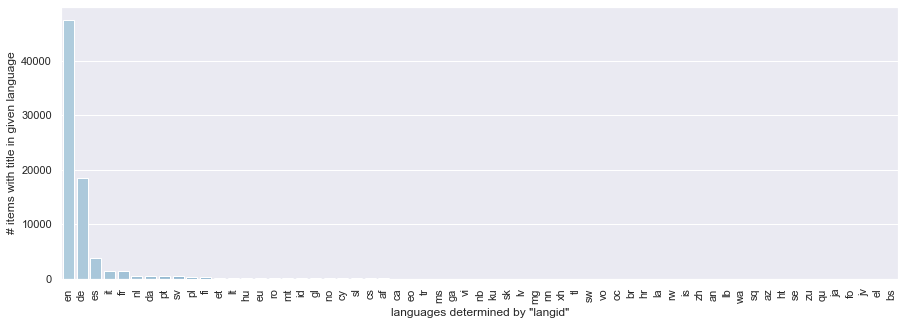

In [46]:
# inspect items w/o language specification -> only numeric !
print(f'cnt of items without language flag: {items_df["title_lg"].isnull().sum()}')
#display(items_df[items_df["title_lg"].isnull()].head(10))

# inspect results
lg_vc = pd.DataFrame(items_df['title_lg'].value_counts().reset_index())
display(lg_vc.transpose())

# show barplot with # items with title in given language
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='index', y='title_lg', ax=ax, data=lg_vc, palette=palette_blue).set(
    xlabel='languages determined by "langid"', 
    ylabel='# items with title in given language'
)
plt.xticks(rotation=90)
plt.show()

##### fasttext
- official Python binding module by Facebook
- problems with installation on windows

### module performance evaluation

execution time [s]  #items w/o language flg
langdetect              693.763393                       51
guess_language           16.254997                    32693
langid                  511.071150                        0

0        1       2       3       4       5       6      7   \
index          en       de      es      it      fr      nl      af     id   
title_ld  40241.0  19974.0  3098.0  1523.0  1262.0  1148.0  1111.0  891.0   
title_gl  20861.0  10632.0  2254.0  1160.0  1165.0   654.0  1351.0  168.0   
title_lg  47439.0  18415.0  3898.0  1473.0  1378.0   610.0    74.0  149.0   

             8      9   ...   63   64   65   66   67   68   69   70   71   72  
index        tl     pt  ...   lb   wa   ht   se   qu   ja   fo   jv   el   bs  
title_ld  838.0  807.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
title_gl  184.0  895.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
title_lg   21.0  515.0  ...  8.0  8.0  6.0  5.0  4.0  2.0  2.0  2.0  1.0  1.0  

[4 rows x 73 columns]

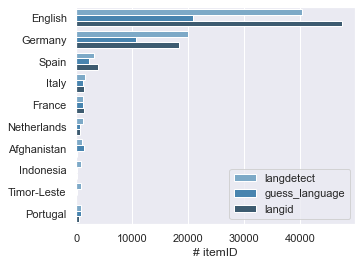

In [47]:
# compare execution time and items w/o flag
lan_detector_eval_df = pd.DataFrame({'execution time [s]': [eval('end_time_'+det.split("_")[1]) - eval('start_time_'+det.split("_")[1]) for det in ['title_ld','title_gl','title_lg']],
                                    '#items w/o language flg':[items_df[det].isnull().sum() for det in ['title_ld','title_gl','title_lg']]},
                                   index=[det for det in lan_detector.values()])
display(lan_detector_eval_df)

# merge results dfs
ld_gl_vc = ld_vc.merge(gl_vc, left_on='index', right_on='index', how='outer')
ld_gl_lg_vc = ld_gl_vc.merge(lg_vc, left_on='index', right_on='index', how='outer')
display(ld_gl_lg_vc.transpose())
ld_gl_lg_vc = ld_gl_lg_vc.head(10)

# rename columns
ld_gl_lg_vc.columns = ['index', 'langdetect','guess_language','langid']

# add language name
ld_gl_lg_vc['language_name'] = ld_gl_lg_vc['index'].apply(lambda l: pycountry.countries.get(alpha_2=l).name if l != 'en' else 'English')

# transform model cols into identifier column for plotting
ld_gl_lg_vc = pd.melt(ld_gl_lg_vc, id_vars=["index", "language_name"], 
                  var_name="flag_m", value_name="idCnt")
#display(ld_gl_lg_vc)

# Draw a nested barplot by language detector
sns.set_theme()
fig, ax = plt.subplots(figsize=(5,4))
g = sns.barplot(y="language_name", x="idCnt", hue="flag_m", data=ld_gl_lg_vc, palette=palette_blue, orient='h')
g.set(xlabel="# itemID", ylabel = "")
g.legend(loc='lower right')
plt.show()

### [DEV] Topic Similarity
__TODO: add scraping results of Estelle__

## Export of final pre-processed df

In [52]:
# print final df to .csv
#items_df.to_csv(items_path_pp)